<a href="https://colab.research.google.com/github/showmeinfinity/final_project/blob/main/Step_3_Classification_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sns
import copy

In [ ]:
import warnings
warnings.simplefilter("ignore")

In [ ]:
np.random.seed(13)
torch.manual_seed(13)

# Explore the distribution of the communities

Majority Communities - based on majority cluster rating per instance

In [ ]:
# Define the paths for the community datasets
majority_community_file_paths = {
    'community_0': 'majority_community_0_data_final_md_leiden.csv',
    'community_1': 'majority_community_1_data_final_md_leiden.csv',
    'community_2': 'majority_community_2_data_final_md_leiden.csv',
    'community_3': 'majority_community_3_data_final_md_leiden.csv',
    'combined': 'majority_combined_communities_data_final_md_leiden.csv'
}

individual_community_file_paths = {
    'community_0': 'community_0_data_final_md_leiden.csv',
    'community_1': 'community_1_data_final_md_leiden.csv',
    'community_2': 'community_2_data_final_md_leiden.csv',
    'community_3': 'community_3_data_final_md_leiden.csv',
    'combined': 'combined_communities_data_final_md_leiden.csv'
}

In [ ]:
def extract_dataset_info(file_paths_dict):

    # Initialise dictionaries to hold the dataset information
    dataset_sizes = {}
    unique_instance_ids_counts = {}
    offensiveness_class_counts = {}

    # Loop over the datasets and extract information
    for dataset_name, file_path in file_paths_dict.items():
        # Load the dataset
        df = pd.read_csv(file_path)

        # Get the size of the dataset (number of rows and columns)
        dataset_sizes[dataset_name] = df.shape

        # Unique instance IDs
        unique_instance_ids_counts[dataset_name] = df['instance_id'].nunique()

        # Count each class of offensiveness
        offensiveness_class_counts[dataset_name] = df['offensiveness'].value_counts().to_dict()

        # Print the results for the dataset
        print(f"### {dataset_name} ###")
        print(f"Dataset Size (Rows, Columns): {dataset_sizes[dataset_name]}")
        print(f"Unique Instance IDs: {unique_instance_ids_counts[dataset_name]}")
        print(f"Offensiveness Class Counts: {offensiveness_class_counts[dataset_name]}\n")

    return dataset_sizes, unique_instance_ids_counts, offensiveness_class_counts

In [ ]:
extract_dataset_info(individual_community_file_paths)

### community_0 ###
Dataset Size (Rows, Columns): (11955, 15)
Unique Instance IDs: 3551
Offensiveness Class Counts: {0: 8943, 1: 3012}

### community_1 ###
Dataset Size (Rows, Columns): (15083, 15)
Unique Instance IDs: 4265
Offensiveness Class Counts: {0: 9877, 1: 5206}

### community_2 ###
Dataset Size (Rows, Columns): (11592, 15)
Unique Instance IDs: 4469
Offensiveness Class Counts: {0: 7106, 1: 4486}

### community_3 ###
Dataset Size (Rows, Columns): (10481, 15)
Unique Instance IDs: 4601
Offensiveness Class Counts: {0: 6435, 1: 4046}

### combined ###
Dataset Size (Rows, Columns): (49111, 15)
Unique Instance IDs: 10751
Offensiveness Class Counts: {0: 32361, 1: 16750}



({'community_0': (11955, 15),
  'community_1': (15083, 15),
  'community_2': (11592, 15),
  'community_3': (10481, 15),
  'combined': (49111, 15)},
 {'community_0': 3551,
  'community_1': 4265,
  'community_2': 4469,
  'community_3': 4601,
  'combined': 10751},
 {'community_0': {0: 8943, 1: 3012},
  'community_1': {0: 9877, 1: 5206},
  'community_2': {0: 7106, 1: 4486},
  'community_3': {0: 6435, 1: 4046},
  'combined': {0: 32361, 1: 16750}})

In [ ]:
extract_dataset_info(majority_community_file_paths)

### community_0 ###
Dataset Size (Rows, Columns): (3551, 4)
Unique Instance IDs: 3551
Offensiveness Class Counts: {0: 2846, 1: 705}

### community_1 ###
Dataset Size (Rows, Columns): (4265, 4)
Unique Instance IDs: 4265
Offensiveness Class Counts: {0: 2965, 1: 1300}

### community_2 ###
Dataset Size (Rows, Columns): (4469, 4)
Unique Instance IDs: 4469
Offensiveness Class Counts: {0: 2839, 1: 1630}

### community_3 ###
Dataset Size (Rows, Columns): (4601, 4)
Unique Instance IDs: 4601
Offensiveness Class Counts: {0: 3056, 1: 1545}

### combined ###
Dataset Size (Rows, Columns): (10751, 4)
Unique Instance IDs: 10751
Offensiveness Class Counts: {0: 7594, 1: 3157}



({'community_0': (3551, 4),
  'community_1': (4265, 4),
  'community_2': (4469, 4),
  'community_3': (4601, 4),
  'combined': (10751, 4)},
 {'community_0': 3551,
  'community_1': 4265,
  'community_2': 4469,
  'community_3': 4601,
  'combined': 10751},
 {'community_0': {0: 2846, 1: 705},
  'community_1': {0: 2965, 1: 1300},
  'community_2': {0: 2839, 1: 1630},
  'community_3': {0: 3056, 1: 1545},
  'combined': {0: 7594, 1: 3157}})

Create a random subset of combined to test the size factor for models

In [ ]:
# Load the combined dataset
majority_combined_df = pd.read_csv('majority_combined_communities_data_final_md_leiden.csv')
# Get a random sample from the combined dataset - around the size of individual
sampled_df = majority_combined_df.sample(n=4200, random_state=13)
#save csv
sampled_df.to_csv('majority_combined_subset_communities_data_final_md_leiden.csv', index=False)

In [ ]:
# Load the combined dataset
individual_combined_df = pd.read_csv('combined_communities_data_final_md_leiden.csv')
# Get a random sample from the combined dataset - around the size of individual
sampled_df_2 = individual_combined_df.sample(n=12000, random_state=13)
#save csv
sampled_df_2.to_csv('combined_subset_communities_data_final_md_leiden.csv', index=False)

# Functions for model training

-  Define HateSpeechDataset Class

In [ ]:
class HateSpeechDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


- Define Training Function

In [ ]:
def train(model, train_dataloader, validation_dataloader, optimizer, scheduler, device, epochs, model_filename, patience=2):
    loss_values = []
    validation_loss_values = []
    best_val_loss = float('inf')
    counter = 0

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        print("-" * 10)

        model.train()
        total_loss = 0
        for batch in tqdm(train_dataloader):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()
        avg_train_loss = total_loss / len(train_dataloader)
        loss_values.append(avg_train_loss)

        model.eval()
        total_eval_loss = 0
        for batch in tqdm(validation_dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_eval_loss += loss.item()
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        validation_loss_values.append(avg_val_loss)

        print(f"Training loss: {avg_train_loss}, Validation loss: {avg_val_loss}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            torch.save(model.state_dict(), f'{model_filename}_best_model.pt')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping after {patience} epochs with no improvement")
                model.load_state_dict(torch.load(f'{model_filename}_best_model.pt'))
                break
    return loss_values, validation_loss_values

- Define Evaluation Function

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    predictions, true_labels = [], []
    for batch in tqdm(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        predictions.append(logits)
        true_labels.append(label_ids)
    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    return predictions, true_labels

- Define Plotting Functions

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), title=title, ylabel='True label', xlabel='Predicted label')
    plt.show()

def plot_loss_curves(loss_values, validation_loss_values):
    plt.figure(figsize=(12, 6))
    plt.plot(loss_values, 'b-o', label="training loss")
    plt.plot(validation_loss_values, 'r-o', label="validation loss")
    plt.title("Learning curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

- Prepare Dataset and Loaders Function

In [ ]:
def prepare_dataset_and_loaders(train_df, val_df, test_df, tokenizer):
    # Tokenize the data
    train_encodings = tokenizer(train_df['text_with_domain'].to_list(), truncation=True, padding=True, max_length=128)
    val_encodings = tokenizer(val_df['text_with_domain'].to_list(), truncation=True, padding=True, max_length=128)
    test_encodings = tokenizer(test_df['text_with_domain'].to_list(), truncation=True, padding=True, max_length=128)

    # Create the dataset
    train_labels = torch.tensor(train_df['offensiveness'].tolist()).long()
    val_labels = torch.tensor(val_df['offensiveness'].tolist()).long()
    test_labels = torch.tensor(test_df['offensiveness'].tolist()).long()

    train_dataset = HateSpeechDataset(train_encodings, train_labels)
    val_dataset = HateSpeechDataset(val_encodings, val_labels)
    test_dataset = HateSpeechDataset(test_encodings, test_labels)

    # Create the dataloaders
    train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
    validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32)
    test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)

    return train_dataloader, validation_dataloader, test_dataloader, test_labels

- Define experiment run for majority clustering score


In [ ]:
def run_experiment_majority(df, sample_frac, community_name):
    # Initialise the scores and instances lists
    cross_entropy_scores = []
    f1_macro_scores = []
    correctly_classified_instances = []
    incorrectly_classified_instances = []

    # Initialise the tokenizer and device
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()

    # Sample the dataframe
    sampled_df = df.sample(frac=sample_frac, random_state=1)

    # Perform the StratifiedKFold and other procedures
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

    for train_index, test_index in skf.split(sampled_df, sampled_df['offensiveness']):
        train_val_df = sampled_df.iloc[train_index].copy()
        test_df = sampled_df.iloc[test_index].copy()
        train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=1, stratify=train_val_df['offensiveness'])

        # Modify the DataFrames directly
        train_df.loc[:, 'text_with_domain'] = train_df['cleaned_domain'] + " " + train_df['cleaned_text']
        val_df.loc[:, 'text_with_domain'] = val_df['cleaned_domain'] + " " + val_df['cleaned_text']
        test_df.loc[:, 'text_with_domain'] = test_df['cleaned_domain'] + " " + test_df['cleaned_text']

        # Prepare dataset and loaders
        train_dataloader, validation_dataloader, test_dataloader, test_labels = prepare_dataset_and_loaders(train_df, val_df, test_df, tokenizer)

        # Model initialisation and training
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
        model.to(device)
        optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.0)
        epochs = 4
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)

        model_filename = f"{community_name}_epoch_{epochs}"
        loss_values, validation_loss_values = train(model, train_dataloader, validation_dataloader, optimizer, scheduler, device, epochs, model_filename)
        plot_loss_curves(loss_values, validation_loss_values)

        # Evaluation
        predictions, true_labels = evaluate(model, test_dataloader, device)
        print(classification_report(true_labels, predictions.argmax(axis=1)))
        plot_confusion_matrix(true_labels, predictions.argmax(axis=1))

        cross_entropy = criterion(torch.tensor(predictions), torch.tensor(true_labels))
        cross_entropy_scores.append(cross_entropy.item())
        print(f"Cross Entropy for this fold: {cross_entropy.item()}")

        f1_macro = f1_score(true_labels, predictions.argmax(axis=1), average='macro')
        f1_macro_scores.append(f1_macro)

        # Classify instances as correctly or incorrectly predicted
        predicted_labels = predictions.argmax(axis=1)
        for i, (true_label, predicted_label) in enumerate(zip(true_labels, predicted_labels)):
            instance = test_df.iloc[i].to_dict()
            instance['predicted_label'] = predicted_label
            instance['true_label'] = true_label
            instance_cross_entropy = criterion(torch.tensor(predictions[i]).unsqueeze(0), torch.tensor([true_label]))
            instance['cross_entropy'] = instance_cross_entropy.item()
            if true_label == predicted_label:
                correctly_classified_instances.append(instance)
            else:
                incorrectly_classified_instances.append(instance)

    # Convert lists of instances to DataFrames after all folds have been processed
    correctly_classified_df = pd.DataFrame(correctly_classified_instances)
    incorrectly_classified_df = pd.DataFrame(incorrectly_classified_instances)

    # Save to CSV after all folds have been processed
    correctly_classified_df.to_csv(f"{community_name}_correctly_classified_instances.csv", index=False)
    incorrectly_classified_df.to_csv(f"{community_name}_incorrectly_classified_instances.csv", index=False)

    # Calculate and print averages after all folds have been processed
    average_cross_entropy = np.mean(cross_entropy_scores)
    average_f1_macro = np.mean(f1_macro_scores)

    print(f"{community_name} - Average Cross Entropy: {average_cross_entropy}")
    print(f"{community_name} - Average F1 Macro Score: {average_f1_macro}")

    return average_cross_entropy, average_f1_macro


- Define experiment run for individual scores


In [ ]:
def run_experiment_individual(df, sample_frac, community_name):
    cross_entropy_scores = []
    f1_macro_scores = []
    correctly_classified_instances = []
    incorrectly_classified_instances = []

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()

    unique_instance_ids = df['instance_id'].unique()
    labels_for_unique_ids = df.drop_duplicates(subset='instance_id')['offensiveness'].values

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

    for train_val_ids, test_ids in skf.split(unique_instance_ids, labels_for_unique_ids):
        train_val_df = df[df['instance_id'].isin(unique_instance_ids[train_val_ids])]
        test_df = df[df['instance_id'].isin(unique_instance_ids[test_ids])]

        train_ids, val_ids = train_test_split(train_val_ids, test_size=0.25, random_state=1, stratify=labels_for_unique_ids[train_val_ids])
        train_df = df[df['instance_id'].isin(unique_instance_ids[train_ids])]
        val_df = df[df['instance_id'].isin(unique_instance_ids[val_ids])]

        # Combine the cleaned_text and cleaned_domain
        train_df['text_with_domain'] = train_df['cleaned_domain'] + " " + train_df['cleaned_text']
        val_df['text_with_domain'] = val_df['cleaned_domain'] + " " + val_df['cleaned_text']
        test_df['text_with_domain'] = test_df['cleaned_domain'] + " " + test_df['cleaned_text']

        train_dataloader, validation_dataloader, test_dataloader, test_labels = prepare_dataset_and_loaders(train_df, val_df, test_df, tokenizer)

        # Model initialisation and training
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
        model.to(device)
        optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.0)
        epochs = 2
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)

        model_filename = f"{community_name}_epoch_{epochs}"
        loss_values, validation_loss_values = train(model, train_dataloader, validation_dataloader, optimizer, scheduler, device, epochs, model_filename)
        plot_loss_curves(loss_values, validation_loss_values)

        # Evaluation
        predictions, true_labels = evaluate(model, test_dataloader, device)
        print(classification_report(true_labels, predictions.argmax(axis=1)))
        plot_confusion_matrix(true_labels, predictions.argmax(axis=1))

        cross_entropy = criterion(torch.tensor(predictions), torch.tensor(true_labels))
        cross_entropy_scores.append(cross_entropy.item())
        print(f"Cross Entropy for this fold: {cross_entropy.item()}")

        f1_macro = f1_score(true_labels, predictions.argmax(axis=1), average='macro')
        f1_macro_scores.append(f1_macro)

        # Classify instances as correctly or incorrectly predicted
        predicted_labels = predictions.argmax(axis=1)
        for i, (true_label, predicted_label) in enumerate(zip(true_labels, predicted_labels)):
            instance = test_df.iloc[i].to_dict()
            instance['predicted_label'] = predicted_label
            instance['true_label'] = true_label
            instance_cross_entropy = criterion(torch.tensor(predictions[i]).unsqueeze(0), torch.tensor([true_label]))
            instance['cross_entropy'] = instance_cross_entropy.item()
            if true_label == predicted_label:
                correctly_classified_instances.append(instance)
            else:
                incorrectly_classified_instances.append(instance)

    # Convert lists of instances to DataFrames after all folds have been processed
    correctly_classified_df = pd.DataFrame(correctly_classified_instances)
    incorrectly_classified_df = pd.DataFrame(incorrectly_classified_instances)

    # Save to CSV after all folds have been processed
    correctly_classified_df.to_csv(f"{community_name}_correctly_classified_instances.csv", index=False)
    incorrectly_classified_df.to_csv(f"{community_name}_incorrectly_classified_instances.csv", index=False)

    # Calculate and print averages after all folds have been processed
    average_cross_entropy = np.mean(cross_entropy_scores)
    average_f1_macro = np.mean(f1_macro_scores)

    print(f"{community_name} - Average Cross Entropy: {average_cross_entropy}")
    print(f"{community_name} - Average F1 Macro Score: {average_f1_macro}")

    return average_cross_entropy, average_f1_macro


# Trial run

Samples of the datasets used to optimise functions to make decisions on necessary evaluation metrics, parameters and test runs

1) Using HateBERT

Running experiment for combined community


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


Training loss: 0.6806475765564862, Validation loss: 0.6186427275339762
Epoch 2/4
----------


100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


Training loss: 0.5889054729658014, Validation loss: 0.5928346614042918
Epoch 3/4
----------


100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


Training loss: 0.5696913038983065, Validation loss: 0.5790315866470337
Epoch 4/4
----------


100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


Training loss: 0.5525930278441485, Validation loss: 0.5737552543481191


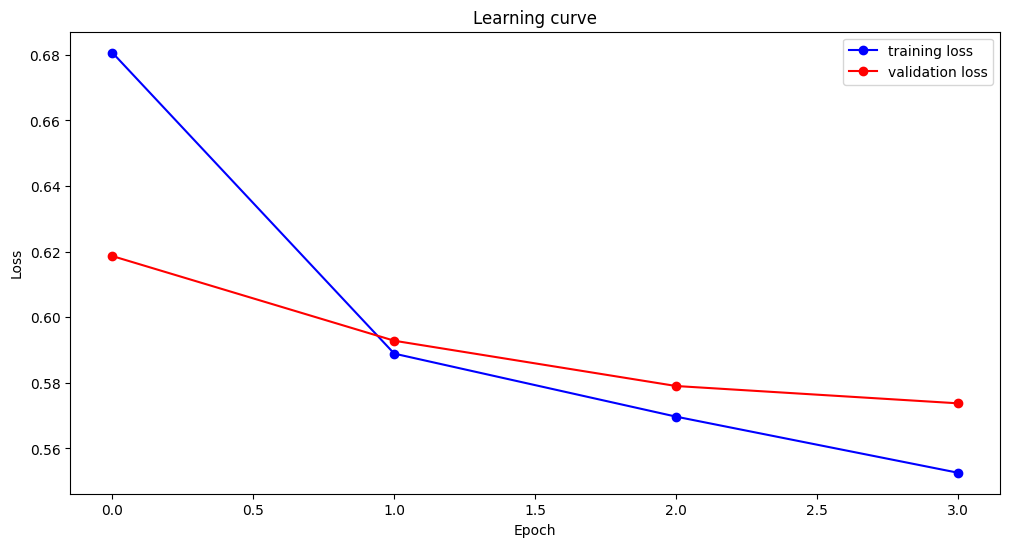

100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


              precision    recall  f1-score   support

           0       0.70      1.00      0.82       252
           1       0.00      0.00      0.00       107

    accuracy                           0.70       359
   macro avg       0.35      0.50      0.41       359
weighted avg       0.49      0.70      0.58       359



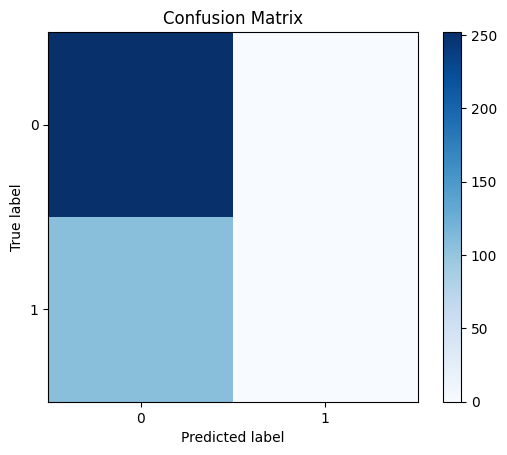

Cross Entropy for this fold: 0.5778136849403381


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Training loss: 0.6193411262596354, Validation loss: 0.6096180379390717
Epoch 2/4
----------


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


Training loss: 0.584771512185826, Validation loss: 0.5915393233299255
Epoch 3/4
----------


100%|██████████| 6/6 [00:01<00:00,  5.25it/s]


Training loss: 0.5494519174098969, Validation loss: 0.5740531086921692
Epoch 4/4
----------


100%|██████████| 6/6 [00:01<00:00,  5.25it/s]


Training loss: 0.5262613138731789, Validation loss: 0.5656752189000448


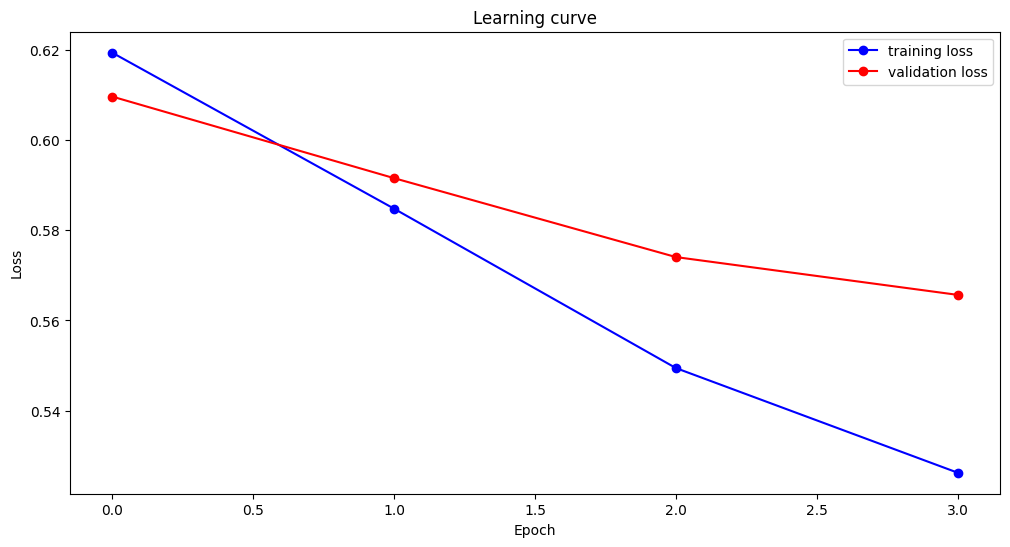

100%|██████████| 12/12 [00:02<00:00,  4.69it/s]


              precision    recall  f1-score   support

           0       0.72      0.93      0.81       252
           1       0.45      0.14      0.22       106

    accuracy                           0.70       358
   macro avg       0.59      0.54      0.51       358
weighted avg       0.64      0.70      0.63       358



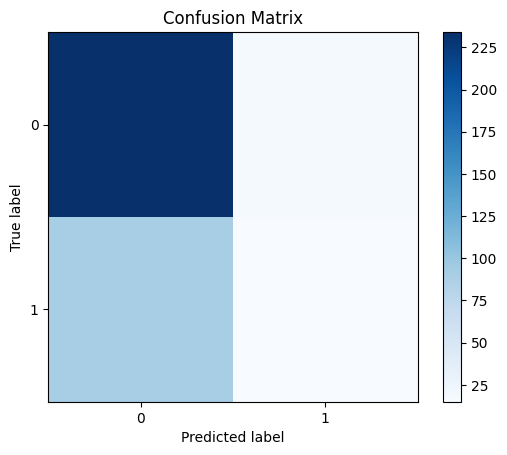

Cross Entropy for this fold: 0.5616554617881775


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 6/6 [00:01<00:00,  4.98it/s]


Training loss: 0.6419083283228033, Validation loss: 0.609705775976181
Epoch 2/4
----------


100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


Training loss: 0.597767347798628, Validation loss: 0.6031709710756937
Epoch 3/4
----------


100%|██████████| 6/6 [00:01<00:00,  4.74it/s]


Training loss: 0.5780817778671489, Validation loss: 0.5919486880302429
Epoch 4/4
----------


100%|██████████| 6/6 [00:01<00:00,  5.00it/s]


Training loss: 0.5667128229842466, Validation loss: 0.5877876778443655


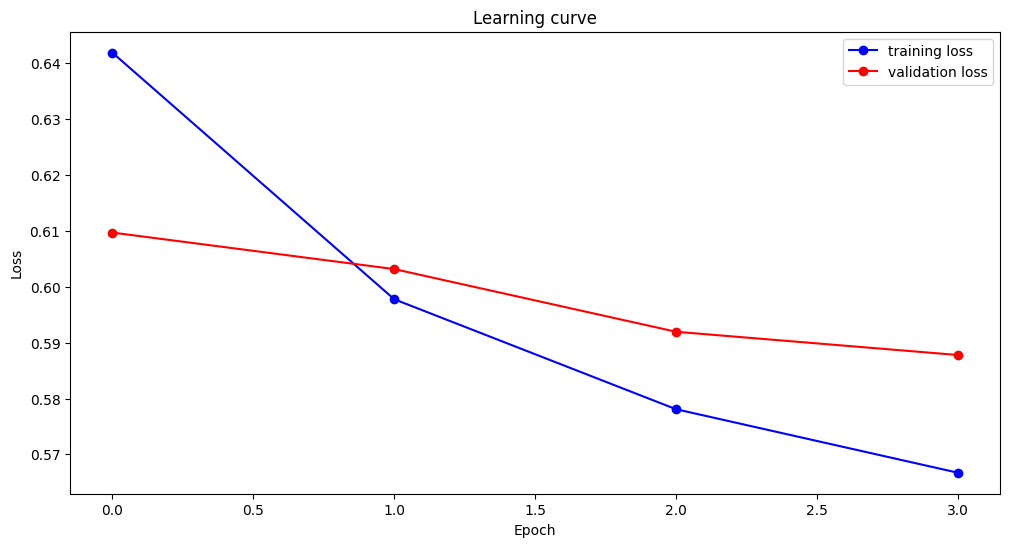

100%|██████████| 12/12 [00:01<00:00,  6.75it/s]


              precision    recall  f1-score   support

           0       0.70      1.00      0.82       251
           1       0.00      0.00      0.00       107

    accuracy                           0.70       358
   macro avg       0.35      0.50      0.41       358
weighted avg       0.49      0.70      0.58       358



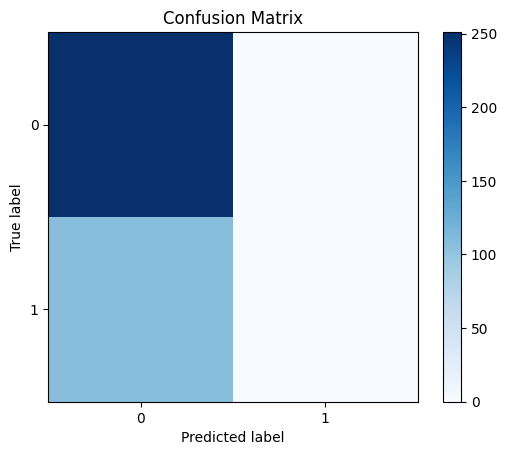

Cross Entropy for this fold: 0.5815748572349548
majority_combined_community - Average Cross Entropy: 0.5736813346544901
majority_combined_community - Average F1 Macro Score: 0.4460164296008391
Running experiment for combined subset community


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.90it/s]


Training loss: 0.6439396824155535, Validation loss: 0.5667807956536611
Epoch 2/4
----------


100%|██████████| 3/3 [00:00<00:00,  8.12it/s]


Training loss: 0.5852860978671482, Validation loss: 0.5588848690191904
Epoch 3/4
----------


100%|██████████| 3/3 [00:00<00:00,  8.10it/s]


Training loss: 0.5789174224649157, Validation loss: 0.5550499061743418
Epoch 4/4
----------


100%|██████████| 3/3 [00:00<00:00,  8.21it/s]


Training loss: 0.5697762455259051, Validation loss: 0.5534525215625763


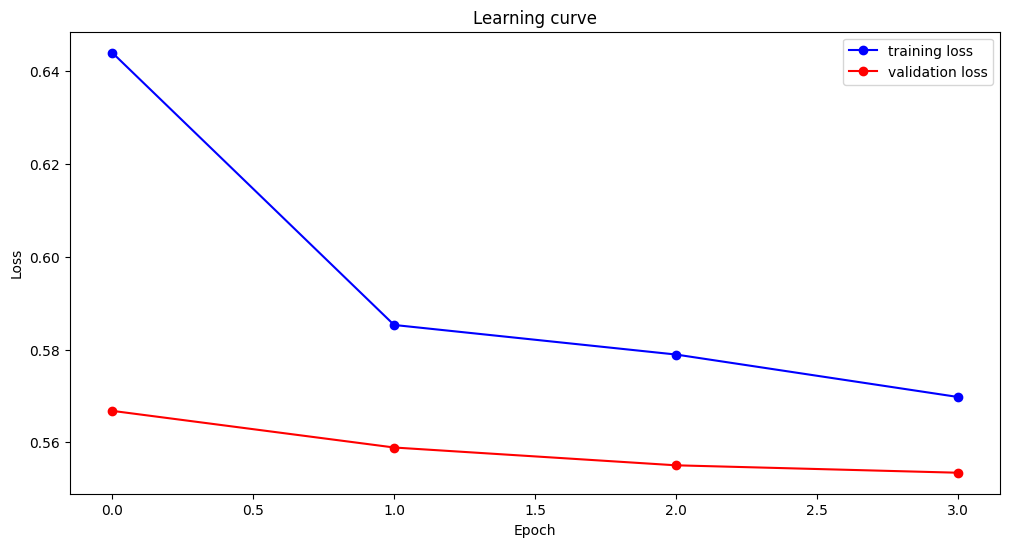

100%|██████████| 5/5 [00:00<00:00,  5.70it/s]


              precision    recall  f1-score   support

           0       0.69      1.00      0.82        97
           1       0.00      0.00      0.00        43

    accuracy                           0.69       140
   macro avg       0.35      0.50      0.41       140
weighted avg       0.48      0.69      0.57       140



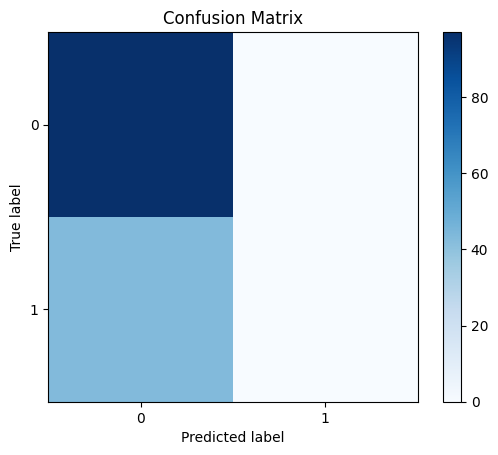

Cross Entropy for this fold: 0.6137259602546692


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.88it/s]


Training loss: 0.6571853160858154, Validation loss: 0.5866281986236572
Epoch 2/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.54it/s]


Training loss: 0.5967035719326564, Validation loss: 0.567780206600825
Epoch 3/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.60it/s]


Training loss: 0.5827413371631077, Validation loss: 0.5617918272813162
Epoch 4/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.76it/s]


Training loss: 0.5619614507470813, Validation loss: 0.5591720044612885


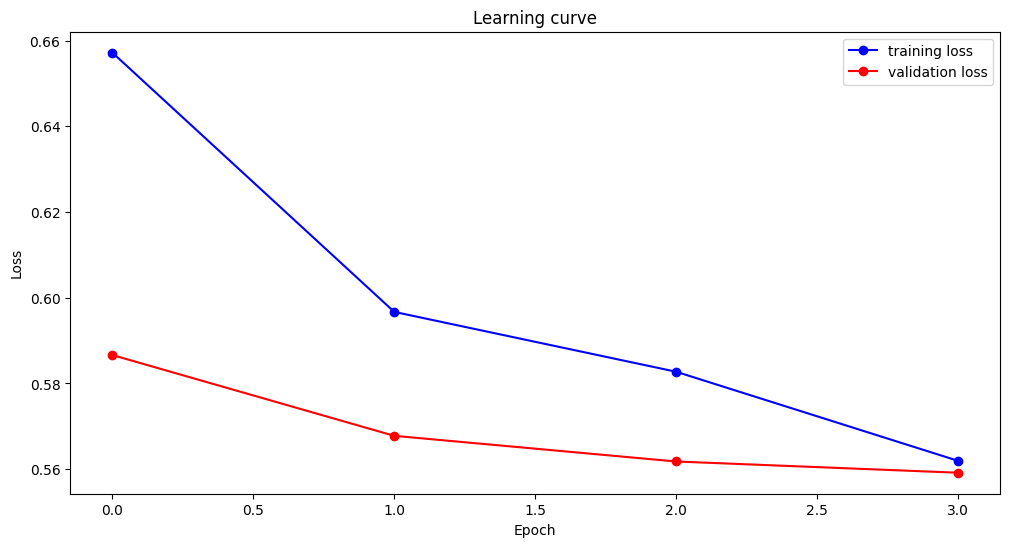

100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


              precision    recall  f1-score   support

           0       0.70      1.00      0.82        98
           1       0.00      0.00      0.00        42

    accuracy                           0.70       140
   macro avg       0.35      0.50      0.41       140
weighted avg       0.49      0.70      0.58       140



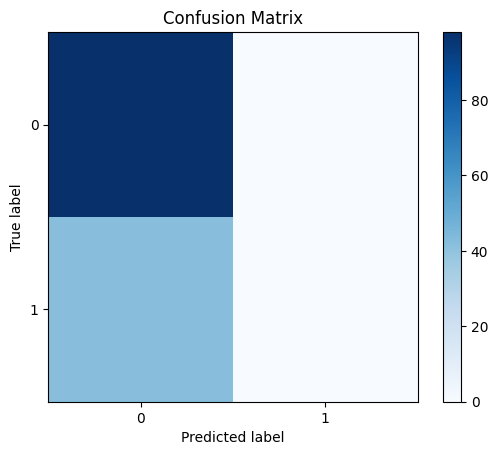

Cross Entropy for this fold: 0.5953853130340576


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 3/3 [00:00<00:00,  9.92it/s]


Training loss: 0.6619127988815308, Validation loss: 0.5851940910021464
Epoch 2/4
----------


100%|██████████| 3/3 [00:00<00:00, 10.14it/s]


Training loss: 0.6076036776815142, Validation loss: 0.5716249247392019
Epoch 3/4
----------


100%|██████████| 3/3 [00:00<00:00, 10.34it/s]


Training loss: 0.5956155913216727, Validation loss: 0.5705359081427256
Epoch 4/4
----------


100%|██████████| 3/3 [00:00<00:00, 10.21it/s]


Training loss: 0.5942762919834682, Validation loss: 0.570365697145462


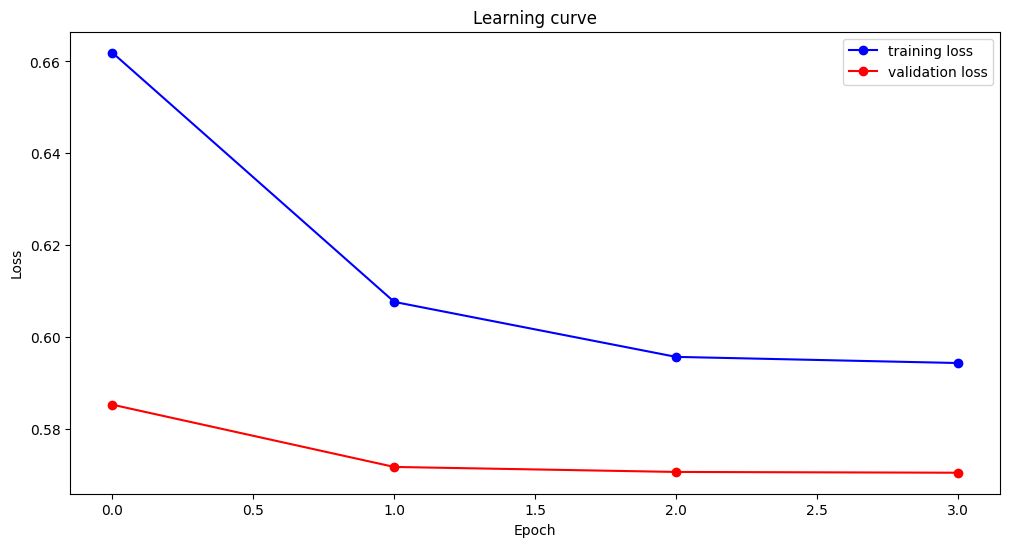

100%|██████████| 5/5 [00:00<00:00,  5.82it/s]


              precision    recall  f1-score   support

           0       0.70      1.00      0.82        98
           1       0.00      0.00      0.00        42

    accuracy                           0.70       140
   macro avg       0.35      0.50      0.41       140
weighted avg       0.49      0.70      0.58       140



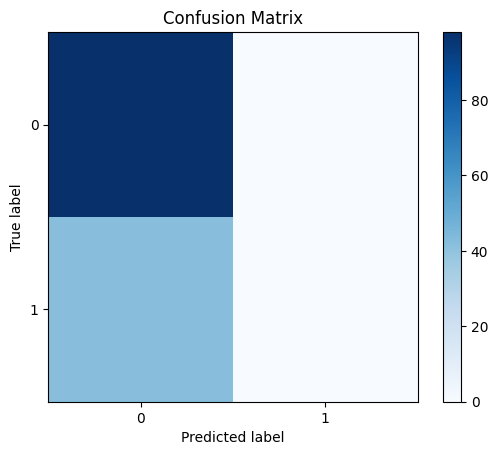

Cross Entropy for this fold: 0.6123781800270081
majority_combined_subset_community - Average Cross Entropy: 0.607163151105245
majority_combined_subset_community - Average F1 Macro Score: 0.4109373707288822
Running experiment for majority_community_0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 2/2 [00:00<00:00,  5.33it/s]


Training loss: 0.6410646339257559, Validation loss: 0.5347975790500641
Epoch 2/4
----------


100%|██████████| 2/2 [00:00<00:00,  4.73it/s]


Training loss: 0.5296990424394608, Validation loss: 0.5167789906263351
Epoch 3/4
----------


100%|██████████| 2/2 [00:00<00:00,  5.10it/s]


Training loss: 0.4895347058773041, Validation loss: 0.5186252444982529
Epoch 4/4
----------


100%|██████████| 2/2 [00:00<00:00,  5.29it/s]


Training loss: 0.48624243835608166, Validation loss: 0.5189809054136276
Early stopping after 2 epochs with no improvement


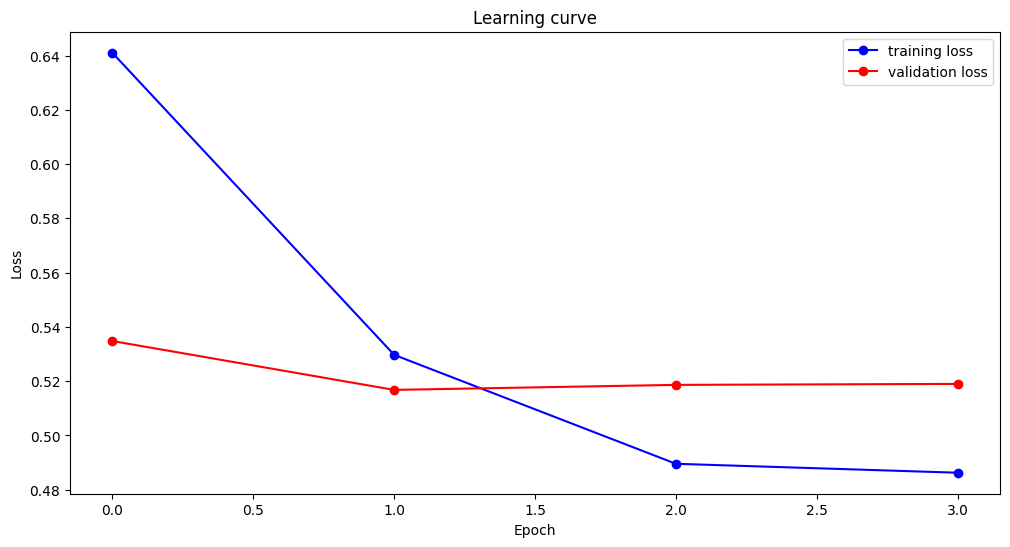

100%|██████████| 4/4 [00:00<00:00,  6.62it/s]


              precision    recall  f1-score   support

           0       0.79      1.00      0.88        94
           1       0.00      0.00      0.00        25

    accuracy                           0.79       119
   macro avg       0.39      0.50      0.44       119
weighted avg       0.62      0.79      0.70       119



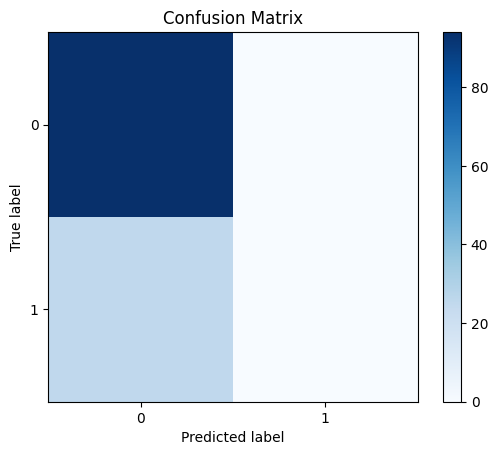

Cross Entropy for this fold: 0.49735310673713684


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 2/2 [00:00<00:00,  6.95it/s]


Training loss: 0.6081219812234243, Validation loss: 0.5430727005004883
Epoch 2/4
----------


100%|██████████| 2/2 [00:00<00:00,  6.96it/s]


Training loss: 0.5376128902037939, Validation loss: 0.5098541676998138
Epoch 3/4
----------


100%|██████████| 2/2 [00:00<00:00,  6.99it/s]


Training loss: 0.514788975318273, Validation loss: 0.5024019479751587
Epoch 4/4
----------


100%|██████████| 2/2 [00:00<00:00,  6.77it/s]


Training loss: 0.5050038248300552, Validation loss: 0.5010780692100525


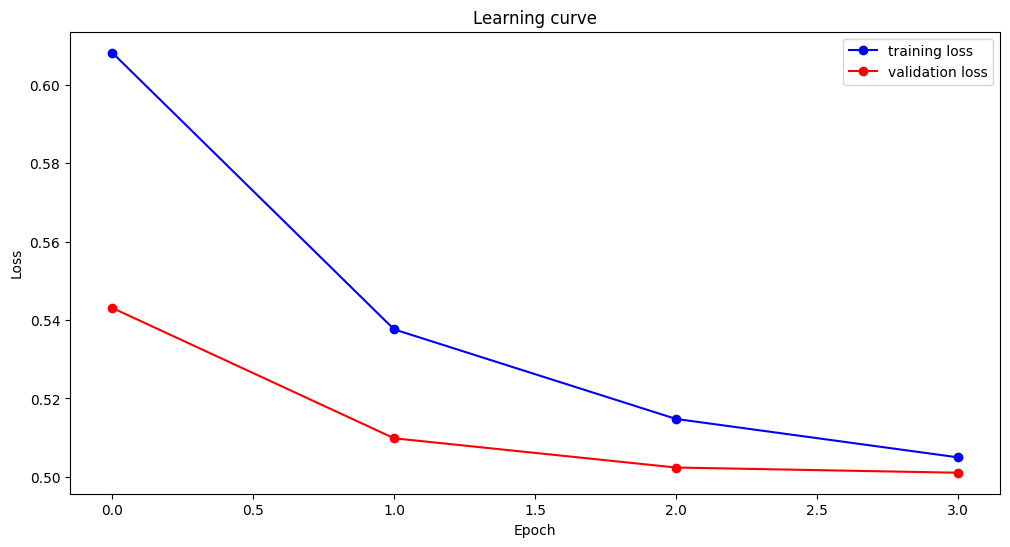

100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


              precision    recall  f1-score   support

           0       0.80      1.00      0.89        94
           1       0.00      0.00      0.00        24

    accuracy                           0.80       118
   macro avg       0.40      0.50      0.44       118
weighted avg       0.63      0.80      0.71       118



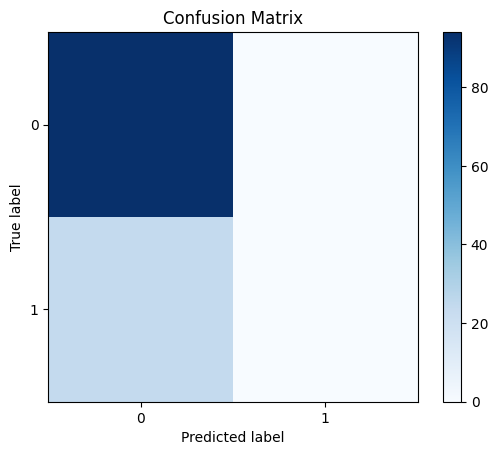

Cross Entropy for this fold: 0.5086060762405396


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 2/2 [00:00<00:00,  7.00it/s]


Training loss: 0.5490021506945292, Validation loss: 0.5104785412549973
Epoch 2/4
----------


100%|██████████| 2/2 [00:00<00:00,  6.96it/s]


Training loss: 0.5001944055159887, Validation loss: 0.5043437480926514
Epoch 3/4
----------


100%|██████████| 2/2 [00:00<00:00,  7.05it/s]


Training loss: 0.48851274450620014, Validation loss: 0.5044362843036652
Epoch 4/4
----------


100%|██████████| 2/2 [00:00<00:00,  6.62it/s]


Training loss: 0.48376869161923725, Validation loss: 0.5043451637029648
Early stopping after 2 epochs with no improvement


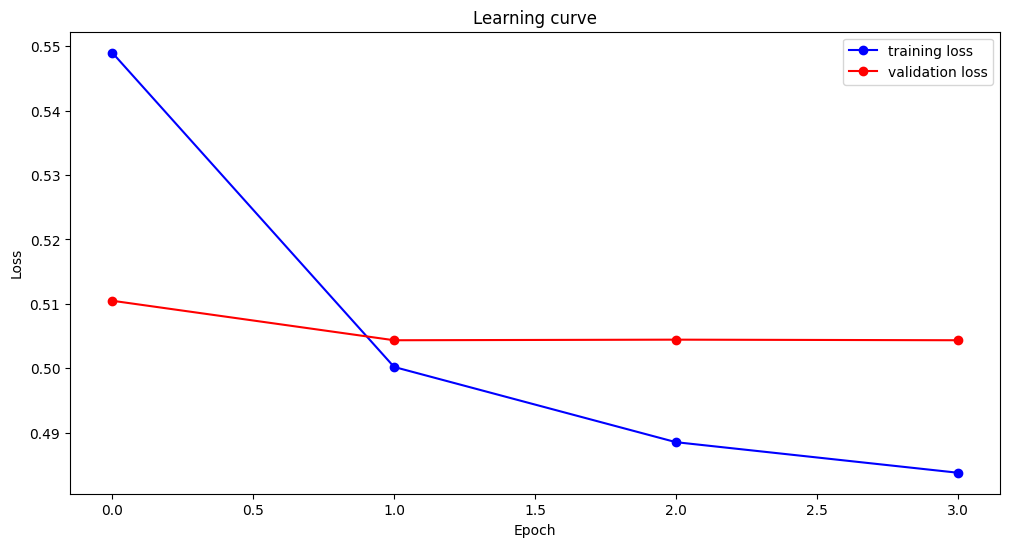

100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


              precision    recall  f1-score   support

           0       0.80      1.00      0.89        94
           1       0.00      0.00      0.00        24

    accuracy                           0.80       118
   macro avg       0.40      0.50      0.44       118
weighted avg       0.63      0.80      0.71       118



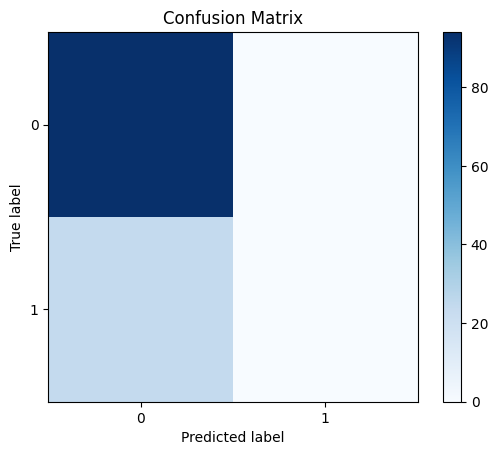

Cross Entropy for this fold: 0.5124180912971497
majority_community_0 - Average Cross Entropy: 0.5061257580916086
majority_community_0 - Average F1 Macro Score: 0.442702335606933
Running experiment for majority_community_1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.81it/s]


Training loss: 0.6684418746403286, Validation loss: 0.6327791015307108
Epoch 2/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.70it/s]


Training loss: 0.623383275100163, Validation loss: 0.6174191435178121
Epoch 3/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.69it/s]


Training loss: 0.5895243031638009, Validation loss: 0.6041025320688883
Epoch 4/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.94it/s]


Training loss: 0.5719574008669172, Validation loss: 0.5984352231025696


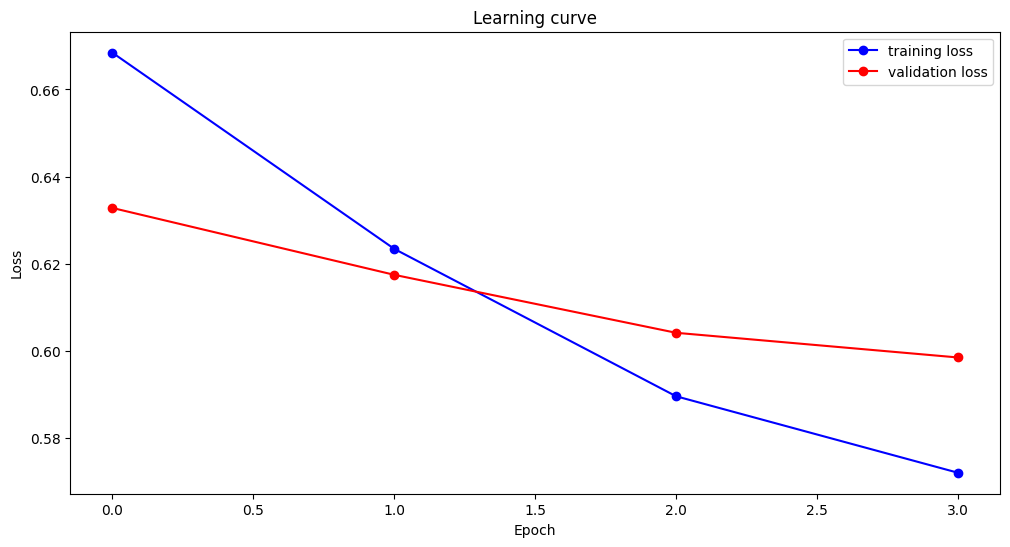

100%|██████████| 5/5 [00:01<00:00,  4.98it/s]


              precision    recall  f1-score   support

           0       0.66      0.97      0.79        90
           1       0.73      0.15      0.25        52

    accuracy                           0.67       142
   macro avg       0.70      0.56      0.52       142
weighted avg       0.69      0.67      0.59       142



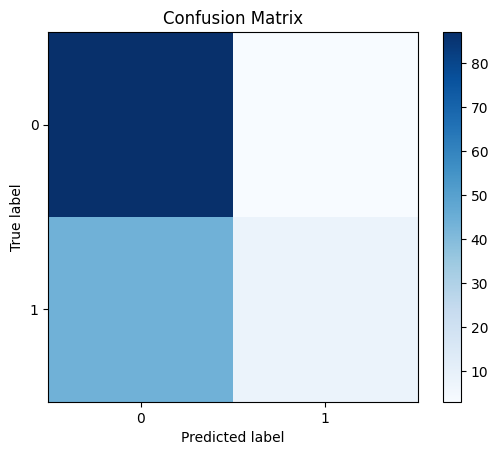

Cross Entropy for this fold: 0.6314575672149658


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 3/3 [00:00<00:00,  6.39it/s]


Training loss: 0.6598378930773053, Validation loss: 0.6412116686503092
Epoch 2/4
----------


100%|██████████| 3/3 [00:00<00:00,  6.33it/s]


Training loss: 0.6088323593139648, Validation loss: 0.6405749320983887
Epoch 3/4
----------


100%|██████████| 3/3 [00:00<00:00,  6.33it/s]


Training loss: 0.5867523976734706, Validation loss: 0.641049305597941
Epoch 4/4
----------


100%|██████████| 3/3 [00:00<00:00,  6.33it/s]


Training loss: 0.571514504296439, Validation loss: 0.6414285898208618
Early stopping after 2 epochs with no improvement


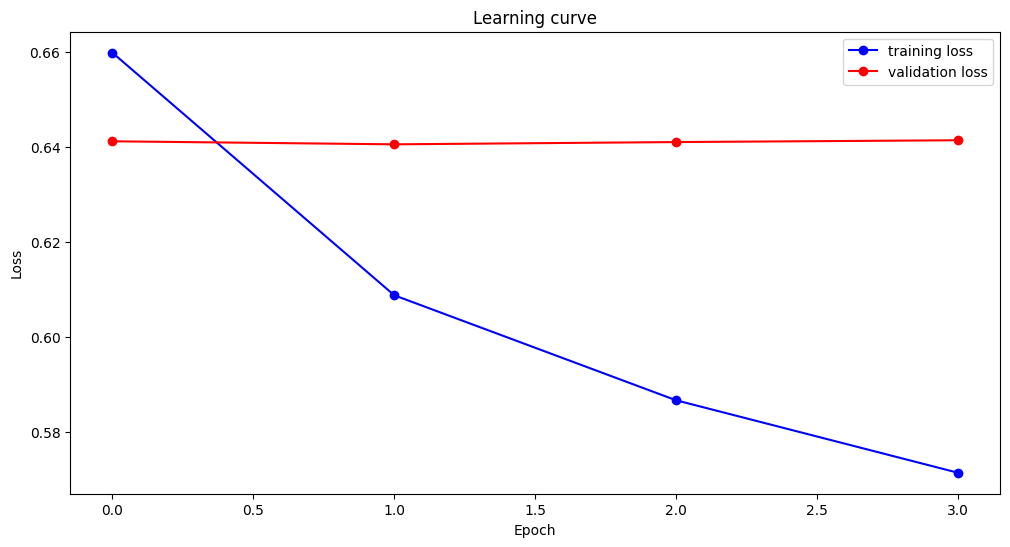

100%|██████████| 5/5 [00:00<00:00,  6.77it/s]


              precision    recall  f1-score   support

           0       0.64      1.00      0.78        91
           1       0.00      0.00      0.00        51

    accuracy                           0.64       142
   macro avg       0.32      0.50      0.39       142
weighted avg       0.41      0.64      0.50       142



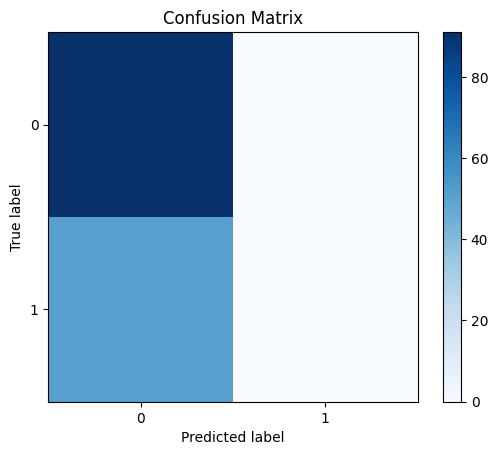

Cross Entropy for this fold: 0.6294048428535461


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 3/3 [00:00<00:00, 10.39it/s]


Training loss: 0.6606460128511701, Validation loss: 0.6222999890645345
Epoch 2/4
----------


100%|██████████| 3/3 [00:00<00:00, 10.26it/s]


Training loss: 0.6086577347346714, Validation loss: 0.6148796280225118
Epoch 3/4
----------


100%|██████████| 3/3 [00:00<00:00, 10.12it/s]


Training loss: 0.5758177467754909, Validation loss: 0.6115116079648336
Epoch 4/4
----------


100%|██████████| 3/3 [00:00<00:00, 10.09it/s]


Training loss: 0.5632221698760986, Validation loss: 0.6106022993723551


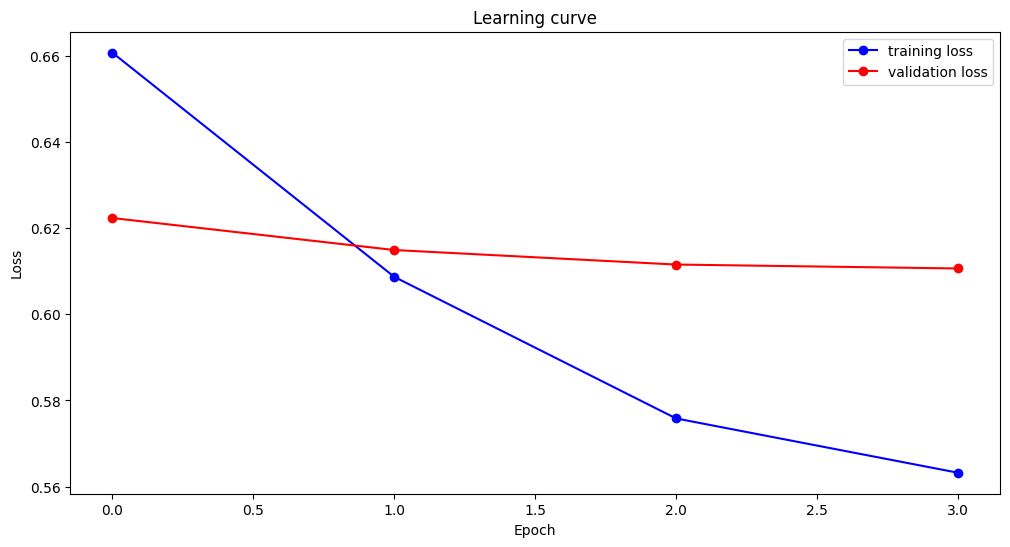

100%|██████████| 5/5 [00:00<00:00,  6.38it/s]


              precision    recall  f1-score   support

           0       0.65      0.99      0.79        91
           1       0.75      0.06      0.11        51

    accuracy                           0.65       142
   macro avg       0.70      0.52      0.45       142
weighted avg       0.69      0.65      0.54       142



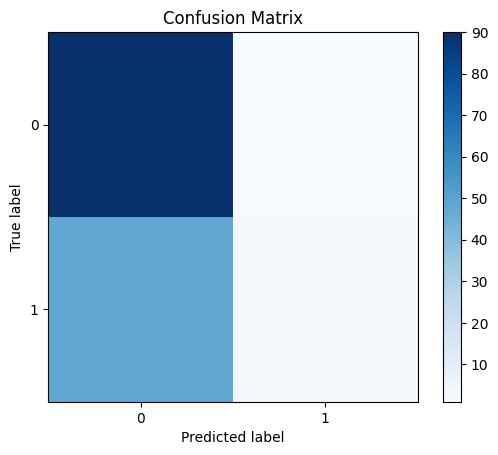

Cross Entropy for this fold: 0.6301766037940979
majority_community_1 - Average Cross Entropy: 0.6303463379542033
majority_community_1 - Average F1 Macro Score: 0.45292192675048887
Running experiment for majority_community_2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 3/3 [00:00<00:00,  8.04it/s]


Training loss: 0.6669166258403233, Validation loss: 0.6565665404001871
Epoch 2/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.92it/s]


Training loss: 0.6186621870313372, Validation loss: 0.654332160949707
Epoch 3/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.97it/s]


Training loss: 0.600023593221392, Validation loss: 0.6548632383346558
Epoch 4/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.72it/s]


Training loss: 0.5808179804256984, Validation loss: 0.6540255943934122


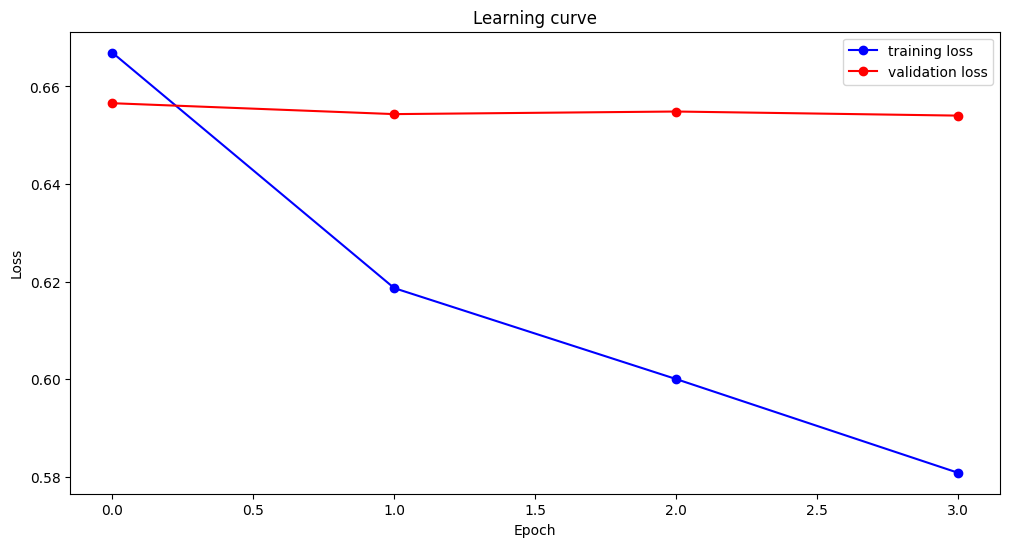

100%|██████████| 5/5 [00:00<00:00,  5.24it/s]


              precision    recall  f1-score   support

           0       0.67      1.00      0.80       100
           1       0.00      0.00      0.00        49

    accuracy                           0.67       149
   macro avg       0.34      0.50      0.40       149
weighted avg       0.45      0.67      0.54       149



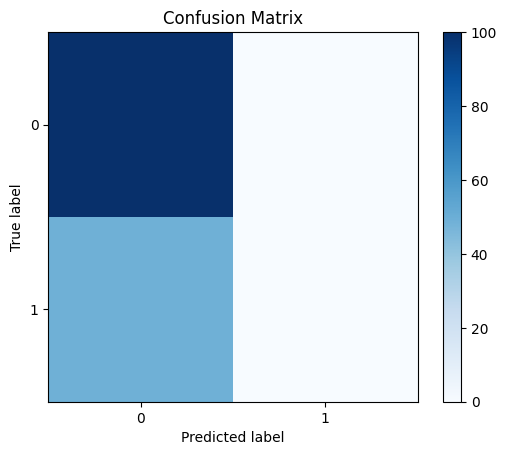

Cross Entropy for this fold: 0.6316012144088745


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.55it/s]


Training loss: 0.6660518220492772, Validation loss: 0.6509475708007812
Epoch 2/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.49it/s]


Training loss: 0.6300790650503976, Validation loss: 0.6559611757596334
Epoch 3/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.44it/s]


Training loss: 0.6141163962227958, Validation loss: 0.6562182108561198
Early stopping after 2 epochs with no improvement


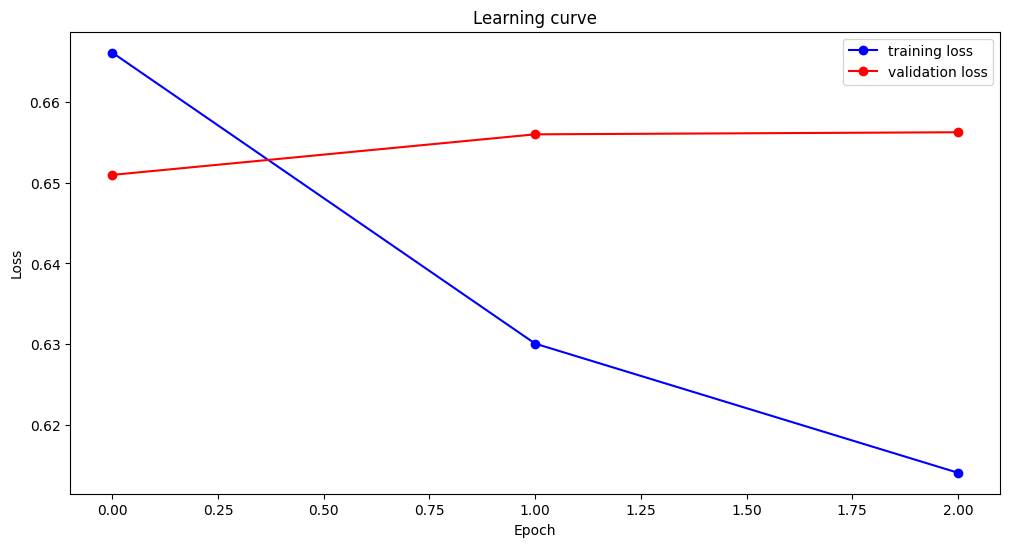

100%|██████████| 5/5 [00:01<00:00,  4.99it/s]


              precision    recall  f1-score   support

           0       0.67      1.00      0.80       100
           1       0.00      0.00      0.00        49

    accuracy                           0.67       149
   macro avg       0.34      0.50      0.40       149
weighted avg       0.45      0.67      0.54       149



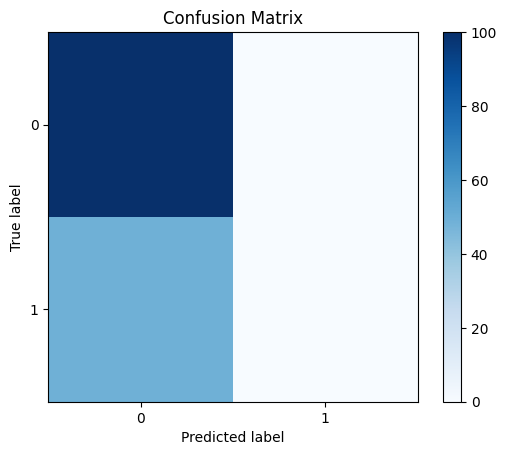

Cross Entropy for this fold: 0.6240694522857666


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 3/3 [00:00<00:00,  5.96it/s]


Training loss: 0.6605437397956848, Validation loss: 0.6691675384839376
Epoch 2/4
----------


100%|██████████| 3/3 [00:00<00:00,  6.06it/s]


Training loss: 0.6190951551709857, Validation loss: 0.6749300758043925
Epoch 3/4
----------


100%|██████████| 3/3 [00:00<00:00,  5.93it/s]


Training loss: 0.5910683103970119, Validation loss: 0.6760620872179667
Early stopping after 2 epochs with no improvement


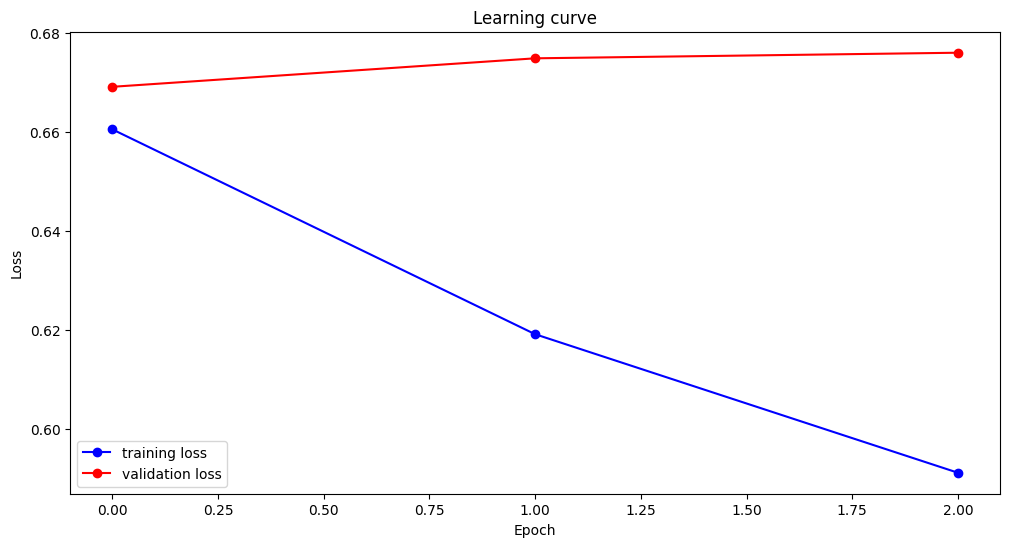

100%|██████████| 5/5 [00:00<00:00,  5.01it/s]


              precision    recall  f1-score   support

           0       0.66      1.00      0.80        99
           1       0.00      0.00      0.00        50

    accuracy                           0.66       149
   macro avg       0.33      0.50      0.40       149
weighted avg       0.44      0.66      0.53       149



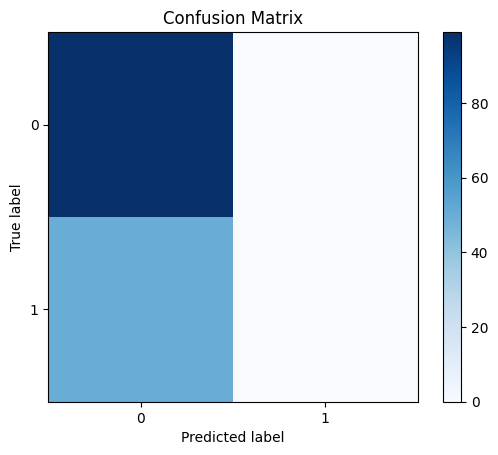

Cross Entropy for this fold: 0.6321234107017517
majority_community_2 - Average Cross Entropy: 0.6292646924654642
majority_community_2 - Average F1 Macro Score: 0.4008021332642398
Running experiment for majority_community_3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.20it/s]


Training loss: 0.7494359537959099, Validation loss: 0.6568423509597778
Epoch 2/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.33it/s]


Training loss: 0.6351992934942245, Validation loss: 0.6198335687319437
Epoch 3/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.37it/s]


Training loss: 0.5990555211901665, Validation loss: 0.6146335403124491
Epoch 4/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.11it/s]


Training loss: 0.5891461186110973, Validation loss: 0.6136955420176188


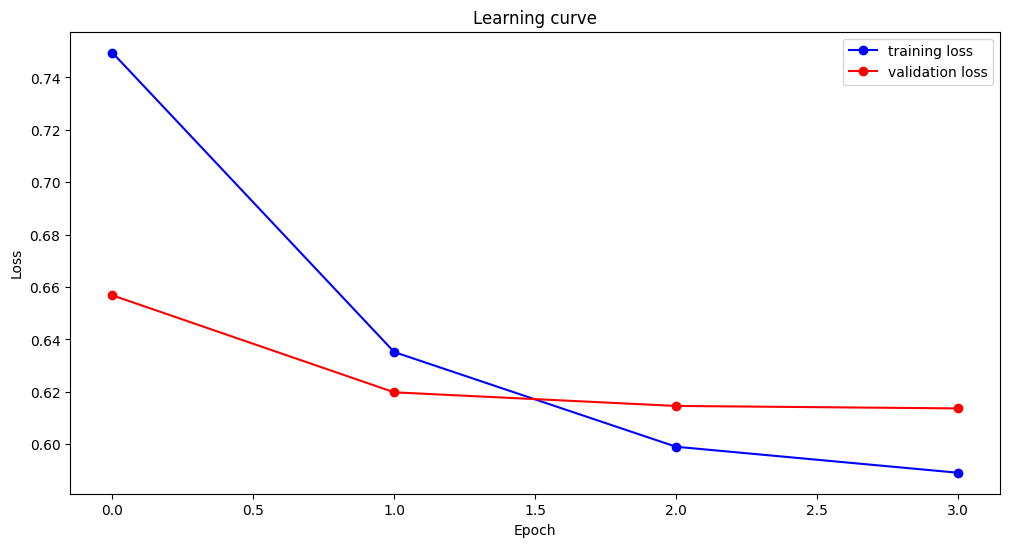

100%|██████████| 5/5 [00:00<00:00,  5.75it/s]


              precision    recall  f1-score   support

           0       0.67      1.00      0.80       103
           1       0.00      0.00      0.00        51

    accuracy                           0.67       154
   macro avg       0.33      0.50      0.40       154
weighted avg       0.45      0.67      0.54       154



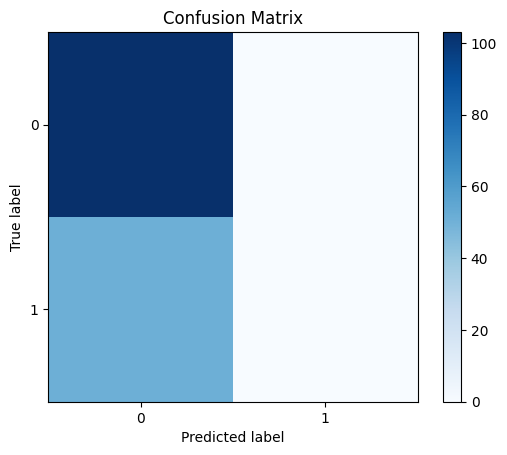

Cross Entropy for this fold: 0.6374586820602417


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.20it/s]


Training loss: 0.6659395843744278, Validation loss: 0.6306346853574117
Epoch 2/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.01it/s]


Training loss: 0.6432132571935654, Validation loss: 0.6288087566693624
Epoch 3/4
----------


100%|██████████| 3/3 [00:00<00:00,  6.96it/s]


Training loss: 0.5864537917077541, Validation loss: 0.6232325236002604
Epoch 4/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.04it/s]


Training loss: 0.5739620141685009, Validation loss: 0.6218287348747253


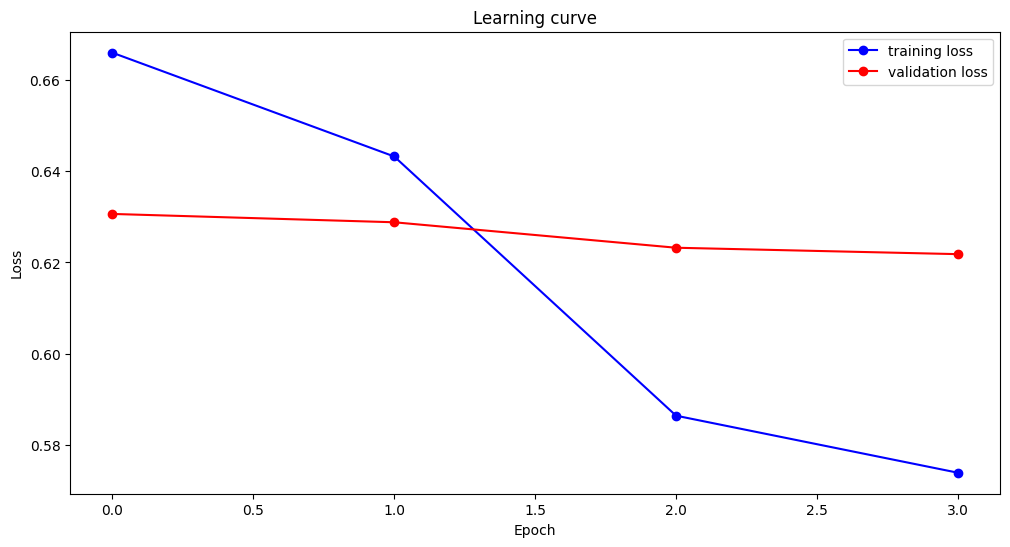

100%|██████████| 5/5 [00:00<00:00,  6.47it/s]


              precision    recall  f1-score   support

           0       0.67      1.00      0.80       102
           1       0.00      0.00      0.00        51

    accuracy                           0.67       153
   macro avg       0.33      0.50      0.40       153
weighted avg       0.44      0.67      0.53       153



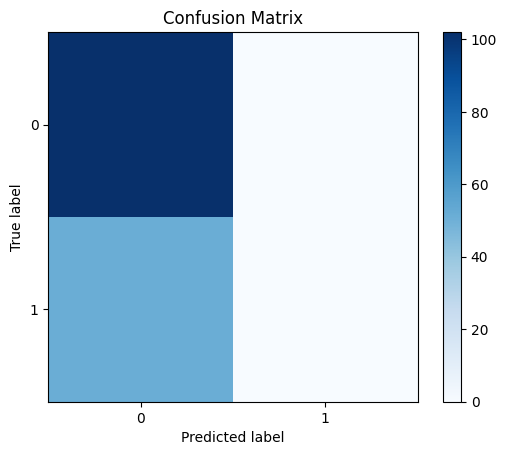

Cross Entropy for this fold: 0.6256740093231201


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.19it/s]


Training loss: 0.626817736774683, Validation loss: 0.6506338119506836
Epoch 2/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.28it/s]


Training loss: 0.5918281562626362, Validation loss: 0.6476347843805949
Epoch 3/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.31it/s]


Training loss: 0.6026058308780193, Validation loss: 0.647095779577891
Epoch 4/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.30it/s]


Training loss: 0.6100767813622952, Validation loss: 0.6453661521275839


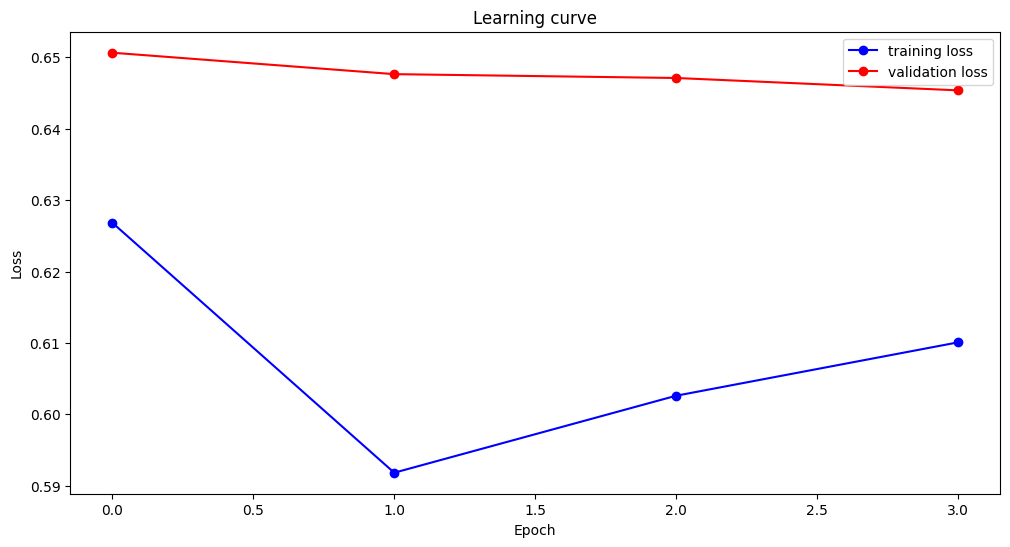

100%|██████████| 5/5 [00:00<00:00,  5.75it/s]


              precision    recall  f1-score   support

           0       0.67      1.00      0.80       103
           1       0.00      0.00      0.00        50

    accuracy                           0.67       153
   macro avg       0.34      0.50      0.40       153
weighted avg       0.45      0.67      0.54       153



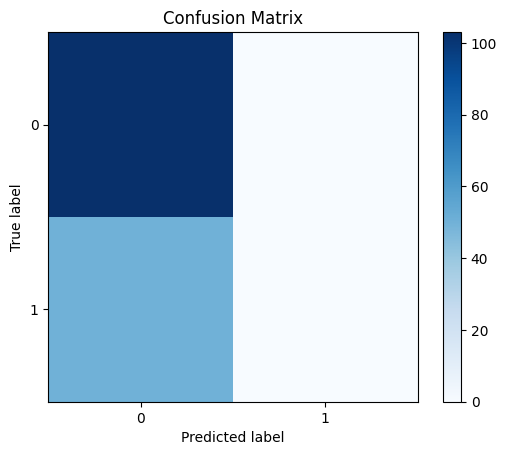

Cross Entropy for this fold: 0.6182591915130615
majority_community_3 - Average Cross Entropy: 0.6271306276321411
majority_community_3 - Average F1 Macro Score: 0.40104065337224387


In [ ]:
# Load the data
community_files = [
    "majority_community_0_data_final_md_leiden.csv",
    "majority_community_1_data_final_md_leiden.csv",
    "majority_community_2_data_final_md_leiden.csv",
    "majority_community_3_data_final_md_leiden.csv",
]
community_dfs = {f"majority_community_{i}": pd.read_csv(f"majority_community_{i}_data_final_md_leiden.csv") for i in range(len(community_files))}
combined_df = pd.read_csv("majority_combined_communities_data_final_md_leiden.csv")
combined_subset_df = pd.read_csv("majority_combined_subset_communities_data_final_md_leiden.csv")  # Load the subset combined dataset

f1_scores_dict = {}
cross_entropy_scores_dict = {}

# Run the experiment for the combined community
print("Running experiment for combined community")
community_name = "majority_combined_community"
cross_entropy, f1_macro = run_experiment_majority(combined_df, sample_frac=0.1, community_name=community_name)
f1_scores_dict[community_name] = f1_macro
cross_entropy_scores_dict[community_name] = cross_entropy

# Run the experiment for the combined subset community
print("Running experiment for combined subset community")
community_name = "majority_combined_subset_community"
cross_entropy, f1_macro = run_experiment_majority(combined_subset_df, sample_frac=0.1, community_name=community_name)
f1_scores_dict[community_name] = f1_macro
cross_entropy_scores_dict[community_name] = cross_entropy

# Run the experiment for each community
for community_name, community_df in community_dfs.items():
    print(f"Running experiment for {community_name}")
    cross_entropy, f1_macro = run_experiment_majority(community_df, sample_frac=0.1, community_name=community_name)
    f1_scores_dict[community_name] = f1_macro
    cross_entropy_scores_dict[community_name] = cross_entropy

In [ ]:
f1_scores_df = pd.DataFrame(list(f1_scores_dict.items()), columns=['Community', 'F1 Macro Score']).set_index('Community')
cross_entropy_scores_df = pd.DataFrame(list(cross_entropy_scores_dict.items()), columns=['Community', 'Cross Entropy']).set_index('Community')

In [ ]:
f1_scores_df

F1 Macro Score
Community                                         
majority_combined_community               0.446016
majority_combined_subset_community        0.410937
majority_community_0                      0.442702
majority_community_1                      0.452922
majority_community_2                      0.400802
majority_community_3                      0.401041

In [ ]:
cross_entropy_scores_df

Cross Entropy
Community                                        
majority_combined_community              0.573681
majority_combined_subset_community       0.607163
majority_community_0                     0.506126
majority_community_1                     0.630346
majority_community_2                     0.629265
majority_community_3                     0.627131

In [ ]:
# List of community names
community_names = [
    "majority_combined_community",
    "majority_combined_subset_community",
    "majority_community_0",
    "majority_community_1",
    "majority_community_2",
    "majority_community_3"
]

# Load and display incorrectly classified instances for each community
for community_name in community_names:
    # Load the incorrectly classified instances from the CSV file
    filename = f"{community_name}_incorrectly_classified_instances.csv"
    incorrectly_classified_df = pd.read_csv(filename)

    # Display the DataFrame (You can also perform any further analysis you need on this DataFrame)
    print(f"Incorrectly Classified Instances for {community_name}:")
    display(incorrectly_classified_df)


Incorrectly Classified Instances for majority_combined_community:


instance_id  offensiveness  \
0           5015              1   
1            663              1   
2           4707              1   
3          10201              1   
4           2987              1   
..           ...            ...   
318        10505              1   
319         1547              1   
320         4272              1   
321         6373              1   
322         2754              1   

                                          cleaned_text cleaned_domain  \
0                       you look feeble..:crying_face:  elections2020   
1    tax your rich friends you immoral and evil par...       covid-19   
2    white people act like jesus died and left them...            blm   
3    waiting for ‘s move. is bad for america! #trum...  elections2020   
4           morons...get your covid ... i mean koolaid       covid-19   
..                                                 ...            ...   
318  plus some of you are going to die. coronavirus...       covid-19   
319  hehehe pence is very dirty hands he used it in...       covid-19   
320  so this racist, soulless mother fucker knew ex...       covid-19   
321  the goal should be to have a plan to kill covi...       covid-19   
322  black lives matter we stand with our islamic b...  elections2020   

                                      text_with_domain  predicted_label  \
0         elections2020 you look feeble..:crying_face:                0   
1    covid-19 tax your rich friends you immoral and...                0   
2    blm white people act like jesus died and left ...                0   
3    elections2020 waiting for ‘s move. is bad for ...                0   
4    covid-19 morons...get your covid ... i mean ko...                0   
..                                                 ...              ...   
318  covid-19 plus some of you are going to die. co...                0   
319  covid-19 hehehe pence is very dirty hands he u...                0   
320  covid-19 so this racist, soulless mother fucke...                0   
321  covid-19 the goal should be to have a plan to ...                0   
322  elections2020 black lives matter we stand with...                0   

     true_label  cross_entropy  
0             1       0.914206  
1             1       1.064859  
2             1       1.563264  
3             1       1.413870  
4             1       1.076663  
..          ...            ...  
318           1       1.125340  
319           1       1.192761  
320           1       1.343255  
321           1       1.150213  
322           1       1.302796  

[323 rows x 8 columns]

Incorrectly Classified Instances for majority_combined_subset_community:


instance_id  offensiveness  \
0            586              1   
1           5509              1   
2           3550              1   
3           8769              1   
4          10734              1   
..           ...            ...   
122         7718              1   
123          179              1   
124         7371              1   
125         1095              1   
126        10553              1   

                                          cleaned_text cleaned_domain  \
0                    hitler staches are chill says cdc       covid-19   
1    "why yes yes jed, afeared it is dem same lunat...  elections2020   
2    you will go down in history as the most corrup...  elections2020   
3           you will not be president. treasonous dog.  elections2020   
4                         ok white privileged bunghole            blm   
..                                                 ...            ...   
122  democrats press dhs over use of drone during m...            blm   
123  i do not want to go out ever again jesus you a...       covid-19   
124        spoken like a true blue crooked politician!  elections2020   
125  they took the grandma down at the end are you ...            blm   
126  to whom it may concern, due to your #unscienti...       covid-19   

                                      text_with_domain  predicted_label  \
0           covid-19 hitler staches are chill says cdc                0   
1    elections2020 "why yes yes jed, afeared it is ...                0   
2    elections2020 you will go down in history as t...                0   
3    elections2020 you will not be president. treas...                0   
4                     blm ok white privileged bunghole                0   
..                                                 ...              ...   
122  blm democrats press dhs over use of drone duri...                0   
123  covid-19 i do not want to go out ever again je...                0   
124  elections2020 spoken like a true blue crooked ...                0   
125  blm they took the grandma down at the end are ...                0   
126  covid-19 to whom it may concern, due to your #...                0   

     true_label  cross_entropy  
0             1       1.486651  
1             1       1.369560  
2             1       1.210585  
3             1       1.312304  
4             1       1.131360  
..          ...            ...  
122           1       1.418325  
123           1       1.165582  
124           1       1.293355  
125           1       1.247775  
126           1       1.301093  

[127 rows x 8 columns]

Incorrectly Classified Instances for majority_community_0:


instance_id  offensiveness  \
0          5085              1   
1          4680              1   
2          1529              1   
3          7294              1   
4          8074              1   
..          ...            ...   
68         6877              1   
69         5809              1   
70         3674              1   
71          174              1   
72        10134              1   

                                         cleaned_text cleaned_domain  \
0                   shut up and write better columns.       covid-19   
1   enough of this bogus coronavirus bullshit. nc ...            blm   
2   this is why you are an idiot as i said before....  elections2020   
3   >146,000 people are needlessly dead from your ...       covid-19   
4   heard earlier today the moron kneeling was fir...            blm   
..                                                ...            ...   
68       my brother died of covid! you are the loser!       covid-19   
69  and then there is this #whiteguilt piece from ...            blm   
70  f*ck those guys #black_lives_matter and i thin...            blm   
71  we are no longer mailing our ballots. hand del...  elections2020   
72                                   this shit crazy.            blm   

                                     text_with_domain  predicted_label  \
0          covid-19 shut up and write better columns.                0   
1   blm enough of this bogus coronavirus bullshit....                0   
2   elections2020 this is why you are an idiot as ...                0   
3   covid-19 >146,000 people are needlessly dead f...                0   
4   blm heard earlier today the moron kneeling was...                0   
..                                                ...              ...   
68  covid-19 my brother died of covid! you are the...                0   
69  blm and then there is this #whiteguilt piece f...                0   
70  blm f*ck those guys #black_lives_matter and i ...                0   
71  elections2020 we are no longer mailing our bal...                0   
72                               blm this shit crazy.                0   

    true_label  cross_entropy  
0            1       1.365943  
1            1       1.706690  
2            1       1.243494  
3            1       1.606984  
4            1       1.824122  
..         ...            ...  
68           1       1.638686  
69           1       1.824790  
70           1       1.701928  
71           1       1.530922  
72           1       1.557691  

[73 rows x 8 columns]

Incorrectly Classified Instances for majority_community_1:


instance_id  offensiveness  \
0            942              1   
1           1756              1   
2           2483              1   
3           1509              1   
4           2917              1   
..           ...            ...   
142         6051              1   
143         1411              1   
144         1578              1   
145          182              1   
146          162              0   

                                          cleaned_text cleaned_domain  \
0    daily reminder that trump is a dumbass and has...            blm   
1    we all bleed the same fucking blood & who tf m...            blm   
2    delusional pathological narcissist says what? ...  elections2020   
3    this is america. rioting no law order because ...  elections2020   
4    he did this to other white people he really ra...            blm   
..                                                 ...            ...   
142  that is, if you are an intolerant, weak minded...  elections2020   
143  a lot of american citizens are unified and tak...            blm   
144     that is more kinds of stupid than i can count.       covid-19   
145  the kkk racist democrats ride for their white ...  elections2020   
146                 look at all those people for trump  elections2020   

                                      text_with_domain  predicted_label  \
0    blm daily reminder that trump is a dumbass and...                0   
1    blm we all bleed the same fucking blood & who ...                0   
2    elections2020 delusional pathological narcissi...                0   
3    elections2020 this is america. rioting no law ...                0   
4    blm he did this to other white people he reall...                0   
..                                                 ...              ...   
142  elections2020 that is, if you are an intoleran...                0   
143  blm a lot of american citizens are unified and...                0   
144  covid-19 that is more kinds of stupid than i c...                0   
145  elections2020 the kkk racist democrats ride fo...                0   
146   elections2020 look at all those people for trump                1   

     true_label  cross_entropy  
0             1       1.184544  
1             1       1.320516  
2             1       0.915267  
3             1       1.156273  
4             1       1.032781  
..          ...            ...  
142           1       0.777881  
143           1       0.887164  
144           1       0.902950  
145           1       1.087430  
146           0       0.746919  

[147 rows x 8 columns]

Incorrectly Classified Instances for majority_community_2:


instance_id  offensiveness  \
0           8974              1   
1           5895              1   
2           3443              1   
3          10327              1   
4           5410              1   
..           ...            ...   
143         4755              1   
144         9476              1   
145         3535              1   
146         4042              1   
147         9469              1   

                                          cleaned_text cleaned_domain  \
0                    an atheist jew named george soros  elections2020   
1    scare tactic again, read the headlines!!! poss...       covid-19   
2                    my pussy will never be this good.       covid-19   
3    dear while i appreciate your attempt to call o...       covid-19   
4                                      america is hell       covid-19   
..                                                 ...            ...   
143  she looks terrible. i thought for a moment tha...  elections2020   
144  idiots! it is not a threat! after exerting mys...  elections2020   
145  crusty old bigots crying that their last basti...            blm   
146                                         fuck biden  elections2020   
147  well they will when the results come in, or th...  elections2020   

                                      text_with_domain  predicted_label  \
0      elections2020 an atheist jew named george soros                0   
1    covid-19 scare tactic again, read the headline...                0   
2           covid-19 my pussy will never be this good.                0   
3    covid-19 dear while i appreciate your attempt ...                0   
4                             covid-19 america is hell                0   
..                                                 ...              ...   
143  elections2020 she looks terrible. i thought fo...                0   
144  elections2020 idiots! it is not a threat! afte...                0   
145  blm crusty old bigots crying that their last b...                0   
146                           elections2020 fuck biden                0   
147  elections2020 well they will when the results ...                0   

     true_label  cross_entropy  
0             1       1.054142  
1             1       1.241743  
2             1       1.489907  
3             1       1.227146  
4             1       1.373338  
..          ...            ...  
143           1       1.053799  
144           1       1.084290  
145           1       1.060104  
146           1       1.068459  
147           1       1.027296  

[148 rows x 8 columns]

Incorrectly Classified Instances for majority_community_3:


instance_id  offensiveness  \
0           9471              1   
1            150              1   
2            349              1   
3           4115              1   
4           7046              1   
..           ...            ...   
147          602              1   
148         7209              1   
149         6260              1   
150         2257              1   
151         4444              1   

                                          cleaned_text cleaned_domain  \
0    fucking cops. they pound peaceful protesters a...       covid-19   
1    and then continue legislative constipation bec...  elections2020   
2    in trumps own words. the only racist on the st...  elections2020   
3    does meeting with, and praising, anti - semite...  elections2020   
4    i am watching this trump sh*tshow. he is the m...       covid-19   
..                                                 ...            ...   
147  first they are rapists and criminals, now they...       covid-19   
148  #gopdeathcult aiding and abetting #traitortrum...       covid-19   
149  i have a confession to make. since the lockdow...       covid-19   
150  silence is complicit. you are the douchebag yo...            blm   
151  you are the biggest dork i have ever seen. it ...  elections2020   

                                      text_with_domain  predicted_label  \
0    covid-19 fucking cops. they pound peaceful pro...                0   
1    elections2020 and then continue legislative co...                0   
2    elections2020 in trumps own words. the only ra...                0   
3    elections2020 does meeting with, and praising,...                0   
4    covid-19 i am watching this trump sh*tshow. he...                0   
..                                                 ...              ...   
147  covid-19 first they are rapists and criminals,...                0   
148  covid-19 #gopdeathcult aiding and abetting #tr...                0   
149  covid-19 i have a confession to make. since th...                0   
150  blm silence is complicit. you are the doucheba...                0   
151  elections2020 you are the biggest dork i have ...                0   

     true_label  cross_entropy  
0             1       1.460483  
1             1       1.517226  
2             1       1.098014  
3             1       0.988608  
4             1       1.031175  
..          ...            ...  
147           1       0.943244  
148           1       1.046176  
149           1       1.179853  
150           1       1.064017  
151           1       1.022708  

[152 rows x 8 columns]

2) Using BERT

Running experiment for combined community


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 6/6 [00:00<00:00,  6.45it/s]


Training loss: 0.6475402642698849, Validation loss: 0.614801824092865
Epoch 2/4
----------


100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


Training loss: 0.606930664357017, Validation loss: 0.6030929783980051
Epoch 3/4
----------


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


Training loss: 0.5833604563685024, Validation loss: 0.5897273321946462
Epoch 4/4
----------


100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


Training loss: 0.5479717324761784, Validation loss: 0.5837323864301046


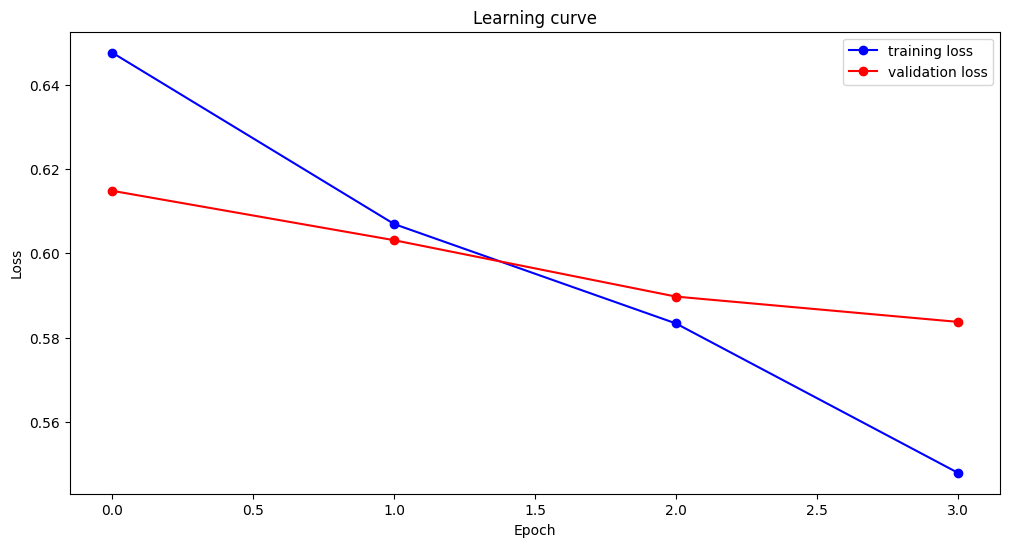

100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


              precision    recall  f1-score   support

           0       0.70      1.00      0.82       252
           1       0.00      0.00      0.00       107

    accuracy                           0.70       359
   macro avg       0.35      0.50      0.41       359
weighted avg       0.49      0.70      0.58       359



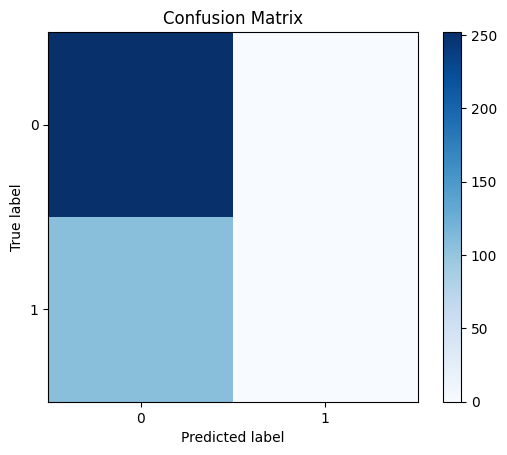

Cross Entropy for this fold: 0.5968212485313416


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 6/6 [00:01<00:00,  5.18it/s]


Training loss: 0.619186471490299, Validation loss: 0.6159426669279734
Epoch 2/4
----------


100%|██████████| 6/6 [00:01<00:00,  5.16it/s]


Training loss: 0.5910065174102783, Validation loss: 0.5866033732891083
Epoch 3/4
----------


100%|██████████| 6/6 [00:01<00:00,  5.21it/s]


Training loss: 0.5450476600843317, Validation loss: 0.5802199294169744
Epoch 4/4
----------


100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


Training loss: 0.5035148894085604, Validation loss: 0.5592317978541056


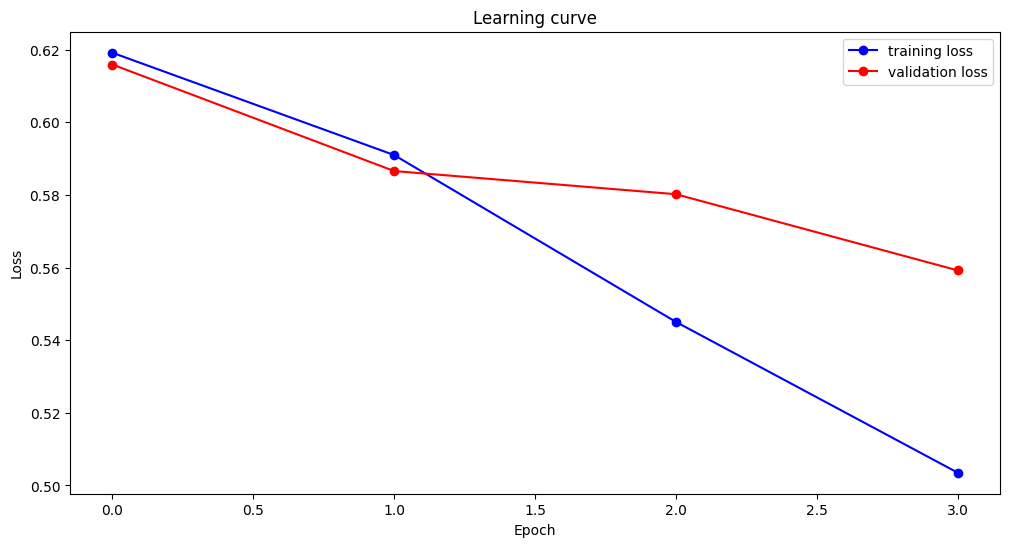

100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


              precision    recall  f1-score   support

           0       0.77      0.88      0.82       252
           1       0.57      0.37      0.45       106

    accuracy                           0.73       358
   macro avg       0.67      0.63      0.64       358
weighted avg       0.71      0.73      0.71       358



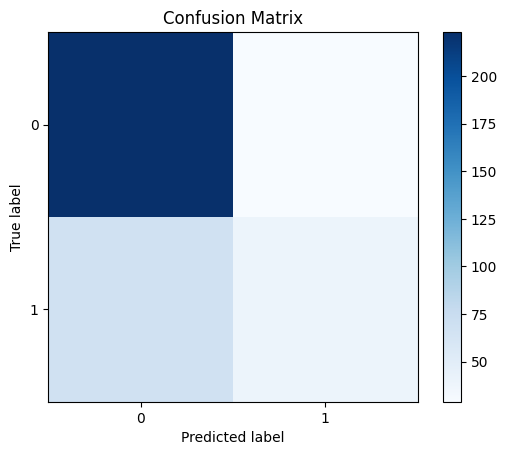

Cross Entropy for this fold: 0.5504279732704163


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 6/6 [00:01<00:00,  5.07it/s]


Training loss: 0.6680329932886011, Validation loss: 0.6125284135341644
Epoch 2/4
----------


100%|██████████| 6/6 [00:01<00:00,  5.02it/s]


Training loss: 0.6013548917630139, Validation loss: 0.5982145766417185
Epoch 3/4
----------


100%|██████████| 6/6 [00:01<00:00,  5.02it/s]


Training loss: 0.5748121791026172, Validation loss: 0.5895177920659384
Epoch 4/4
----------


100%|██████████| 6/6 [00:01<00:00,  5.02it/s]


Training loss: 0.554375385536867, Validation loss: 0.5858645141124725


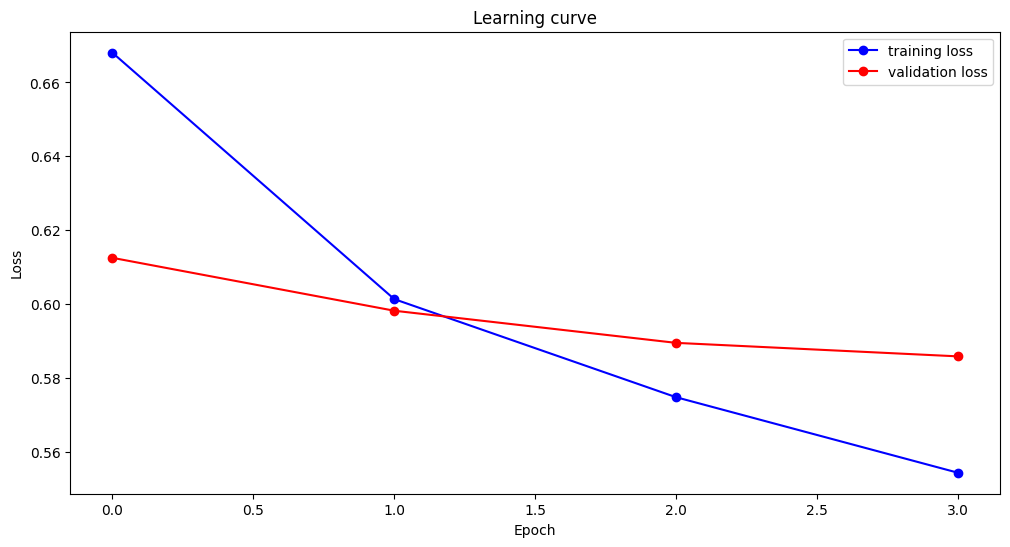

100%|██████████| 12/12 [00:01<00:00,  7.00it/s]


              precision    recall  f1-score   support

           0       0.70      1.00      0.82       251
           1       0.00      0.00      0.00       107

    accuracy                           0.70       358
   macro avg       0.35      0.50      0.41       358
weighted avg       0.49      0.70      0.58       358



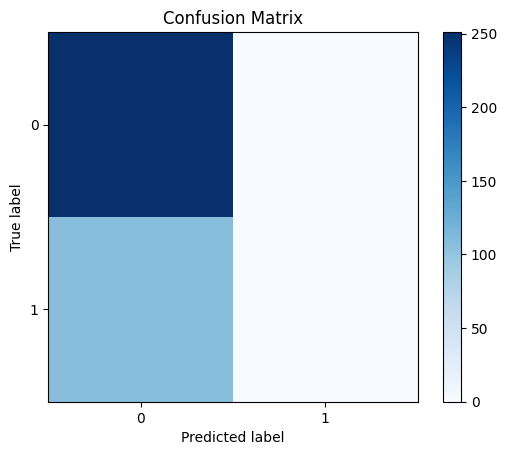

Cross Entropy for this fold: 0.5786934494972229
majority_combined_community - Average Cross Entropy: 0.5753142237663269
majority_combined_community - Average F1 Macro Score: 0.4867222459845635
Running experiment for combined subset community


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.87it/s]


Training loss: 0.6501227276665824, Validation loss: 0.5645904242992401
Epoch 2/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.89it/s]


Training loss: 0.594558128288814, Validation loss: 0.557452787955602
Epoch 3/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.99it/s]


Training loss: 0.5763107878821236, Validation loss: 0.5546263555685679
Epoch 4/4
----------


100%|██████████| 3/3 [00:00<00:00,  8.05it/s]


Training loss: 0.5970347736563001, Validation loss: 0.5523772736390432


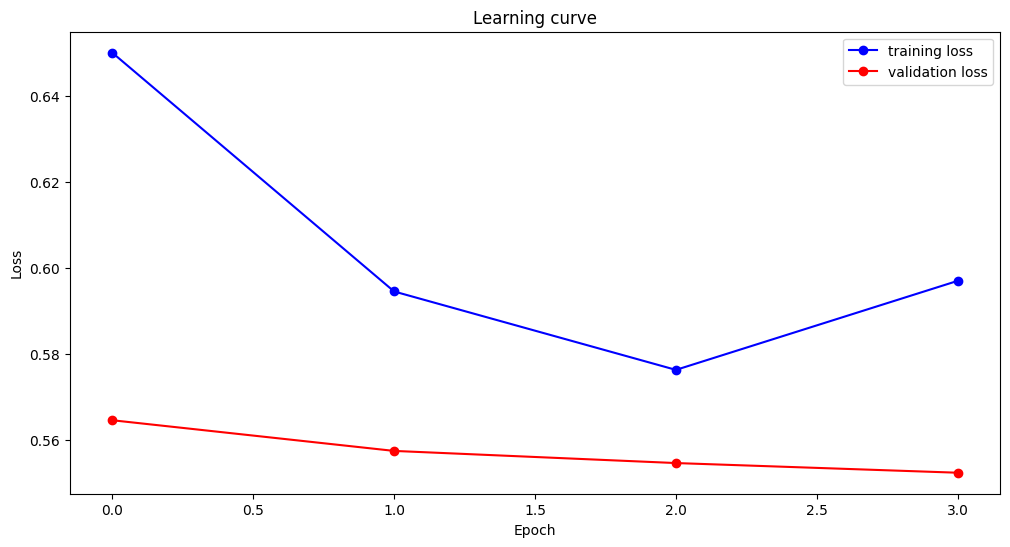

100%|██████████| 5/5 [00:00<00:00,  5.35it/s]


              precision    recall  f1-score   support

           0       0.69      1.00      0.82        97
           1       0.00      0.00      0.00        43

    accuracy                           0.69       140
   macro avg       0.35      0.50      0.41       140
weighted avg       0.48      0.69      0.57       140



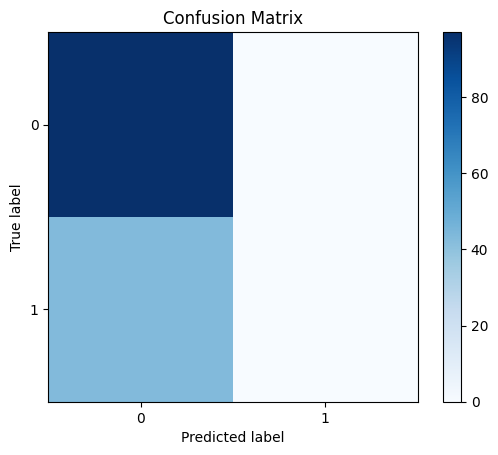

Cross Entropy for this fold: 0.6131391525268555


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.90it/s]


Training loss: 0.6516574621200562, Validation loss: 0.579928865035375
Epoch 2/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.64it/s]


Training loss: 0.6299574375152588, Validation loss: 0.5883639256159464
Epoch 3/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.67it/s]


Training loss: 0.6142965597765786, Validation loss: 0.5790502727031708
Epoch 4/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.74it/s]


Training loss: 0.5967147435460772, Validation loss: 0.5755325059096018


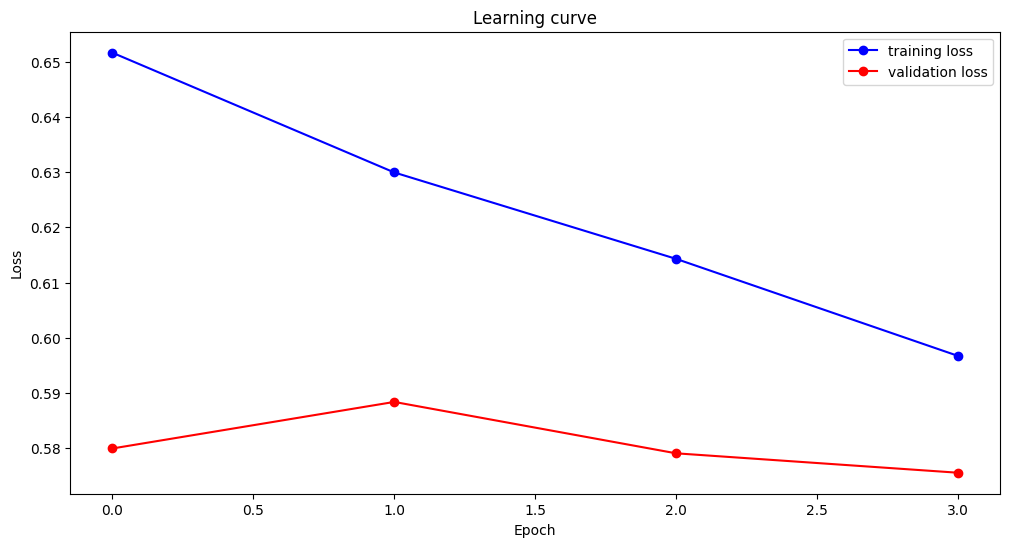

100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


              precision    recall  f1-score   support

           0       0.70      1.00      0.82        98
           1       0.00      0.00      0.00        42

    accuracy                           0.70       140
   macro avg       0.35      0.50      0.41       140
weighted avg       0.49      0.70      0.58       140



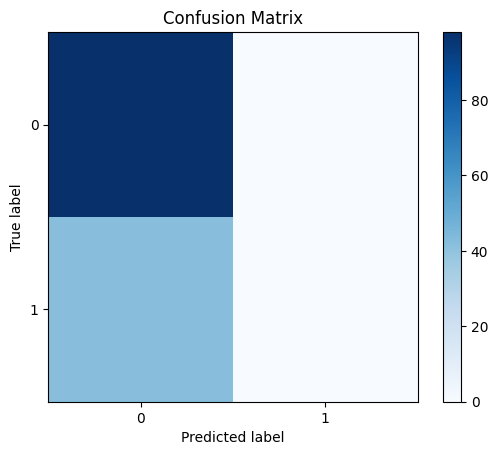

Cross Entropy for this fold: 0.6085497140884399


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 3/3 [00:00<00:00, 10.01it/s]


Training loss: 0.6298971005848476, Validation loss: 0.5983851750691732
Epoch 2/4
----------


100%|██████████| 3/3 [00:00<00:00, 10.18it/s]


Training loss: 0.5757556472505841, Validation loss: 0.5887115796407064
Epoch 3/4
----------


100%|██████████| 3/3 [00:00<00:00, 10.33it/s]


Training loss: 0.5274233051708767, Validation loss: 0.6028641064961752
Epoch 4/4
----------


100%|██████████| 3/3 [00:00<00:00, 10.18it/s]


Training loss: 0.48394571457590374, Validation loss: 0.598639706770579
Early stopping after 2 epochs with no improvement


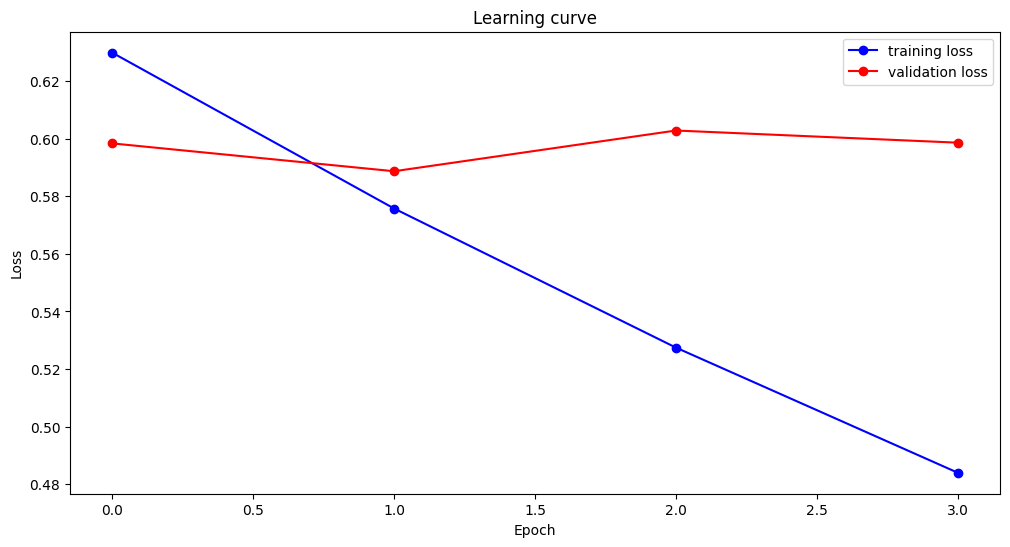

100%|██████████| 5/5 [00:00<00:00,  6.77it/s]


              precision    recall  f1-score   support

           0       0.71      1.00      0.83        98
           1       1.00      0.05      0.09        42

    accuracy                           0.71       140
   macro avg       0.86      0.52      0.46       140
weighted avg       0.80      0.71      0.61       140



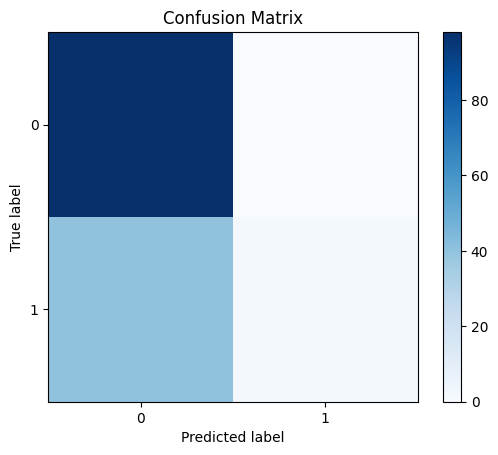

Cross Entropy for this fold: 0.5912621021270752
majority_combined_subset_community - Average Cross Entropy: 0.6043169895807902
majority_combined_subset_community - Average F1 Macro Score: 0.42725206301565827
Running experiment for majority_community_0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 2/2 [00:00<00:00,  5.39it/s]


Training loss: 0.6405414938926697, Validation loss: 0.5502898395061493
Epoch 2/4
----------


100%|██████████| 2/2 [00:00<00:00,  5.34it/s]


Training loss: 0.5464402238527933, Validation loss: 0.5230828076601028
Epoch 3/4
----------


100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


Training loss: 0.49113793671131134, Validation loss: 0.5171986222267151
Epoch 4/4
----------


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


Training loss: 0.5172808070977529, Validation loss: 0.5165399760007858


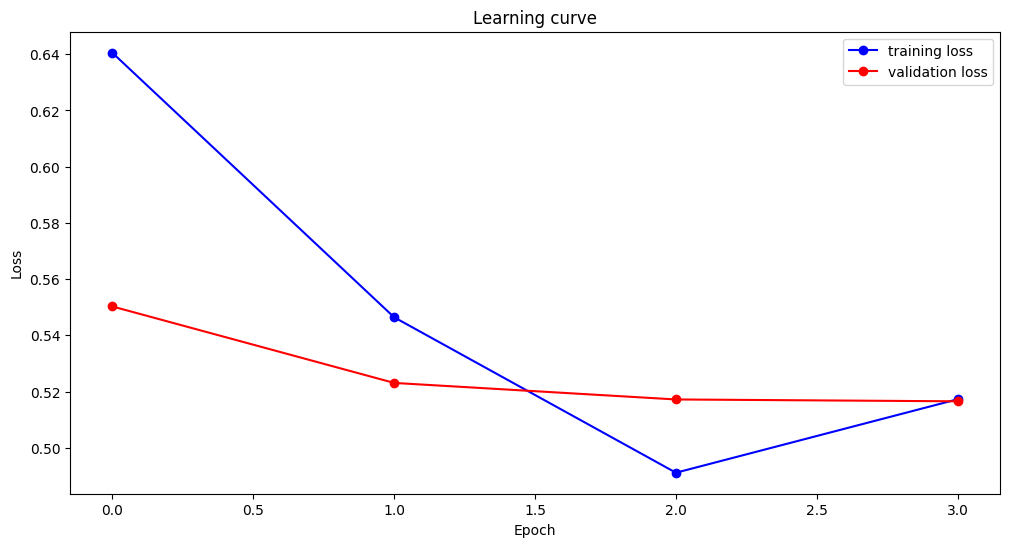

100%|██████████| 4/4 [00:00<00:00,  6.20it/s]


              precision    recall  f1-score   support

           0       0.79      1.00      0.88        94
           1       0.00      0.00      0.00        25

    accuracy                           0.79       119
   macro avg       0.39      0.50      0.44       119
weighted avg       0.62      0.79      0.70       119



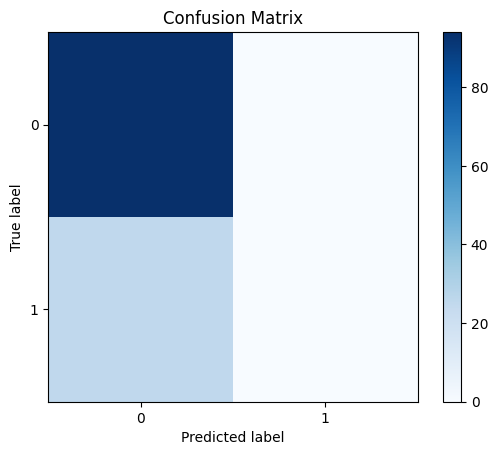

Cross Entropy for this fold: 0.5102850794792175


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 2/2 [00:00<00:00,  7.05it/s]


Training loss: 0.5118691275517145, Validation loss: 0.5061714947223663
Epoch 2/4
----------


100%|██████████| 2/2 [00:00<00:00,  7.12it/s]


Training loss: 0.5088031540314356, Validation loss: 0.5043741911649704
Epoch 3/4
----------


100%|██████████| 2/2 [00:00<00:00,  7.07it/s]


Training loss: 0.44986916581789654, Validation loss: 0.5153830945491791
Epoch 4/4
----------


100%|██████████| 2/2 [00:00<00:00,  6.83it/s]


Training loss: 0.4319542149702708, Validation loss: 0.5188006311655045
Early stopping after 2 epochs with no improvement


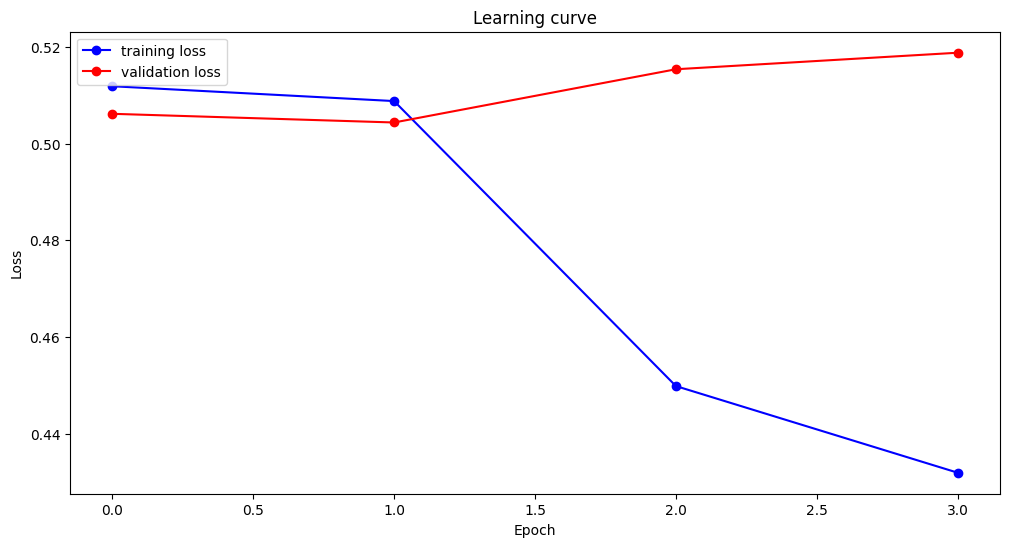

100%|██████████| 4/4 [00:00<00:00,  6.25it/s]


              precision    recall  f1-score   support

           0       0.80      1.00      0.89        94
           1       0.00      0.00      0.00        24

    accuracy                           0.80       118
   macro avg       0.40      0.50      0.44       118
weighted avg       0.63      0.80      0.71       118



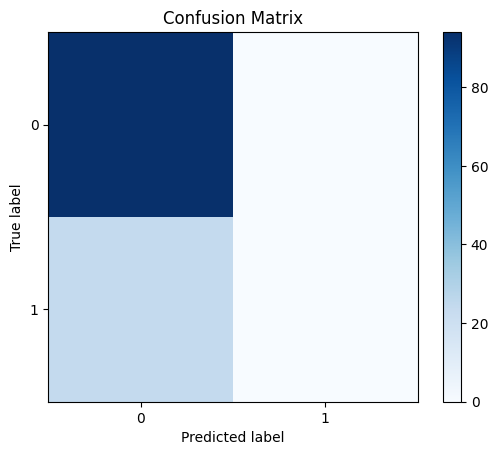

Cross Entropy for this fold: 0.5081413984298706


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 2/2 [00:00<00:00,  6.66it/s]


Training loss: 0.5507856160402298, Validation loss: 0.5039257407188416
Epoch 2/4
----------


100%|██████████| 2/2 [00:00<00:00,  6.28it/s]


Training loss: 0.48373041798671085, Validation loss: 0.5022137612104416
Epoch 3/4
----------


100%|██████████| 2/2 [00:00<00:00,  6.95it/s]


Training loss: 0.48450447122255963, Validation loss: 0.5011475533246994
Epoch 4/4
----------


100%|██████████| 2/2 [00:00<00:00,  6.95it/s]


Training loss: 0.4655433197816213, Validation loss: 0.5005647242069244


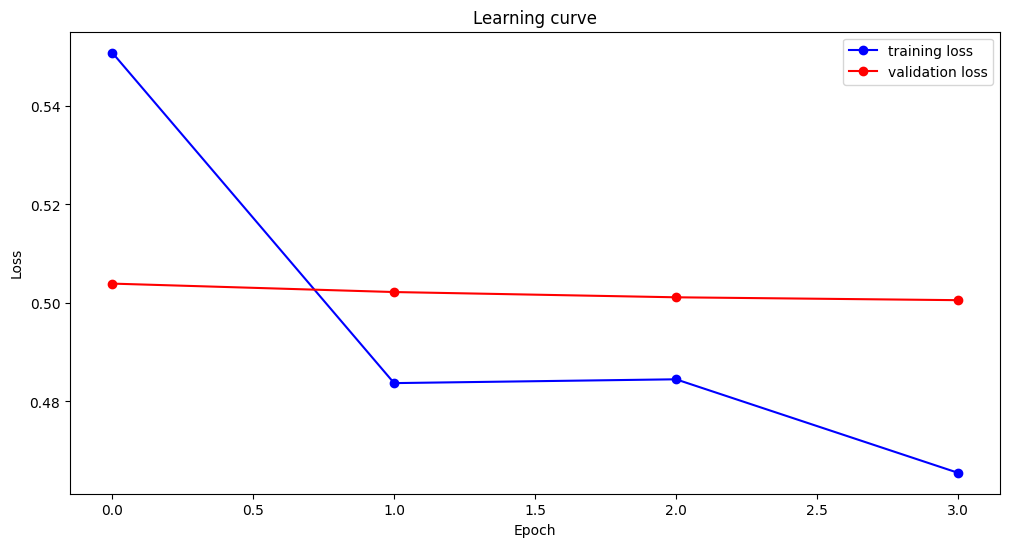

100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


              precision    recall  f1-score   support

           0       0.80      1.00      0.89        94
           1       0.00      0.00      0.00        24

    accuracy                           0.80       118
   macro avg       0.40      0.50      0.44       118
weighted avg       0.63      0.80      0.71       118



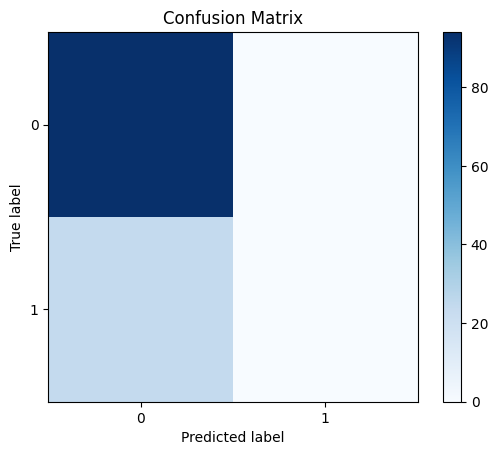

Cross Entropy for this fold: 0.5032414197921753
majority_community_0 - Average Cross Entropy: 0.5072226325670878
majority_community_0 - Average F1 Macro Score: 0.442702335606933
Running experiment for majority_community_1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 3/3 [00:00<00:00,  8.03it/s]


Training loss: 0.6590656808444432, Validation loss: 0.6344184478123983
Epoch 2/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.90it/s]


Training loss: 0.6301241176468986, Validation loss: 0.6054428021113077
Epoch 3/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.96it/s]


Training loss: 0.596066313130515, Validation loss: 0.5929352442423502
Epoch 4/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.75it/s]


Training loss: 0.5663080215454102, Validation loss: 0.5892881552378336


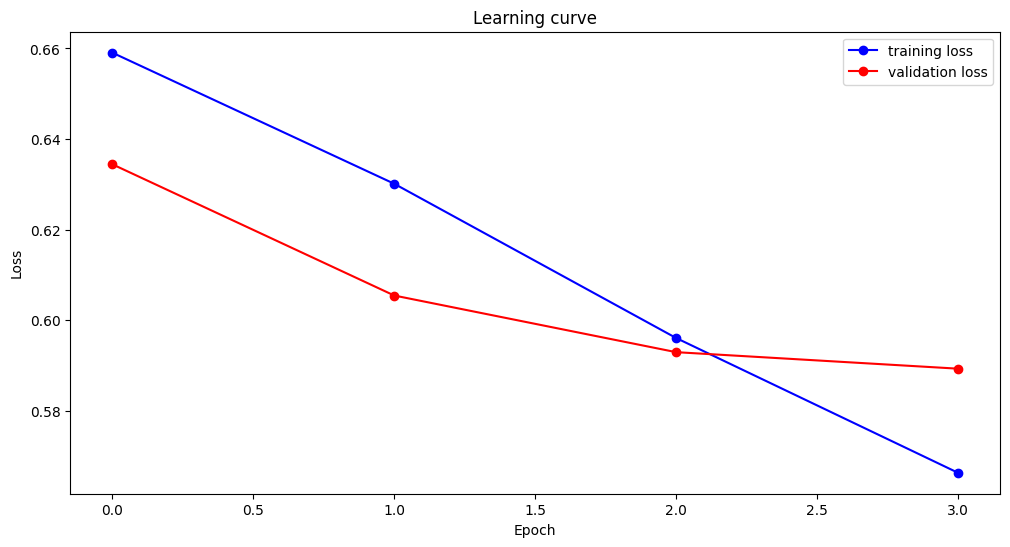

100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


              precision    recall  f1-score   support

           0       0.66      0.97      0.79        90
           1       0.73      0.15      0.25        52

    accuracy                           0.67       142
   macro avg       0.70      0.56      0.52       142
weighted avg       0.69      0.67      0.59       142



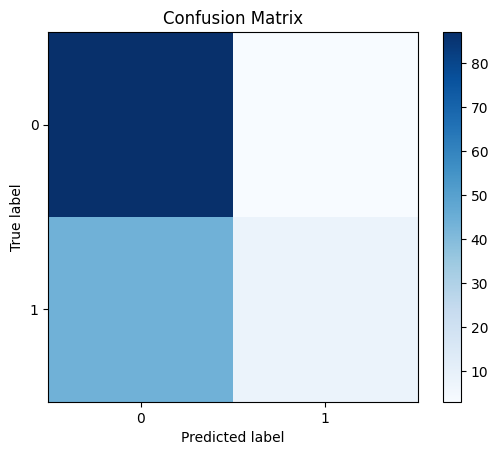

Cross Entropy for this fold: 0.6226130127906799


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 3/3 [00:00<00:00,  6.14it/s]


Training loss: 0.7171733805111477, Validation loss: 0.6593256592750549
Epoch 2/4
----------


100%|██████████| 3/3 [00:00<00:00,  6.15it/s]


Training loss: 0.6663609317370823, Validation loss: 0.6571990251541138
Epoch 3/4
----------


100%|██████████| 3/3 [00:00<00:00,  6.13it/s]


Training loss: 0.5910405261175973, Validation loss: 0.6569781104723612
Epoch 4/4
----------


100%|██████████| 3/3 [00:00<00:00,  6.20it/s]


Training loss: 0.6018115878105164, Validation loss: 0.6569280425707499


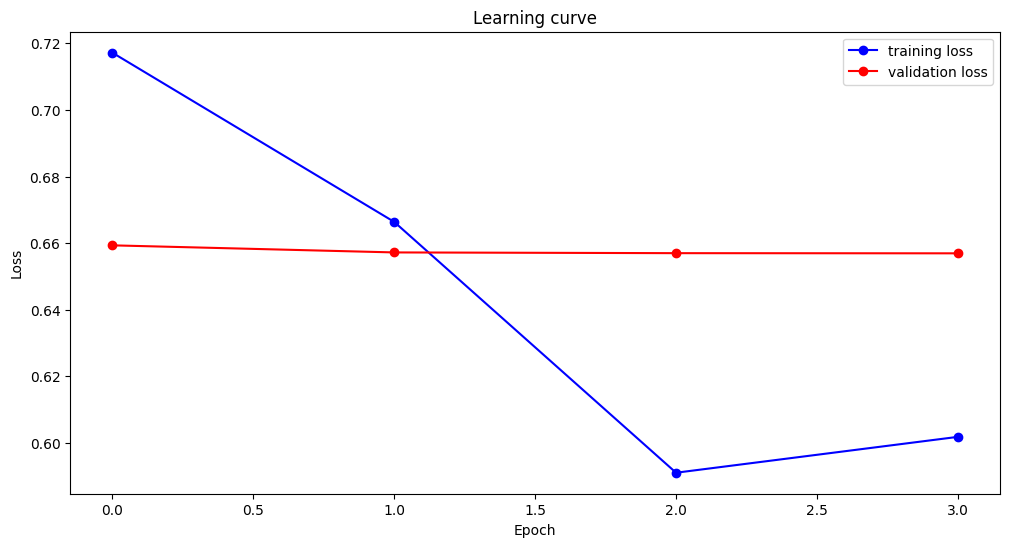

100%|██████████| 5/5 [00:00<00:00,  6.22it/s]


              precision    recall  f1-score   support

           0       0.65      1.00      0.79        91
           1       1.00      0.06      0.11        51

    accuracy                           0.66       142
   macro avg       0.83      0.53      0.45       142
weighted avg       0.78      0.66      0.55       142



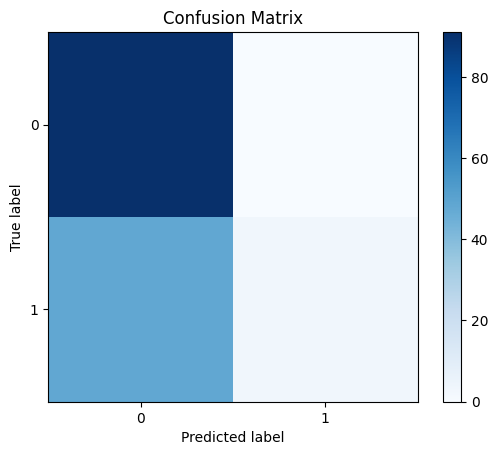

Cross Entropy for this fold: 0.6043040156364441


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 3/3 [00:00<00:00, 10.00it/s]


Training loss: 0.6460664612906319, Validation loss: 0.6445422967274984
Epoch 2/4
----------


100%|██████████| 3/3 [00:00<00:00, 10.10it/s]


Training loss: 0.6021059453487396, Validation loss: 0.6343066294987997
Epoch 3/4
----------


100%|██████████| 3/3 [00:00<00:00, 10.26it/s]


Training loss: 0.5752259748322623, Validation loss: 0.6361198027928671
Epoch 4/4
----------


100%|██████████| 3/3 [00:00<00:00, 10.19it/s]


Training loss: 0.5346372553280422, Validation loss: 0.6366452177365621
Early stopping after 2 epochs with no improvement


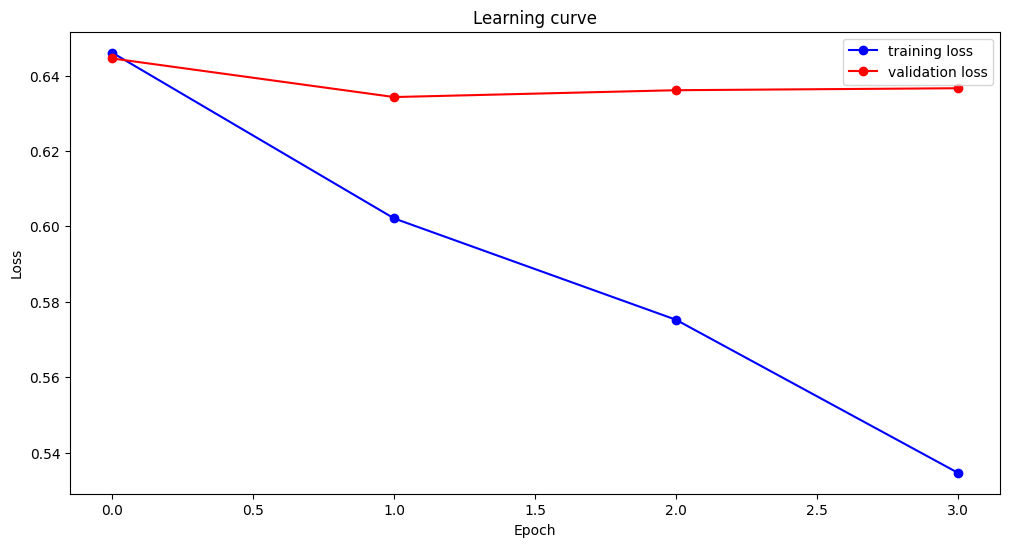

100%|██████████| 5/5 [00:00<00:00,  7.02it/s]


              precision    recall  f1-score   support

           0       0.68      0.81      0.74        91
           1       0.48      0.31      0.38        51

    accuracy                           0.63       142
   macro avg       0.58      0.56      0.56       142
weighted avg       0.61      0.63      0.61       142



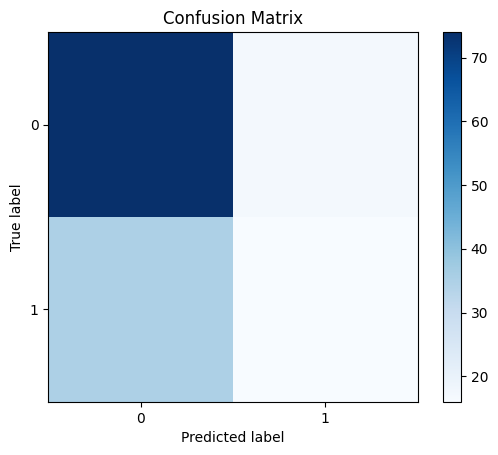

Cross Entropy for this fold: 0.6253306865692139
majority_community_1 - Average Cross Entropy: 0.6174159049987793
majority_community_1 - Average F1 Macro Score: 0.5107777350999858
Running experiment for majority_community_2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.94it/s]


Training loss: 0.648682985986982, Validation loss: 0.6396342317263285
Epoch 2/4
----------


100%|██████████| 3/3 [00:00<00:00,  8.09it/s]


Training loss: 0.6055076037134443, Validation loss: 0.6310641566912333
Epoch 3/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.98it/s]


Training loss: 0.5883598455360958, Validation loss: 0.6279551188151041
Epoch 4/4
----------


100%|██████████| 3/3 [00:00<00:00,  8.16it/s]


Training loss: 0.5726075598171779, Validation loss: 0.6253363092740377


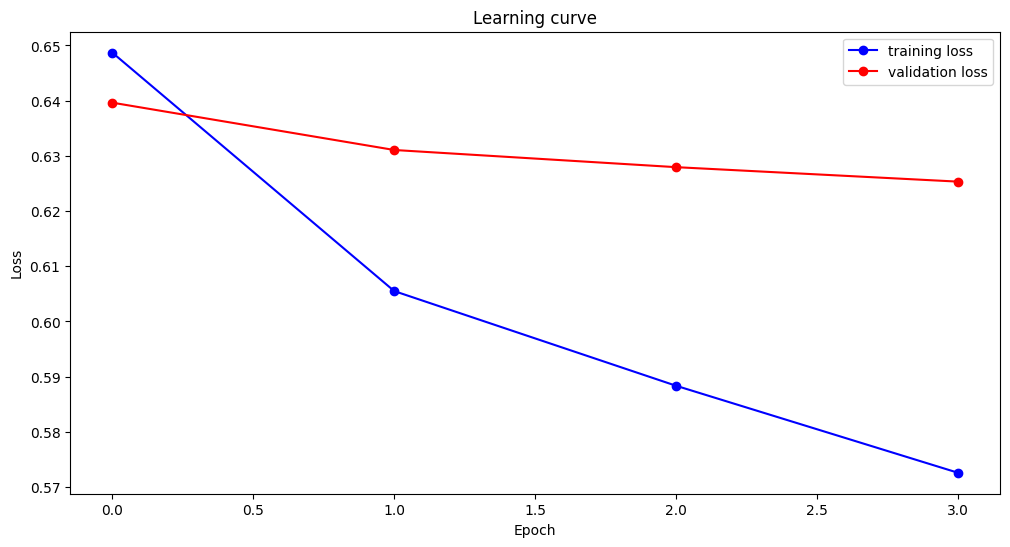

100%|██████████| 5/5 [00:00<00:00,  5.30it/s]


              precision    recall  f1-score   support

           0       0.67      1.00      0.80       100
           1       0.00      0.00      0.00        49

    accuracy                           0.67       149
   macro avg       0.34      0.50      0.40       149
weighted avg       0.45      0.67      0.54       149



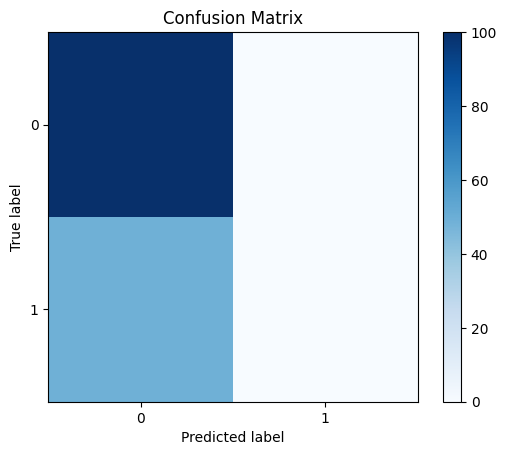

Cross Entropy for this fold: 0.6361180543899536


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.44it/s]


Training loss: 0.6454097373144967, Validation loss: 0.6543615460395813
Epoch 2/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.39it/s]


Training loss: 0.6260483094624111, Validation loss: 0.6639735102653503
Epoch 3/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.23it/s]


Training loss: 0.6041796846049172, Validation loss: 0.6558337608973185
Early stopping after 2 epochs with no improvement


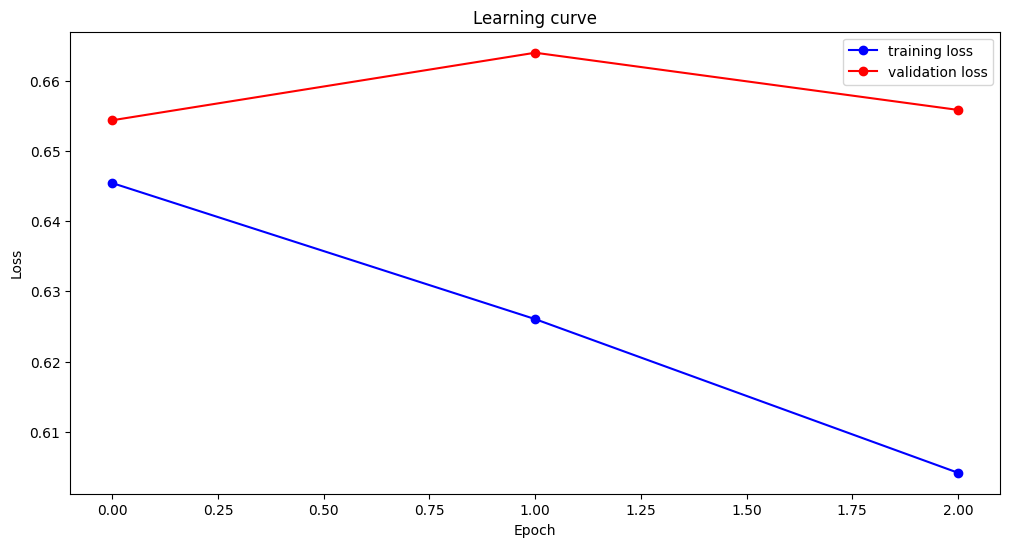

100%|██████████| 5/5 [00:01<00:00,  4.80it/s]


              precision    recall  f1-score   support

           0       0.67      1.00      0.80       100
           1       0.00      0.00      0.00        49

    accuracy                           0.67       149
   macro avg       0.34      0.50      0.40       149
weighted avg       0.45      0.67      0.54       149



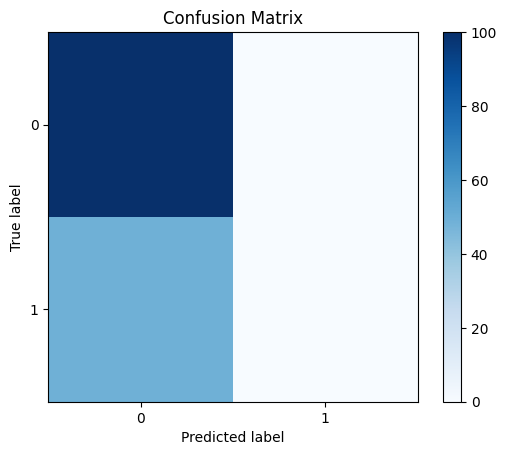

Cross Entropy for this fold: 0.626043975353241


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 3/3 [00:00<00:00,  5.86it/s]


Training loss: 0.6402818390301296, Validation loss: 0.6688145796457926
Epoch 2/4
----------


100%|██████████| 3/3 [00:00<00:00,  5.97it/s]


Training loss: 0.6128262025969369, Validation loss: 0.6657258868217468
Epoch 3/4
----------


100%|██████████| 3/3 [00:00<00:00,  5.91it/s]


Training loss: 0.5940684505871364, Validation loss: 0.6707926392555237
Epoch 4/4
----------


100%|██████████| 3/3 [00:00<00:00,  5.95it/s]


Training loss: 0.5768441387585231, Validation loss: 0.6702523231506348
Early stopping after 2 epochs with no improvement


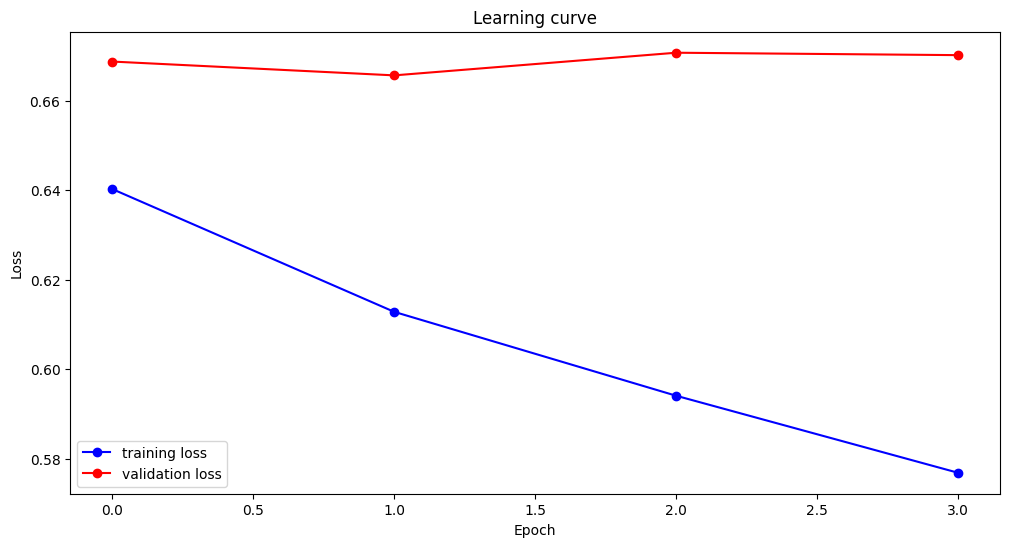

100%|██████████| 5/5 [00:01<00:00,  4.97it/s]


              precision    recall  f1-score   support

           0       0.66      1.00      0.80        99
           1       0.00      0.00      0.00        50

    accuracy                           0.66       149
   macro avg       0.33      0.50      0.40       149
weighted avg       0.44      0.66      0.53       149



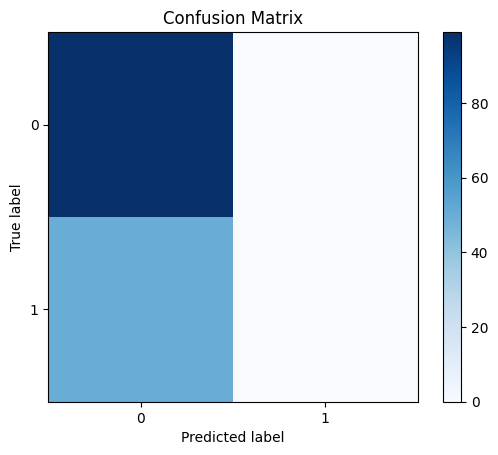

Cross Entropy for this fold: 0.6309453248977661
majority_community_2 - Average Cross Entropy: 0.6310357848803202
majority_community_2 - Average F1 Macro Score: 0.4008021332642398
Running experiment for majority_community_3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.23it/s]


Training loss: 0.6686944290995598, Validation loss: 0.6422446767489115
Epoch 2/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.42it/s]


Training loss: 0.6126331388950348, Validation loss: 0.6338866750399271
Epoch 3/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.23it/s]


Training loss: 0.5694073662161827, Validation loss: 0.6238147219022115
Epoch 4/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.27it/s]


Training loss: 0.5734758079051971, Validation loss: 0.6235266129175822


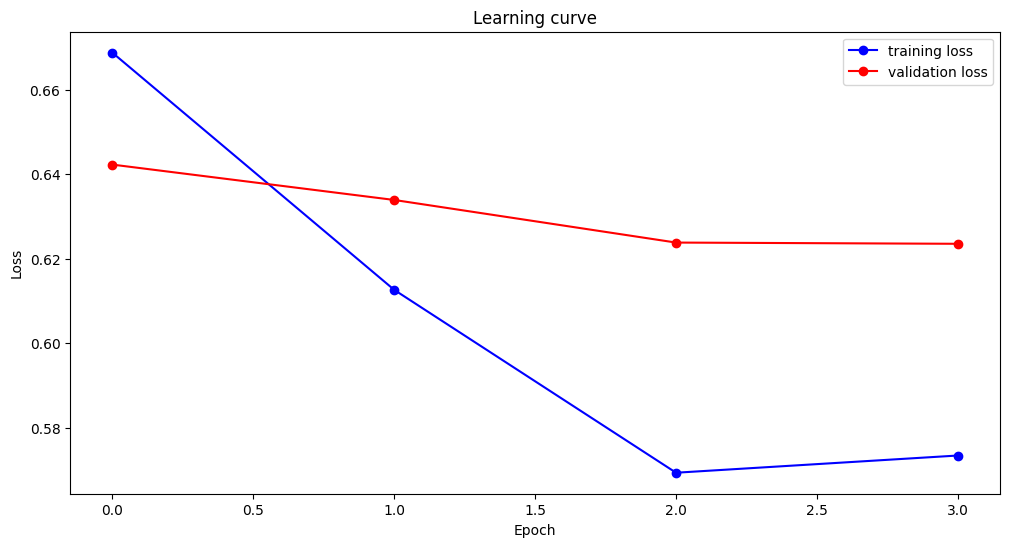

100%|██████████| 5/5 [00:00<00:00,  5.90it/s]


              precision    recall  f1-score   support

           0       0.67      0.96      0.79       103
           1       0.33      0.04      0.07        51

    accuracy                           0.66       154
   macro avg       0.50      0.50      0.43       154
weighted avg       0.56      0.66      0.55       154



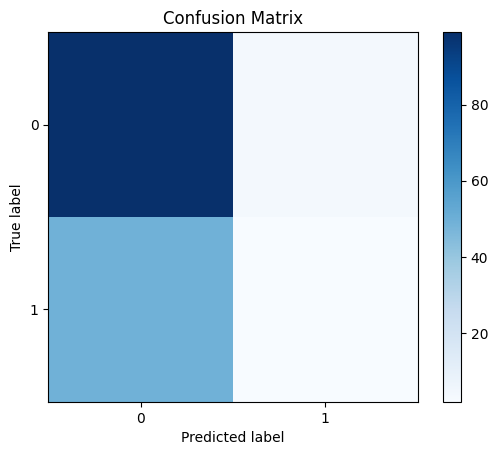

Cross Entropy for this fold: 0.6356920003890991


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.22it/s]


Training loss: 0.6471952646970749, Validation loss: 0.6432247956593832
Epoch 2/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.18it/s]


Training loss: 0.6012955456972122, Validation loss: 0.6336495876312256
Epoch 3/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.21it/s]


Training loss: 0.5528246015310287, Validation loss: 0.6483929753303528
Epoch 4/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.04it/s]


Training loss: 0.5332033336162567, Validation loss: 0.6512847145398458
Early stopping after 2 epochs with no improvement


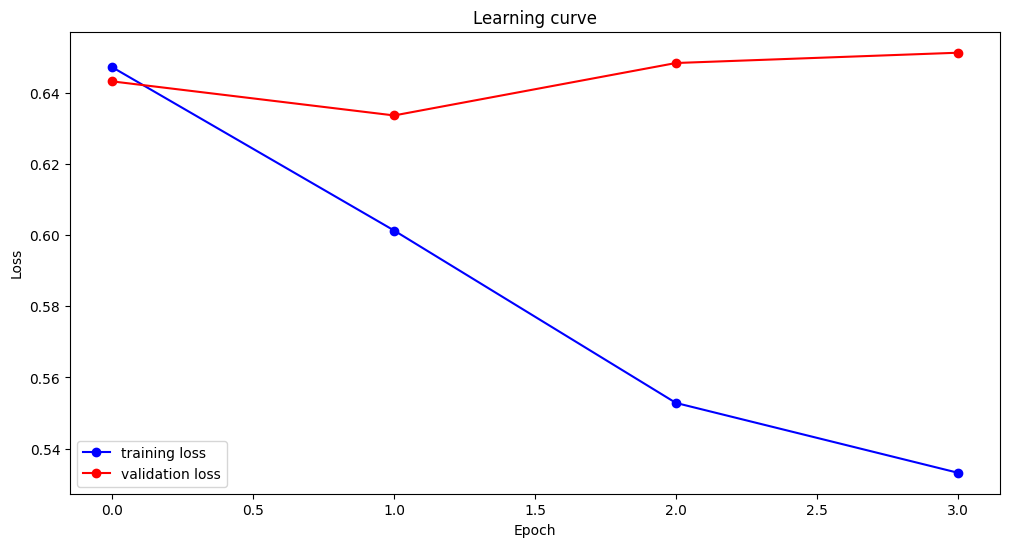

100%|██████████| 5/5 [00:00<00:00,  6.75it/s]


              precision    recall  f1-score   support

           0       0.68      0.99      0.80       102
           1       0.75      0.06      0.11        51

    accuracy                           0.68       153
   macro avg       0.71      0.52      0.46       153
weighted avg       0.70      0.68      0.57       153



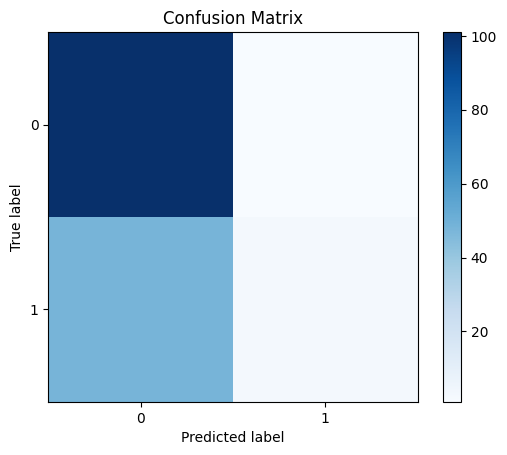

Cross Entropy for this fold: 0.6221371293067932


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.02it/s]


Training loss: 0.6777564361691475, Validation loss: 0.6401967406272888
Epoch 2/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.25it/s]


Training loss: 0.5952544547617435, Validation loss: 0.6294898192087809
Epoch 3/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.29it/s]


Training loss: 0.5723173059523106, Validation loss: 0.6403409242630005
Epoch 4/4
----------


100%|██████████| 3/3 [00:00<00:00,  7.22it/s]


Training loss: 0.5614279620349407, Validation loss: 0.6418719093004862
Early stopping after 2 epochs with no improvement


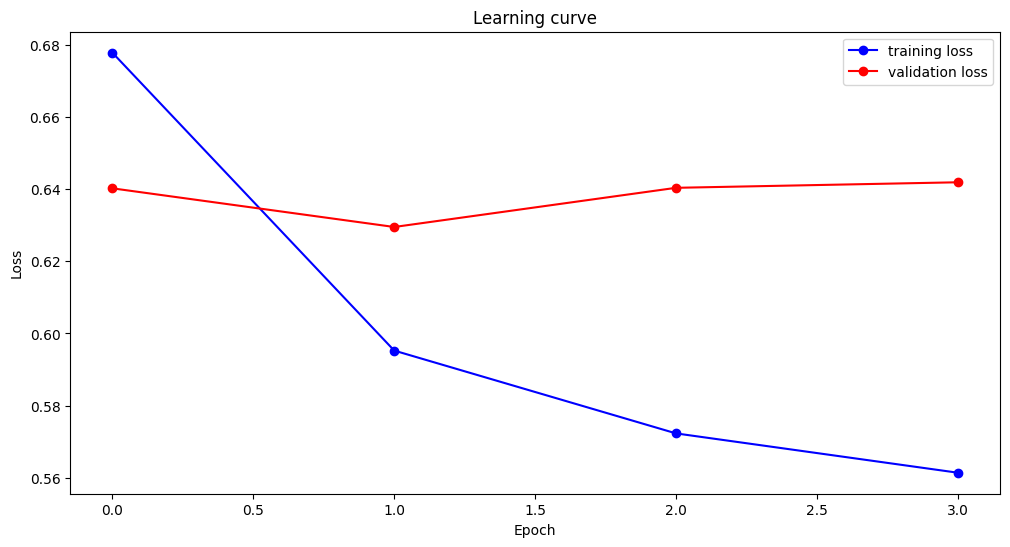

100%|██████████| 5/5 [00:00<00:00,  6.18it/s]


              precision    recall  f1-score   support

           0       0.70      0.88      0.78       103
           1       0.48      0.22      0.30        50

    accuracy                           0.67       153
   macro avg       0.59      0.55      0.54       153
weighted avg       0.63      0.67      0.62       153



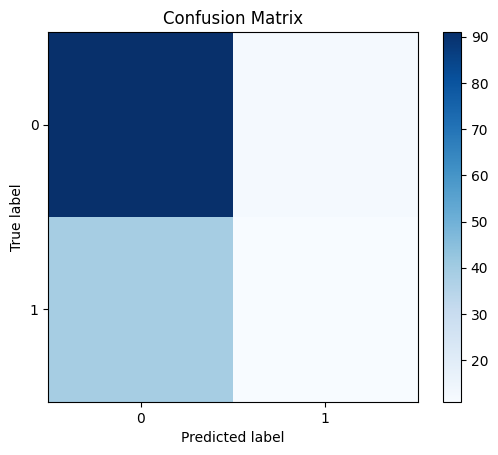

Cross Entropy for this fold: 0.6139528155326843
majority_community_3 - Average Cross Entropy: 0.6239273150761923
majority_community_3 - Average F1 Macro Score: 0.4758962647562323


In [ ]:
# Load the data
community_files = [
    "majority_community_0_data_final_md_leiden.csv",
    "majority_community_1_data_final_md_leiden.csv",
    "majority_community_2_data_final_md_leiden.csv",
    "majority_community_3_data_final_md_leiden.csv",
]
community_dfs = {f"majority_community_{i}": pd.read_csv(f"majority_community_{i}_data_final_md_leiden.csv") for i in range(len(community_files))}
combined_df = pd.read_csv("majority_combined_communities_data_final_md_leiden.csv")
combined_subset_df = pd.read_csv("majority_combined_subset_communities_data_final_md_leiden.csv")  # Load the subset combined dataset

f1_scores_dict = {}
cross_entropy_scores_dict = {}

# Run the experiment for the combined community
print("Running experiment for combined community")
community_name = "majority_combined_community"
cross_entropy, f1_macro = run_experiment_majority(combined_df, sample_frac=0.1, community_name=community_name)
f1_scores_dict[community_name] = f1_macro
cross_entropy_scores_dict[community_name] = cross_entropy

# Run the experiment for the combined subset community
print("Running experiment for combined subset community")
community_name = "majority_combined_subset_community"
cross_entropy, f1_macro = run_experiment_majority(combined_subset_df, sample_frac=0.1, community_name=community_name)
f1_scores_dict[community_name] = f1_macro
cross_entropy_scores_dict[community_name] = cross_entropy

# Run the experiment for each community
for community_name, community_df in community_dfs.items():
    print(f"Running experiment for {community_name}")
    cross_entropy, f1_macro = run_experiment_majority(community_df, sample_frac=0.1, community_name=community_name)
    f1_scores_dict[community_name] = f1_macro
    cross_entropy_scores_dict[community_name] = cross_entropy

In [ ]:
f1_scores_df = pd.DataFrame(list(f1_scores_dict.items()), columns=['Community', 'F1 Macro Score']).set_index('Community')
cross_entropy_scores_df = pd.DataFrame(list(cross_entropy_scores_dict.items()), columns=['Community', 'Cross Entropy']).set_index('Community')

In [ ]:
f1_scores_df

F1 Macro Score
Community                                         
majority_combined_community               0.486722
majority_combined_subset_community        0.427252
majority_community_0                      0.442702
majority_community_1                      0.510778
majority_community_2                      0.400802
majority_community_3                      0.475896

In [ ]:
cross_entropy_scores_df

Cross Entropy
Community                                        
majority_combined_community              0.575314
majority_combined_subset_community       0.604317
majority_community_0                     0.507223
majority_community_1                     0.617416
majority_community_2                     0.631036
majority_community_3                     0.623927

In [ ]:
# List of community names
community_names = [
    "majority_combined_community",
    "majority_combined_subset_community",
    "majority_community_0",
    "majority_community_1",
    "majority_community_2",
    "majority_community_3"
]

# Load and display incorrectly classified instances for each community
for community_name in community_names:
    # Load the incorrectly classified instances from the CSV file
    filename = f"{community_name}_incorrectly_classified_instances.csv"
    incorrectly_classified_df = pd.read_csv(filename)

    # Display the DataFrame (You can also perform any further analysis you need on this DataFrame)
    print(f"Incorrectly Classified Instances for {community_name}:")
    display(incorrectly_classified_df)


Incorrectly Classified Instances for majority_combined_community:


instance_id  offensiveness  \
0           5015              1   
1            663              1   
2           4707              1   
3          10201              1   
4           2987              1   
..           ...            ...   
305        10505              1   
306         1547              1   
307         4272              1   
308         6373              1   
309         2754              1   

                                          cleaned_text cleaned_domain  \
0                       you look feeble..:crying_face:  elections2020   
1    tax your rich friends you immoral and evil par...       covid-19   
2    white people act like jesus died and left them...            blm   
3    waiting for ‘s move. is bad for america! #trum...  elections2020   
4           morons...get your covid ... i mean koolaid       covid-19   
..                                                 ...            ...   
305  plus some of you are going to die. coronavirus...       covid-19   
306  hehehe pence is very dirty hands he used it in...       covid-19   
307  so this racist, soulless mother fucker knew ex...       covid-19   
308  the goal should be to have a plan to kill covi...       covid-19   
309  black lives matter we stand with our islamic b...  elections2020   

                                      text_with_domain  predicted_label  \
0         elections2020 you look feeble..:crying_face:                0   
1    covid-19 tax your rich friends you immoral and...                0   
2    blm white people act like jesus died and left ...                0   
3    elections2020 waiting for ‘s move. is bad for ...                0   
4    covid-19 morons...get your covid ... i mean ko...                0   
..                                                 ...              ...   
305  covid-19 plus some of you are going to die. co...                0   
306  covid-19 hehehe pence is very dirty hands he u...                0   
307  covid-19 so this racist, soulless mother fucke...                0   
308  covid-19 the goal should be to have a plan to ...                0   
309  elections2020 black lives matter we stand with...                0   

     true_label  cross_entropy  
0             1       1.263933  
1             1       1.145868  
2             1       1.505050  
3             1       1.366952  
4             1       1.302203  
..          ...            ...  
305           1       1.253441  
306           1       1.239927  
307           1       1.138286  
308           1       1.058822  
309           1       1.259640  

[310 rows x 8 columns]

Incorrectly Classified Instances for majority_combined_subset_community:


instance_id  offensiveness  \
0            586              1   
1           5509              1   
2           3550              1   
3           8769              1   
4          10734              1   
..           ...            ...   
120         7718              1   
121          179              1   
122         7371              1   
123         1095              1   
124        10553              1   

                                          cleaned_text cleaned_domain  \
0                    hitler staches are chill says cdc       covid-19   
1    "why yes yes jed, afeared it is dem same lunat...  elections2020   
2    you will go down in history as the most corrup...  elections2020   
3           you will not be president. treasonous dog.  elections2020   
4                         ok white privileged bunghole            blm   
..                                                 ...            ...   
120  democrats press dhs over use of drone during m...            blm   
121  i do not want to go out ever again jesus you a...       covid-19   
122        spoken like a true blue crooked politician!  elections2020   
123  they took the grandma down at the end are you ...            blm   
124  to whom it may concern, due to your #unscienti...       covid-19   

                                      text_with_domain  predicted_label  \
0           covid-19 hitler staches are chill says cdc                0   
1    elections2020 "why yes yes jed, afeared it is ...                0   
2    elections2020 you will go down in history as t...                0   
3    elections2020 you will not be president. treas...                0   
4                     blm ok white privileged bunghole                0   
..                                                 ...              ...   
120  blm democrats press dhs over use of drone duri...                0   
121  covid-19 i do not want to go out ever again je...                0   
122  elections2020 spoken like a true blue crooked ...                0   
123  blm they took the grandma down at the end are ...                0   
124  covid-19 to whom it may concern, due to your #...                0   

     true_label  cross_entropy  
0             1       1.308728  
1             1       1.163568  
2             1       1.167802  
3             1       1.154219  
4             1       1.091882  
..          ...            ...  
120           1       1.297723  
121           1       1.055709  
122           1       0.963046  
123           1       1.187470  
124           1       1.233774  

[125 rows x 8 columns]

Incorrectly Classified Instances for majority_community_0:


instance_id  offensiveness  \
0          5085              1   
1          4680              1   
2          1529              1   
3          7294              1   
4          8074              1   
..          ...            ...   
68         6877              1   
69         5809              1   
70         3674              1   
71          174              1   
72        10134              1   

                                         cleaned_text cleaned_domain  \
0                   shut up and write better columns.       covid-19   
1   enough of this bogus coronavirus bullshit. nc ...            blm   
2   this is why you are an idiot as i said before....  elections2020   
3   >146,000 people are needlessly dead from your ...       covid-19   
4   heard earlier today the moron kneeling was fir...            blm   
..                                                ...            ...   
68       my brother died of covid! you are the loser!       covid-19   
69  and then there is this #whiteguilt piece from ...            blm   
70  f*ck those guys #black_lives_matter and i thin...            blm   
71  we are no longer mailing our ballots. hand del...  elections2020   
72                                   this shit crazy.            blm   

                                     text_with_domain  predicted_label  \
0          covid-19 shut up and write better columns.                0   
1   blm enough of this bogus coronavirus bullshit....                0   
2   elections2020 this is why you are an idiot as ...                0   
3   covid-19 >146,000 people are needlessly dead f...                0   
4   blm heard earlier today the moron kneeling was...                0   
..                                                ...              ...   
68  covid-19 my brother died of covid! you are the...                0   
69  blm and then there is this #whiteguilt piece f...                0   
70  blm f*ck those guys #black_lives_matter and i ...                0   
71  elections2020 we are no longer mailing our bal...                0   
72                               blm this shit crazy.                0   

    true_label  cross_entropy  
0            1       1.520143  
1            1       1.559156  
2            1       1.546858  
3            1       1.507426  
4            1       1.507938  
..         ...            ...  
68           1       1.500330  
69           1       1.734553  
70           1       1.788668  
71           1       1.530381  
72           1       1.507505  

[73 rows x 8 columns]

Incorrectly Classified Instances for majority_community_1:


instance_id  offensiveness  \
0            942              1   
1           1756              1   
2           2483              1   
3           1509              1   
4           2917              1   
..           ...            ...   
142         1411              1   
143         1578              1   
144          182              1   
145         6393              0   
146          162              0   

                                          cleaned_text cleaned_domain  \
0    daily reminder that trump is a dumbass and has...            blm   
1    we all bleed the same fucking blood & who tf m...            blm   
2    delusional pathological narcissist says what? ...  elections2020   
3    this is america. rioting no law order because ...  elections2020   
4    he did this to other white people he really ra...            blm   
..                                                 ...            ...   
142  a lot of american citizens are unified and tak...            blm   
143     that is more kinds of stupid than i can count.       covid-19   
144  the kkk racist democrats ride for their white ...  elections2020   
145  you are still collecting money. do not you hav...  elections2020   
146                 look at all those people for trump  elections2020   

                                      text_with_domain  predicted_label  \
0    blm daily reminder that trump is a dumbass and...                0   
1    blm we all bleed the same fucking blood & who ...                0   
2    elections2020 delusional pathological narcissi...                0   
3    elections2020 this is america. rioting no law ...                0   
4    blm he did this to other white people he reall...                0   
..                                                 ...              ...   
142  blm a lot of american citizens are unified and...                0   
143  covid-19 that is more kinds of stupid than i c...                0   
144  elections2020 the kkk racist democrats ride fo...                0   
145  elections2020 you are still collecting money. ...                1   
146   elections2020 look at all those people for trump                1   

     true_label  cross_entropy  
0             1       1.252010  
1             1       1.374000  
2             1       0.989385  
3             1       1.113899  
4             1       0.928492  
..          ...            ...  
142           1       0.927553  
143           1       0.892735  
144           1       0.775569  
145           0       1.033692  
146           0       0.874399  

[147 rows x 8 columns]

Incorrectly Classified Instances for majority_community_2:


instance_id  offensiveness  \
0           8974              1   
1           5895              1   
2           3443              1   
3          10327              1   
4           5410              1   
..           ...            ...   
143         4755              1   
144         9476              1   
145         3535              1   
146         4042              1   
147         9469              1   

                                          cleaned_text cleaned_domain  \
0                    an atheist jew named george soros  elections2020   
1    scare tactic again, read the headlines!!! poss...       covid-19   
2                    my pussy will never be this good.       covid-19   
3    dear while i appreciate your attempt to call o...       covid-19   
4                                      america is hell       covid-19   
..                                                 ...            ...   
143  she looks terrible. i thought for a moment tha...  elections2020   
144  idiots! it is not a threat! after exerting mys...  elections2020   
145  crusty old bigots crying that their last basti...            blm   
146                                         fuck biden  elections2020   
147  well they will when the results come in, or th...  elections2020   

                                      text_with_domain  predicted_label  \
0      elections2020 an atheist jew named george soros                0   
1    covid-19 scare tactic again, read the headline...                0   
2           covid-19 my pussy will never be this good.                0   
3    covid-19 dear while i appreciate your attempt ...                0   
4                             covid-19 america is hell                0   
..                                                 ...              ...   
143  elections2020 she looks terrible. i thought fo...                0   
144  elections2020 idiots! it is not a threat! afte...                0   
145  blm crusty old bigots crying that their last b...                0   
146                           elections2020 fuck biden                0   
147  elections2020 well they will when the results ...                0   

     true_label  cross_entropy  
0             1       0.985029  
1             1       1.164656  
2             1       1.498666  
3             1       1.561106  
4             1       1.658969  
..          ...            ...  
143           1       1.109386  
144           1       1.083767  
145           1       1.013184  
146           1       0.916802  
147           1       1.064081  

[148 rows x 8 columns]

Incorrectly Classified Instances for majority_community_3:


instance_id  offensiveness  \
0           9471              1   
1            150              1   
2            349              1   
3           4115              1   
4           4050              1   
..           ...            ...   
148          602              1   
149         7209              1   
150         6260              1   
151         2257              1   
152         6366              0   

                                          cleaned_text cleaned_domain  \
0    fucking cops. they pound peaceful protesters a...       covid-19   
1    and then continue legislative constipation bec...  elections2020   
2    in trumps own words. the only racist on the st...  elections2020   
3    does meeting with, and praising, anti - semite...  elections2020   
4    omg. people are dying, the rate of covid19 inf...       covid-19   
..                                                 ...            ...   
148  first they are rapists and criminals, now they...       covid-19   
149  #gopdeathcult aiding and abetting #traitortrum...       covid-19   
150  i have a confession to make. since the lockdow...       covid-19   
151  silence is complicit. you are the douchebag yo...            blm   
152  cannot decide if the latest slogan is the most...       covid-19   

                                      text_with_domain  predicted_label  \
0    covid-19 fucking cops. they pound peaceful pro...                0   
1    elections2020 and then continue legislative co...                0   
2    elections2020 in trumps own words. the only ra...                0   
3    elections2020 does meeting with, and praising,...                0   
4    covid-19 omg. people are dying, the rate of co...                0   
..                                                 ...              ...   
148  covid-19 first they are rapists and criminals,...                0   
149  covid-19 #gopdeathcult aiding and abetting #tr...                0   
150  covid-19 i have a confession to make. since th...                0   
151  blm silence is complicit. you are the doucheba...                0   
152  covid-19 cannot decide if the latest slogan is...                1   

     true_label  cross_entropy  
0             1       0.764833  
1             1       1.035592  
2             1       1.178384  
3             1       1.134038  
4             1       1.160554  
..          ...            ...  
148           1       0.931070  
149           1       1.337276  
150           1       1.070086  
151           1       1.176731  
152           0       0.743846  

[153 rows x 8 columns]

The differences in Cross Entropy are minimal between the two but BERT showed better F1 Macro scores. So BERT model chosen.

# Model 1: Separate models for communities and combined based on majority from communities


Running experiment for combined community


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 56/56 [00:13<00:00,  4.28it/s]


Training loss: 0.5179789006000474, Validation loss: 0.4323702630187784
Epoch 2/4
----------


100%|██████████| 56/56 [00:12<00:00,  4.38it/s]


Training loss: 0.3534219412221795, Validation loss: 0.42374447812991484
Epoch 3/4
----------


100%|██████████| 56/56 [00:12<00:00,  4.35it/s]


Training loss: 0.24562887193280317, Validation loss: 0.4709912804620607
Epoch 4/4
----------


100%|██████████| 56/56 [00:12<00:00,  4.40it/s]


Training loss: 0.16440204746045528, Validation loss: 0.5272485323782478
Early stopping after 2 epochs with no improvement


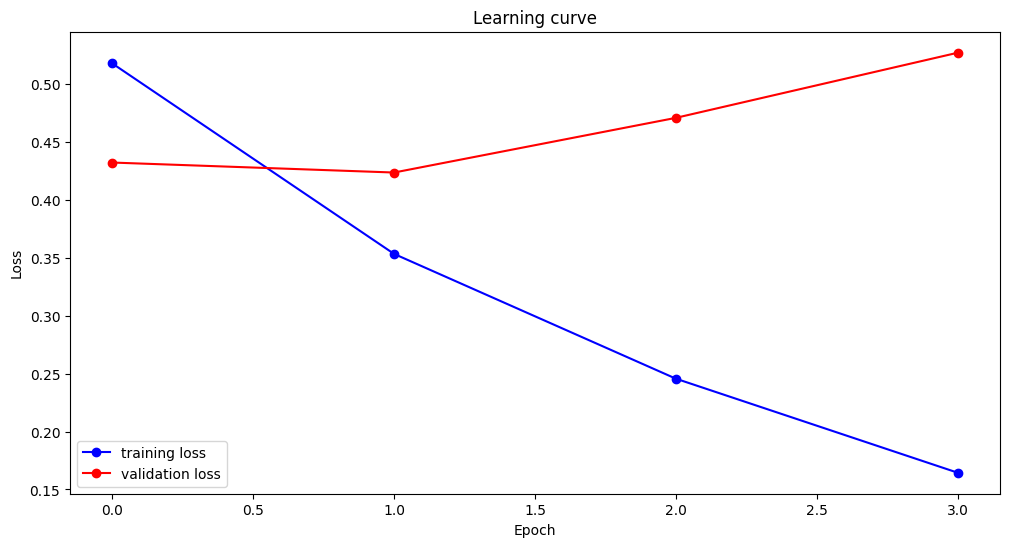

100%|██████████| 112/112 [00:25<00:00,  4.43it/s]


              precision    recall  f1-score   support

           0       0.84      0.91      0.88      2532
           1       0.74      0.58      0.65      1052

    accuracy                           0.82      3584
   macro avg       0.79      0.75      0.76      3584
weighted avg       0.81      0.82      0.81      3584



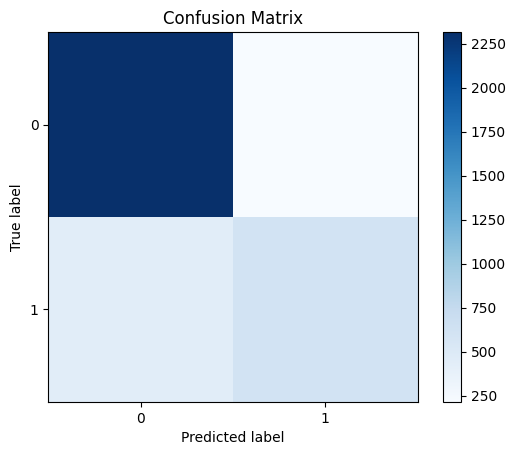

Cross Entropy for this fold: 0.40952593088150024


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 56/56 [00:12<00:00,  4.37it/s]


Training loss: 0.5200449285053071, Validation loss: 0.4356899367911475
Epoch 2/4
----------


100%|██████████| 56/56 [00:12<00:00,  4.38it/s]


Training loss: 0.3784942017602069, Validation loss: 0.4156468156725168
Epoch 3/4
----------


100%|██████████| 56/56 [00:12<00:00,  4.40it/s]


Training loss: 0.2724357440712906, Validation loss: 0.46197556225316866
Epoch 4/4
----------


100%|██████████| 56/56 [00:12<00:00,  4.38it/s]


Training loss: 0.19085291728732132, Validation loss: 0.49838409572839737
Early stopping after 2 epochs with no improvement


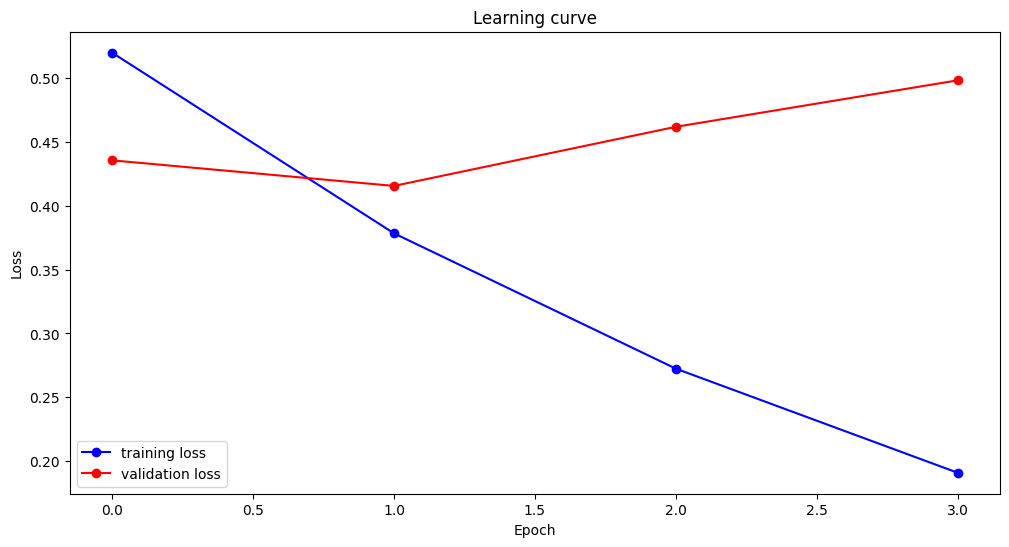

100%|██████████| 112/112 [00:25<00:00,  4.41it/s]


              precision    recall  f1-score   support

           0       0.87      0.85      0.86      2531
           1       0.67      0.70      0.69      1053

    accuracy                           0.81      3584
   macro avg       0.77      0.78      0.78      3584
weighted avg       0.81      0.81      0.81      3584



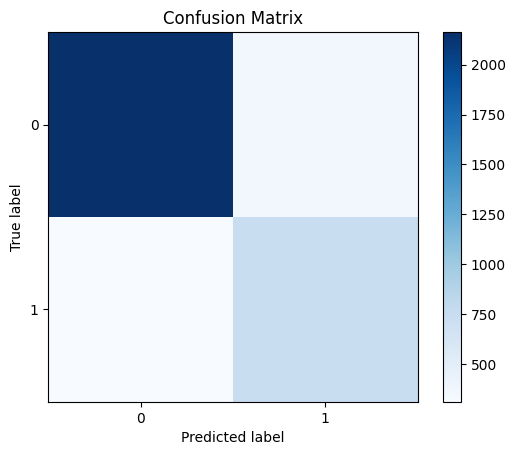

Cross Entropy for this fold: 0.40662121772766113


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 56/56 [00:12<00:00,  4.38it/s]


Training loss: 0.5230391967509475, Validation loss: 0.40904649692986694
Epoch 2/4
----------


100%|██████████| 56/56 [00:12<00:00,  4.39it/s]


Training loss: 0.36442203429483233, Validation loss: 0.38838088512420654
Epoch 3/4
----------


100%|██████████| 56/56 [00:12<00:00,  4.39it/s]


Training loss: 0.26163436538938967, Validation loss: 0.4191561181630407
Epoch 4/4
----------


100%|██████████| 56/56 [00:12<00:00,  4.41it/s]


Training loss: 0.1774892579719779, Validation loss: 0.4643724981163229
Early stopping after 2 epochs with no improvement


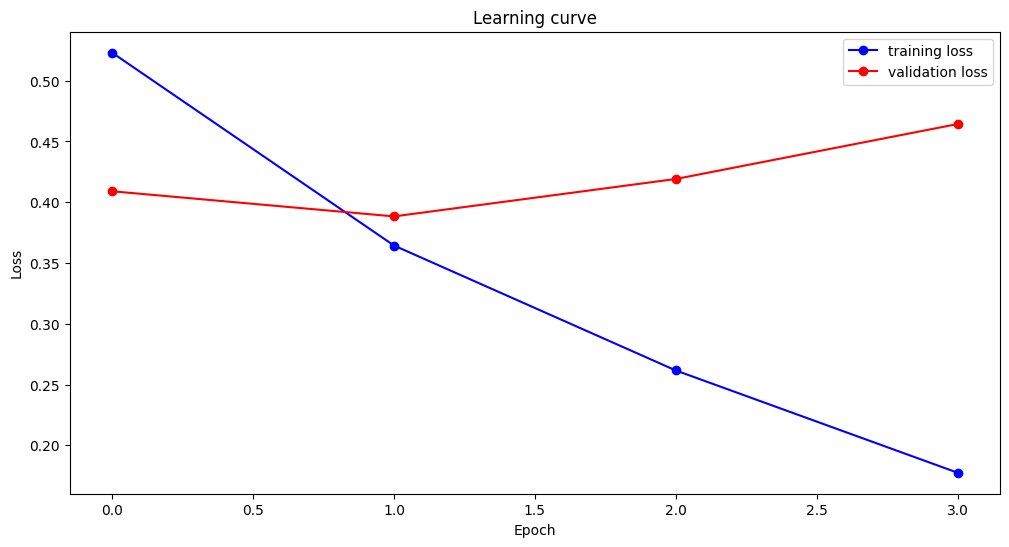

100%|██████████| 112/112 [00:25<00:00,  4.41it/s]


              precision    recall  f1-score   support

           0       0.84      0.90      0.87      2531
           1       0.71      0.58      0.64      1052

    accuracy                           0.81      3583
   macro avg       0.78      0.74      0.75      3583
weighted avg       0.80      0.81      0.80      3583



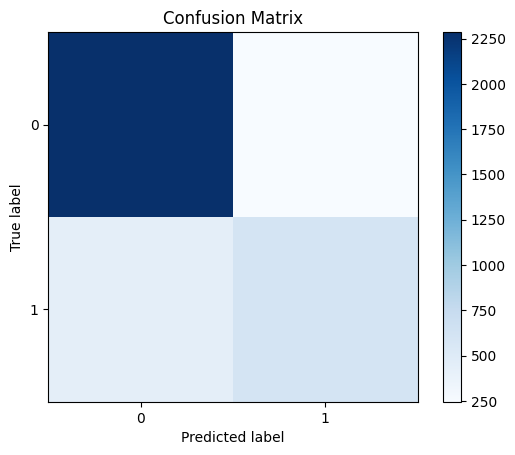

Cross Entropy for this fold: 0.4236679673194885
majority_combined_community - Average Cross Entropy: 0.41327170530955
majority_combined_community - Average F1 Macro Score: 0.7633935114565945
Running experiment for combined subset community


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 22/22 [00:05<00:00,  4.36it/s]


Training loss: 0.592478308262247, Validation loss: 0.5628041150895032
Epoch 2/4
----------


100%|██████████| 22/22 [00:05<00:00,  4.38it/s]


Training loss: 0.4569238821665446, Validation loss: 0.49860881675373425
Epoch 3/4
----------


100%|██████████| 22/22 [00:04<00:00,  4.43it/s]


Training loss: 0.31611126819343277, Validation loss: 0.5238359326666052
Epoch 4/4
----------


100%|██████████| 22/22 [00:04<00:00,  4.42it/s]


Training loss: 0.22940648809978456, Validation loss: 0.5433932000940497
Early stopping after 2 epochs with no improvement


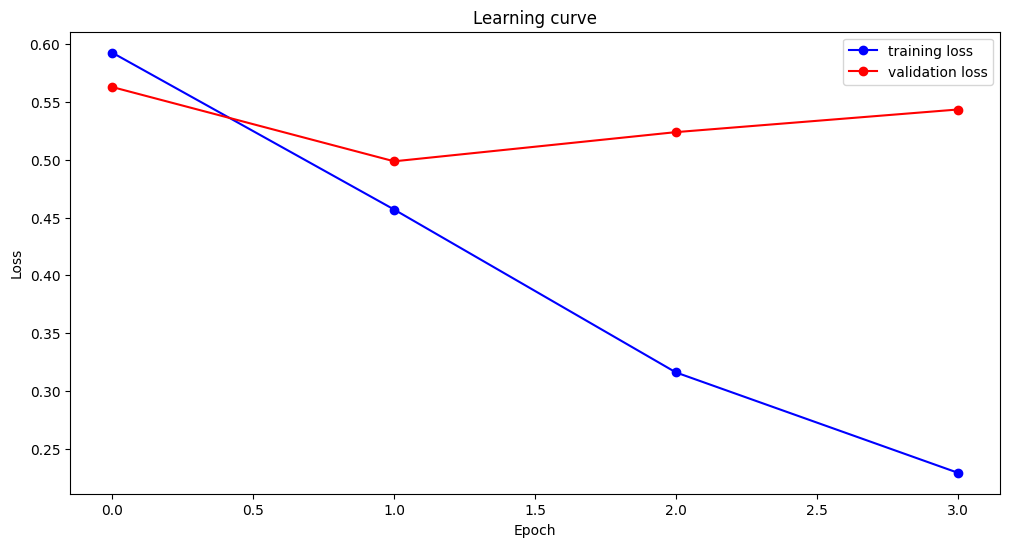

100%|██████████| 44/44 [00:09<00:00,  4.44it/s]


              precision    recall  f1-score   support

           0       0.82      0.90      0.86       973
           1       0.71      0.55      0.62       427

    accuracy                           0.80      1400
   macro avg       0.77      0.73      0.74      1400
weighted avg       0.79      0.80      0.79      1400



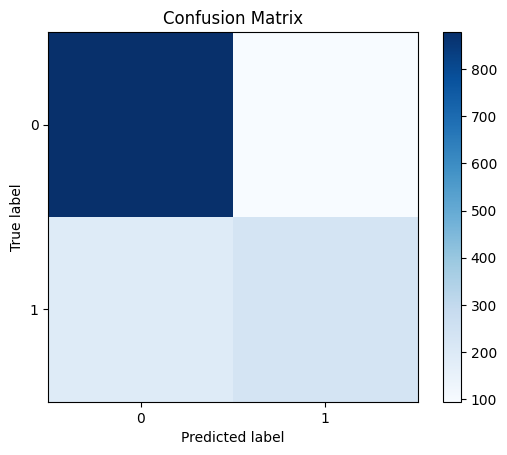

Cross Entropy for this fold: 0.44978994131088257


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 22/22 [00:05<00:00,  4.37it/s]


Training loss: 0.6003152393933499, Validation loss: 0.5477378151633523
Epoch 2/4
----------


100%|██████████| 22/22 [00:04<00:00,  4.40it/s]


Training loss: 0.4485062405918584, Validation loss: 0.4927177903327075
Epoch 3/4
----------


100%|██████████| 22/22 [00:05<00:00,  4.39it/s]


Training loss: 0.3228865335836555, Validation loss: 0.49176681719043036
Epoch 4/4
----------


100%|██████████| 22/22 [00:05<00:00,  4.38it/s]


Training loss: 0.23829098813461536, Validation loss: 0.5160493979399855


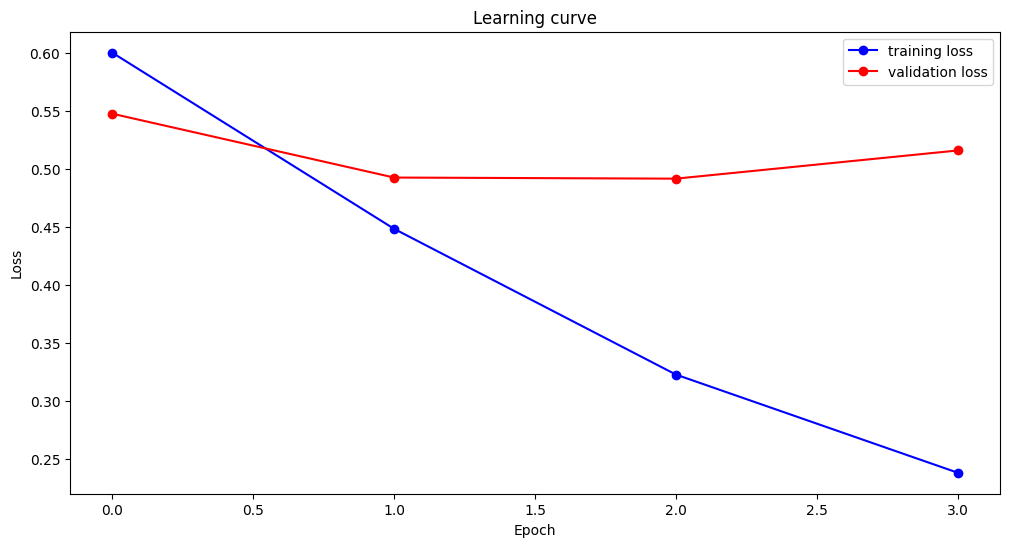

100%|██████████| 44/44 [00:09<00:00,  4.43it/s]


              precision    recall  f1-score   support

           0       0.83      0.87      0.85       974
           1       0.67      0.60      0.64       426

    accuracy                           0.79      1400
   macro avg       0.75      0.74      0.74      1400
weighted avg       0.78      0.79      0.79      1400



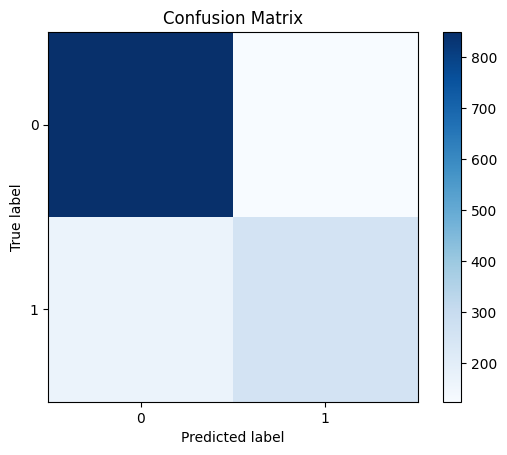

Cross Entropy for this fold: 0.4886611998081207


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 22/22 [00:05<00:00,  4.36it/s]


Training loss: 0.577505814758214, Validation loss: 0.5278309339826758
Epoch 2/4
----------


100%|██████████| 22/22 [00:05<00:00,  4.35it/s]


Training loss: 0.45208904237458203, Validation loss: 0.4683158438314091
Epoch 3/4
----------


100%|██████████| 22/22 [00:05<00:00,  4.35it/s]


Training loss: 0.3421450065392436, Validation loss: 0.4880221458998593
Epoch 4/4
----------


100%|██████████| 22/22 [00:04<00:00,  4.43it/s]


Training loss: 0.26798742377396784, Validation loss: 0.49629356915300543
Early stopping after 2 epochs with no improvement


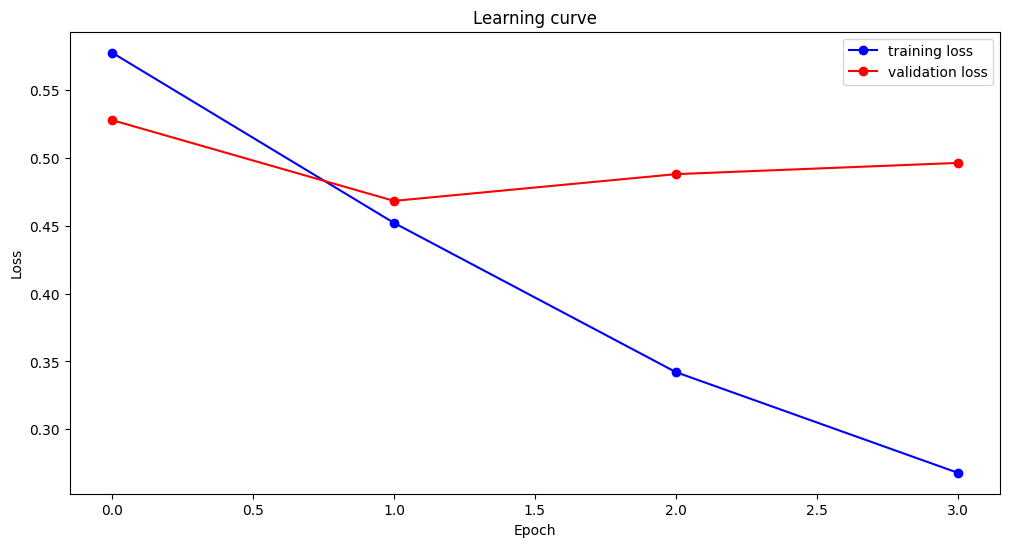

100%|██████████| 44/44 [00:09<00:00,  4.43it/s]


              precision    recall  f1-score   support

           0       0.77      0.93      0.84       974
           1       0.70      0.37      0.48       426

    accuracy                           0.76      1400
   macro avg       0.74      0.65      0.66      1400
weighted avg       0.75      0.76      0.73      1400



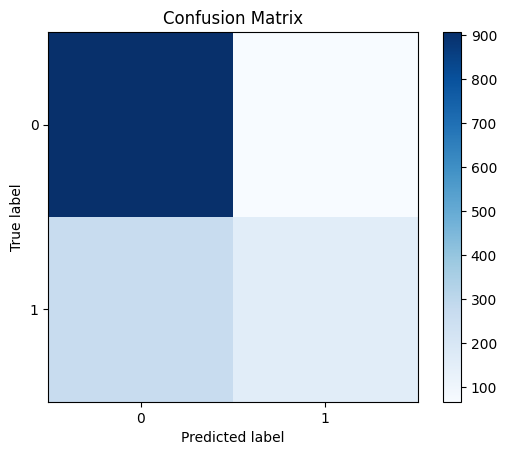

Cross Entropy for this fold: 0.49346688389778137
majority_combined_subset_community - Average Cross Entropy: 0.4773060083389282
majority_combined_subset_community - Average F1 Macro Score: 0.7155014520020888
Running experiment for majority_community_0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 19/19 [00:03<00:00,  4.82it/s]


Training loss: 0.49271718758557526, Validation loss: 0.4251117267106709
Epoch 2/4
----------


100%|██████████| 19/19 [00:03<00:00,  4.92it/s]


Training loss: 0.39339939824172426, Validation loss: 0.3557885430361095
Epoch 3/4
----------


100%|██████████| 19/19 [00:03<00:00,  4.84it/s]


Training loss: 0.3017919094168714, Validation loss: 0.34956567146276174
Epoch 4/4
----------


100%|██████████| 19/19 [00:03<00:00,  4.89it/s]


Training loss: 0.24331598915159702, Validation loss: 0.36283082632642044


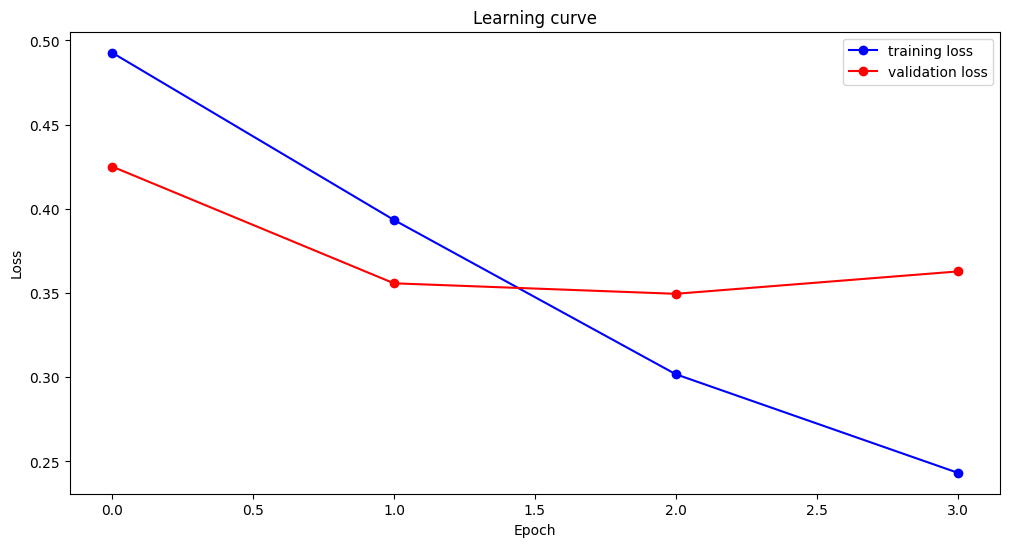

100%|██████████| 37/37 [00:08<00:00,  4.43it/s]


              precision    recall  f1-score   support

           0       0.88      0.94      0.91       949
           1       0.66      0.46      0.54       235

    accuracy                           0.85      1184
   macro avg       0.77      0.70      0.72      1184
weighted avg       0.83      0.85      0.83      1184



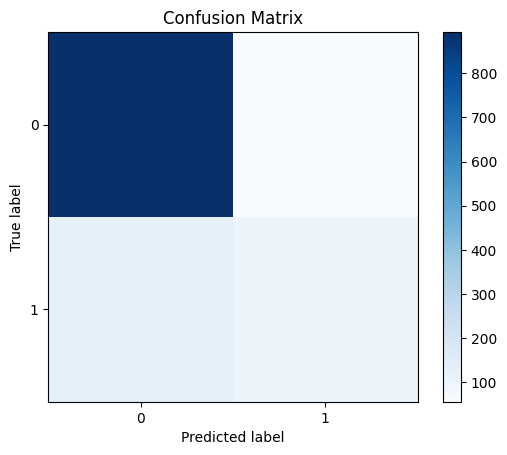

Cross Entropy for this fold: 0.3790535628795624


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 19/19 [00:03<00:00,  4.81it/s]


Training loss: 0.4999624884554318, Validation loss: 0.47113213256785746
Epoch 2/4
----------


100%|██████████| 19/19 [00:03<00:00,  4.84it/s]


Training loss: 0.4239283366394894, Validation loss: 0.41403422779158544
Epoch 3/4
----------


100%|██████████| 19/19 [00:03<00:00,  4.87it/s]


Training loss: 0.30685050399707897, Validation loss: 0.42295354134158086
Epoch 4/4
----------


100%|██████████| 19/19 [00:03<00:00,  4.87it/s]


Training loss: 0.24063169756638153, Validation loss: 0.4388472971163298
Early stopping after 2 epochs with no improvement


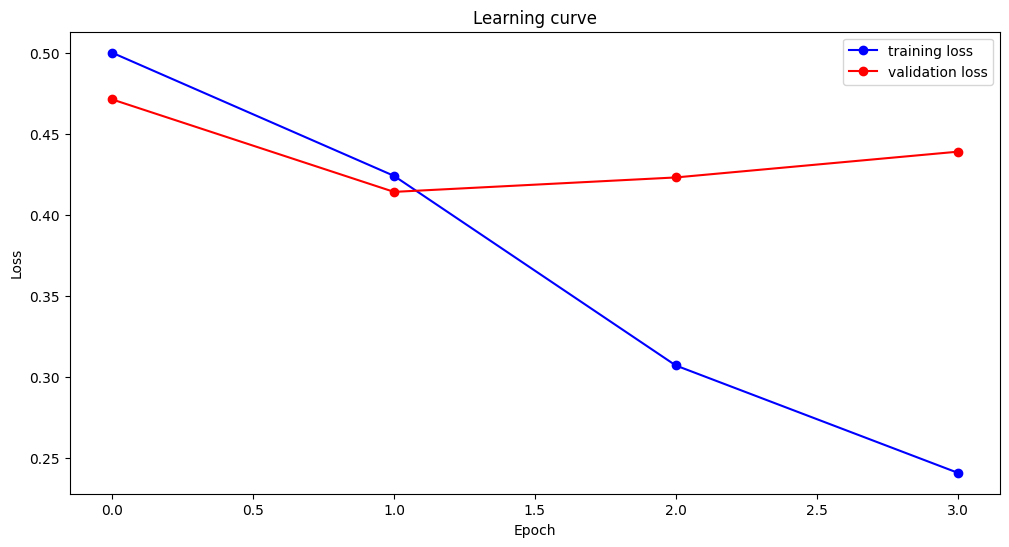

100%|██████████| 37/37 [00:08<00:00,  4.42it/s]


              precision    recall  f1-score   support

           0       0.85      0.96      0.90       949
           1       0.65      0.32      0.43       235

    accuracy                           0.83      1184
   macro avg       0.75      0.64      0.66      1184
weighted avg       0.81      0.83      0.81      1184



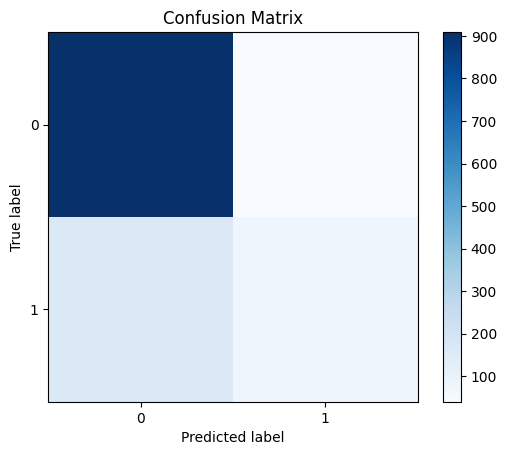

Cross Entropy for this fold: 0.3952637016773224


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 19/19 [00:04<00:00,  4.32it/s]


Training loss: 0.48628060839005877, Validation loss: 0.47007712408115987
Epoch 2/4
----------


100%|██████████| 19/19 [00:04<00:00,  4.34it/s]


Training loss: 0.37866527108209475, Validation loss: 0.42881882739694493
Epoch 3/4
----------


100%|██████████| 19/19 [00:04<00:00,  4.36it/s]


Training loss: 0.2658153370554958, Validation loss: 0.4294147546354093
Epoch 4/4
----------


100%|██████████| 19/19 [00:04<00:00,  4.35it/s]


Training loss: 0.1931711473901357, Validation loss: 0.44463240629748296
Early stopping after 2 epochs with no improvement


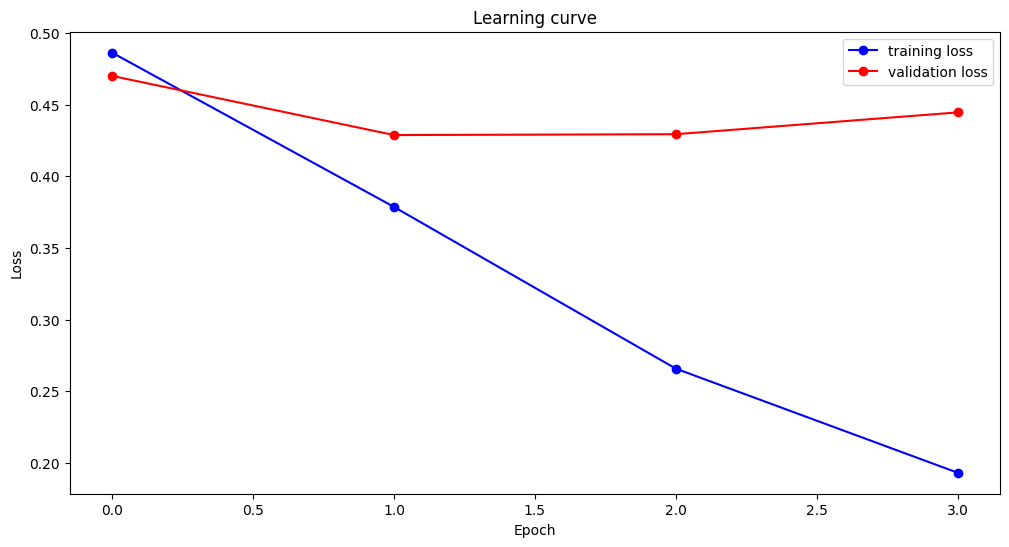

100%|██████████| 37/37 [00:08<00:00,  4.39it/s]


              precision    recall  f1-score   support

           0       0.88      0.93      0.90       948
           1       0.63      0.46      0.53       235

    accuracy                           0.84      1183
   macro avg       0.75      0.70      0.72      1183
weighted avg       0.83      0.84      0.83      1183



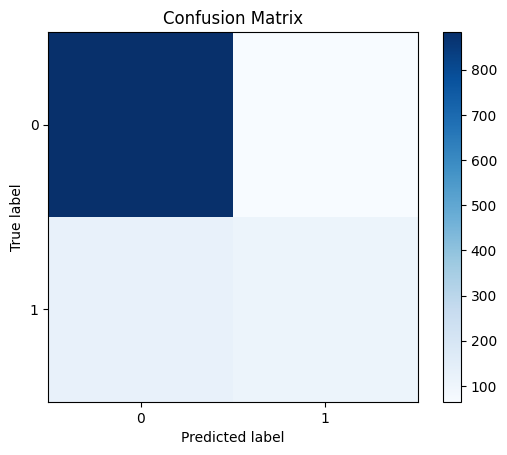

Cross Entropy for this fold: 0.39533841609954834
majority_community_0 - Average Cross Entropy: 0.3898852268854777
majority_community_0 - Average F1 Macro Score: 0.7022141959041508
Running experiment for majority_community_1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 23/23 [00:04<00:00,  4.88it/s]


Training loss: 0.5638541036577367, Validation loss: 0.48364056452460913
Epoch 2/4
----------


100%|██████████| 23/23 [00:04<00:00,  4.83it/s]


Training loss: 0.408991079277067, Validation loss: 0.4767921586399493
Epoch 3/4
----------


100%|██████████| 23/23 [00:04<00:00,  4.93it/s]


Training loss: 0.28016925725474284, Validation loss: 0.47720334776069806
Epoch 4/4
----------


100%|██████████| 23/23 [00:04<00:00,  4.92it/s]


Training loss: 0.2037636065549815, Validation loss: 0.49971719604471454
Early stopping after 2 epochs with no improvement


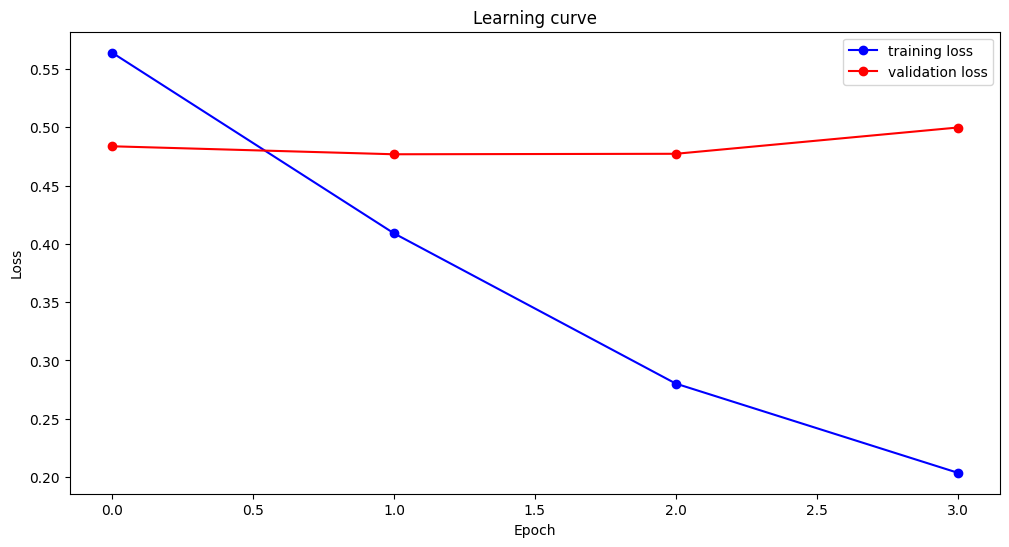

100%|██████████| 45/45 [00:10<00:00,  4.46it/s]


              precision    recall  f1-score   support

           0       0.80      0.91      0.85       988
           1       0.71      0.46      0.56       434

    accuracy                           0.78      1422
   macro avg       0.75      0.69      0.70      1422
weighted avg       0.77      0.78      0.76      1422



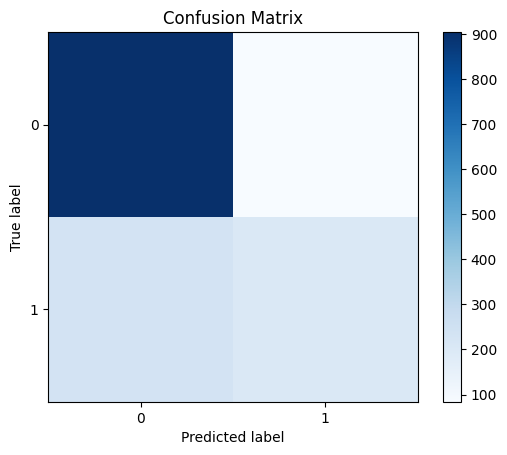

Cross Entropy for this fold: 0.5266292691230774


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 23/23 [00:05<00:00,  4.51it/s]


Training loss: 0.5917604703511765, Validation loss: 0.49123731903407886
Epoch 2/4
----------


100%|██████████| 23/23 [00:05<00:00,  4.51it/s]


Training loss: 0.43099129800476244, Validation loss: 0.4282561773839204
Epoch 3/4
----------


100%|██████████| 23/23 [00:05<00:00,  4.55it/s]


Training loss: 0.3051498599016844, Validation loss: 0.42481019509875256
Epoch 4/4
----------


100%|██████████| 23/23 [00:05<00:00,  4.53it/s]


Training loss: 0.21676085633573247, Validation loss: 0.44715900330439856


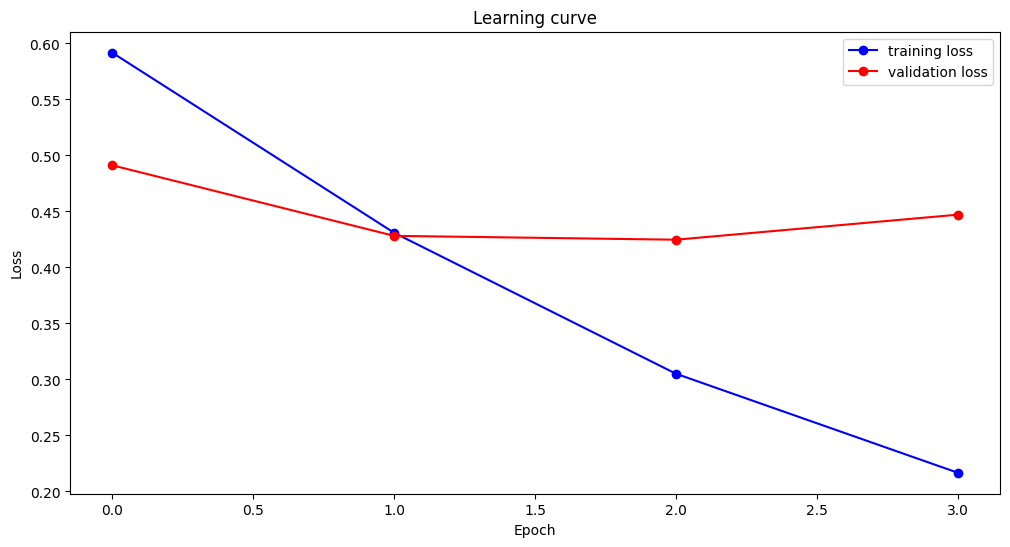

100%|██████████| 45/45 [00:10<00:00,  4.48it/s]


              precision    recall  f1-score   support

           0       0.86      0.91      0.88       989
           1       0.76      0.66      0.70       433

    accuracy                           0.83      1422
   macro avg       0.81      0.78      0.79      1422
weighted avg       0.83      0.83      0.83      1422



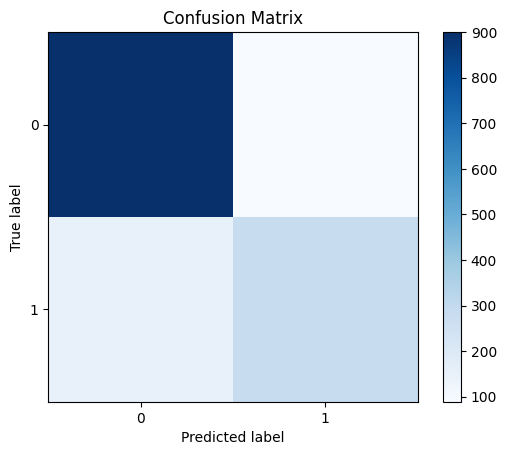

Cross Entropy for this fold: 0.4201900064945221


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 23/23 [00:04<00:00,  4.66it/s]


Training loss: 0.6146888208033433, Validation loss: 0.5922873655091161
Epoch 2/4
----------


100%|██████████| 23/23 [00:04<00:00,  4.65it/s]


Training loss: 0.5321099918280074, Validation loss: 0.4372600997271745
Epoch 3/4
----------


100%|██████████| 23/23 [00:04<00:00,  4.65it/s]


Training loss: 0.3938816538942394, Validation loss: 0.4217956263733947
Epoch 4/4
----------


100%|██████████| 23/23 [00:04<00:00,  4.65it/s]


Training loss: 0.30567167721577543, Validation loss: 0.41494839573683945


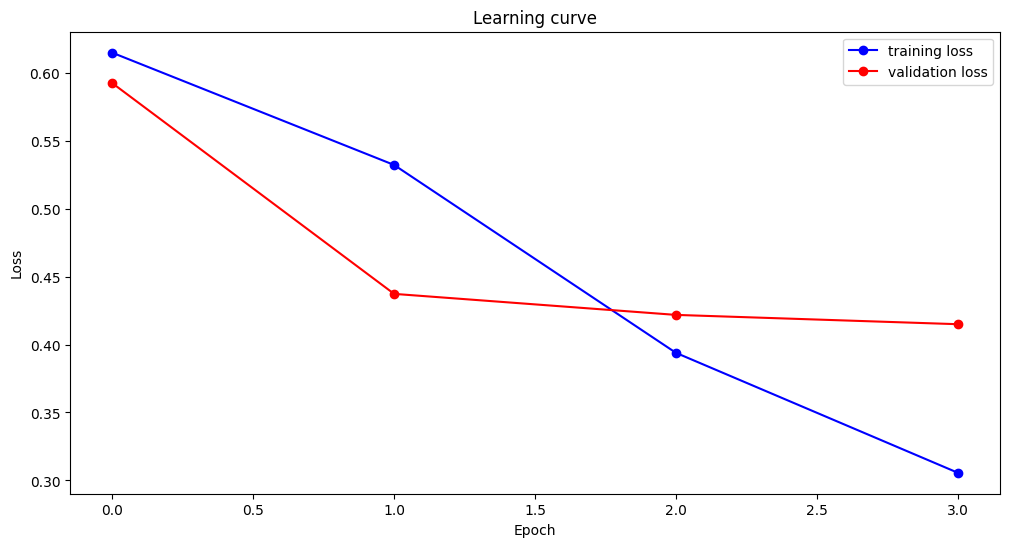

100%|██████████| 45/45 [00:10<00:00,  4.49it/s]


              precision    recall  f1-score   support

           0       0.85      0.89      0.87       988
           1       0.73      0.65      0.69       433

    accuracy                           0.82      1421
   macro avg       0.79      0.77      0.78      1421
weighted avg       0.82      0.82      0.82      1421



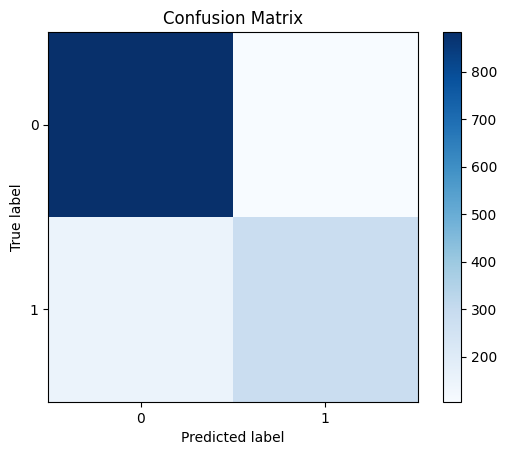

Cross Entropy for this fold: 0.4263838231563568
majority_community_1 - Average Cross Entropy: 0.4577343662579854
majority_community_1 - Average F1 Macro Score: 0.7598440741669181
Running experiment for majority_community_2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 24/24 [00:05<00:00,  4.51it/s]


Training loss: 0.6219071120023727, Validation loss: 0.5421019482115904
Epoch 2/4
----------


100%|██████████| 24/24 [00:05<00:00,  4.52it/s]


Training loss: 0.5015648552349635, Validation loss: 0.4846580612162749
Epoch 3/4
----------


100%|██████████| 24/24 [00:05<00:00,  4.50it/s]


Training loss: 0.3640051030686923, Validation loss: 0.49210825143381953
Epoch 4/4
----------


100%|██████████| 24/24 [00:05<00:00,  4.52it/s]


Training loss: 0.2951040525521551, Validation loss: 0.5018710535950959
Early stopping after 2 epochs with no improvement


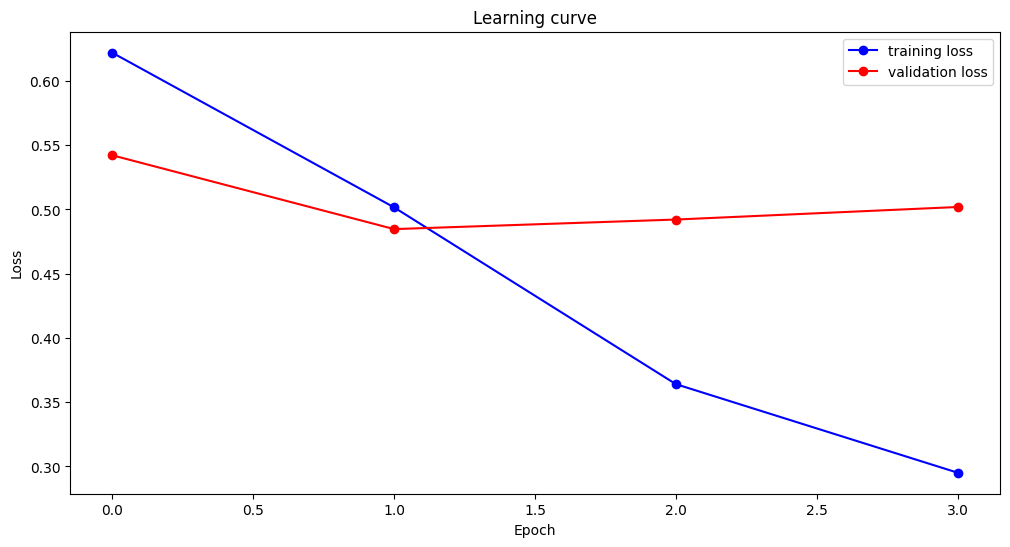

100%|██████████| 47/47 [00:10<00:00,  4.46it/s]


              precision    recall  f1-score   support

           0       0.81      0.81      0.81       947
           1       0.67      0.66      0.66       543

    accuracy                           0.76      1490
   macro avg       0.74      0.74      0.74      1490
weighted avg       0.76      0.76      0.76      1490



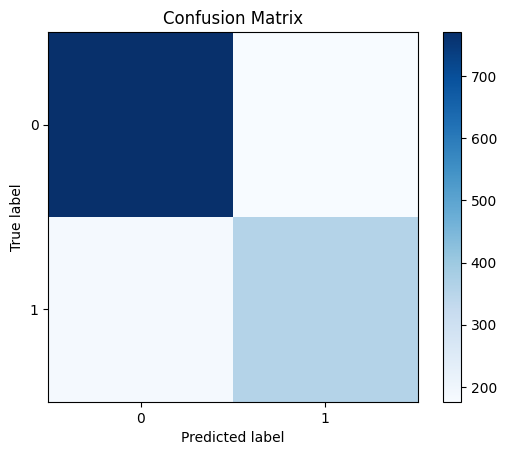

Cross Entropy for this fold: 0.5097955465316772


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 24/24 [00:05<00:00,  4.43it/s]


Training loss: 0.6416435407740729, Validation loss: 0.5727827375133833
Epoch 2/4
----------


100%|██████████| 24/24 [00:05<00:00,  4.42it/s]


Training loss: 0.5303013946328844, Validation loss: 0.5267134308815002
Epoch 3/4
----------


100%|██████████| 24/24 [00:05<00:00,  4.50it/s]


Training loss: 0.4031653649040631, Validation loss: 0.5405576191842556
Epoch 4/4
----------


100%|██████████| 24/24 [00:05<00:00,  4.53it/s]


Training loss: 0.31838837351117816, Validation loss: 0.5803388034303983
Early stopping after 2 epochs with no improvement


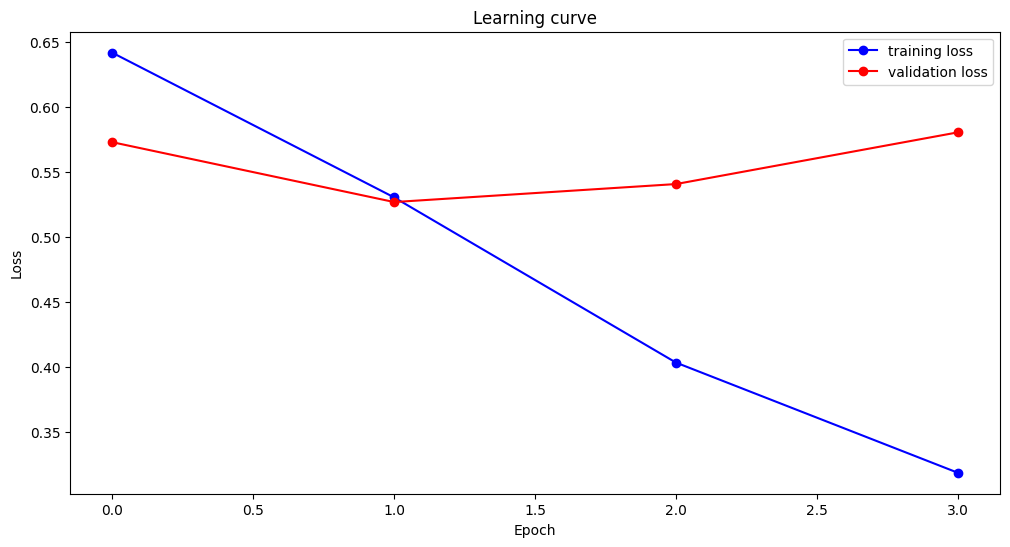

100%|██████████| 47/47 [00:10<00:00,  4.45it/s]


              precision    recall  f1-score   support

           0       0.80      0.81      0.81       946
           1       0.67      0.66      0.66       544

    accuracy                           0.76      1490
   macro avg       0.74      0.73      0.74      1490
weighted avg       0.75      0.76      0.75      1490



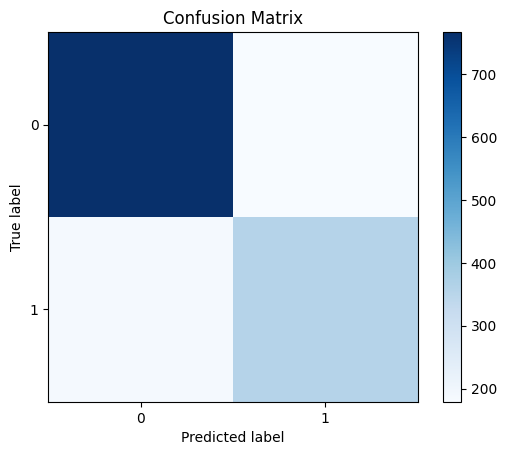

Cross Entropy for this fold: 0.4996708333492279


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 24/24 [00:05<00:00,  4.51it/s]


Training loss: 0.6411173118012292, Validation loss: 0.6001387064655622
Epoch 2/4
----------


100%|██████████| 24/24 [00:05<00:00,  4.50it/s]


Training loss: 0.5385317632130214, Validation loss: 0.5110641395052274
Epoch 3/4
----------


100%|██████████| 24/24 [00:05<00:00,  4.52it/s]


Training loss: 0.42818601429462433, Validation loss: 0.5085213618973891
Epoch 4/4
----------


100%|██████████| 24/24 [00:05<00:00,  4.51it/s]


Training loss: 0.34284558700663703, Validation loss: 0.5033993118753036


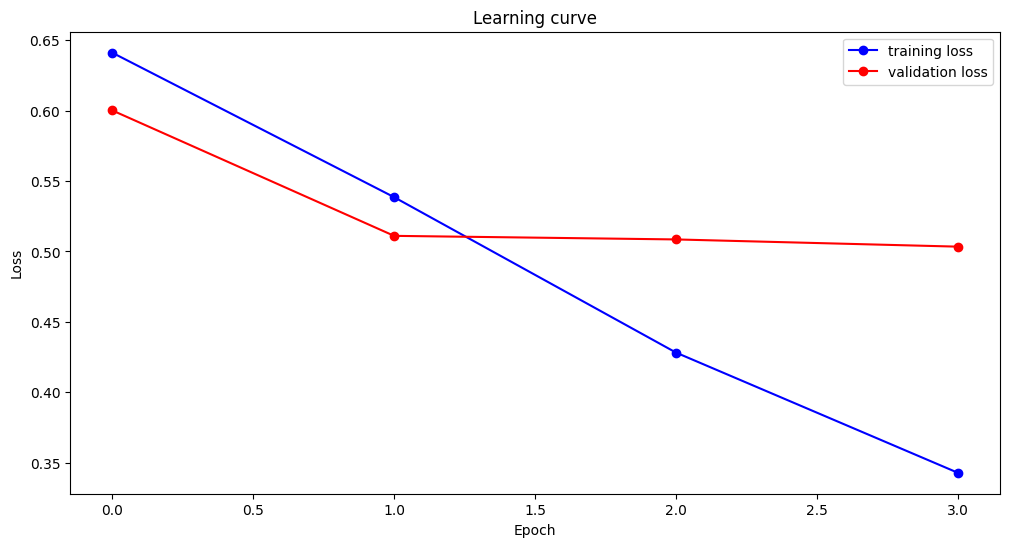

100%|██████████| 47/47 [00:10<00:00,  4.48it/s]


              precision    recall  f1-score   support

           0       0.80      0.80      0.80       946
           1       0.65      0.65      0.65       543

    accuracy                           0.74      1489
   macro avg       0.72      0.72      0.72      1489
weighted avg       0.74      0.74      0.74      1489



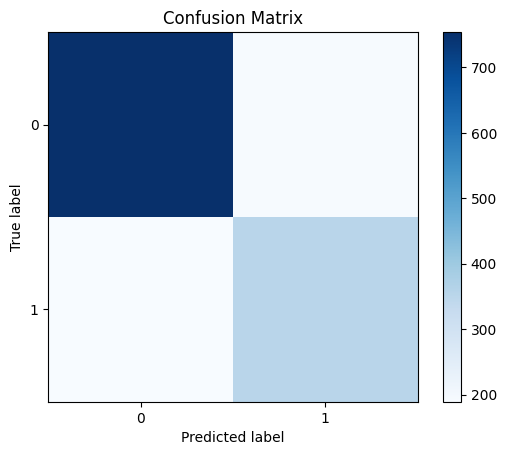

Cross Entropy for this fold: 0.549249529838562
majority_community_2 - Average Cross Entropy: 0.519571969906489
majority_community_2 - Average F1 Macro Score: 0.7322826930592231
Running experiment for majority_community_3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 24/24 [00:05<00:00,  4.41it/s]


Training loss: 0.6373642600244946, Validation loss: 0.5932573477427164
Epoch 2/4
----------


100%|██████████| 24/24 [00:05<00:00,  4.36it/s]


Training loss: 0.5317692102657424, Validation loss: 0.5191685010989507
Epoch 3/4
----------


100%|██████████| 24/24 [00:05<00:00,  4.39it/s]


Training loss: 0.41046445982323754, Validation loss: 0.5413237685958544
Epoch 4/4
----------


100%|██████████| 24/24 [00:05<00:00,  4.38it/s]


Training loss: 0.3177650755064355, Validation loss: 0.557037703692913
Early stopping after 2 epochs with no improvement


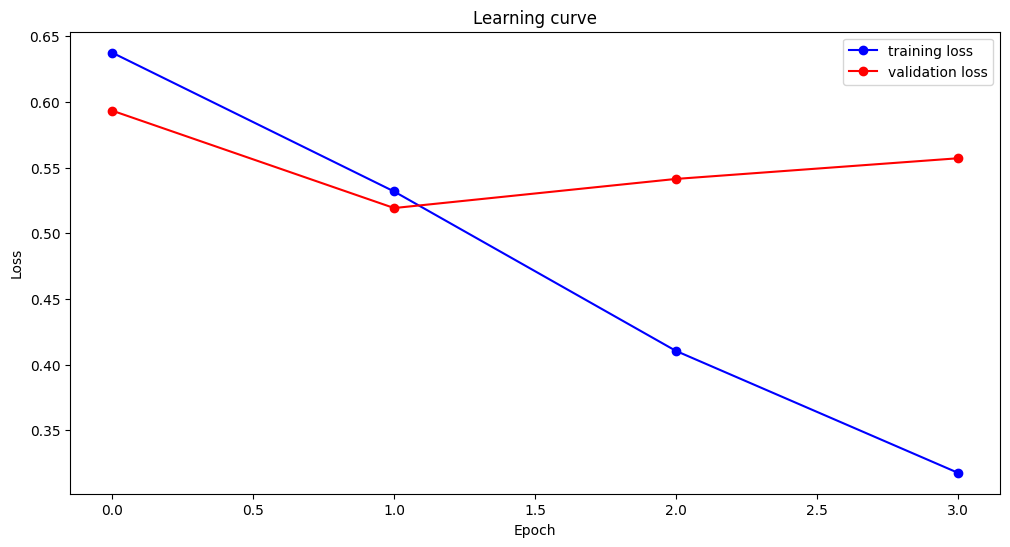

100%|██████████| 48/48 [00:10<00:00,  4.40it/s]


              precision    recall  f1-score   support

           0       0.76      0.89      0.82      1019
           1       0.67      0.43      0.53       515

    accuracy                           0.74      1534
   macro avg       0.72      0.66      0.67      1534
weighted avg       0.73      0.74      0.72      1534



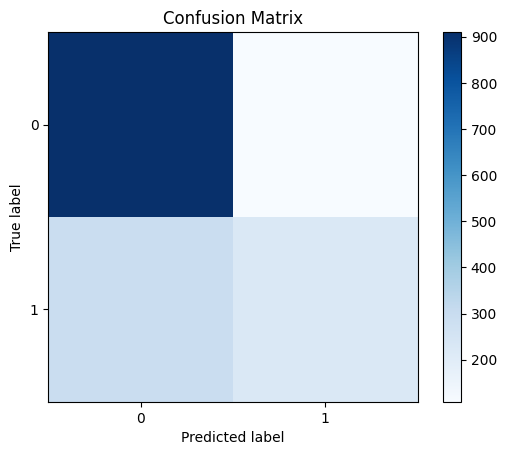

Cross Entropy for this fold: 0.5226661562919617


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 24/24 [00:05<00:00,  4.37it/s]


Training loss: 0.629300399372975, Validation loss: 0.5917301091055075
Epoch 2/4
----------


100%|██████████| 24/24 [00:05<00:00,  4.36it/s]


Training loss: 0.5524036114414533, Validation loss: 0.5304376048346361
Epoch 3/4
----------


100%|██████████| 24/24 [00:05<00:00,  4.40it/s]


Training loss: 0.41461456898185944, Validation loss: 0.5353422289093336
Epoch 4/4
----------


100%|██████████| 24/24 [00:05<00:00,  4.37it/s]


Training loss: 0.3098495126598411, Validation loss: 0.5770105086266994
Early stopping after 2 epochs with no improvement


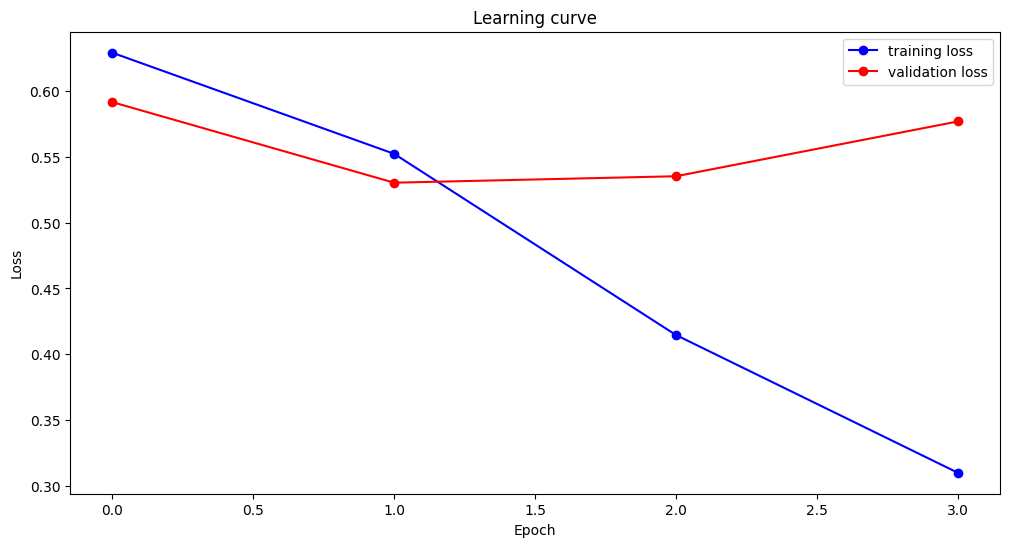

100%|██████████| 48/48 [00:10<00:00,  4.39it/s]


              precision    recall  f1-score   support

           0       0.76      0.92      0.83      1019
           1       0.72      0.43      0.54       515

    accuracy                           0.75      1534
   macro avg       0.74      0.67      0.68      1534
weighted avg       0.75      0.75      0.73      1534



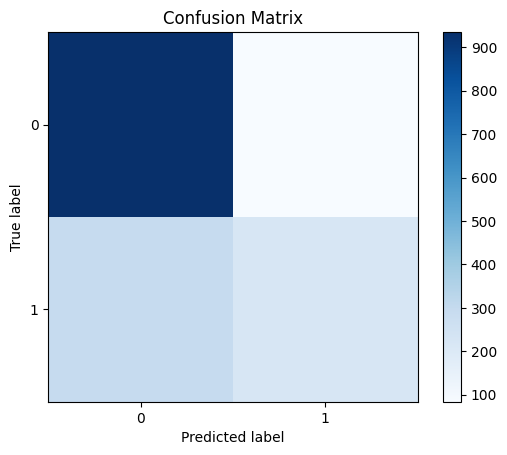

Cross Entropy for this fold: 0.5193040370941162


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 24/24 [00:05<00:00,  4.36it/s]


Training loss: 0.6170503261188666, Validation loss: 0.5600925497710705
Epoch 2/4
----------


100%|██████████| 24/24 [00:05<00:00,  4.35it/s]


Training loss: 0.4933100247548686, Validation loss: 0.5262400371332964
Epoch 3/4
----------


100%|██████████| 24/24 [00:05<00:00,  4.36it/s]


Training loss: 0.36077662578059566, Validation loss: 0.5592491415639719
Epoch 4/4
----------


100%|██████████| 24/24 [00:05<00:00,  4.39it/s]


Training loss: 0.26722481122447383, Validation loss: 0.5925451889634132
Early stopping after 2 epochs with no improvement


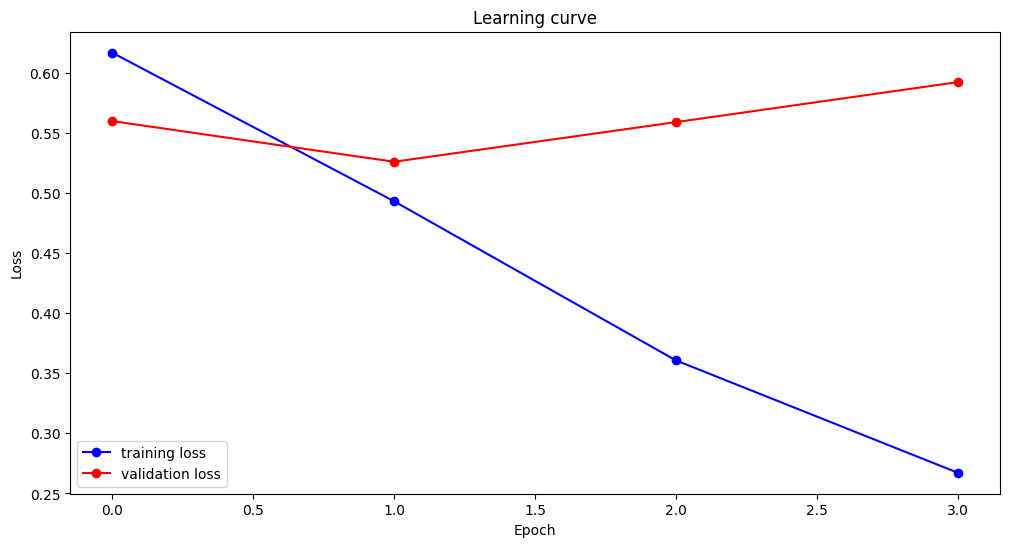

100%|██████████| 48/48 [00:10<00:00,  4.41it/s]


              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1018
           1       0.59      0.57      0.58       515

    accuracy                           0.72      1533
   macro avg       0.69      0.69      0.69      1533
weighted avg       0.72      0.72      0.72      1533



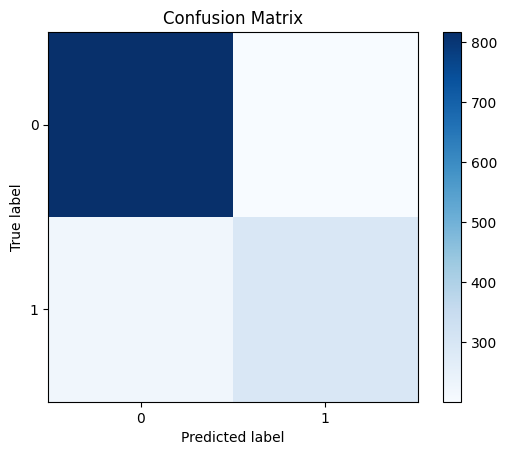

Cross Entropy for this fold: 0.5488964915275574
majority_community_3 - Average Cross Entropy: 0.5302888949712118
majority_community_3 - Average F1 Macro Score: 0.6819961106723208


In [ ]:
# Load the data
community_files = [
    "majority_community_0_data_final_md_leiden.csv",
    "majority_community_1_data_final_md_leiden.csv",
    "majority_community_2_data_final_md_leiden.csv",
    "majority_community_3_data_final_md_leiden.csv",
]
community_dfs = {f"majority_community_{i}": pd.read_csv(f"majority_community_{i}_data_final_md_leiden.csv") for i in range(len(community_files))}
combined_df = pd.read_csv("majority_combined_communities_data_final_md_leiden.csv")
combined_subset_df = pd.read_csv("majority_combined_subset_communities_data_final_md_leiden.csv")  # Load the subset combined dataset

f1_scores_dict = {}
cross_entropy_scores_dict = {}

# Run the experiment for the combined community
print("Running experiment for combined community")
community_name = "majority_combined_community"
cross_entropy, f1_macro = run_experiment_majority(combined_df, sample_frac=1.0, community_name=community_name)
f1_scores_dict[community_name] = f1_macro
cross_entropy_scores_dict[community_name] = cross_entropy

# Run the experiment for the combined subset community
print("Running experiment for combined subset community")
community_name = "majority_combined_subset_community"
cross_entropy, f1_macro = run_experiment_majority(combined_subset_df, sample_frac=1.0, community_name=community_name)
f1_scores_dict[community_name] = f1_macro
cross_entropy_scores_dict[community_name] = cross_entropy

# Run the experiment for each community
for community_name, community_df in community_dfs.items():
    print(f"Running experiment for {community_name}")
    cross_entropy, f1_macro = run_experiment_majority(community_df, sample_frac=1.0, community_name=community_name)
    f1_scores_dict[community_name] = f1_macro
    cross_entropy_scores_dict[community_name] = cross_entropy

In [ ]:
f1_scores_df = pd.DataFrame(list(f1_scores_dict.items()), columns=['Community', 'F1 Macro Score']).set_index('Community')
cross_entropy_scores_df = pd.DataFrame(list(cross_entropy_scores_dict.items()), columns=['Community', 'Cross Entropy']).set_index('Community')

In [ ]:
f1_scores_df

F1 Macro Score
Community                                         
majority_combined_community               0.763394
majority_combined_subset_community        0.715501
majority_community_0                      0.702214
majority_community_1                      0.759844
majority_community_2                      0.732283
majority_community_3                      0.681996

In [ ]:
cross_entropy_scores_df

Cross Entropy
Community                                        
majority_combined_community              0.413272
majority_combined_subset_community       0.477306
majority_community_0                     0.389885
majority_community_1                     0.457734
majority_community_2                     0.519572
majority_community_3                     0.530289

In [ ]:
# List of community names
community_names = [
    "majority_combined_community",
    "majority_combined_subset_community",
    "majority_community_0",
    "majority_community_1",
    "majority_community_2",
    "majority_community_3"
]

# Load and display incorrectly classified instances for each community
for community_name in community_names:
    # Load the incorrectly classified instances from the CSV file
    filename = f"{community_name}_incorrectly_classified_instances.csv"
    incorrectly_classified_df = pd.read_csv(filename)

    # Display the DataFrame (You can also perform any further analysis you need on this DataFrame)
    print(f"Incorrectly Classified Instances for {community_name}:")
    display(incorrectly_classified_df)


Incorrectly Classified Instances for majority_combined_community:


instance_id  offensiveness  \
0            1074              1   
1           10201              1   
2            5881              1   
3            2957              1   
4            9955              0   
...           ...            ...   
2024        10700              1   
2025         5851              1   
2026         3052              1   
2027         3565              0   
2028         8447              1   

                                           cleaned_text cleaned_domain  \
0     just stay the hell away from minneapolis, it i...            blm   
1     waiting for ‘s move. is bad for america! #trum...  elections2020   
2     i have found my self stopping to smell the ros...       covid-19   
3           another lie from this lying administration!  elections2020   
4                                period trum is a clown  elections2020   
...                                                 ...            ...   
2024    the guy is a clown but a very dangerous one !!!  elections2020   
2025  really? the loony left has morals now?! :squin...  elections2020   
2026  yes! i support your decision to never debate t...  elections2020   
2027  #covidー19 might be the best thing to happen to...       covid-19   
2028  do not you owe american voters the truth on wh...  elections2020   

                                       text_with_domain  predicted_label  \
0     blm just stay the hell away from minneapolis, ...                0   
1     elections2020 waiting for ‘s move. is bad for ...                0   
2     covid-19 i have found my self stopping to smel...                0   
3     elections2020 another lie from this lying admi...                0   
4                  elections2020 period trum is a clown                1   
...                                                 ...              ...   
2024  elections2020 the guy is a clown but a very da...                0   
2025  elections2020 really? the loony left has moral...                0   
2026  elections2020 yes! i support your decision to ...                0   
2027  covid-19 #covidー19 might be the best thing to ...                1   
2028  elections2020 do not you owe american voters t...                0   

      true_label  cross_entropy  
0              1       3.150320  
1              1       1.825257  
2              1       0.718741  
3              1       2.433446  
4              0       1.680309  
...          ...            ...  
2024           1       0.947098  
2025           1       1.398796  
2026           1       1.274441  
2027           0       1.143857  
2028           1       0.870760  

[2029 rows x 8 columns]

Incorrectly Classified Instances for majority_combined_subset_community:


instance_id  offensiveness  \
0           6397              1   
1           7387              0   
2           2905              1   
3           9383              1   
4            244              1   
..           ...            ...   
913         1913              0   
914         3749              0   
915          952              1   
916         3912              1   
917         1983              1   

                                          cleaned_text cleaned_domain  \
0    president trump brings death to america. #coro...       covid-19   
1    why do not donny just have his egotistical inf...       covid-19   
2    true, one must wonder why ny's nazi democrats ...       covid-19   
3    face of an angel, naughty like the devil :smil...            blm   
4                       why is an open nazi supporter?  elections2020   
..                                                 ...            ...   
913  there is a man somewhere in southie from the s...       covid-19   
914  you are way too much gentleman. become a stree...  elections2020   
915  anything that comes out of trumps mouth is eit...  elections2020   
916  i am sorry the coronavirus did not kill you yo...       covid-19   
917  what a shit show trump’s administration is. th...       covid-19   

                                      text_with_domain  predicted_label  \
0    covid-19 president trump brings death to ameri...                0   
1    covid-19 why do not donny just have his egotis...                1   
2    covid-19 true, one must wonder why ny's nazi d...                0   
3    blm face of an angel, naughty like the devil :...                0   
4         elections2020 why is an open nazi supporter?                0   
..                                                 ...              ...   
913  covid-19 there is a man somewhere in southie f...                1   
914  elections2020 you are way too much gentleman. ...                1   
915  elections2020 anything that comes out of trump...                0   
916  covid-19 i am sorry the coronavirus did not ki...                0   
917  covid-19 what a shit show trump’s administrati...                0   

     true_label  cross_entropy  
0             1       1.824644  
1             0       0.762802  
2             1       2.926522  
3             1       1.444622  
4             1       2.941530  
..          ...            ...  
913           0       1.314087  
914           0       0.788276  
915           1       1.474158  
916           1       1.275093  
917           1       1.305002  

[918 rows x 8 columns]

Incorrectly Classified Instances for majority_community_0:


instance_id  offensiveness  \
0           8798              1   
1           1529              1   
2          10306              0   
3          10558              1   
4          10144              0   
..           ...            ...   
569         8701              1   
570         4148              1   
571         5658              1   
572         3888              1   
573         9653              1   

                                          cleaned_text cleaned_domain  \
0    this is not about george floyd, but he is mock...            blm   
1    this is why you are an idiot as i said before....  elections2020   
2                                       barr is a liar       covid-19   
3    trump is a murderer! #makeamericagreatagain #m...       covid-19   
4    why not sue the govenors and the mayor's? they...            blm   
..                                                 ...            ...   
569  #police officer murdered by democrat black com...            blm   
570  pitchfork party! george floyd is strike 3 for ...            blm   
571  you should probably google breonna taylor, cha...            blm   
572  buahahaha you think we believe you give a crap...            blm   
573  in 2016, the president of s. korea was protest...            blm   

                                      text_with_domain  predicted_label  \
0    blm this is not about george floyd, but he is ...                0   
1    elections2020 this is why you are an idiot as ...                0   
2                              covid-19 barr is a liar                1   
3    covid-19 trump is a murderer! #makeamericagrea...                0   
4    blm why not sue the govenors and the mayor's? ...                1   
..                                                 ...              ...   
569  blm #police officer murdered by democrat black...                0   
570  blm pitchfork party! george floyd is strike 3 ...                0   
571  blm you should probably google breonna taylor,...                0   
572  blm buahahaha you think we believe you give a ...                0   
573  blm in 2016, the president of s. korea was pro...                0   

     true_label  cross_entropy  
0             1       1.053078  
1             1       1.610970  
2             0       0.754531  
3             1       3.038977  
4             0       1.099423  
..          ...            ...  
569           1       2.236401  
570           1       2.294670  
571           1       1.843600  
572           1       1.538369  
573           1       2.491869  

[574 rows x 8 columns]

Incorrectly Classified Instances for majority_community_1:


instance_id  offensiveness  \
0            942              1   
1            779              0   
2           2477              1   
3           2483              1   
4           1560              0   
..           ...            ...   
806         1151              0   
807         1307              1   
808         2520              1   
809         5648              1   
810          906              0   

                                          cleaned_text cleaned_domain  \
0    daily reminder that trump is a dumbass and has...            blm   
1    well, we see you just want silence the guilty ...  elections2020   
2    i do not know minneapolis pussy should at leas...            blm   
3    delusional pathological narcissist says what? ...  elections2020   
4    well there ya go. must have been russian bots,...       covid-19   
..                                                 ...            ...   
806  welcome to chavs. spitting on and assaulting r...            blm   
807  and i am not one to take this lightly or think...            blm   
808  this is not good news. this is, "oh you do not...            blm   
809                    biden wears a hearing aid idiot  elections2020   
810  the only thugs in this scenario are the four s...            blm   

                                      text_with_domain  predicted_label  \
0    blm daily reminder that trump is a dumbass and...                0   
1    elections2020 well, we see you just want silen...                1   
2    blm i do not know minneapolis pussy should at ...                0   
3    elections2020 delusional pathological narcissi...                0   
4    covid-19 well there ya go. must have been russ...                1   
..                                                 ...              ...   
806  blm welcome to chavs. spitting on and assaulti...                1   
807  blm and i am not one to take this lightly or t...                0   
808  blm this is not good news. this is, "oh you do...                0   
809      elections2020 biden wears a hearing aid idiot                0   
810  blm the only thugs in this scenario are the fo...                1   

     true_label  cross_entropy  
0             1       1.731811  
1             0       1.673846  
2             1       3.216984  
3             1       3.100965  
4             0       1.047046  
..          ...            ...  
806           0       1.830104  
807           1       3.312891  
808           1       0.770392  
809           1       1.609202  
810           0       0.845048  

[811 rows x 8 columns]

Incorrectly Classified Instances for majority_community_2:


instance_id  offensiveness  \
0            4353              0   
1            3177              0   
2            3443              1   
3            7493              1   
4            2322              1   
...           ...            ...   
1102         5066              1   
1103         6164              1   
1104         7791              1   
1105         3548              1   
1106         7853              0   

                                           cleaned_text cleaned_domain  \
0     got the second personal insult in too - callin...  elections2020   
1     you massively screwed up the early stages of a...       covid-19   
2                     my pussy will never be this good.       covid-19   
3     donald john trump murdered my dear mother. my ...       covid-19   
4                                        death to china       covid-19   
...                                                 ...            ...   
1102  seriously!? does kudlow think we will believe ...       covid-19   
1103  .......... this video pissed me smooth off... ...            blm   
1104  did you or someone you love shit your pants du...       covid-19   
1105  great covid19 survives up to nine days on surf...       covid-19   
1106  only idiots think that covid cares about why h...       covid-19   

                                       text_with_domain  predicted_label  \
0     elections2020 got the second personal insult i...                1   
1     covid-19 you massively screwed up the early st...                1   
2            covid-19 my pussy will never be this good.                0   
3     covid-19 donald john trump murdered my dear mo...                0   
4                               covid-19 death to china                0   
...                                                 ...              ...   
1102  covid-19 seriously!? does kudlow think we will...                0   
1103  blm .......... this video pissed me smooth off...                0   
1104  covid-19 did you or someone you love shit your...                0   
1105  covid-19 great covid19 survives up to nine day...                0   
1106  covid-19 only idiots think that covid cares ab...                1   

      true_label  cross_entropy  
0              0       1.425797  
1              0       1.077310  
2              1       1.394833  
3              1       2.175410  
4              1       2.860044  
...          ...            ...  
1102           1       1.839099  
1103           1       0.722401  
1104           1       2.143050  
1105           1       1.890439  
1106           0       0.818202  

[1107 rows x 8 columns]

Incorrectly Classified Instances for majority_community_3:


instance_id  offensiveness  \
0             543              1   
1            5227              1   
2            4115              1   
3            3818              0   
4            5322              1   
...           ...            ...   
1197         8510              0   
1198         6293              1   
1199         4649              0   
1200        10407              0   
1201         1408              1   

                                           cleaned_text cleaned_domain  \
0                     nothing scarier than a communist.  elections2020   
1     1500 buildings?? what the fukk!! no way our ta...            blm   
2     does meeting with, and praising, anti - semite...  elections2020   
3     a chronic compulsive liar; she even lies to he...  elections2020   
4                         the sheer stupidity amazes me       covid-19   
...                                                 ...            ...   
1197  we live in a republic and you all voted for a ...  elections2020   
1198  i have to disagree. that was no "puppy" but mo...  elections2020   
1199  it would look worse if she was out cackling, i...  elections2020   
1200  hey general powell says it straight. no one ha...            blm   
1201  plz read the book "the delectable negro", how ...            blm   

                                       text_with_domain  predicted_label  \
0       elections2020 nothing scarier than a communist.                0   
1     blm 1500 buildings?? what the fukk!! no way ou...                0   
2     elections2020 does meeting with, and praising,...                0   
3     elections2020 a chronic compulsive liar; she e...                1   
4                covid-19 the sheer stupidity amazes me                0   
...                                                 ...              ...   
1197  elections2020 we live in a republic and you al...                1   
1198  elections2020 i have to disagree. that was no ...                0   
1199  elections2020 it would look worse if she was o...                1   
1200  blm hey general powell says it straight. no on...                1   
1201  blm plz read the book "the delectable negro", ...                0   

      true_label  cross_entropy  
0              1       2.036741  
1              1       2.196140  
2              1       2.024578  
3              0       0.830134  
4              1       1.810117  
...          ...            ...  
1197           0       0.809499  
1198           1       0.906094  
1199           0       1.009085  
1200           0       0.878700  
1201           1       1.188394  

[1202 rows x 8 columns]

# Model 2: Separate models for communities and combined based on inidivdual ratings

*The following isn't used due to halt in model training. The final model is run below that.*

Running experiment for combined community


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 256/256 [00:58<00:00,  4.41it/s]


Training loss: 0.5197562554330801, Validation loss: 0.5065641937544569
Epoch 2/4
----------


100%|██████████| 256/256 [00:57<00:00,  4.41it/s]


Training loss: 0.456324652479305, Validation loss: 0.50588095234707
Epoch 3/4
----------


100%|██████████| 256/256 [00:57<00:00,  4.42it/s]


Training loss: 0.4226379084447034, Validation loss: 0.5165481193980668
Epoch 4/4
----------


100%|██████████| 256/256 [00:57<00:00,  4.42it/s]


Training loss: 0.39286559333844845, Validation loss: 0.5199672609160189
Early stopping after 2 epochs with no improvement


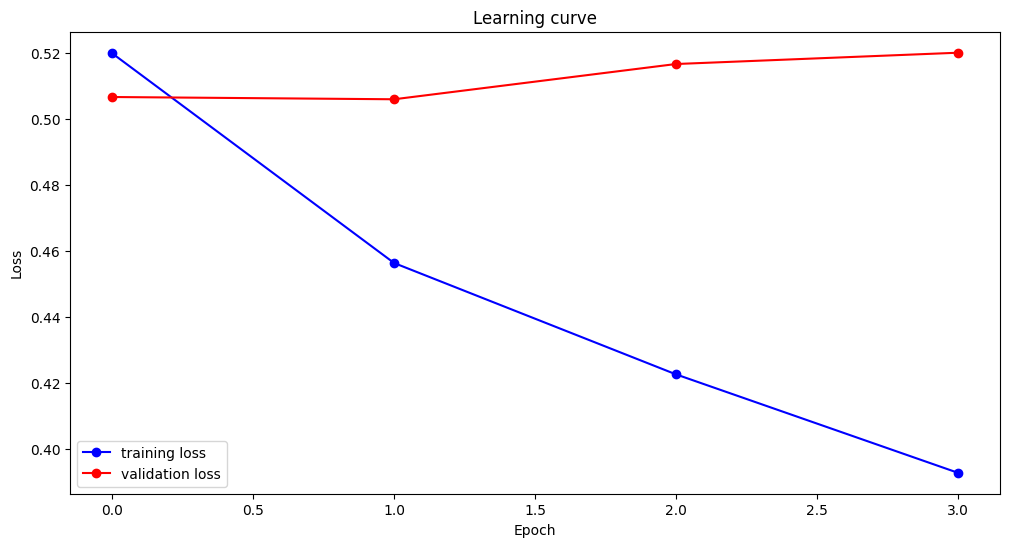

100%|██████████| 515/515 [01:56<00:00,  4.41it/s]


              precision    recall  f1-score   support

           0       0.80      0.84      0.82     10864
           1       0.65      0.58      0.61      5586

    accuracy                           0.75     16450
   macro avg       0.72      0.71      0.72     16450
weighted avg       0.75      0.75      0.75     16450



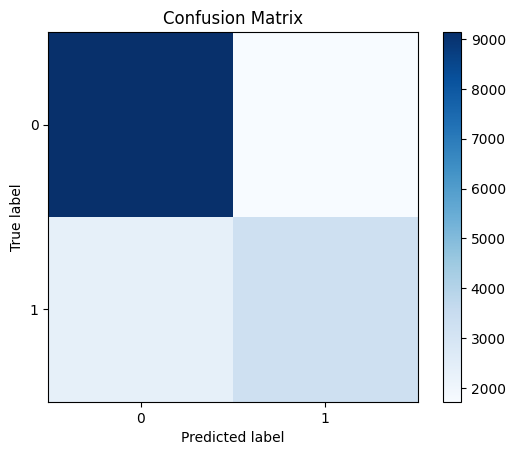

Cross Entropy for this fold: 0.5067704916000366


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 258/258 [00:58<00:00,  4.41it/s]


Training loss: 0.5377266282836596, Validation loss: 0.49152447254389753
Epoch 2/4
----------


100%|██████████| 258/258 [00:58<00:00,  4.41it/s]


Training loss: 0.4633856875395092, Validation loss: 0.48894743072663166
Epoch 3/4
----------


100%|██████████| 258/258 [00:58<00:00,  4.41it/s]


Training loss: 0.4272730639398408, Validation loss: 0.4896628601953041
Epoch 4/4
----------


100%|██████████| 258/258 [00:58<00:00,  4.40it/s]


Training loss: 0.39906306196159375, Validation loss: 0.4959144498142161
Early stopping after 2 epochs with no improvement


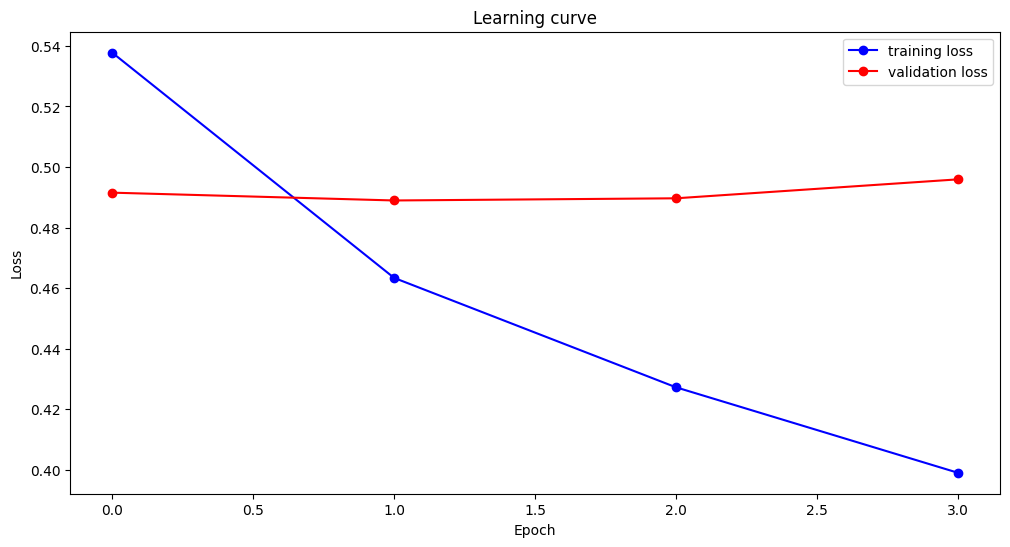

100%|██████████| 511/511 [01:56<00:00,  4.40it/s]


              precision    recall  f1-score   support

           0       0.78      0.87      0.82     10782
           1       0.68      0.53      0.59      5547

    accuracy                           0.76     16329
   macro avg       0.73      0.70      0.71     16329
weighted avg       0.75      0.76      0.75     16329



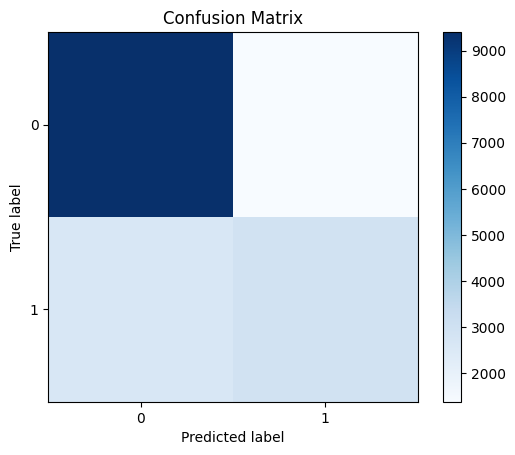

Cross Entropy for this fold: 0.49645018577575684


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 257/257 [00:58<00:00,  4.41it/s]


Training loss: 0.5289390089065418, Validation loss: 0.5117064649347897
Epoch 2/4
----------


100%|██████████| 257/257 [00:58<00:00,  4.42it/s]


Training loss: 0.46063500179658473, Validation loss: 0.5008469086488281
Epoch 3/4
----------


100%|██████████| 257/257 [00:58<00:00,  4.42it/s]


Training loss: 0.42531839768815255, Validation loss: 0.5087219003573465
Epoch 4/4
----------


100%|██████████| 257/257 [00:58<00:00,  4.43it/s]


Training loss: 0.39594718682130386, Validation loss: 0.5185333802536898
Early stopping after 2 epochs with no improvement


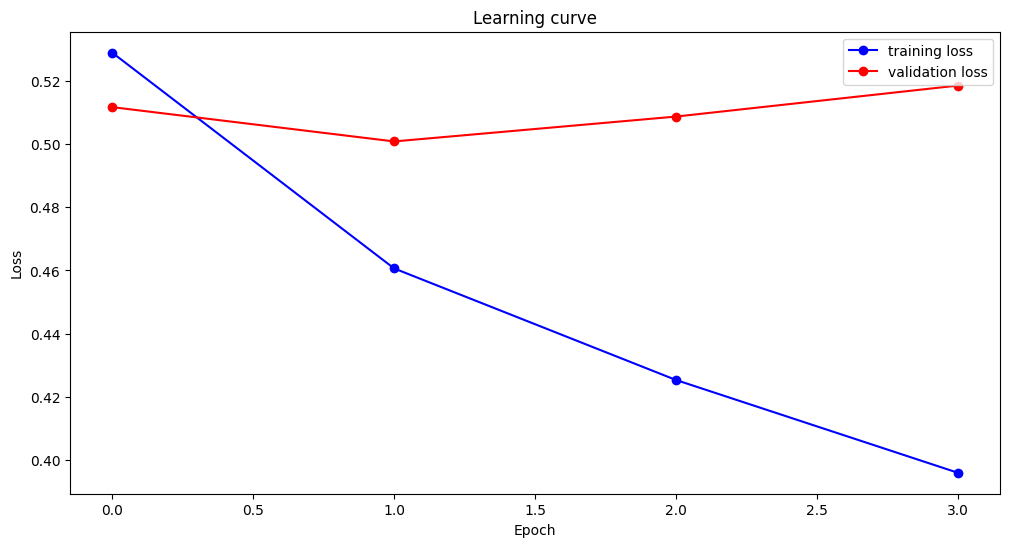

100%|██████████| 511/511 [01:55<00:00,  4.41it/s]


              precision    recall  f1-score   support

           0       0.81      0.84      0.82     10715
           1       0.66      0.62      0.64      5617

    accuracy                           0.76     16332
   macro avg       0.74      0.73      0.73     16332
weighted avg       0.76      0.76      0.76     16332



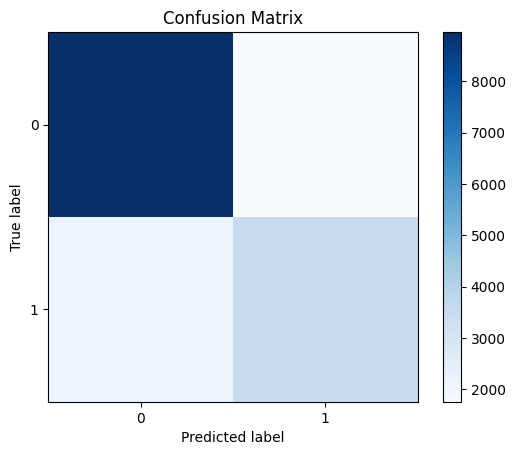

Cross Entropy for this fold: 0.4928073287010193
combined_community - Average Cross Entropy: 0.49867600202560425
combined_community - Average F1 Macro Score: 0.7190827964308615
Running experiment for combined subset community


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 63/63 [00:14<00:00,  4.40it/s]


Training loss: 0.5731432846298924, Validation loss: 0.5137374774804191
Epoch 2/4
----------


100%|██████████| 63/63 [00:14<00:00,  4.43it/s]


Training loss: 0.46921444104777443, Validation loss: 0.525247702995936
Epoch 3/4
----------


100%|██████████| 63/63 [00:14<00:00,  4.41it/s]


Training loss: 0.39055692510945456, Validation loss: 0.5518330406574976
Early stopping after 2 epochs with no improvement


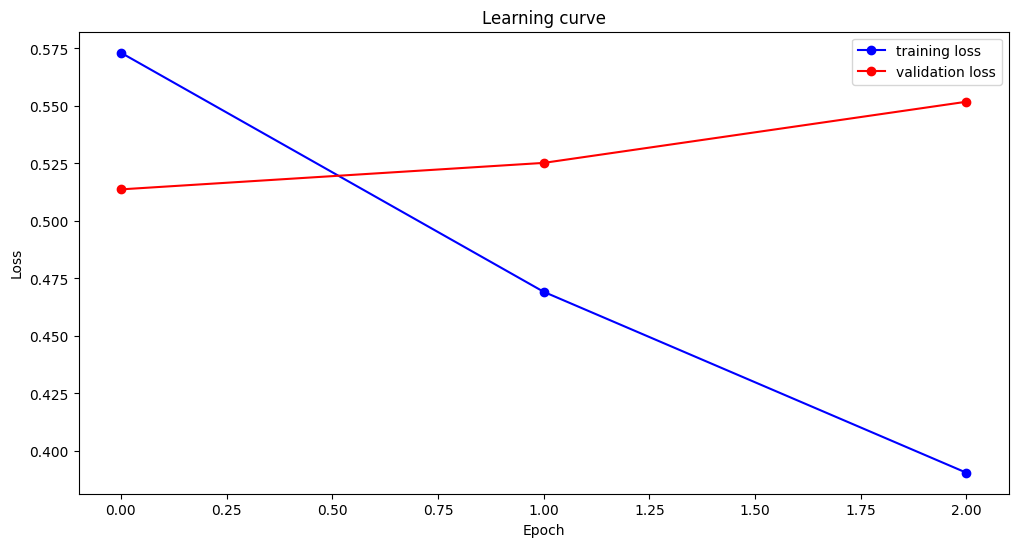

100%|██████████| 125/125 [00:28<00:00,  4.42it/s]


              precision    recall  f1-score   support

           0       0.78      0.86      0.82      2667
           1       0.65      0.51      0.57      1310

    accuracy                           0.75      3977
   macro avg       0.71      0.69      0.70      3977
weighted avg       0.74      0.75      0.74      3977



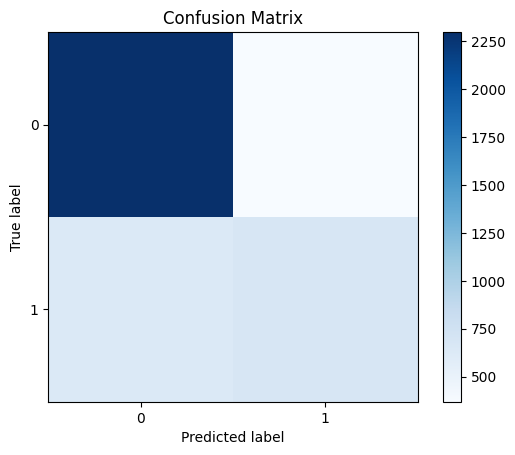

Cross Entropy for this fold: 0.518083930015564


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 64/64 [00:14<00:00,  4.42it/s]


Training loss: 0.5574944017715352, Validation loss: 0.5471525806933641
Epoch 2/4
----------


100%|██████████| 64/64 [00:14<00:00,  4.41it/s]


Training loss: 0.4548090415936644, Validation loss: 0.5332107758149505
Epoch 3/4
----------


100%|██████████| 64/64 [00:14<00:00,  4.42it/s]


Training loss: 0.3777799409243368, Validation loss: 0.5669873850420117
Epoch 4/4
----------


100%|██████████| 64/64 [00:14<00:00,  4.43it/s]


Training loss: 0.3190280111726894, Validation loss: 0.6072612605057657
Early stopping after 2 epochs with no improvement


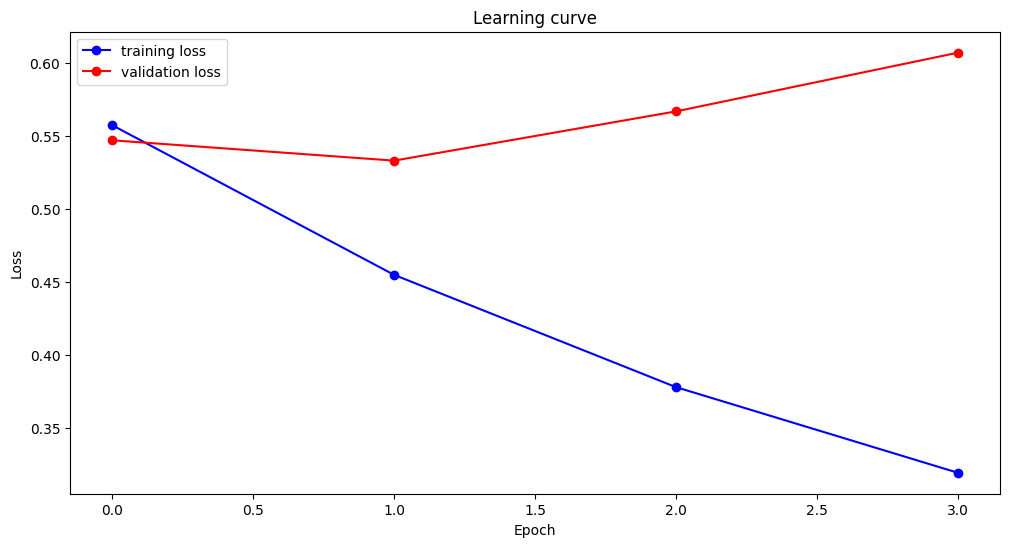

100%|██████████| 126/126 [00:28<00:00,  4.41it/s]


              precision    recall  f1-score   support

           0       0.80      0.82      0.81      2663
           1       0.63      0.59      0.61      1364

    accuracy                           0.74      4027
   macro avg       0.71      0.71      0.71      4027
weighted avg       0.74      0.74      0.74      4027



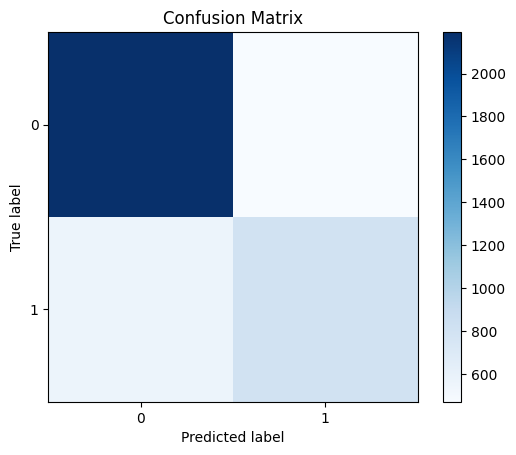

Cross Entropy for this fold: 0.5150087475776672


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
----------


100%|██████████| 63/63 [00:14<00:00,  4.42it/s]


Training loss: 0.5852590279376253, Validation loss: 0.5126829416978926
Epoch 2/4
----------


 87%|████████▋ | 55/63 [00:12<00:01,  4.38it/s]

In [ ]:
# Load the data
community_files = [
    "community_0_data_final_md_leiden.csv",
    "community_1_data_final_md_leiden.csv",
    "community_2_data_final_md_leiden.csv",
    "community_3_data_final_md_leiden.csv",
]
community_dfs = {f"community_{i}": pd.read_csv(f"community_{i}_data_final_md_leiden.csv") for i in range(len(community_files))}
combined_df = pd.read_csv("combined_communities_data_final_md_leiden.csv")
combined_subset_df = pd.read_csv("combined_subset_communities_data_final_md_leiden.csv")  # Load the subset combined dataset

f1_scores_dict = {}
cross_entropy_scores_dict = {}

# Run the experiment for the combined community
print("Running experiment for combined community")
community_name = "combined_community"
cross_entropy, f1_macro = run_experiment_individual(combined_df, sample_frac=1.0, community_name=community_name)
f1_scores_dict[community_name] = f1_macro
cross_entropy_scores_dict[community_name] = cross_entropy

# Run the experiment for the combined subset community
print("Running experiment for combined subset community")
community_name = "combined_subset_community"
cross_entropy, f1_macro = run_experiment_individual(combined_subset_df, sample_frac=1.0, community_name=community_name)
f1_scores_dict[community_name] = f1_macro
cross_entropy_scores_dict[community_name] = cross_entropy

# Run the experiment for each community
for community_name, community_df in community_dfs.items():
    print(f"Running experiment for {community_name}")
    cross_entropy, f1_macro = run_experiment_individual(community_df, sample_frac=1.0, community_name=community_name)
    f1_scores_dict[community_name] = f1_macro
    cross_entropy_scores_dict[community_name] = cross_entropy

Due to limited GPU available, this code stopped running after running on combined dataset therefore will change epochs to 2 for the following runs. This is also due to the previous models early stopping after 2 epochs with no improvement.

Running experiment for community_0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
----------


100%|██████████| 64/64 [00:14<00:00,  4.54it/s]


Training loss: 0.5098640152158584, Validation loss: 0.4437187847215682
Epoch 2/2
----------


100%|██████████| 64/64 [00:14<00:00,  4.52it/s]


Training loss: 0.4151311743068185, Validation loss: 0.44173158856574446


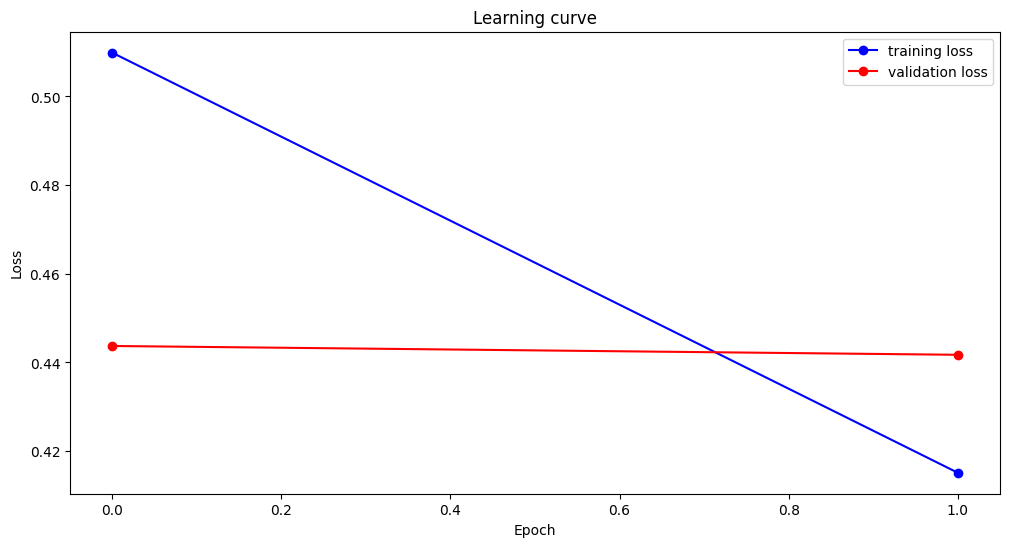

100%|██████████| 124/124 [00:29<00:00,  4.21it/s]


              precision    recall  f1-score   support

           0       0.83      0.92      0.87      2933
           1       0.67      0.45      0.54      1014

    accuracy                           0.80      3947
   macro avg       0.75      0.69      0.71      3947
weighted avg       0.79      0.80      0.79      3947



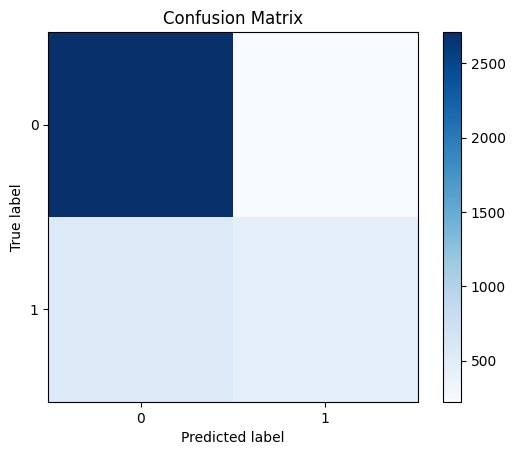

Cross Entropy for this fold: 0.44701382517814636


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
----------


100%|██████████| 64/64 [00:15<00:00,  4.24it/s]


Training loss: 0.4980710359180675, Validation loss: 0.609163009095937
Epoch 2/2
----------


100%|██████████| 64/64 [00:15<00:00,  4.23it/s]


Training loss: 0.4191031663175573, Validation loss: 0.47577638225629926


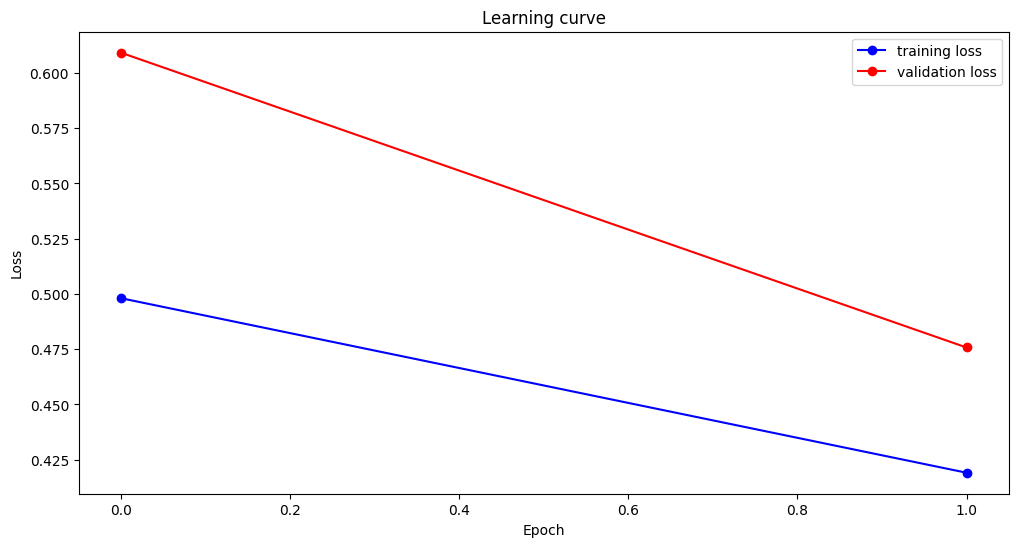

100%|██████████| 125/125 [00:29<00:00,  4.19it/s]


              precision    recall  f1-score   support

           0       0.82      0.93      0.87      2957
           1       0.67      0.39      0.49      1022

    accuracy                           0.79      3979
   macro avg       0.74      0.66      0.68      3979
weighted avg       0.78      0.79      0.77      3979



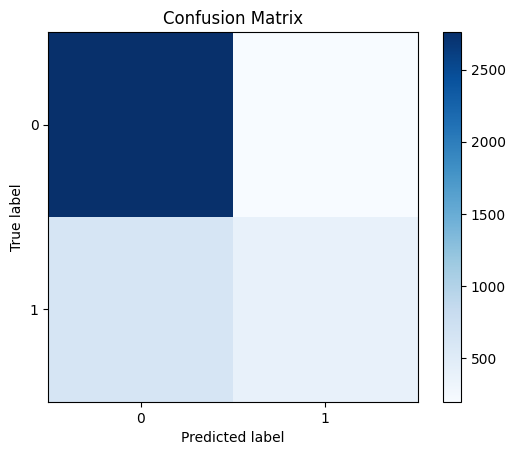

Cross Entropy for this fold: 0.47050702571868896


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
----------


100%|██████████| 63/63 [00:14<00:00,  4.22it/s]


Training loss: 0.5002760319940506, Validation loss: 0.45547736743612893
Epoch 2/2
----------


100%|██████████| 63/63 [00:14<00:00,  4.21it/s]


Training loss: 0.4152228058345856, Validation loss: 0.4500513191497515


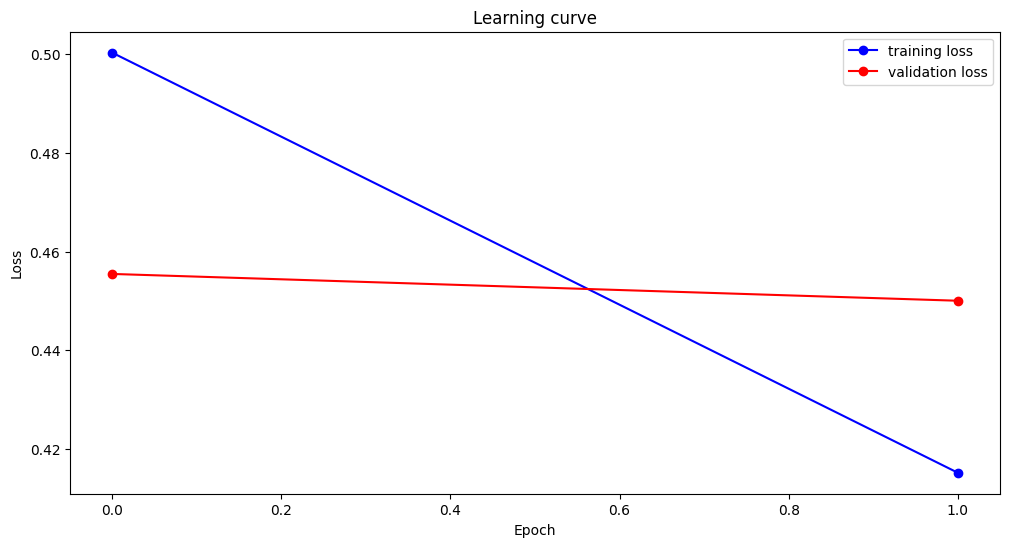

100%|██████████| 126/126 [00:30<00:00,  4.16it/s]


              precision    recall  f1-score   support

           0       0.82      0.92      0.87      3053
           1       0.61      0.37      0.46       976

    accuracy                           0.79      4029
   macro avg       0.72      0.65      0.66      4029
weighted avg       0.77      0.79      0.77      4029



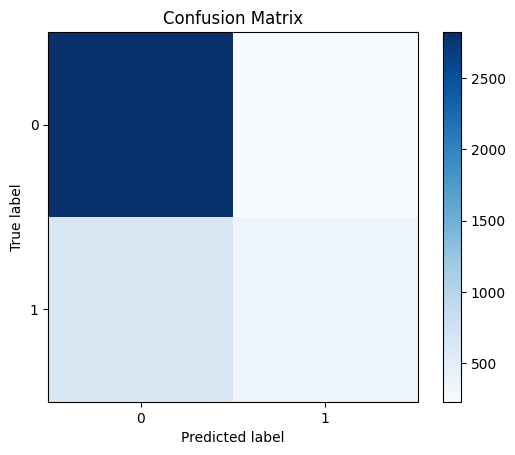

Cross Entropy for this fold: 0.4614707827568054
community_0 - Average Cross Entropy: 0.45966387788454693
community_0 - Average F1 Macro Score: 0.6835387670458907
Running experiment for community_1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
----------


100%|██████████| 76/76 [00:17<00:00,  4.25it/s]


Training loss: 0.5603697494866979, Validation loss: 0.5257461931752531
Epoch 2/2
----------


100%|██████████| 76/76 [00:18<00:00,  4.22it/s]


Training loss: 0.45542936963874076, Validation loss: 0.5276493835998209


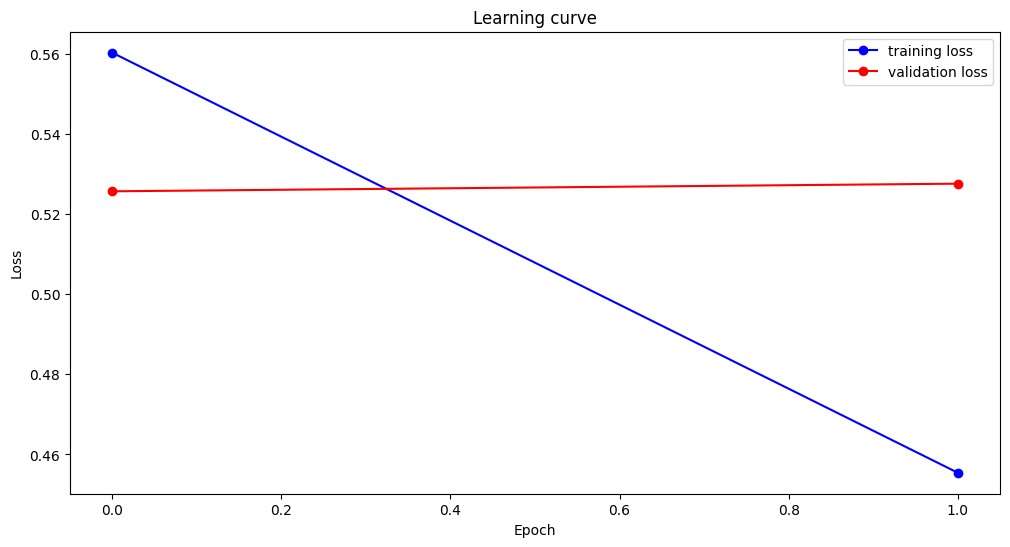

100%|██████████| 160/160 [00:38<00:00,  4.19it/s]


              precision    recall  f1-score   support

           0       0.78      0.88      0.83      3361
           1       0.69      0.52      0.59      1753

    accuracy                           0.76      5114
   macro avg       0.73      0.70      0.71      5114
weighted avg       0.75      0.76      0.75      5114



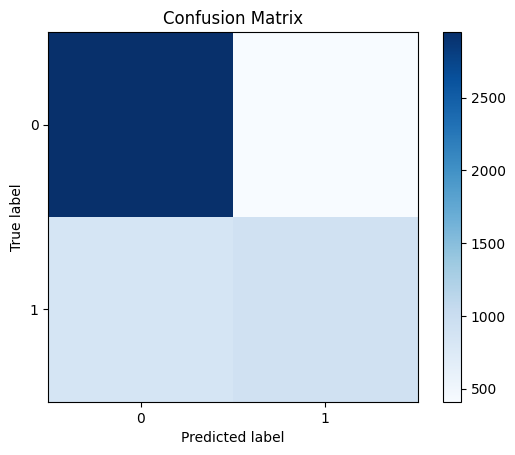

Cross Entropy for this fold: 0.5146291255950928


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
----------


100%|██████████| 79/79 [00:18<00:00,  4.24it/s]


Training loss: 0.5531107542895469, Validation loss: 0.5054721040061757
Epoch 2/2
----------


100%|██████████| 79/79 [00:18<00:00,  4.25it/s]


Training loss: 0.4504639616533488, Validation loss: 0.5019406512191024


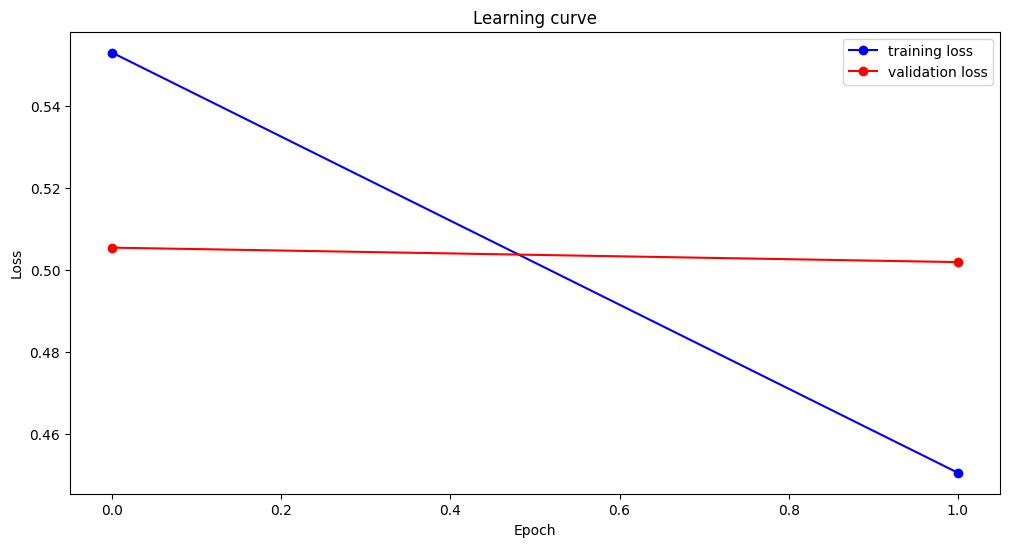

100%|██████████| 156/156 [00:37<00:00,  4.15it/s]


              precision    recall  f1-score   support

           0       0.78      0.87      0.82      3231
           1       0.69      0.54      0.60      1740

    accuracy                           0.75      4971
   macro avg       0.73      0.70      0.71      4971
weighted avg       0.75      0.75      0.75      4971



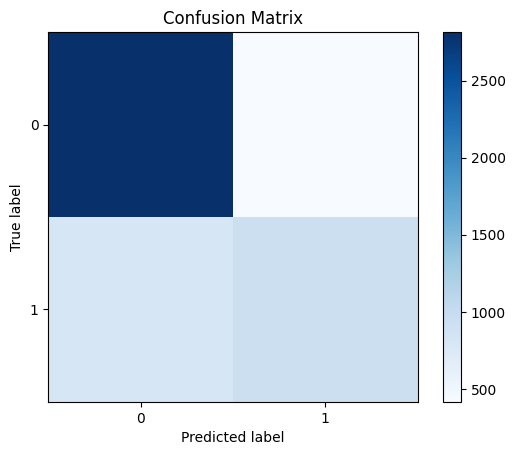

Cross Entropy for this fold: 0.5085212588310242


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
----------


100%|██████████| 77/77 [00:18<00:00,  4.24it/s]


Training loss: 0.5741197771108301, Validation loss: 0.5269971337024267
Epoch 2/2
----------


100%|██████████| 77/77 [00:18<00:00,  4.24it/s]


Training loss: 0.4666286502423147, Validation loss: 0.5109547773351917


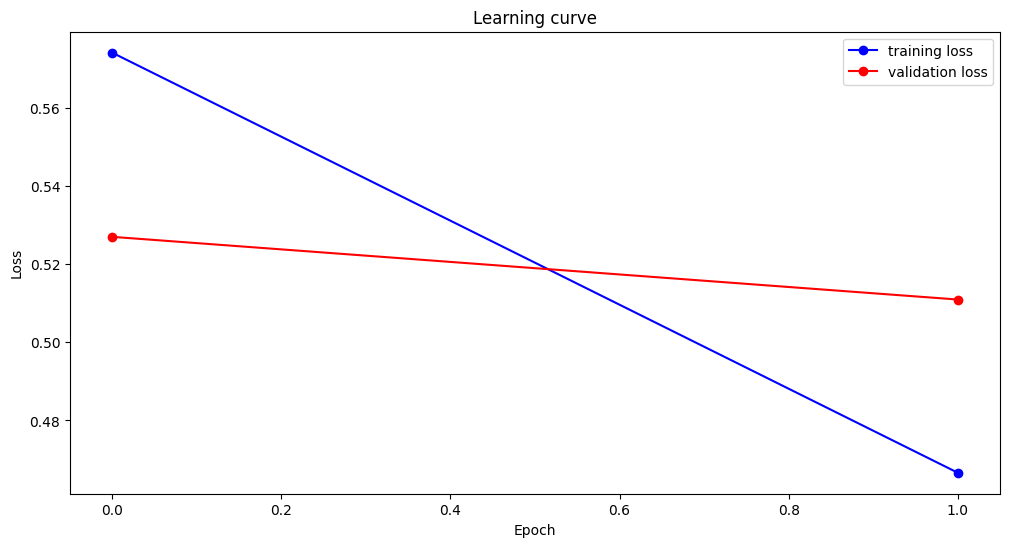

100%|██████████| 157/157 [00:38<00:00,  4.12it/s]


              precision    recall  f1-score   support

           0       0.80      0.84      0.82      3285
           1       0.66      0.60      0.63      1713

    accuracy                           0.76      4998
   macro avg       0.73      0.72      0.72      4998
weighted avg       0.75      0.76      0.75      4998



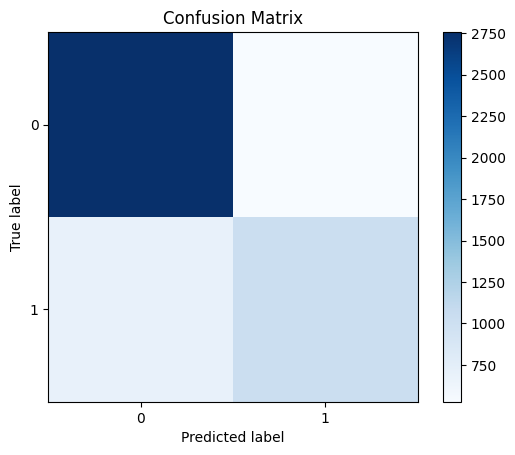

Cross Entropy for this fold: 0.496798038482666
community_1 - Average Cross Entropy: 0.5066494743029276
community_1 - Average F1 Macro Score: 0.7150971303783159
Running experiment for community_2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
----------


100%|██████████| 63/63 [00:15<00:00,  4.18it/s]


Training loss: 0.6057169005111024, Validation loss: 0.5556832178244515
Epoch 2/2
----------


100%|██████████| 63/63 [00:15<00:00,  4.16it/s]


Training loss: 0.5082890921077885, Validation loss: 0.5518171583849286


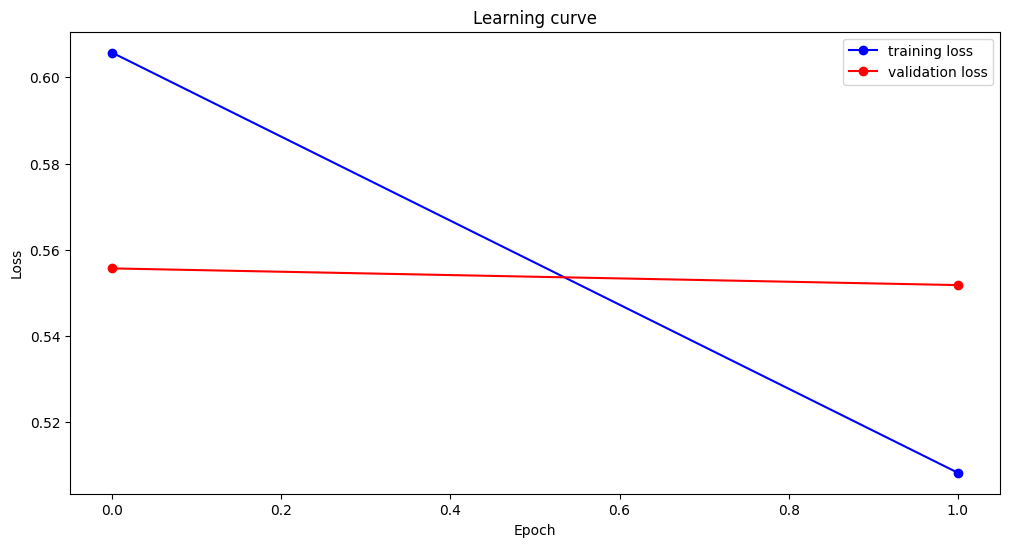

100%|██████████| 119/119 [00:28<00:00,  4.17it/s]


              precision    recall  f1-score   support

           0       0.75      0.81      0.78      2304
           1       0.66      0.58      0.61      1477

    accuracy                           0.72      3781
   macro avg       0.70      0.69      0.70      3781
weighted avg       0.71      0.72      0.71      3781



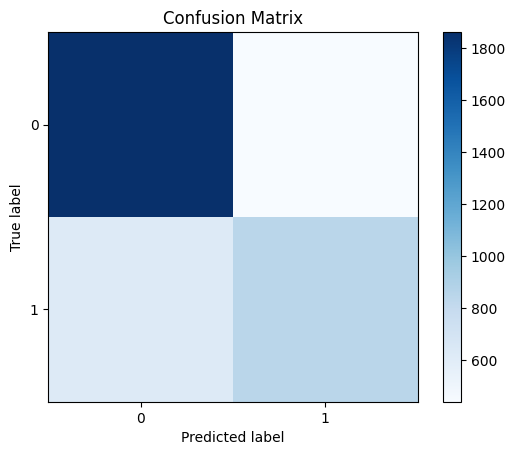

Cross Entropy for this fold: 0.5446144938468933


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
----------


100%|██████████| 61/61 [00:15<00:00,  3.87it/s]


Training loss: 0.6025231104758051, Validation loss: 0.5724676593405301
Epoch 2/2
----------


100%|██████████| 61/61 [00:15<00:00,  3.87it/s]


Training loss: 0.49841343495580887, Validation loss: 0.5391674637794495


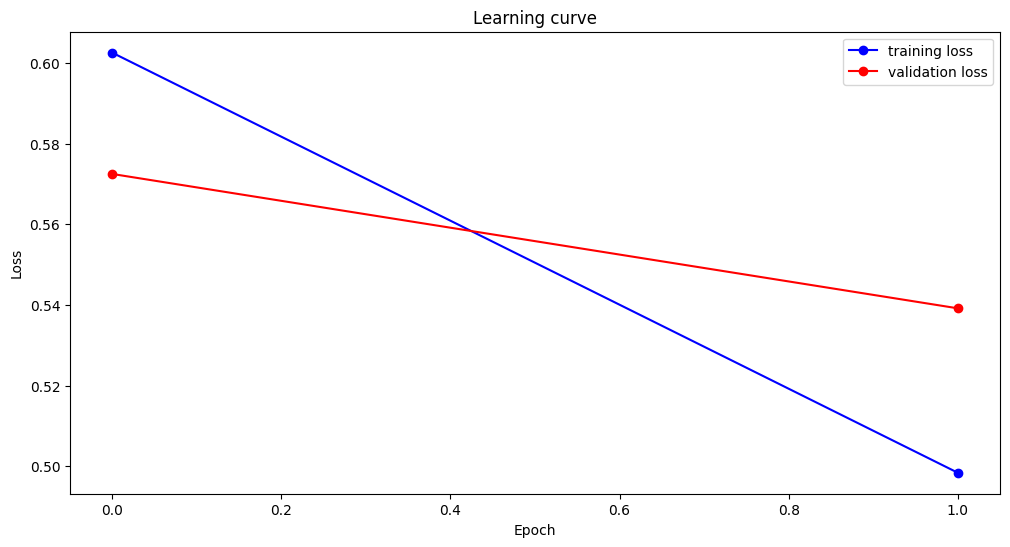

100%|██████████| 122/122 [00:29<00:00,  4.14it/s]


              precision    recall  f1-score   support

           0       0.74      0.78      0.76      2376
           1       0.63      0.58      0.61      1528

    accuracy                           0.70      3904
   macro avg       0.69      0.68      0.69      3904
weighted avg       0.70      0.70      0.70      3904



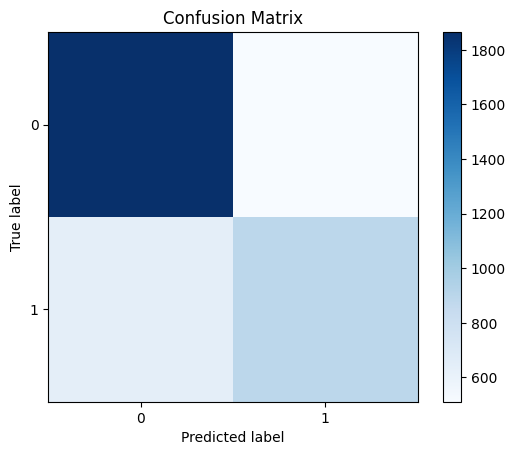

Cross Entropy for this fold: 0.5594858527183533


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
----------


100%|██████████| 60/60 [00:14<00:00,  4.21it/s]


Training loss: 0.6133937234707301, Validation loss: 0.5771920591592788
Epoch 2/2
----------


100%|██████████| 60/60 [00:14<00:00,  4.19it/s]


Training loss: 0.5084693436793859, Validation loss: 0.5608007217446963


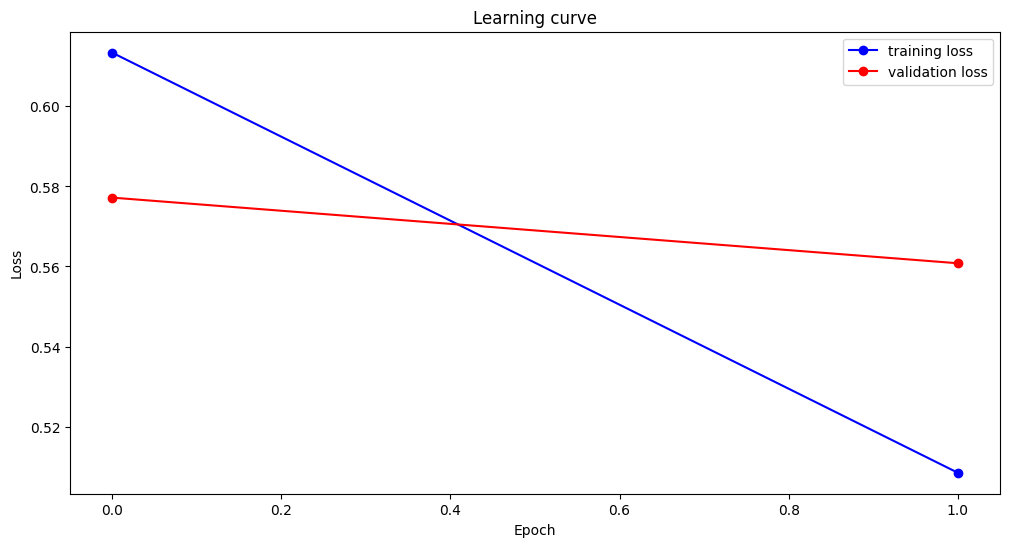

100%|██████████| 123/123 [00:29<00:00,  4.18it/s]


              precision    recall  f1-score   support

           0       0.77      0.79      0.78      2426
           1       0.64      0.62      0.63      1481

    accuracy                           0.72      3907
   macro avg       0.71      0.70      0.71      3907
weighted avg       0.72      0.72      0.72      3907



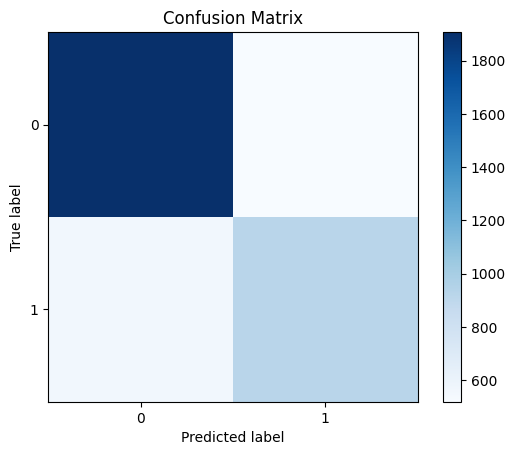

Cross Entropy for this fold: 0.5344670414924622
community_2 - Average Cross Entropy: 0.5461891293525696
community_2 - Average F1 Macro Score: 0.6955134060109751
Running experiment for community_3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
----------


100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Training loss: 0.6148517100531378, Validation loss: 0.5761623702266
Epoch 2/2
----------


100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Training loss: 0.5129346181581049, Validation loss: 0.5668866943229328


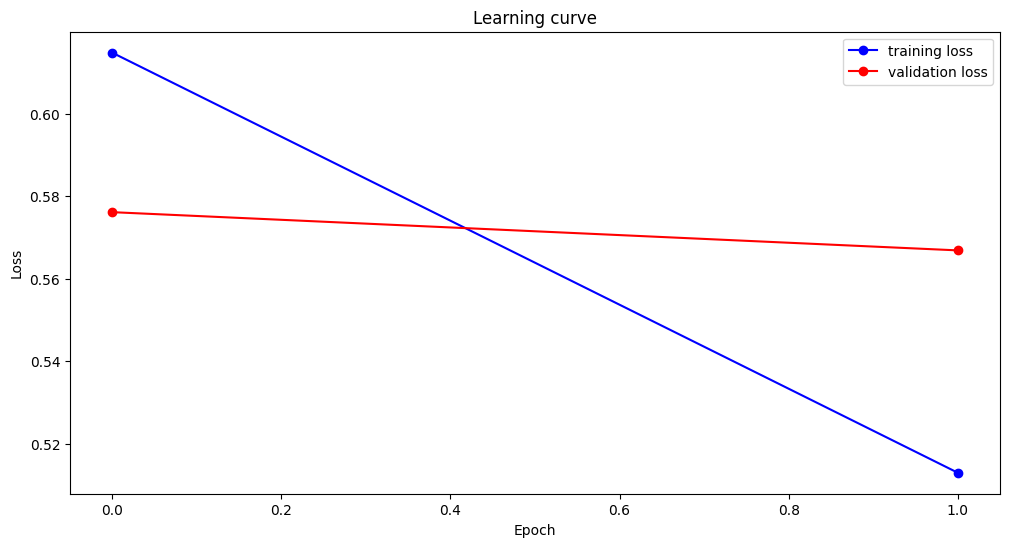

100%|██████████| 111/111 [00:27<00:00,  4.11it/s]


              precision    recall  f1-score   support

           0       0.74      0.83      0.78      2153
           1       0.67      0.54      0.60      1396

    accuracy                           0.71      3549
   macro avg       0.70      0.68      0.69      3549
weighted avg       0.71      0.71      0.71      3549



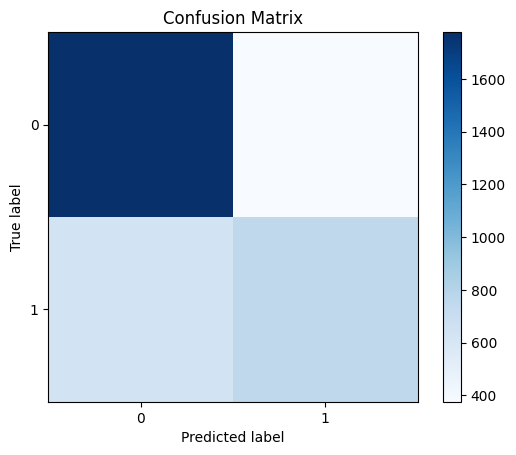

Cross Entropy for this fold: 0.56660395860672


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
----------


100%|██████████| 56/56 [00:13<00:00,  4.22it/s]


Training loss: 0.6232927421607622, Validation loss: 0.5821338306580272
Epoch 2/2
----------


100%|██████████| 56/56 [00:13<00:00,  4.21it/s]


Training loss: 0.5236693769693375, Validation loss: 0.5825974717736244


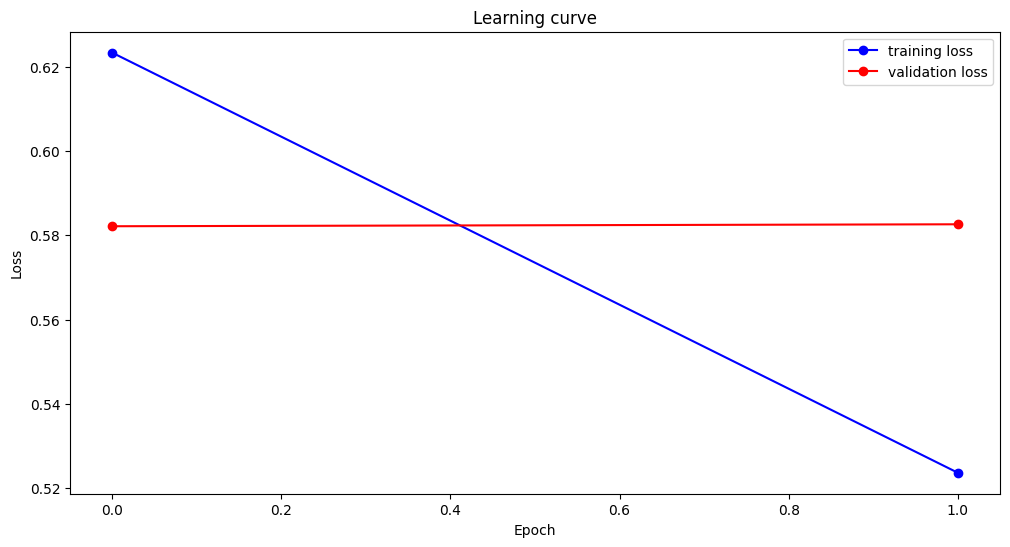

100%|██████████| 109/109 [00:25<00:00,  4.21it/s]


              precision    recall  f1-score   support

           0       0.73      0.83      0.78      2148
           1       0.65      0.50      0.56      1328

    accuracy                           0.70      3476
   macro avg       0.69      0.67      0.67      3476
weighted avg       0.70      0.70      0.70      3476



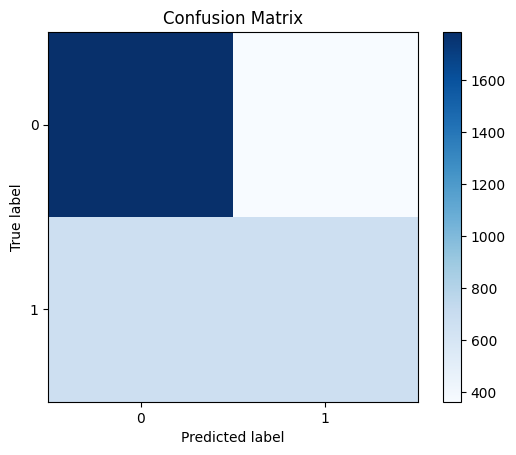

Cross Entropy for this fold: 0.5699953436851501


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
----------


100%|██████████| 55/55 [00:13<00:00,  4.18it/s]


Training loss: 0.6349270440727831, Validation loss: 0.5762799132953991
Epoch 2/2
----------


100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Training loss: 0.5393274771161827, Validation loss: 0.5645888008854606


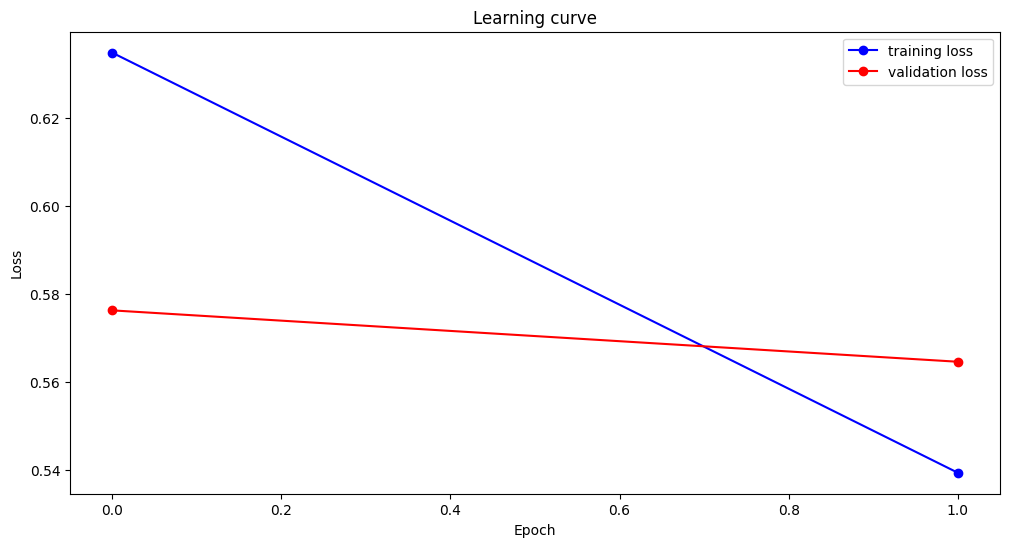

100%|██████████| 108/108 [00:25<00:00,  4.16it/s]


              precision    recall  f1-score   support

           0       0.75      0.79      0.77      2134
           1       0.63      0.58      0.61      1322

    accuracy                           0.71      3456
   macro avg       0.69      0.69      0.69      3456
weighted avg       0.71      0.71      0.71      3456



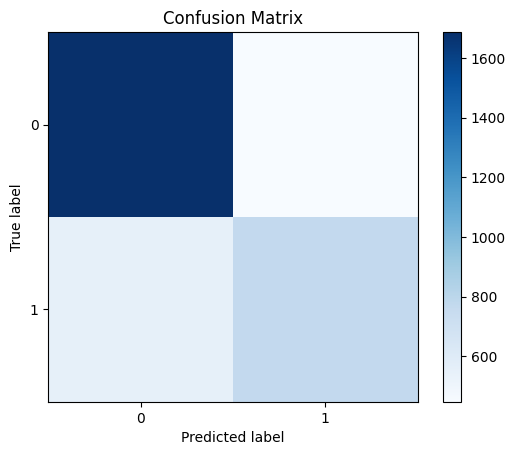

Cross Entropy for this fold: 0.56346595287323
community_3 - Average Cross Entropy: 0.5666884183883667
community_3 - Average F1 Macro Score: 0.6822241647410822
Running experiment for combined subset community


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
----------


100%|██████████| 63/63 [00:14<00:00,  4.22it/s]


Training loss: 0.5995838577469821, Validation loss: 0.5265766131499457
Epoch 2/2
----------


100%|██████████| 63/63 [00:14<00:00,  4.20it/s]


Training loss: 0.4750142112453148, Validation loss: 0.5082835025257535


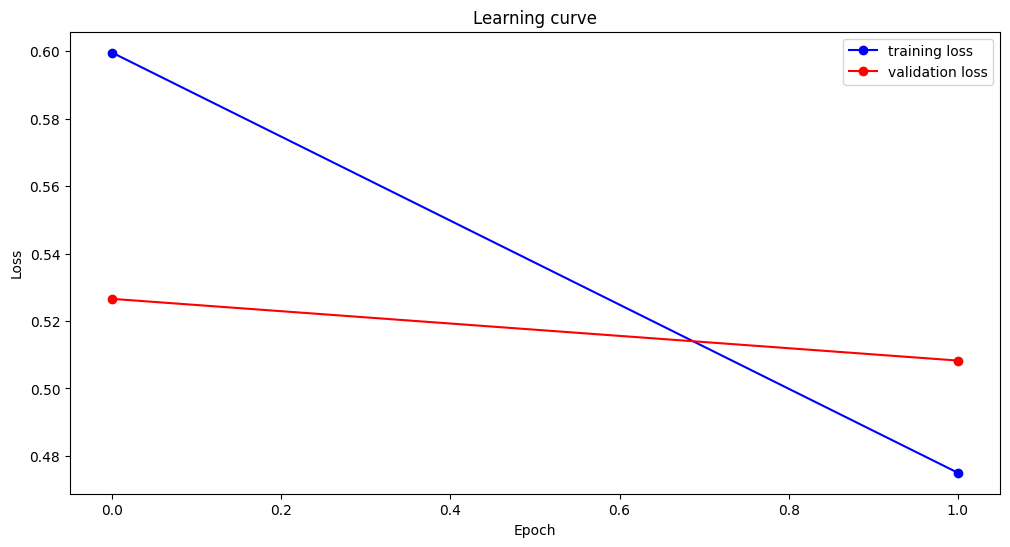

100%|██████████| 125/125 [00:29<00:00,  4.23it/s]


              precision    recall  f1-score   support

           0       0.77      0.87      0.82      2667
           1       0.65      0.49      0.55      1310

    accuracy                           0.74      3977
   macro avg       0.71      0.68      0.69      3977
weighted avg       0.73      0.74      0.73      3977



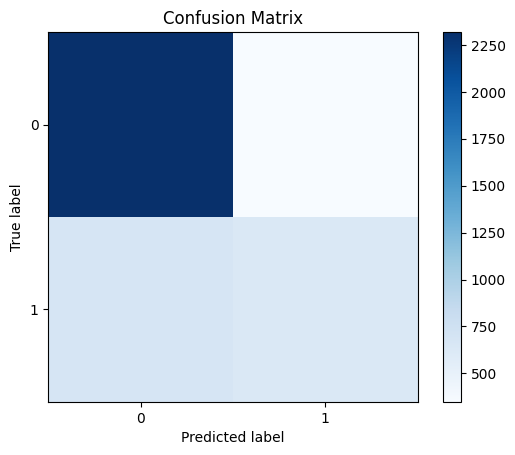

Cross Entropy for this fold: 0.5243745446205139


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
----------


100%|██████████| 64/64 [00:15<00:00,  4.21it/s]


Training loss: 0.5861309085802365, Validation loss: 0.5475539858452976
Epoch 2/2
----------


100%|██████████| 64/64 [00:15<00:00,  4.20it/s]


Training loss: 0.4654345763947374, Validation loss: 0.5552238319069147


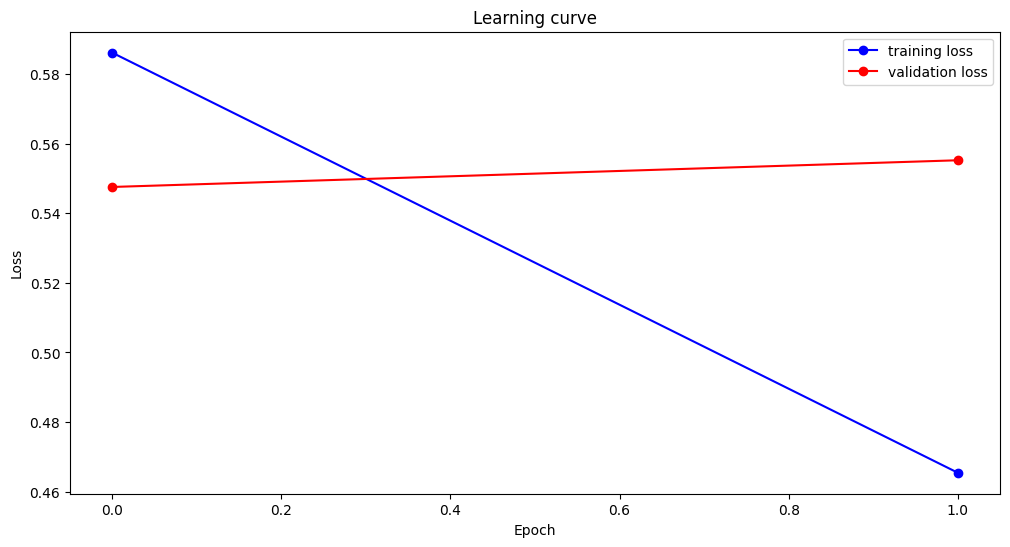

100%|██████████| 126/126 [00:30<00:00,  4.19it/s]


              precision    recall  f1-score   support

           0       0.79      0.84      0.81      2663
           1       0.64      0.56      0.60      1364

    accuracy                           0.74      4027
   macro avg       0.71      0.70      0.70      4027
weighted avg       0.74      0.74      0.74      4027



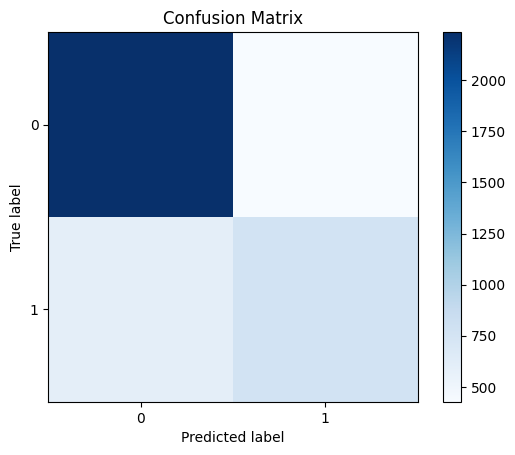

Cross Entropy for this fold: 0.5380949974060059


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
----------


100%|██████████| 63/63 [00:14<00:00,  4.22it/s]


Training loss: 0.589174229572428, Validation loss: 0.5597954392433167
Epoch 2/2
----------


100%|██████████| 63/63 [00:14<00:00,  4.21it/s]


Training loss: 0.48330898535378436, Validation loss: 0.5172724435253749


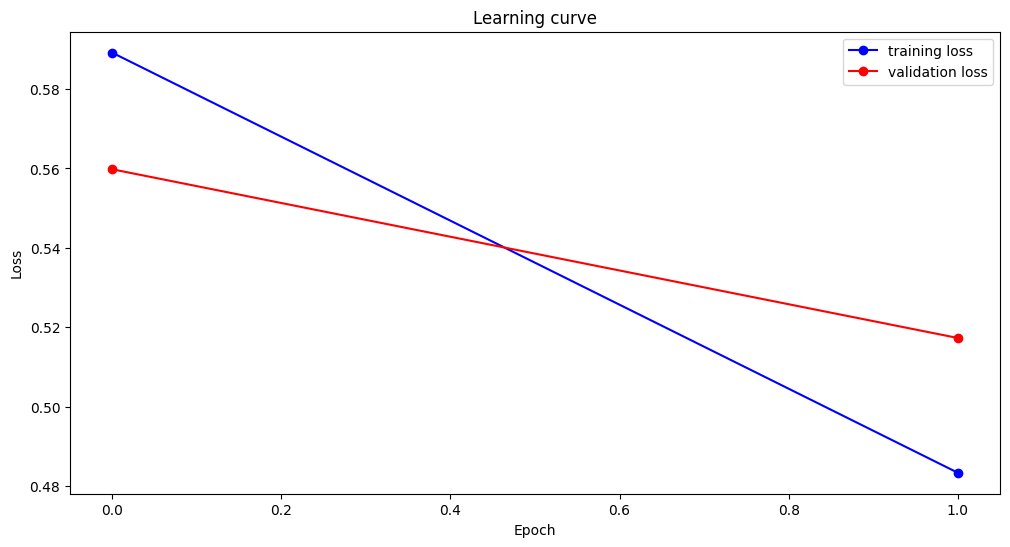

100%|██████████| 125/125 [00:30<00:00,  4.16it/s]


              precision    recall  f1-score   support

           0       0.78      0.85      0.82      2623
           1       0.66      0.54      0.60      1373

    accuracy                           0.75      3996
   macro avg       0.72      0.70      0.71      3996
weighted avg       0.74      0.75      0.74      3996



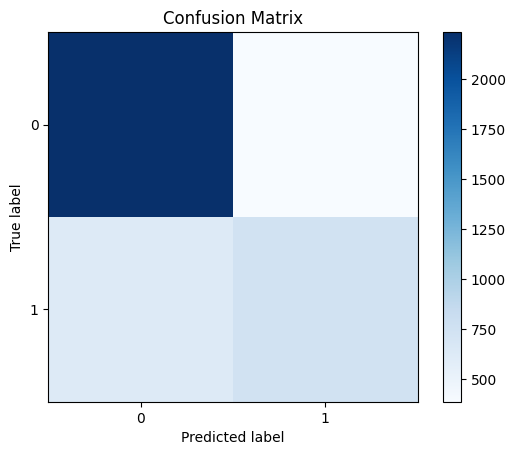

Cross Entropy for this fold: 0.5153605341911316
combined_subset_community - Average Cross Entropy: 0.5259433587392172
combined_subset_community - Average F1 Macro Score: 0.6989094928873435
Running experiment for combined community


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
----------


100%|██████████| 256/256 [01:01<00:00,  4.18it/s]


Training loss: 0.5229298150259272, Validation loss: 0.4987665101652965
Epoch 2/2
----------


100%|██████████| 256/256 [01:01<00:00,  4.19it/s]


Training loss: 0.45248949698928753, Validation loss: 0.5047522471286356


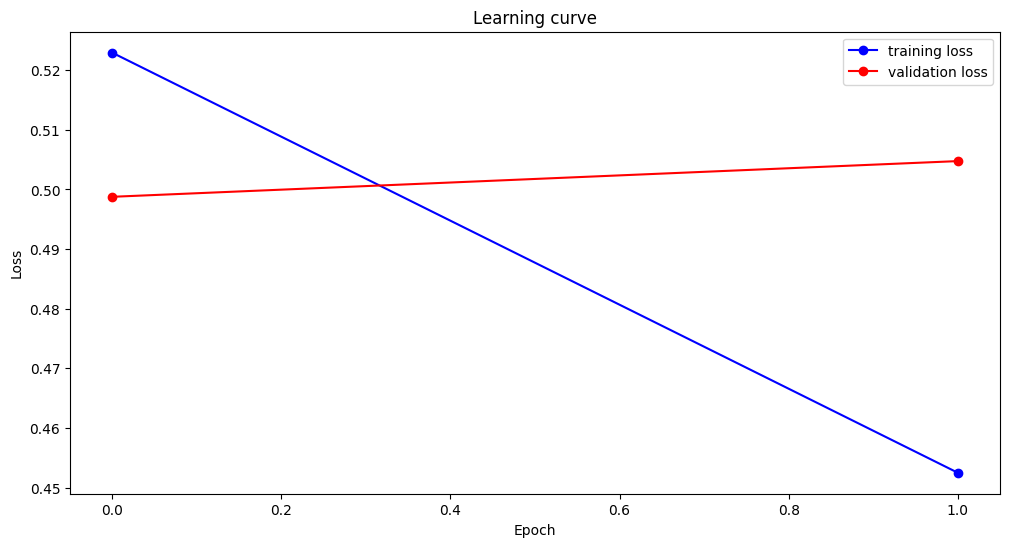

100%|██████████| 515/515 [02:03<00:00,  4.17it/s]


              precision    recall  f1-score   support

           0       0.79      0.85      0.82     10864
           1       0.66      0.56      0.61      5586

    accuracy                           0.75     16450
   macro avg       0.72      0.71      0.71     16450
weighted avg       0.75      0.75      0.75     16450



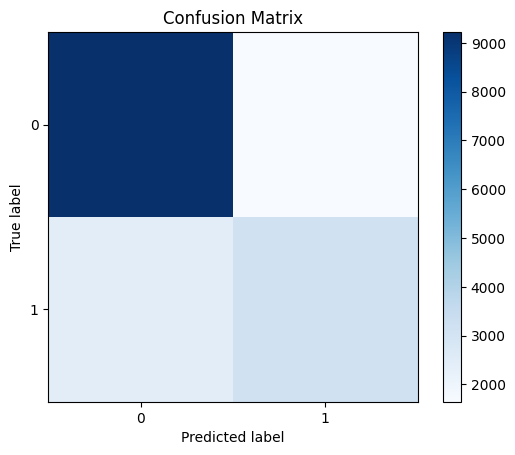

Cross Entropy for this fold: 0.5029976963996887


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
----------


100%|██████████| 258/258 [01:01<00:00,  4.19it/s]


Training loss: 0.533190585866881, Validation loss: 0.4888412033518155
Epoch 2/2
----------


100%|██████████| 258/258 [01:01<00:00,  4.18it/s]


Training loss: 0.4598248944190952, Validation loss: 0.4851760803613552


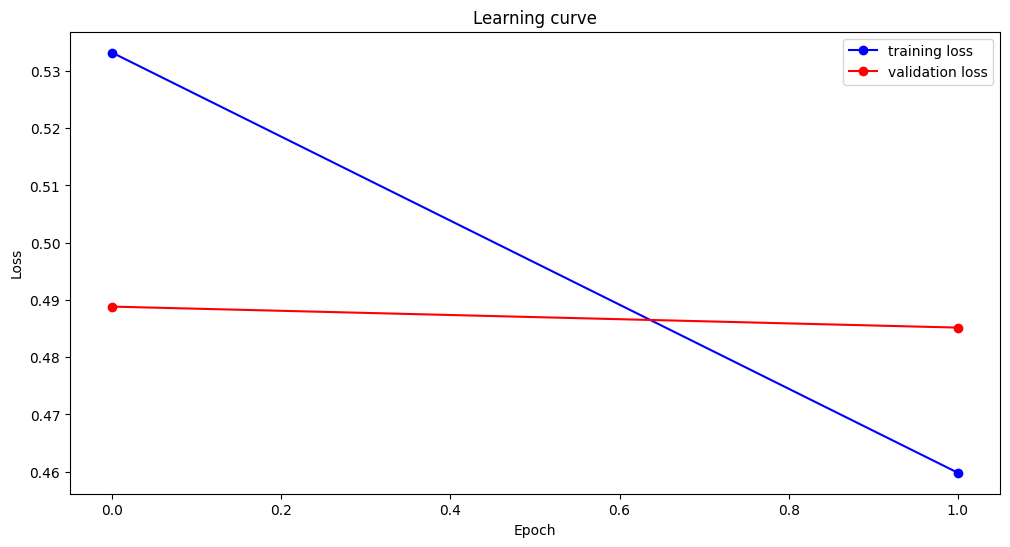

100%|██████████| 511/511 [02:02<00:00,  4.18it/s]


              precision    recall  f1-score   support

           0       0.79      0.86      0.82     10782
           1       0.67      0.55      0.60      5547

    accuracy                           0.75     16329
   macro avg       0.73      0.70      0.71     16329
weighted avg       0.75      0.75      0.75     16329



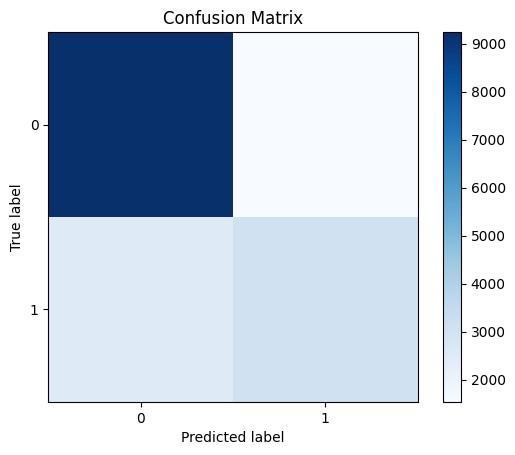

Cross Entropy for this fold: 0.5042201280593872


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
----------


100%|██████████| 257/257 [01:01<00:00,  4.19it/s]


Training loss: 0.5279215891858846, Validation loss: 0.5031239132067109
Epoch 2/2
----------


100%|██████████| 257/257 [01:01<00:00,  4.20it/s]


Training loss: 0.4488607932788033, Validation loss: 0.5033021224481471


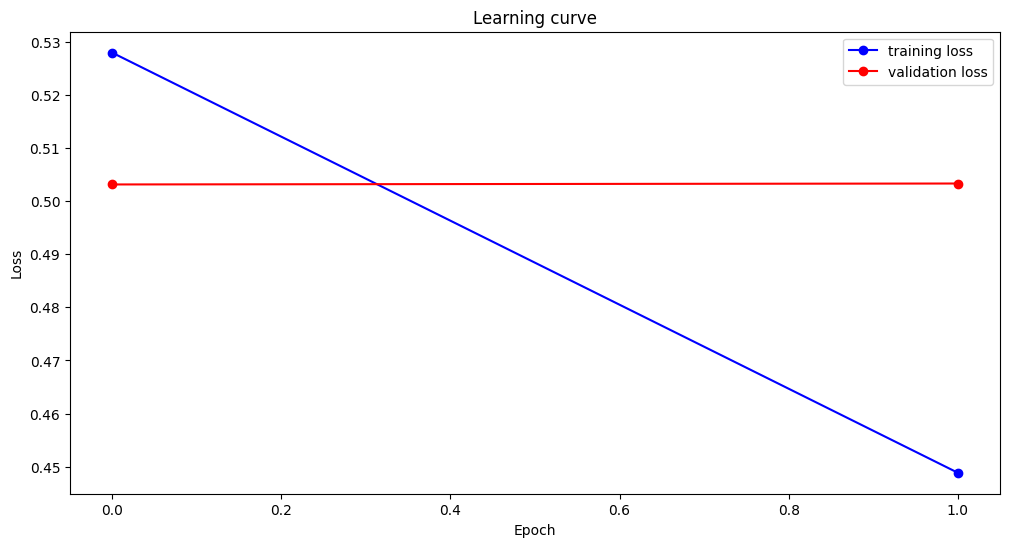

100%|██████████| 511/511 [02:01<00:00,  4.20it/s]


              precision    recall  f1-score   support

           0       0.80      0.86      0.83     10715
           1       0.68      0.58      0.63      5617

    accuracy                           0.76     16332
   macro avg       0.74      0.72      0.73     16332
weighted avg       0.76      0.76      0.76     16332



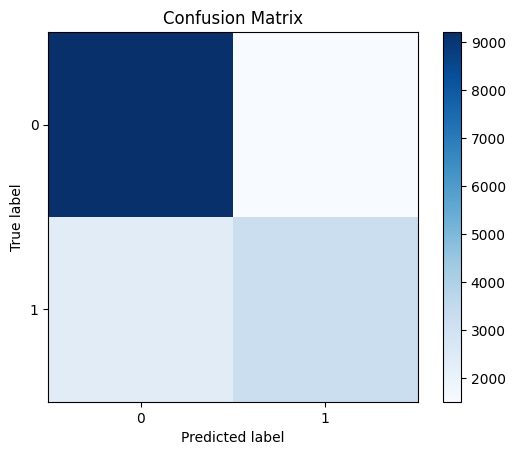

Cross Entropy for this fold: 0.49634769558906555
combined_community - Average Cross Entropy: 0.5011885066827139
combined_community - Average F1 Macro Score: 0.7171714396790327


In [ ]:
# Load the data
community_files = [
    "community_0_data_final_md_leiden.csv",
    "community_1_data_final_md_leiden.csv",
    "community_2_data_final_md_leiden.csv",
    "community_3_data_final_md_leiden.csv",
]
community_dfs = {f"community_{i}": pd.read_csv(f"community_{i}_data_final_md_leiden.csv") for i in range(len(community_files))}
combined_df = pd.read_csv("combined_communities_data_final_md_leiden.csv")
combined_subset_df = pd.read_csv("combined_subset_communities_data_final_md_leiden.csv")  # Load the subset combined dataset

f1_scores_dict = {}
cross_entropy_scores_dict = {}

# Run the experiment for each community
for community_name, community_df in community_dfs.items():
    print(f"Running experiment for {community_name}")
    cross_entropy, f1_macro = run_experiment_individual(community_df, sample_frac=1.0, community_name=community_name)
    f1_scores_dict[community_name] = f1_macro
    cross_entropy_scores_dict[community_name] = cross_entropy

# Run the experiment for the combined subset community
print("Running experiment for combined subset community")
community_name = "combined_subset_community"
cross_entropy, f1_macro = run_experiment_individual(combined_subset_df, sample_frac=1.0, community_name=community_name)
f1_scores_dict[community_name] = f1_macro
cross_entropy_scores_dict[community_name] = cross_entropy

# Run the experiment for the combined community
print("Running experiment for combined community")
community_name = "combined_community"
cross_entropy, f1_macro = run_experiment_individual(combined_df, sample_frac=1.0, community_name=community_name)
f1_scores_dict[community_name] = f1_macro
cross_entropy_scores_dict[community_name] = cross_entropy

In [ ]:
f1_scores_df = pd.DataFrame(list(f1_scores_dict.items()), columns=['Community', 'F1 Macro Score']).set_index('Community')
cross_entropy_scores_df = pd.DataFrame(list(cross_entropy_scores_dict.items()), columns=['Community', 'Cross Entropy']).set_index('Community')

In [ ]:
f1_scores_df

F1 Macro Score
Community                                
community_0                      0.683539
community_1                      0.715097
community_2                      0.695513
community_3                      0.682224
combined_subset_community        0.698909
combined_community               0.717171

In [ ]:
cross_entropy_scores_df

Cross Entropy
Community                               
community_0                     0.459664
community_1                     0.506649
community_2                     0.546189
community_3                     0.566688
combined_subset_community       0.525943
combined_community              0.501189

In [ ]:
# List of community names
community_names = [
    "combined_community",
    "combined_subset_community",
    "community_0",
    "community_1",
    "community_2",
    "community_3"
]

# Load and display incorrectly classified instances for each community
for community_name in community_names:
    # Load the incorrectly classified instances from the CSV file
    filename = f"{community_name}_incorrectly_classified_instances.csv"
    incorrectly_classified_df = pd.read_csv(filename)

    # Display the DataFrame (You can also perform any further analysis you need on this DataFrame)
    print(f"Incorrectly Classified Instances for {community_name}:")
    display(incorrectly_classified_df)


Incorrectly Classified Instances for combined_community:


instance_id                                               text  \
0              186  Flip Texas Blue!  Vote, your Vote is your Voic...   
1              481  <user> REALLY? You think <user> was rattled by...   
2              531  <user> <user> <user> If you know nothing about...   
3              531  <user> <user> <user> If you know nothing about...   
4              545  <user> <user> <user> Not so fast! We see you. ...   
...            ...                                                ...   
11975        10663              <user> <user> They aren't... Go Hogs.   
11976        10664  <user> <user> <user> <user> <user> <user> <use...   
11977        10716  <user> Keep wearing your masks till <user> goe...   
11978        10727  <user> <user> U lying hypocrite he has  denoun...   
11979        10746  <user> Is it modern day slavery? Like the CCP?...   

               annotation task  number of annotations lang  hard_label  split  \
0      offensiveness detection                      5   en           0   test   
1      offensiveness detection                      5   en           0   test   
2      offensiveness detection                      5   en           0   test   
3      offensiveness detection                      5   en           0   test   
4      offensiveness detection                      5   en           0   test   
...                        ...                    ...  ...         ...    ...   
11975  offensiveness detection                      5   en           0  train   
11976  offensiveness detection                      5   en           0  train   
11977  offensiveness detection                      5   en           0  train   
11978  offensiveness detection                      5   en           1  train   
11979  offensiveness detection                      5   en           0  train   

       soft_label.0  soft_label.1 other_info.domain  offensiveness  user_id  \
0               0.6           0.4     Elections2020              1      631   
1               0.6           0.4     Elections2020              0      683   
2               1.0           0.0     Elections2020              0      770   
3               1.0           0.0     Elections2020              0      631   
4               0.6           0.4     Elections2020              0      631   
...             ...           ...               ...            ...      ...   
11975           1.0           0.0     Elections2020              0      164   
11976           0.6           0.4     Elections2020              1       60   
11977           0.8           0.2     Elections2020              1       88   
11978           0.2           0.8     Elections2020              0       58   
11979           0.8           0.2     Elections2020              1       60   

                                            cleaned_text cleaned_domain  \
0      flip texas blue! vote, your vote is your voice...  elections2020   
1      really? you think was rattled by that ranting ...  elections2020   
2      if you know nothing about accounting then shut...  elections2020   
3      if you know nothing about accounting then shut...  elections2020   
4                     not so fast! we see you. cheaters!  elections2020   
...                                                  ...            ...   
11975                           they are not... go hogs.  elections2020   
11976  trump team has initiated their dirty tricks re...  elections2020   
11977           keep wearing your masks till goes out !!  elections2020   
11978  you lying hypocrite he has denounced it multip...  elections2020   
11979            is it modern day slavery? like the ccp?  elections2020   

       community                                   text_with_domain  \
0              0  elections2020 flip texas blue! vote, your vote...   
1              0  elections2020 really? you think was rattled by...   
2              0  elections2020 if you know nothing about accoun...   
3              0  elect

Incorrectly Classified Instances for combined_subset_community:


instance_id                                               text  \
0            7961                                         WTF NO WHY   
1            1337  <user> <user> <user> <user> Arizona is mine BI...   
2            8751                     Clout is a hell of a drug.....   
3            8219  I hope the funeral procession drives by the st...   
4            2520  THIS IS NOT GOOD NEWS. This is, "oh you don't ...   
...           ...                                                ...   
3062           34  If people think racism isn’t alive and well in...   
3063         6677  Things we hate: ❌ #COVID19 ❌ Anti-abortion pol...   
3064         5726  <user> <user> Lampoon okay Mexico don’t like A...   
3065         9676  Dating was trash before Covid. But COVID  help...   
3066         3426  <user> I don’t like you , but this thread is i...   

              annotation task  number of annotations lang  hard_label  split  \
0     offensiveness detection                      5   en           1  train   
1     offensiveness detection                      5   en           1   test   
2     offensiveness detection                      5   en           0  train   
3     offensiveness detection                      5   en           0  train   
4     offensiveness detection                      5   en           1   test   
...                       ...                    ...  ...         ...    ...   
3062  offensiveness detection                      5   en           1   test   
3063  offensiveness detection                      5   en           1  train   
3064  offensiveness detection                      5   en           1  train   
3065  offensiveness detection                      5   en           0  train   
3066  offensiveness detection                      5   en           0    dev   

      soft_label.0  soft_label.1 other_info.domain  offensiveness  user_id  \
0              0.4           0.6               BLM              1      501   
1              0.2           0.8     Elections2020              0       71   
2              0.8           0.2               BLM              1        5   
3              0.6           0.4               BLM              1      582   
4              0.2           0.8               BLM              1      813   
...            ...           ...               ...            ...      ...   
3062           0.4           0.6               BLM              0      236   
3063           0.2           0.8          Covid-19              1      682   
3064           0.4           0.6     Elections2020              1      402   
3065           0.6           0.4          Covid-19              1      768   
3066           0.8           0.2               BLM              1      689   

                                           cleaned_text cleaned_domain  \
0                                            wtf no why            blm   
1     arizona is mine bitch! :rolling_on_the_floor_l...  elections2020   
2                        clout is a hell of a drug.....            blm   
3     i hope the funeral procession drives by the st...            blm   
4     this is not good news. this is, "oh you do not...            blm   
...                                                 ...            ...   
3062  if people think racism is not alive and well i...            blm   
3063  things we hate: :cross_mark: #covid19 :cross_m...       covid-19   
3064          lampoon okay mexico do not like americans  elections2020   
3065  dating was trash before covid. but covid helpe...       covid-19   
3066  i do not like you , but this thread is importa...            blm   

      community                                   text_with_domain  \
0             0                                     blm wtf no why   
1             1  elections2020 arizona is mine bitch! :rolling_...   
2             0                 blm clout is a hell of a drug.....   
3             0  blm i hope the funeral procession drives by th...   
4   

Incorrectly Classified Instances for community_0:


instance_id                                               text  \
0               7  <user> <user> <user> <user> <user> <user> <use...   
1             169  😍THIS IS SO FUNNY!  😂🤣WATCH <user> MAKE A ASS/...   
2             174  <user> <user> WE ARE NO LONGER MAILING OUR BAL...   
3             533  <user> <user> You hair is on fire because the ...   
4             564  <user> The DNC got over a billion in donations...   
...           ...                                                ...   
2447        10686                            Fragility at its finest   
2448        10701  There is no justification for it, only contemp...   
2449        10708  Phew! I was going to say something that would ...   
2450        10723  All the usual suspects showing their non suppo...   
2451        10738  <user> You are as crooked as they come. You ar...   

              annotation task  number of annotations lang  hard_label  split  \
0     offensiveness detection                      5   en           1   test   
1     offensiveness detection                      5   en           1   test   
2     offensiveness detection                      5   en           1   test   
3     offensiveness detection                      5   en           0   test   
4     offensiveness detection                      5   en           1   test   
...                       ...                    ...  ...         ...    ...   
2447  offensiveness detection                      5   en           0  train   
2448  offensiveness detection                      5   en           0  train   
2449  offensiveness detection                      5   en           0  train   
2450  offensiveness detection                      5   en           0  train   
2451  offensiveness detection                      5   en           1  train   

      soft_label.0  soft_label.1 other_info.domain  offensiveness  user_id  \
0              0.2           0.8     Elections2020              1      631   
1              0.4           0.6     Elections2020              1      569   
2              0.2           0.8     Elections2020              1      683   
3              0.8           0.2          Covid-19              0       30   
4              0.2           0.8     Elections2020              1      683   
...            ...           ...               ...            ...      ...   
2447           0.8           0.2               BLM              1       13   
2448           0.8           0.2               BLM              1      493   
2449           0.8           0.2               BLM              1      708   
2450           0.6           0.4               BLM              1      487   
2451           0.2           0.8     Elections2020              1      513   

                                           cleaned_text cleaned_domain  \
0     trump is in favor of what happened in texas ag...  elections2020   
1     :smiling_face_with_heart-eyes:this is so funny...  elections2020   
2     we are no longer mailing our ballots. hand del...  elections2020   
3     you hair is on fire because the president is k...       covid-19   
4     the dnc got over a billion in donations, and y...  elections2020   
...                                                 ...            ...   
2447                            fragility at its finest            blm   
2448  there is no justification for it, only contemp...            blm   
2449  phew! i was going to say something that would ...            blm   
2450  all the usual suspects showing their non suppo...            blm   
2451  you are as crooked as they come. you are racis...  elections2020   

      community                                   text_with_domain  \
0             0  elections2020 trump is in favor of what happen...   
1             0  elections2020 :smiling_face_with_heart-eyes:th...   
2             0  elections2020 we are no longer mailing our bal...   
3             0  covid-19 you hair is on fire because the presi...   
4   

Incorrectly Classified Instances for community_1:


instance_id                                               text  \
0               6  Trayvon Martin #georgezimmerman deserved the d...   
1               6  Trayvon Martin #georgezimmerman deserved the d...   
2              12  Watch for free, "America Street," on racism an...   
3              14                           Gee. Thanks, Dick. <url>   
4              24  <user> <user> Where do people get these ridicu...   
...           ...                                                ...   
3686        10392  It’s crazy how there is still COVID-19 and off...   
3687        10401  Jesus <user> this is amateur even for you. Usi...   
3688        10429  <user> <user> Can I ask Republicans to start t...   
3689        10429  <user> <user> Can I ask Republicans to start t...   
3690        10496  Driving while black in the US is deemed illega...   

              annotation task  number of annotations lang  hard_label  split  \
0     offensiveness detection                      5   en           0   test   
1     offensiveness detection                      5   en           0   test   
2     offensiveness detection                      5   en           0   test   
3     offensiveness detection                      5   en           1   test   
4     offensiveness detection                      5   en           0   test   
...                       ...                    ...  ...         ...    ...   
3686  offensiveness detection                      5   en           1  train   
3687  offensiveness detection                      5   en           0  train   
3688  offensiveness detection                      5   en           0  train   
3689  offensiveness detection                      5   en           0  train   
3690  offensiveness detection                      5   en           0  train   

      soft_label.0  soft_label.1 other_info.domain  offensiveness  user_id  \
0              0.6           0.4               BLM              1      448   
1              0.6           0.4               BLM              1      432   
2              0.8           0.2               BLM              1      398   
3              0.2           0.8          Covid-19              0      594   
4              0.8           0.2               BLM              1      688   
...            ...           ...               ...            ...      ...   
3686           0.4           0.6          Covid-19              0       36   
3687           0.8           0.2               BLM              1      229   
3688           0.6           0.4          Covid-19              1      283   
3689           0.6           0.4          Covid-19              1      448   
3690           0.6           0.4               BLM              1      229   

                                           cleaned_text cleaned_domain  \
0     trayvon martin #georgezimmerman deserved the d...            blm   
1     trayvon martin #georgezimmerman deserved the d...            blm   
2     watch for free, "america street," on racism an...            blm   
3                                    gee. thanks, dick.       covid-19   
4     where do people get these ridiculous takes. ge...            blm   
...                                                 ...            ...   
3686  it is crazy how there is still covid-19 and of...       covid-19   
3687  jesus this is amateur even for you. using an a...            blm   
3688  can i ask republicans to start telling the tru...       covid-19   
3689  can i ask republicans to start telling the tru...       covid-19   
3690  driving while black in the us is deemed illega...            blm   

      community                                   text_with_domain  \
0             1  blm trayvon martin #georgezimmerman deserved t...   
1             1  blm trayvon martin #georgezimmerman deserved t...   
2             1  blm watch for free, "america street," on racis...   
3             1                        covid-19 gee. thanks, dick.   
4   

Incorrectly Classified Instances for community_2:


instance_id                                               text  \
0             200  <user> <user> How about those incompetent demo...   
1             464  If you take any advise from this fool then I q...   
2             906  <user>  the only THUGS in this scenario are th...   
3            1270  <user> Just like your lies Joe we, the America...   
4            1789  <user> <user> <user> <user> Liberals hoping co...   
...           ...                                                ...   
3292        10704  <user> This ones for you ASSHOLE : Covid-19 is...   
3293        10709  <user> <user> <user> Covid is a farce.  Hyster...   
3294        10709  <user> <user> <user> Covid is a farce.  Hyster...   
3295        10709  <user> <user> <user> Covid is a farce.  Hyster...   
3296        10739  breaking news from Congressman Tweets Antisemi...   

              annotation task  number of annotations lang  hard_label  split  \
0     offensiveness detection                      5   en           0   test   
1     offensiveness detection                      5   en           0   test   
2     offensiveness detection                      5   en           0   test   
3     offensiveness detection                      5   en           1   test   
4     offensiveness detection                      5   en           0   test   
...                       ...                    ...  ...         ...    ...   
3292  offensiveness detection                      5   en           1  train   
3293  offensiveness detection                      5   en           1  train   
3294  offensiveness detection                      5   en           1  train   
3295  offensiveness detection                      5   en           1  train   
3296  offensiveness detection                      5   en           0  train   

      soft_label.0  soft_label.1 other_info.domain  offensiveness  user_id  \
0              0.6           0.4          Covid-19              1      152   
1              0.8           0.2          Covid-19              0      162   
2              0.6           0.4               BLM              0      511   
3              0.4           0.6          Covid-19              1      152   
4              0.6           0.4          Covid-19              1      152   
...            ...           ...               ...            ...      ...   
3292           0.2           0.8          Covid-19              0      390   
3293           0.4           0.6          Covid-19              1      663   
3294           0.4           0.6          Covid-19              1      681   
3295           0.4           0.6          Covid-19              1      669   
3296           0.8           0.2          Covid-19              1      240   

                                           cleaned_text cleaned_domain  \
0     how about those incompetent democrat governors...       covid-19   
1     if you take any advise from this fool then i q...       covid-19   
2     the only thugs in this scenario are the four s...            blm   
3     just like your lies joe we, the american peopl...       covid-19   
4     liberals hoping coronavirus gets worse is sick...       covid-19   
...                                                 ...            ...   
3292  this ones for you asshole : covid-19 is on tra...       covid-19   
3293  covid is a farce. hysteria pushed by media, fl...       covid-19   
3294  covid is a farce. hysteria pushed by media, fl...       covid-19   
3295  covid is a farce. hysteria pushed by media, fl...       covid-19   
3296  breaking news from congressman tweets antisemi...       covid-19   

      community                                   text_with_domain  \
0             2  covid-19 how about those incompetent democrat ...   
1             2  covid-19 if you take any advise from this fool...   
2             2  blm the only thugs in this scenario are the fo...   
3             2  covid-19 just like your lies joe we, the ameri...   
4   

Incorrectly Classified Instances for community_3:


instance_id                                               text  \
0               4                    <user> Stay away from children.   
1              30  <user> <user> Hey bruh,  that's  not cool. Dem...   
2              81  <user> <user> No he doesn’t. It’s GOP propagan...   
3             127  Need I say more? Trolling the Democrats is by ...   
4             161  Crap! Stop the BS. He was paid large sums of m...   
...           ...                                                ...   
3039        10717  Last night I heard <user> call #POTUS <user> a...   
3040        10736  <user> He charged at police with a knife. Play...   
3041        10736  <user> He charged at police with a knife. Play...   
3042        10736  <user> He charged at police with a knife. Play...   
3043        10736  <user> He charged at police with a knife. Play...   

              annotation task  number of annotations lang  hard_label  split  \
0     offensiveness detection                      5   en           0   test   
1     offensiveness detection                      5   en           0   test   
2     offensiveness detection                      5   en           0   test   
3     offensiveness detection                      5   en           1   test   
4     offensiveness detection                      5   en           1   test   
...                       ...                    ...  ...         ...    ...   
3039  offensiveness detection                      5   en           1  train   
3040  offensiveness detection                      5   en           0  train   
3041  offensiveness detection                      5   en           0  train   
3042  offensiveness detection                      5   en           0  train   
3043  offensiveness detection                      5   en           0  train   

      soft_label.0  soft_label.1 other_info.domain  offensiveness  user_id  \
0              0.6           0.4     Elections2020              1      272   
1              0.6           0.4     Elections2020              1      272   
2              0.6           0.4     Elections2020              1       60   
3              0.4           0.6     Elections2020              0       21   
4              0.4           0.6               BLM              1      546   
...            ...           ...               ...            ...      ...   
3039           0.4           0.6     Elections2020              1      573   
3040           0.8           0.2     Elections2020              0      238   
3041           0.8           0.2     Elections2020              0      104   
3042           0.8           0.2     Elections2020              0      774   
3043           0.8           0.2     Elections2020              0      713   

                                           cleaned_text cleaned_domain  \
0                              stay away from children.  elections2020   
1     hey bruh, that is not cool. democrats play dir...  elections2020   
2     no he does not. it is gop propaganda. another ...  elections2020   
3     need i say more? trolling the democrats is by ...  elections2020   
4     crap! stop the bs. he was paid large sums of m...            blm   
...                                                 ...            ...   
3039  last night i heard call #potus a "clown" as a ...  elections2020   
3040  he charged at police with a knife. play stupid...  elections2020   
3041  he charged at police with a knife. play stupid...  elections2020   
3042  he charged at police with a knife. play stupid...  elections2020   
3043  he charged at police with a knife. play stupid...  elections2020   

      community                                   text_with_domain  \
0             3             elections2020 stay away from children.   
1             3  elections2020 hey bruh, that is not cool. demo...   
2             3  elections2020 no he does not. it is gop propag...   
3             3  elections2020 need i say more? trolling the de...   
4   

# Model 3a: Transfer Learning on majority from communities dataset

Steps:

1) Pre-training on combined Dataset:

- Train the model on the combined dataset which is saved after training.

2) Fine-tuning on each Community:

- Load the pre-trained model for each community. Fine-tune the model on each community dataset separately.

In [ ]:
def run_transfer_learning_experiment(pretrained_model, community_df, community_name):
    cross_entropy_scores = []
    f1_macro_scores = []
    correctly_classified_instances = []
    incorrectly_classified_instances = []

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

    for train_index, test_index in skf.split(community_df, community_df['offensiveness']):
        train_val_df = community_df.iloc[train_index].copy()
        test_df = community_df.iloc[test_index].copy()
        train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=1, stratify=train_val_df['offensiveness'])

        train_df.loc[:, 'text_with_domain'] = train_df['cleaned_domain'] + " " + train_df['cleaned_text']
        val_df.loc[:, 'text_with_domain'] = val_df['cleaned_domain'] + " " + val_df['cleaned_text']
        test_df.loc[:, 'text_with_domain'] = test_df['cleaned_domain'] + " " + test_df['cleaned_text']

        train_dataloader, validation_dataloader, test_dataloader, test_labels = prepare_dataset_and_loaders(train_df, val_df, test_df, tokenizer)

        model = copy.deepcopy(pretrained_model)
        model.to(device)
        optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.0)
        epochs = 2
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)

        model_filename = f"{community_name}_epoch_{epochs}"
        loss_values, validation_loss_values = train(model, train_dataloader, validation_dataloader, optimizer, scheduler, device, epochs, model_filename)
        plot_loss_curves(loss_values, validation_loss_values)

        predictions, true_labels = evaluate(model, test_dataloader, device)
        print(classification_report(true_labels, predictions.argmax(axis=1)))
        plot_confusion_matrix(true_labels, predictions.argmax(axis=1))

        cross_entropy = criterion(torch.tensor(predictions), torch.tensor(true_labels))
        cross_entropy_scores.append(cross_entropy.item())
        print(f"Cross Entropy for this fold: {cross_entropy.item()}")

        f1_macro = f1_score(true_labels, predictions.argmax(axis=1), average='macro')
        f1_macro_scores.append(f1_macro)

        predicted_labels = predictions.argmax(axis=1)
        for i, (true_label, predicted_label) in enumerate(zip(true_labels, predicted_labels)):
            instance = test_df.iloc[i].to_dict()
            instance['predicted_label'] = predicted_label
            instance['true_label'] = true_label
            instance_cross_entropy = criterion(torch.tensor(predictions[i]).unsqueeze(0), torch.tensor([true_label]))
            instance['cross_entropy'] = instance_cross_entropy.item()
            if true_label == predicted_label:
                correctly_classified_instances.append(instance)
            else:
                incorrectly_classified_instances.append(instance)

    correctly_classified_df = pd.DataFrame(correctly_classified_instances)
    incorrectly_classified_df = pd.DataFrame(incorrectly_classified_instances)

    correctly_classified_df.to_csv(f"{community_name}_correctly_classified_instances.csv", index=False)
    incorrectly_classified_df.to_csv(f"{community_name}_incorrectly_classified_instances.csv", index=False)

    average_cross_entropy = np.mean(cross_entropy_scores)
    average_f1_macro = np.mean(f1_macro_scores)

    print(f"{community_name} - Average Cross Entropy: {average_cross_entropy}")
    print(f"{community_name} - Average F1 Macro Score: {average_f1_macro}")

    return average_cross_entropy, average_f1_macro

Pretraining model on combined community


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
----------


100%|██████████| 56/56 [00:12<00:00,  4.61it/s]


Training loss: 0.5234250135364986, Validation loss: 0.4175458840493645
Epoch 2/2
----------


100%|██████████| 56/56 [00:12<00:00,  4.55it/s]


Training loss: 0.36978573635930106, Validation loss: 0.39527948573231697


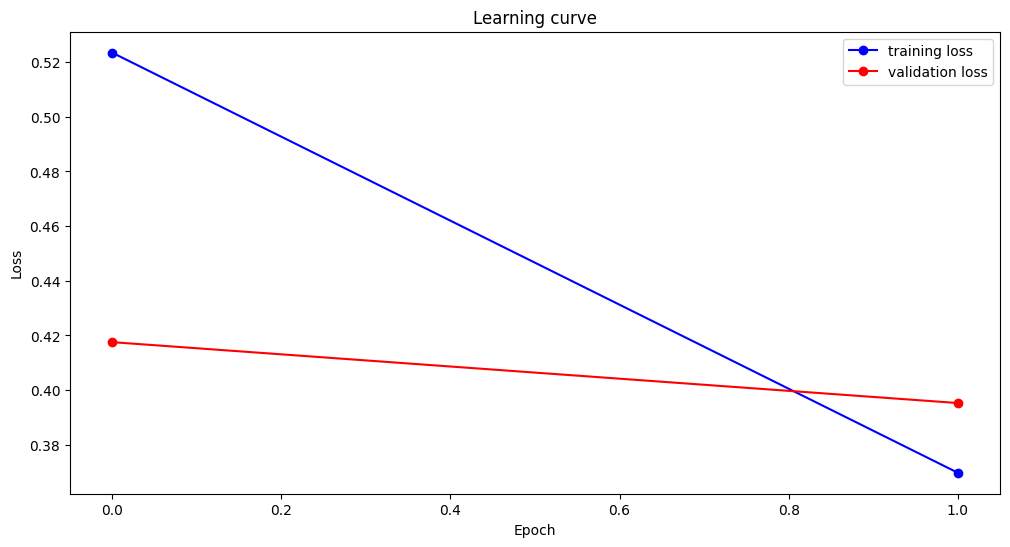

100%|██████████| 112/112 [00:24<00:00,  4.53it/s]


              precision    recall  f1-score   support

           0       0.85      0.90      0.88      2532
           1       0.72      0.62      0.67      1052

    accuracy                           0.82      3584
   macro avg       0.79      0.76      0.77      3584
weighted avg       0.81      0.82      0.81      3584



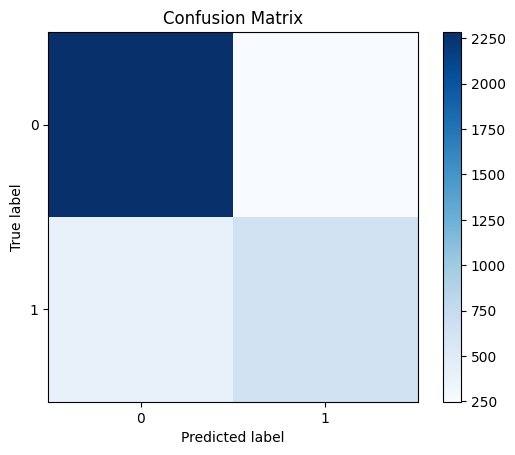

Cross Entropy for this fold: 0.4205840528011322
Epoch 1/2
----------


100%|██████████| 56/56 [00:12<00:00,  4.65it/s]


Training loss: 0.5161046471801543, Validation loss: 0.4241543696927173
Epoch 2/2
----------


100%|██████████| 56/56 [00:12<00:00,  4.63it/s]


Training loss: 0.3548743963418972, Validation loss: 0.40696806247745243


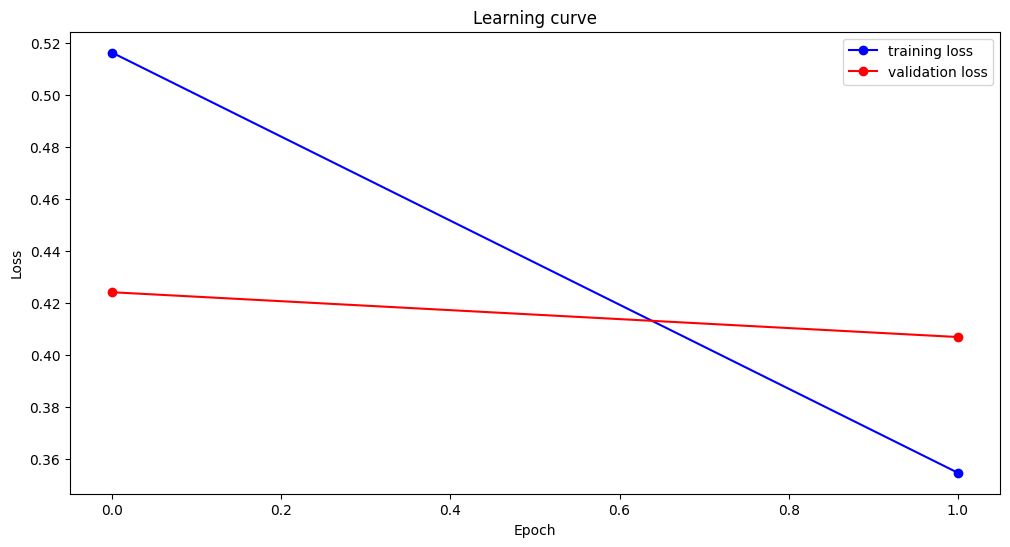

100%|██████████| 112/112 [00:24<00:00,  4.63it/s]


              precision    recall  f1-score   support

           0       0.84      0.88      0.86      2531
           1       0.68      0.60      0.64      1053

    accuracy                           0.80      3584
   macro avg       0.76      0.74      0.75      3584
weighted avg       0.79      0.80      0.80      3584



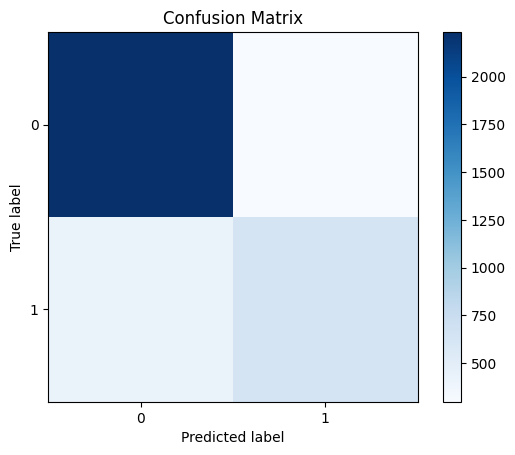

Cross Entropy for this fold: 0.42994728684425354
Epoch 1/2
----------


100%|██████████| 56/56 [00:12<00:00,  4.63it/s]


Training loss: 0.5338663449954419, Validation loss: 0.4874671883881092
Epoch 2/2
----------


100%|██████████| 56/56 [00:12<00:00,  4.63it/s]


Training loss: 0.3784277584581148, Validation loss: 0.4433713387697935


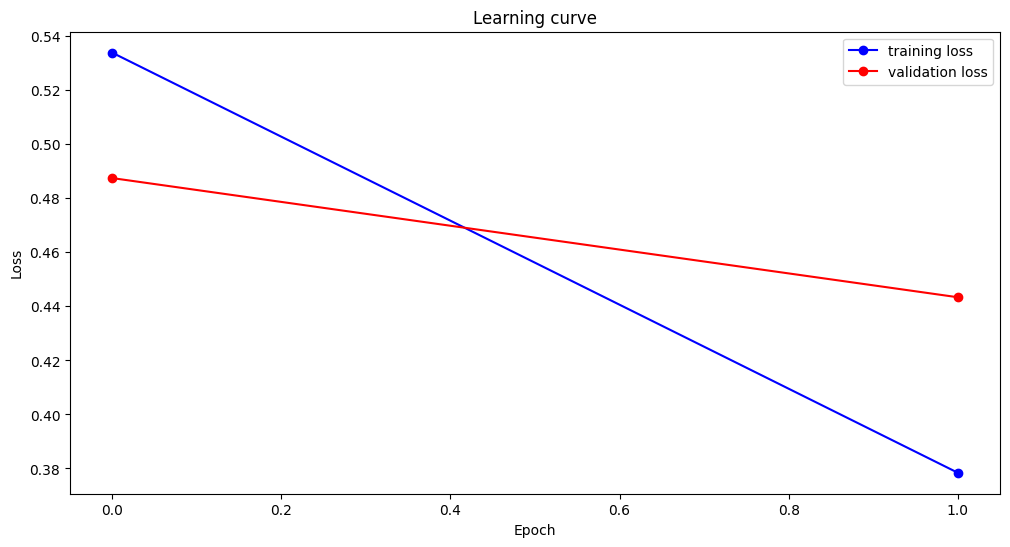

100%|██████████| 112/112 [00:24<00:00,  4.63it/s]


              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2531
           1       0.72      0.69      0.71      1052

    accuracy                           0.83      3583
   macro avg       0.80      0.79      0.79      3583
weighted avg       0.83      0.83      0.83      3583



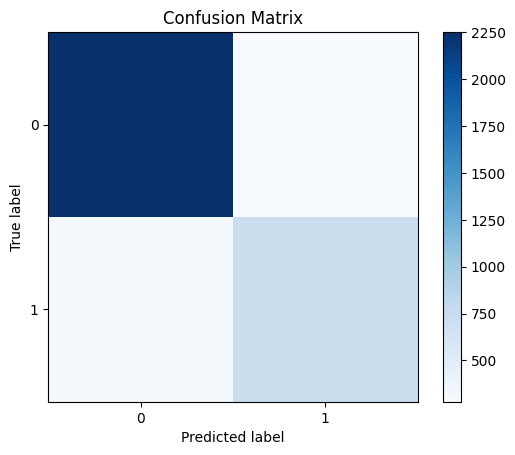

Cross Entropy for this fold: 0.3911849558353424
majority_combined_community - Average Cross Entropy: 0.41390543182690936
majority_combined_community - Average F1 Macro Score: 0.7716659021259628
Fine-tuning and running experiment for majority_community_0
Epoch 1/2
----------


100%|██████████| 19/19 [00:04<00:00,  4.74it/s]


Training loss: 0.5091012258614812, Validation loss: 0.45857426210453633
Epoch 2/2
----------


100%|██████████| 19/19 [00:04<00:00,  4.73it/s]


Training loss: 0.42873503054891315, Validation loss: 0.3953875852258582


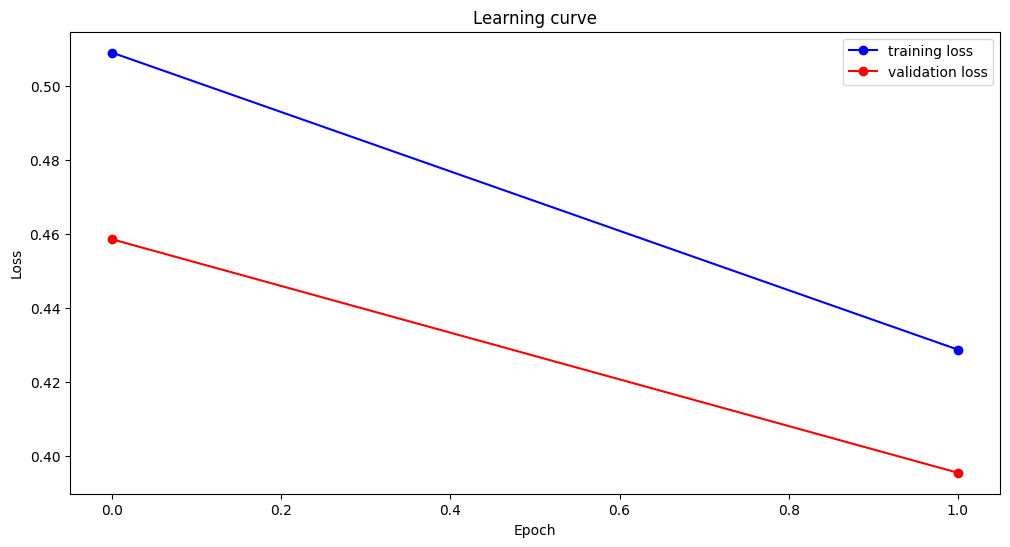

100%|██████████| 37/37 [00:08<00:00,  4.62it/s]


              precision    recall  f1-score   support

           0       0.83      0.98      0.90       949
           1       0.74      0.21      0.33       235

    accuracy                           0.83      1184
   macro avg       0.79      0.60      0.61      1184
weighted avg       0.82      0.83      0.79      1184



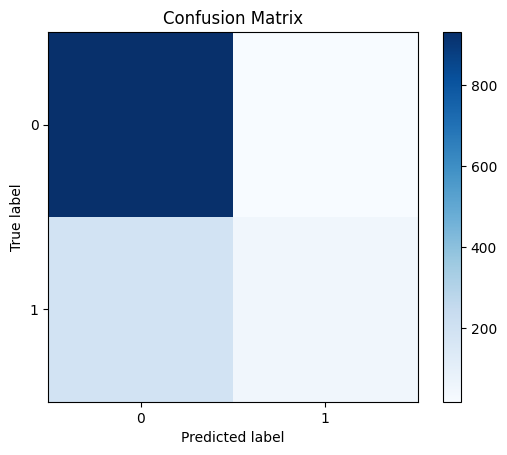

Cross Entropy for this fold: 0.42536553740501404
Epoch 1/2
----------


100%|██████████| 19/19 [00:04<00:00,  4.71it/s]


Training loss: 0.5047949249190944, Validation loss: 0.46726899868563604
Epoch 2/2
----------


100%|██████████| 19/19 [00:04<00:00,  4.72it/s]


Training loss: 0.4636986167835338, Validation loss: 0.44186453913387497


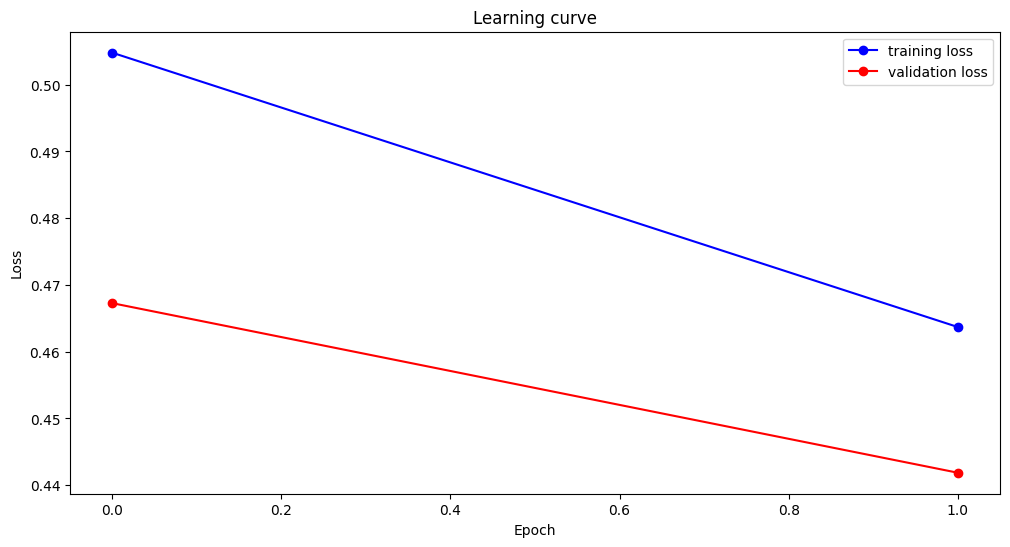

100%|██████████| 37/37 [00:07<00:00,  4.66it/s]


              precision    recall  f1-score   support

           0       0.80      1.00      0.89       949
           1       0.00      0.00      0.00       235

    accuracy                           0.80      1184
   macro avg       0.40      0.50      0.44      1184
weighted avg       0.64      0.80      0.71      1184



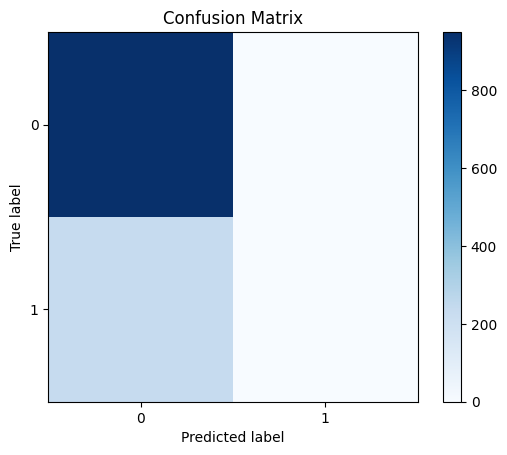

Cross Entropy for this fold: 0.44438615441322327
Epoch 1/2
----------


100%|██████████| 19/19 [00:03<00:00,  5.11it/s]


Training loss: 0.5069845100598676, Validation loss: 0.46618181153347615
Epoch 2/2
----------


100%|██████████| 19/19 [00:03<00:00,  5.11it/s]


Training loss: 0.4426548672573907, Validation loss: 0.4288965934201291


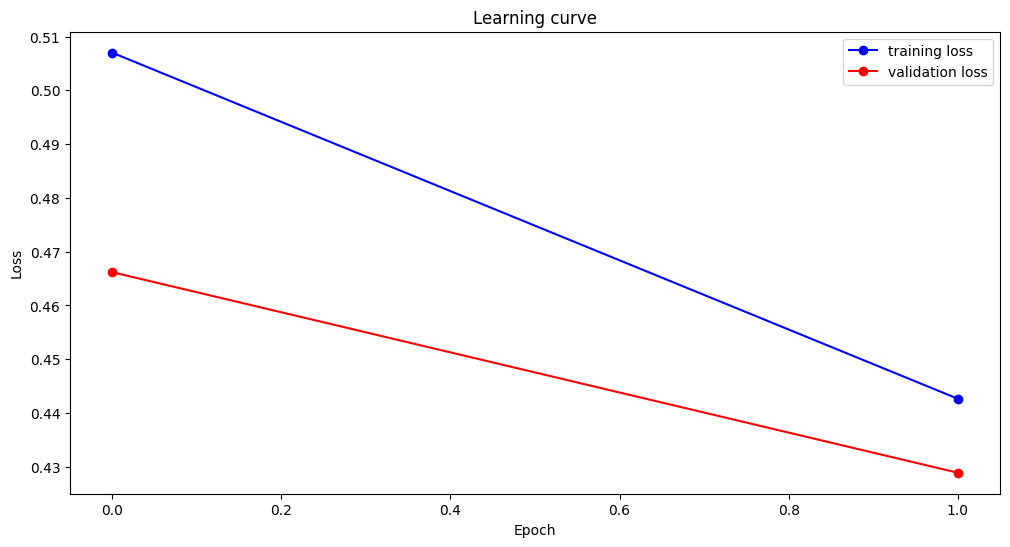

100%|██████████| 37/37 [00:07<00:00,  4.65it/s]


              precision    recall  f1-score   support

           0       0.80      1.00      0.89       948
           1       0.00      0.00      0.00       235

    accuracy                           0.80      1183
   macro avg       0.40      0.50      0.44      1183
weighted avg       0.64      0.80      0.71      1183



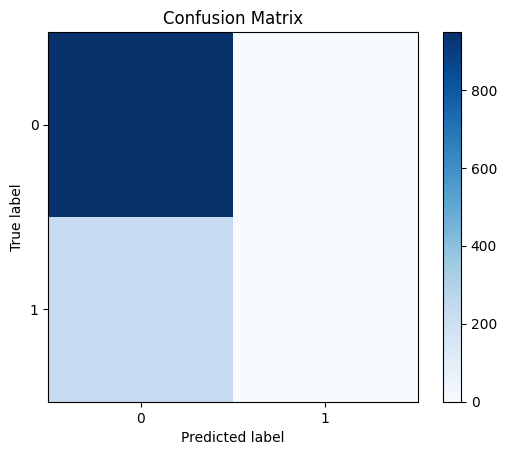

Cross Entropy for this fold: 0.4201876223087311
majority_community_0 - Average Cross Entropy: 0.42997977137565613
majority_community_0 - Average F1 Macro Score: 0.5011535165481755
Fine-tuning and running experiment for majority_community_1
Epoch 1/2
----------


100%|██████████| 23/23 [00:04<00:00,  5.10it/s]


Training loss: 0.5982424283205573, Validation loss: 0.521657012079073
Epoch 2/2
----------


100%|██████████| 23/23 [00:04<00:00,  5.11it/s]


Training loss: 0.43920544835168923, Validation loss: 0.44643639092860016


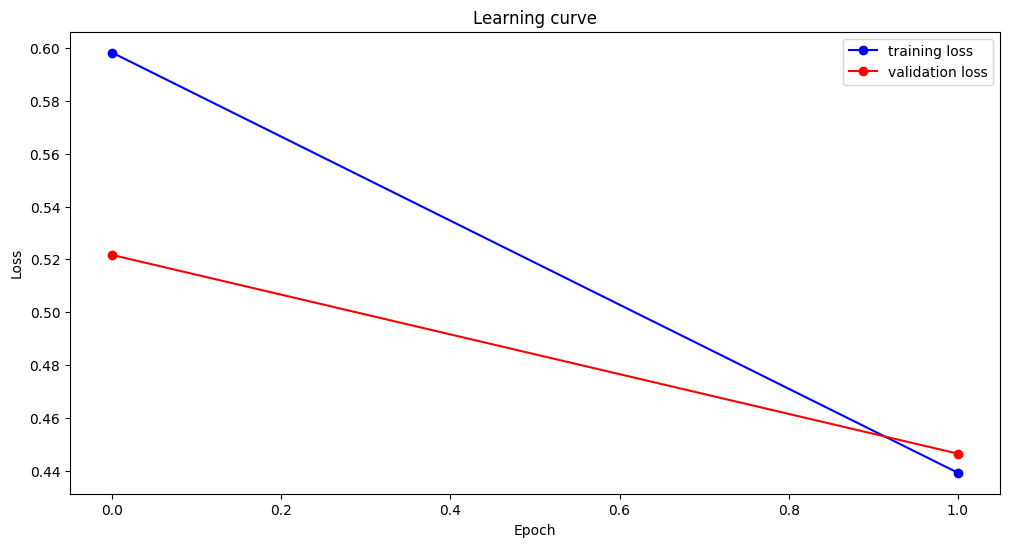

100%|██████████| 45/45 [00:09<00:00,  4.68it/s]


              precision    recall  f1-score   support

           0       0.83      0.92      0.87       989
           1       0.76      0.57      0.65       433

    accuracy                           0.81      1422
   macro avg       0.79      0.74      0.76      1422
weighted avg       0.81      0.81      0.80      1422



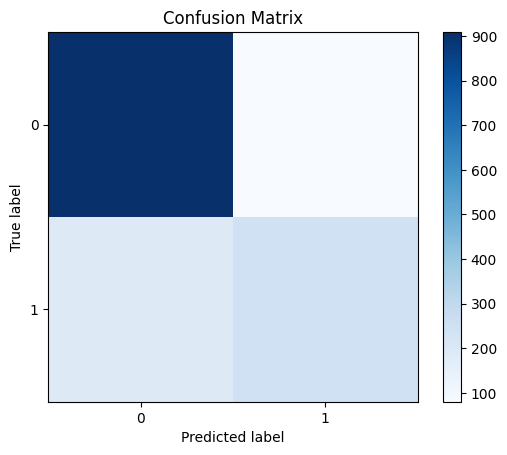

Cross Entropy for this fold: 0.4263637065887451
Epoch 1/2
----------


100%|██████████| 23/23 [00:04<00:00,  4.79it/s]


Training loss: 0.583159201180757, Validation loss: 0.4962910595147506
Epoch 2/2
----------


100%|██████████| 23/23 [00:04<00:00,  4.79it/s]


Training loss: 0.4182514299207659, Validation loss: 0.46264383715132007


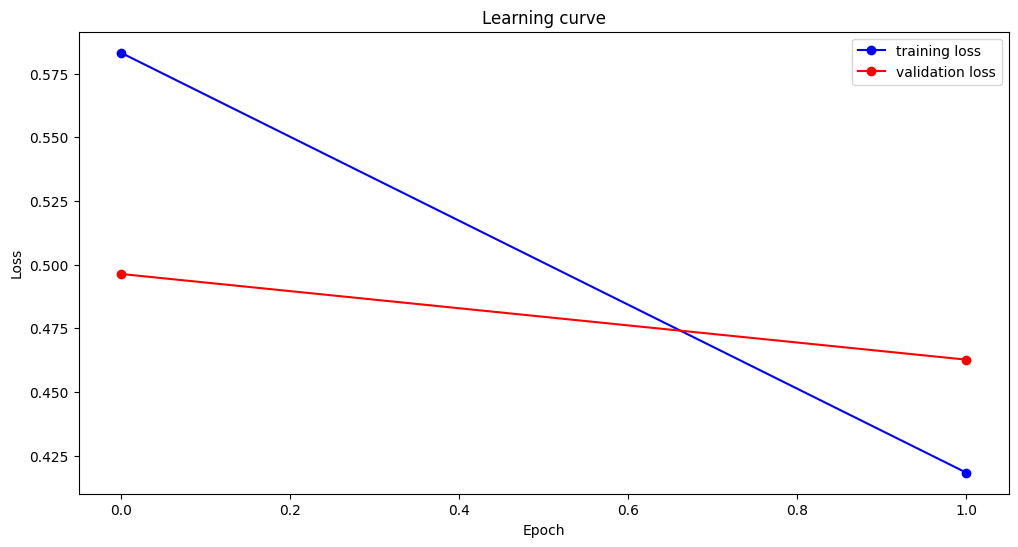

100%|██████████| 45/45 [00:09<00:00,  4.73it/s]


              precision    recall  f1-score   support

           0       0.84      0.89      0.87       988
           1       0.72      0.61      0.66       434

    accuracy                           0.81      1422
   macro avg       0.78      0.75      0.76      1422
weighted avg       0.80      0.81      0.80      1422



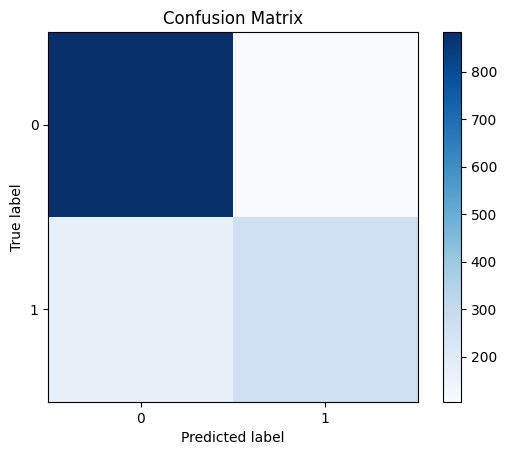

Cross Entropy for this fold: 0.4223819077014923
Epoch 1/2
----------


100%|██████████| 23/23 [00:05<00:00,  4.43it/s]


Training loss: 0.6144313999076387, Validation loss: 0.5355916437895402
Epoch 2/2
----------


100%|██████████| 23/23 [00:05<00:00,  4.41it/s]


Training loss: 0.47301869339017727, Validation loss: 0.4375247760959294


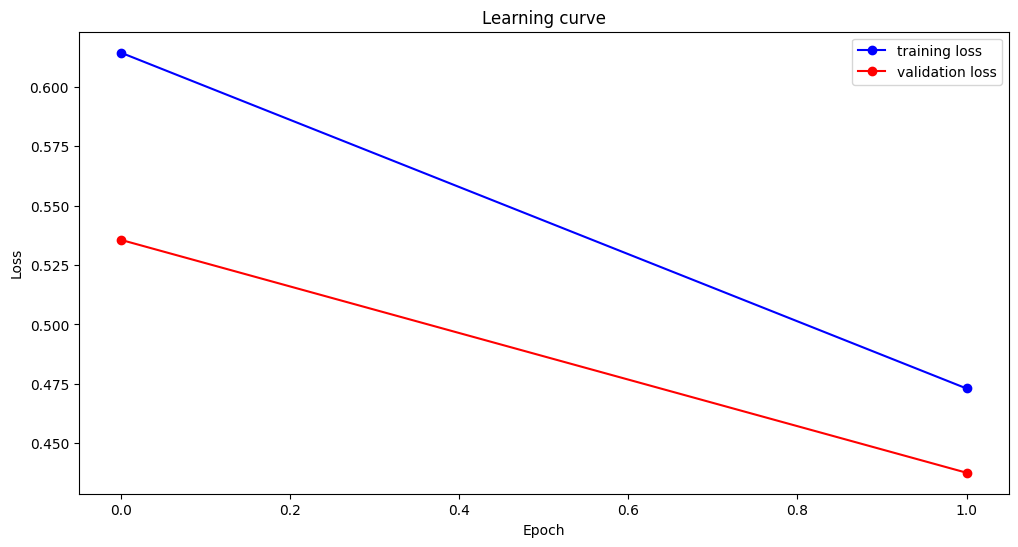

100%|██████████| 45/45 [00:09<00:00,  4.77it/s]


              precision    recall  f1-score   support

           0       0.82      0.88      0.85       988
           1       0.67      0.55      0.61       433

    accuracy                           0.78      1421
   macro avg       0.74      0.72      0.73      1421
weighted avg       0.77      0.78      0.77      1421



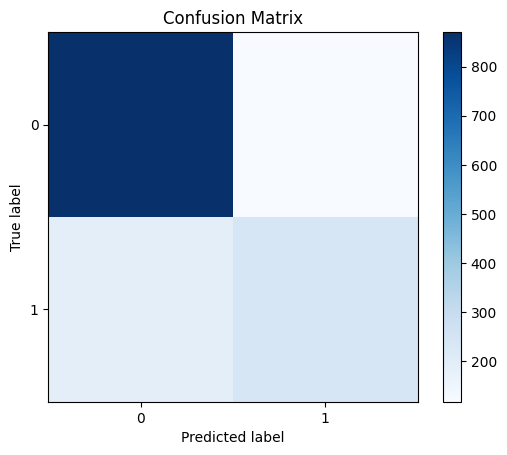

Cross Entropy for this fold: 0.4676985740661621
majority_community_1 - Average Cross Entropy: 0.4388147294521332
majority_community_1 - Average F1 Macro Score: 0.750407425178426
Fine-tuning and running experiment for majority_community_2
Epoch 1/2
----------


100%|██████████| 24/24 [00:05<00:00,  4.76it/s]


Training loss: 0.637905137028013, Validation loss: 0.6101453664402167
Epoch 2/2
----------


100%|██████████| 24/24 [00:05<00:00,  4.73it/s]


Training loss: 0.5347249329090118, Validation loss: 0.5337864719331264


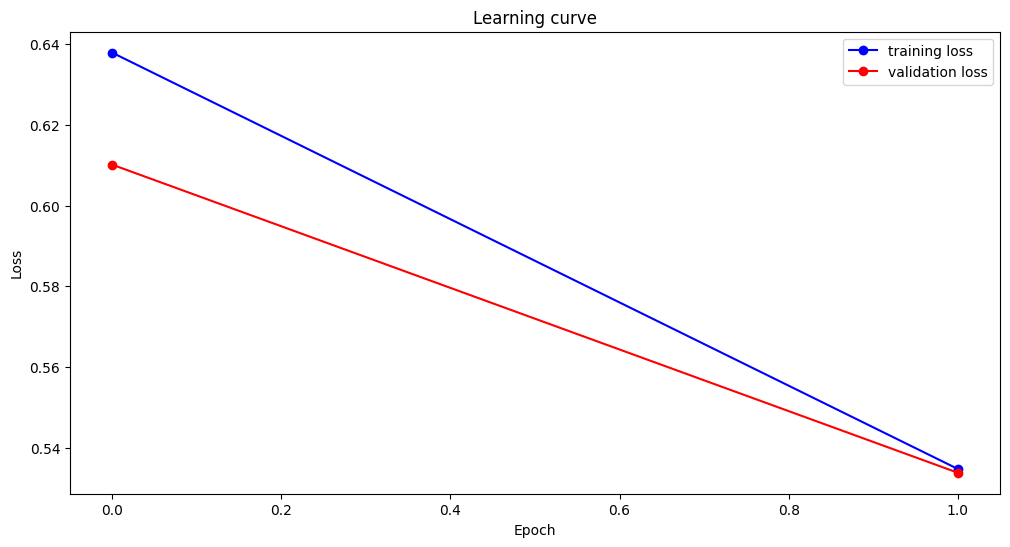

100%|██████████| 47/47 [00:09<00:00,  4.76it/s]


              precision    recall  f1-score   support

           0       0.76      0.84      0.80       947
           1       0.66      0.55      0.60       543

    accuracy                           0.73      1490
   macro avg       0.71      0.69      0.70      1490
weighted avg       0.73      0.73      0.73      1490



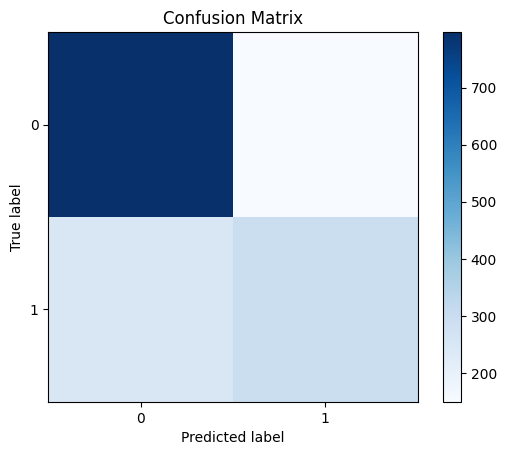

Cross Entropy for this fold: 0.5397328734397888
Epoch 1/2
----------


100%|██████████| 24/24 [00:05<00:00,  4.75it/s]


Training loss: 0.6421917532171522, Validation loss: 0.5980146887401739
Epoch 2/2
----------


100%|██████████| 24/24 [00:05<00:00,  4.75it/s]


Training loss: 0.5333337592227119, Validation loss: 0.5191452838480473


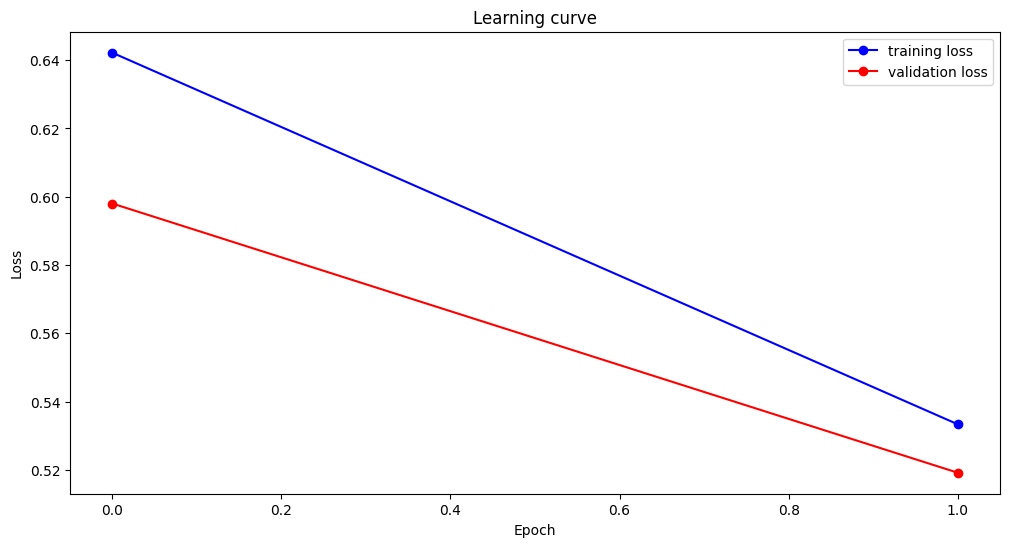

100%|██████████| 47/47 [00:10<00:00,  4.65it/s]


              precision    recall  f1-score   support

           0       0.76      0.91      0.82       946
           1       0.75      0.49      0.59       544

    accuracy                           0.75      1490
   macro avg       0.75      0.70      0.71      1490
weighted avg       0.75      0.75      0.74      1490



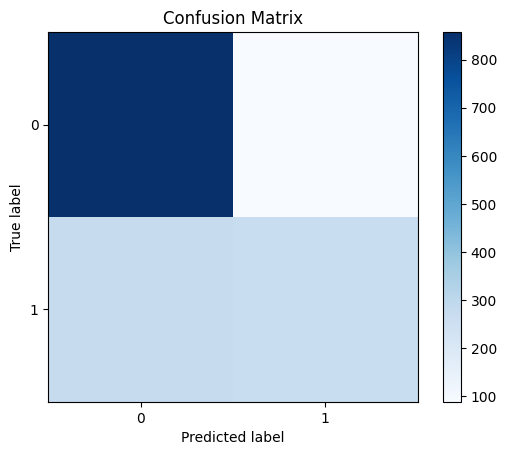

Cross Entropy for this fold: 0.5229762196540833
Epoch 1/2
----------


100%|██████████| 24/24 [00:05<00:00,  4.44it/s]


Training loss: 0.6297351905277797, Validation loss: 0.5978187471628189
Epoch 2/2
----------


100%|██████████| 24/24 [00:05<00:00,  4.39it/s]


Training loss: 0.5103668119226183, Validation loss: 0.5486580543220043


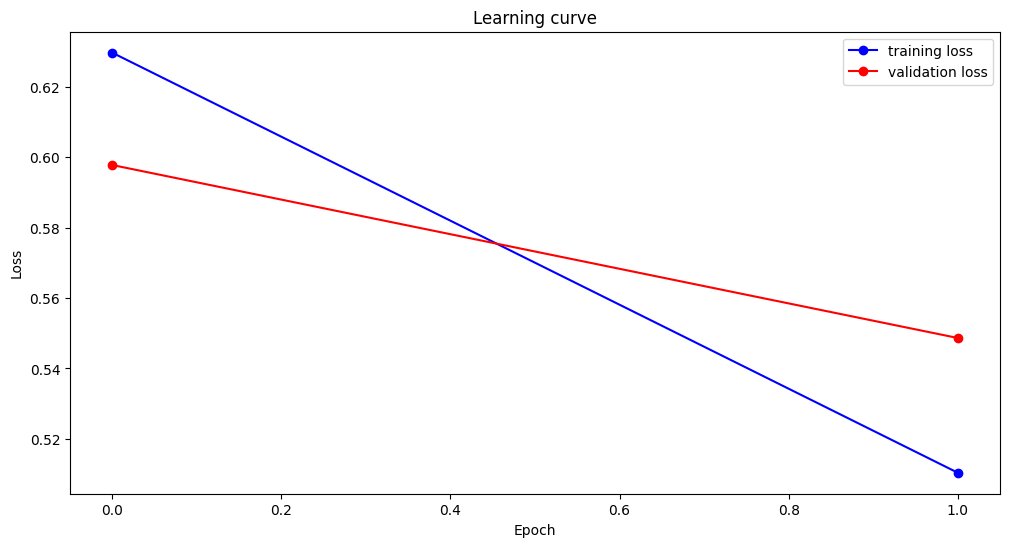

100%|██████████| 47/47 [00:09<00:00,  4.70it/s]


              precision    recall  f1-score   support

           0       0.75      0.84      0.79       946
           1       0.64      0.51      0.57       543

    accuracy                           0.72      1489
   macro avg       0.70      0.67      0.68      1489
weighted avg       0.71      0.72      0.71      1489



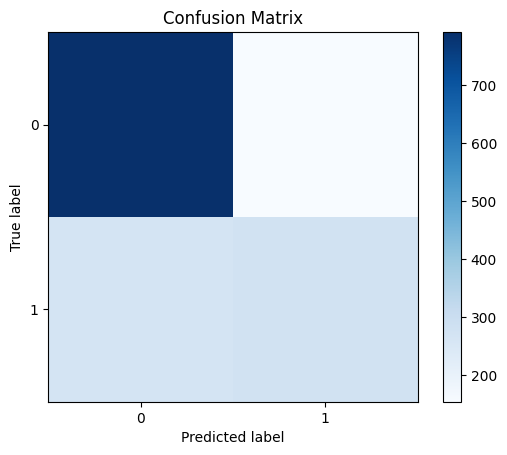

Cross Entropy for this fold: 0.5479387640953064
majority_community_2 - Average Cross Entropy: 0.5368826190630595
majority_community_2 - Average F1 Macro Score: 0.6962715208966676
Fine-tuning and running experiment for majority_community_3
Epoch 1/2
----------


100%|██████████| 24/24 [00:05<00:00,  4.54it/s]


Training loss: 0.6312860784431299, Validation loss: 0.576620830843846
Epoch 2/2
----------


100%|██████████| 24/24 [00:05<00:00,  4.51it/s]


Training loss: 0.5287275335027112, Validation loss: 0.511938555787007


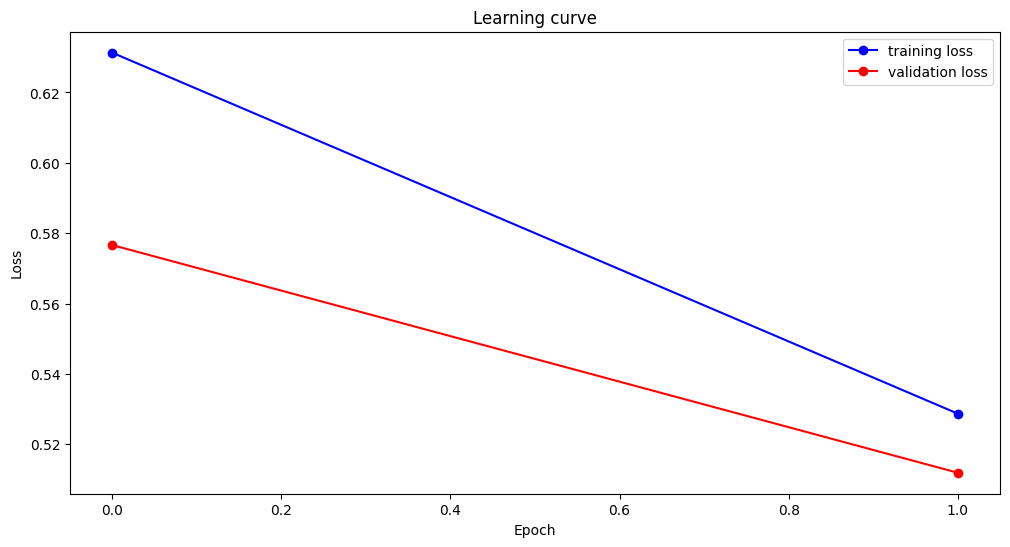

100%|██████████| 48/48 [00:10<00:00,  4.64it/s]


              precision    recall  f1-score   support

           0       0.75      0.89      0.82      1019
           1       0.66      0.42      0.52       515

    accuracy                           0.73      1534
   macro avg       0.71      0.66      0.67      1534
weighted avg       0.72      0.73      0.72      1534



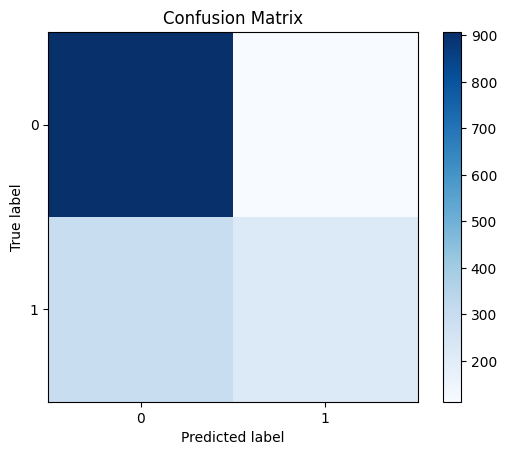

Cross Entropy for this fold: 0.5311593413352966
Epoch 1/2
----------


100%|██████████| 24/24 [00:05<00:00,  4.63it/s]


Training loss: 0.6382631489800082, Validation loss: 0.5962265133857727
Epoch 2/2
----------


100%|██████████| 24/24 [00:05<00:00,  4.63it/s]


Training loss: 0.5341221520470248, Validation loss: 0.5436891925831636


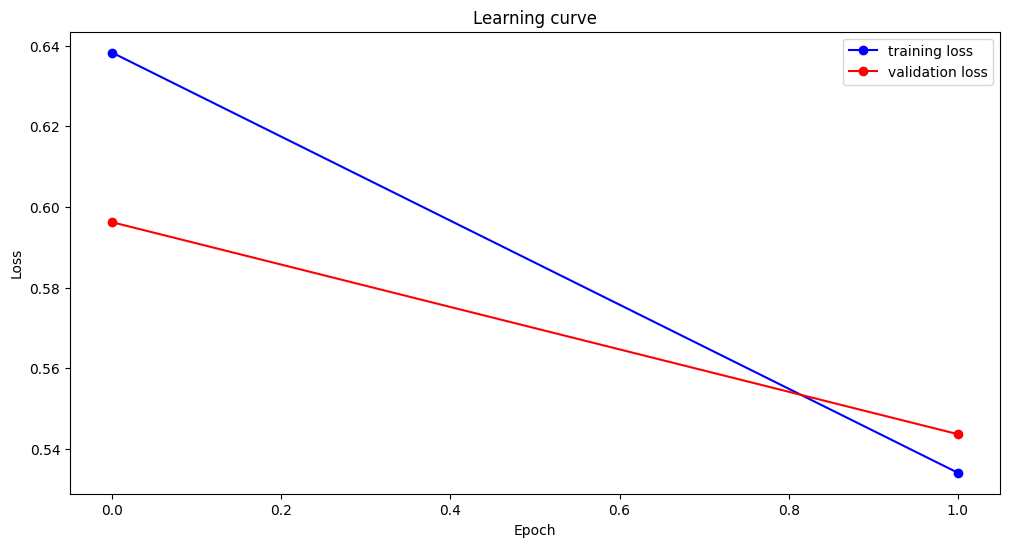

100%|██████████| 48/48 [00:10<00:00,  4.64it/s]


              precision    recall  f1-score   support

           0       0.78      0.87      0.82      1019
           1       0.67      0.51      0.58       515

    accuracy                           0.75      1534
   macro avg       0.72      0.69      0.70      1534
weighted avg       0.74      0.75      0.74      1534



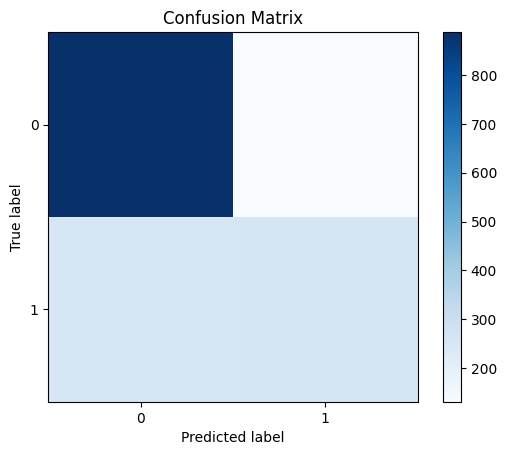

Cross Entropy for this fold: 0.5162622928619385
Epoch 1/2
----------


100%|██████████| 24/24 [00:05<00:00,  4.62it/s]


Training loss: 0.6299112977253066, Validation loss: 0.5806817697981993
Epoch 2/2
----------


100%|██████████| 24/24 [00:05<00:00,  4.61it/s]


Training loss: 0.5212387889623642, Validation loss: 0.5255797319114208


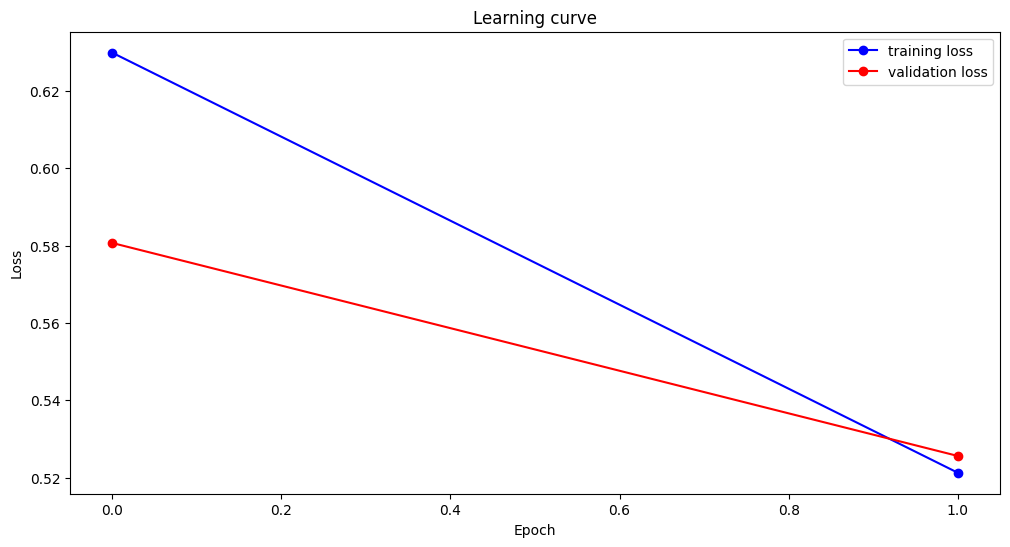

100%|██████████| 48/48 [00:10<00:00,  4.66it/s]


              precision    recall  f1-score   support

           0       0.77      0.83      0.80      1018
           1       0.60      0.50      0.55       515

    accuracy                           0.72      1533
   macro avg       0.69      0.67      0.67      1533
weighted avg       0.71      0.72      0.71      1533



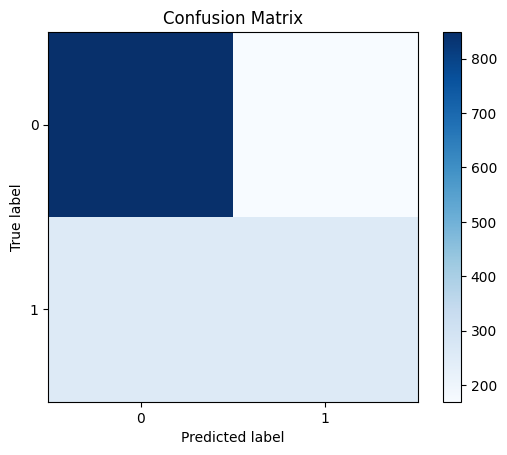

Cross Entropy for this fold: 0.5562787652015686
majority_community_3 - Average Cross Entropy: 0.5345667997996012
majority_community_3 - Average F1 Macro Score: 0.6791070686580903


In [ ]:
# Load the data
community_files = [
    "community_0_data_final_md_leiden.csv",
    "community_1_data_final_md_leiden.csv",
    "community_2_data_final_md_leiden.csv",
    "community_3_data_final_md_leiden.csv",
]

community_dfs = {f"majority_community_{i}": pd.read_csv(f"majority_community_{i}_data_final_md_leiden.csv") for i in range(4)}
combined_df = pd.read_csv("majority_combined_communities_data_final_md_leiden.csv")

f1_scores_dict = {}
cross_entropy_scores_dict = {}

# Pretrain the model on the combined dataset
print("Pretraining model on combined community")
pretrained_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
combined_community_name = "majority_combined_community"
_, _ = run_transfer_learning_experiment(pretrained_model, combined_df, combined_community_name)

# Fine-tune the pre-trained model on each community
for community_name, community_df in community_dfs.items():
    print(f"Fine-tuning and running experiment for {community_name}")
    cross_entropy, f1_macro = run_transfer_learning_experiment(pretrained_model, community_df, community_name)
    f1_scores_dict[community_name] = f1_macro
    cross_entropy_scores_dict[community_name] = cross_entropy

In [ ]:
f1_scores_df = pd.DataFrame(list(f1_scores_dict.items()), columns=['Community', 'F1 Macro Score']).set_index('Community')
cross_entropy_scores_df = pd.DataFrame(list(cross_entropy_scores_dict.items()), columns=['Community', 'Cross Entropy']).set_index('Community')

**majority_combined_community f1 macro: 0.7716659021259628**

**majority_combined_community cross-entropy 0.41390543182690936**

In [ ]:
# Create a baseline row
baseline_row = {'Community': 'combined: majority_combined_community', 'F1 Macro Score': 0.771666, 'Cross Entropy': 0.413905}

# Assign the baseline to the dataframe
f1_scores_df.loc['majority_combined_community'] = baseline_row
cross_entropy_scores_df.loc['majority_combined_community'] = baseline_row

In [ ]:
f1_scores_df

F1 Macro Score
Community                                  
majority_community_0               0.501154
majority_community_1               0.750407
majority_community_2               0.696272
majority_community_3               0.679107
majority_combined_community        0.771666

In [ ]:
cross_entropy_scores_df

Cross Entropy
Community                                 
majority_community_0              0.429980
majority_community_1              0.438815
majority_community_2              0.536883
majority_community_3              0.534567
majority_combined_community       0.413905

In [ ]:
# List of community names
community_names = [
    "majority_community_0",
    "majority_community_1",
    "majority_community_2",
    "majority_community_3"
]

# Load and display incorrectly classified instances for each community
for community_name in community_names:
    # Load the incorrectly classified instances from the CSV file
    filename = f"{community_name}_incorrectly_classified_instances.csv"
    incorrectly_classified_df = pd.read_csv(filename)

    # Display the DataFrame (You can also perform any further analysis you need on this DataFrame)
    print(f"Incorrectly Classified Instances for {community_name}:")
    display(incorrectly_classified_df)


Incorrectly Classified Instances for majority_community_0:


instance_id  offensiveness  \
0            174              1   
1            308              1   
2            830              1   
3           1375              1   
4           1496              1   
..           ...            ...   
668        10601              1   
669        10688              1   
670        10697              1   
671        10699              1   
672        10734              1   

                                          cleaned_text cleaned_domain  \
0    we are no longer mailing our ballots. hand del...  elections2020   
1    well i am sure you know jim crow joe will " pu...  elections2020   
2                                            fascists!  elections2020   
3    you are an idiot, corp will raise prices and m...  elections2020   
4    what a freaking moron! this makes about as muc...       covid-19   
..                                                 ...            ...   
668                      white people are annoying asf            blm   
669  if you do not agree with #blacklivesmatter why...            blm   
670  when this fat tub of shit has his first heart ...            blm   
671  does he still not understand what happens to e...       covid-19   
672                       ok white privileged bunghole            blm   

                                      text_with_domain  predicted_label  \
0    elections2020 we are no longer mailing our bal...                0   
1    elections2020 well i am sure you know jim crow...                0   
2                              elections2020 fascists!                0   
3    elections2020 you are an idiot, corp will rais...                0   
4    covid-19 what a freaking moron! this makes abo...                0   
..                                                 ...              ...   
668                  blm white people are annoying asf                0   
669  blm if you do not agree with #blacklivesmatter...                0   
670  blm when this fat tub of shit has his first he...                0   
671  covid-19 does he still not understand what hap...                0   
672                   blm ok white privileged bunghole                0   

     true_label  cross_entropy  
0             1       1.018918  
1             1       0.970519  
2             1       1.443170  
3             1       0.760543  
4             1       1.003330  
..          ...            ...  
668           1       2.002593  
669           1       2.017229  
670           1       2.090131  
671           1       1.563638  
672           1       1.369857  

[673 rows x 8 columns]

Incorrectly Classified Instances for majority_community_1:


instance_id  offensiveness  \
0             39              1   
1             62              0   
2             73              0   
3             84              1   
4             88              1   
..           ...            ...   
846         9624              0   
847         9835              0   
848        10401              1   
849        10406              0   
850        10624              0   

                                          cleaned_text cleaned_domain  \
0               for you and your chinese overlords, 操你  elections2020   
1    and this big guy will mindlessly drug hoover a...  elections2020   
2    just say you are racist and go you literally h...  elections2020   
3    truth from trump? hahahaha. man the republican...  elections2020   
4    told the proud boys to stand by then tells his...  elections2020   
..                                                 ...            ...   
846                this shit was legal :confused_face:            blm   
847  science says you are a demented corrupt crimin...  elections2020   
848  jesus this is amateur even for you. using an a...            blm   
849  what if is right & there is something that cle...       covid-19   
850  a peaceful protest in capitol hill quickly tur...            blm   

                                      text_with_domain  predicted_label  \
0    elections2020 for you and your chinese overlor...                0   
1    elections2020 and this big guy will mindlessly...                1   
2    elections2020 just say you are racist and go y...                1   
3    elections2020 truth from trump? hahahaha. man ...                0   
4    elections2020 told the proud boys to stand by ...                0   
..                                                 ...              ...   
846            blm this shit was legal :confused_face:                1   
847  elections2020 science says you are a demented ...                1   
848  blm jesus this is amateur even for you. using ...                0   
849  covid-19 what if is right & there is something...                1   
850  blm a peaceful protest in capitol hill quickly...                1   

     true_label  cross_entropy  
0             1       1.945009  
1             0       1.248575  
2             0       0.948574  
3             1       1.390891  
4             1       1.681231  
..          ...            ...  
846           0       0.999432  
847           0       1.331012  
848           1       0.969676  
849           0       0.882773  
850           0       1.509713  

[851 rows x 8 columns]

Incorrectly Classified Instances for majority_community_2:


instance_id  offensiveness  \
0              78              1   
1             184              0   
2             311              1   
3             409              1   
4             906              0   
...           ...            ...   
1177        10669              0   
1178        10675              1   
1179        10684              1   
1180        10712              1   
1181        10731              0   

                                           cleaned_text cleaned_domain  \
0     the fact that a lot of supporters for #blackli...            blm   
1     you do not care about american lives. all you ...       covid-19   
2     please for fuck's sake people stay at home apa...       covid-19   
3     everything is upside down in the sh*t stained ...       covid-19   
4     the only thugs in this scenario are the four s...            blm   
...                                                 ...            ...   
1177  so the love of fing god you are kidding me rig...       covid-19   
1178  he was not up for the task and his bias is so ...  elections2020   
1179  well, happy birthday. we ferment things at hom...       covid-19   
1180  as soon as the asshole explains why he never t...       covid-19   
1181  good. put that damaged brain on display. make ...       covid-19   

                                       text_with_domain  predicted_label  \
0     blm the fact that a lot of supporters for #bla...                0   
1     covid-19 you do not care about american lives....                1   
2     covid-19 please for fuck's sake people stay at...                0   
3     covid-19 everything is upside down in the sh*t...                0   
4     blm the only thugs in this scenario are the fo...                1   
...                                                 ...              ...   
1177  covid-19 so the love of fing god you are kiddi...                1   
1178  elections2020 he was not up for the task and h...                0   
1179  covid-19 well, happy birthday. we ferment thin...                0   
1180  covid-19 as soon as the asshole explains why h...                0   
1181  covid-19 good. put that damaged brain on displ...                1   

      true_label  cross_entropy  
0              1       0.965611  
1              0       0.879641  
2              1       0.789274  
3              1       0.984476  
4              0       0.920160  
...          ...            ...  
1177           0       1.037644  
1178           1       1.713974  
1179           1       1.060660  
1180           1       1.207832  
1181           0       0.887664  

[1182 rows x 8 columns]

Incorrectly Classified Instances for majority_community_3:


instance_id  offensiveness  \
0              81              1   
1             150              1   
2             158              1   
3             244              1   
4             349              1   
...           ...            ...   
1216        10700              1   
1217        10715              0   
1218        10730              0   
1219        10732              1   
1220        10743              0   

                                           cleaned_text cleaned_domain  \
0     no he does not. it is gop propaganda. another ...  elections2020   
1     and then continue legislative constipation bec...  elections2020   
2               is that all you have? the racist label?  elections2020   
3                        why is an open nazi supporter?  elections2020   
4     in trumps own words. the only racist on the st...  elections2020   
...                                                 ...            ...   
1216    the guy is a clown but a very dangerous one !!!  elections2020   
1217  people keep on saying trump has npd. i have li...  elections2020   
1218  i am not going to waste my time with you. clea...  elections2020   
1219  we have a stupid pandemic to go along with a c...       covid-19   
1220            you are really a criminal who set fire!  elections2020   

                                       text_with_domain  predicted_label  \
0     elections2020 no he does not. it is gop propag...                0   
1     elections2020 and then continue legislative co...                0   
2     elections2020 is that all you have? the racist...                0   
3          elections2020 why is an open nazi supporter?                0   
4     elections2020 in trumps own words. the only ra...                0   
...                                                 ...              ...   
1216  elections2020 the guy is a clown but a very da...                0   
1217  elections2020 people keep on saying trump has ...                1   
1218  elections2020 i am not going to waste my time ...                1   
1219  covid-19 we have a stupid pandemic to go along...                0   
1220  elections2020 you are really a criminal who se...                1   

      true_label  cross_entropy  
0              1       2.417108  
1              1       1.828047  
2              1       0.875576  
3              1       1.953301  
4              1       0.777943  
...          ...            ...  
1216           1       0.747035  
1217           0       1.102208  
1218           0       0.713427  
1219           1       1.063429  
1220           0       0.826041  

[1221 rows x 8 columns]

# Model 3b: Transfer Learning on mixed majority and individual datasets

In [ ]:
def run_transfer_learning_individual(pretrained_model, df, community_name):
    cross_entropy_scores = []
    f1_macro_scores = []
    correctly_classified_instances = []
    incorrectly_classified_instances = []

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()

    unique_instance_ids = df['instance_id'].unique()
    labels_for_unique_ids = df.drop_duplicates(subset='instance_id')['offensiveness'].values

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

    for train_val_ids, test_ids in skf.split(unique_instance_ids, labels_for_unique_ids):
        train_val_df = df[df['instance_id'].isin(unique_instance_ids[train_val_ids])]
        test_df = df[df['instance_id'].isin(unique_instance_ids[test_ids])]

        train_ids, val_ids = train_test_split(train_val_ids, test_size=0.25, random_state=1, stratify=labels_for_unique_ids[train_val_ids])
        train_df = df[df['instance_id'].isin(unique_instance_ids[train_ids])]
        val_df = df[df['instance_id'].isin(unique_instance_ids[val_ids])]

        train_df['text_with_domain'] = train_df['cleaned_domain'] + " " + train_df['cleaned_text']
        val_df['text_with_domain'] = val_df['cleaned_domain'] + " " + val_df['cleaned_text']
        test_df['text_with_domain'] = test_df['cleaned_domain'] + " " + test_df['cleaned_text']

        train_dataloader, validation_dataloader, test_dataloader, test_labels = prepare_dataset_and_loaders(train_df, val_df, test_df, tokenizer)

        # Copy pretrained model for fine-tuning
        model = copy.deepcopy(pretrained_model)
        model.to(device)
        optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.0)
        epochs = 2
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)

        model_filename = f"{community_name}_epoch_{epochs}"
        loss_values, validation_loss_values = train(model, train_dataloader, validation_dataloader, optimizer, scheduler, device, epochs, model_filename)
        plot_loss_curves(loss_values, validation_loss_values)

        predictions, true_labels = evaluate(model, test_dataloader, device)
        print(classification_report(true_labels, predictions.argmax(axis=1)))
        plot_confusion_matrix(true_labels, predictions.argmax(axis=1))

        cross_entropy = criterion(torch.tensor(predictions), torch.tensor(true_labels))
        cross_entropy_scores.append(cross_entropy.item())
        print(f"Cross Entropy for this fold: {cross_entropy.item()}")

        f1_macro = f1_score(true_labels, predictions.argmax(axis=1), average='macro')
        f1_macro_scores.append(f1_macro)

        predicted_labels = predictions.argmax(axis=1)
        for i, (true_label, predicted_label) in enumerate(zip(true_labels, predicted_labels)):
            instance = test_df.iloc[i].to_dict()
            instance['predicted_label'] = predicted_label
            instance['true_label'] = true_label
            instance_cross_entropy = criterion(torch.tensor(predictions[i]).unsqueeze(0), torch.tensor([true_label]))
            instance['cross_entropy'] = instance_cross_entropy.item()
            if true_label == predicted_label:
                correctly_classified_instances.append(instance)
            else:
                incorrectly_classified_instances.append(instance)

    correctly_classified_df = pd.DataFrame(correctly_classified_instances)
    incorrectly_classified_df = pd.DataFrame(incorrectly_classified_instances)

    correctly_classified_df.to_csv(f"{community_name}_correctly_classified_instances.csv", index=False)
    incorrectly_classified_df.to_csv(f"{community_name}_incorrectly_classified_instances.csv", index=False)

    average_cross_entropy = np.mean(cross_entropy_scores)
    average_f1_macro = np.mean(f1_macro_scores)

    print(f"{community_name} - Average Cross Entropy: {average_cross_entropy}")
    print(f"{community_name} - Average F1 Macro Score: {average_f1_macro}")

    return average_cross_entropy, average_f1_macro

Pretraining model on combined community


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
----------


100%|██████████| 56/56 [00:13<00:00,  4.20it/s]


Training loss: 0.5098704446461939, Validation loss: 0.41362642869353294
Epoch 2/2
----------


100%|██████████| 56/56 [00:12<00:00,  4.35it/s]


Training loss: 0.3508770114609173, Validation loss: 0.40830338054469656


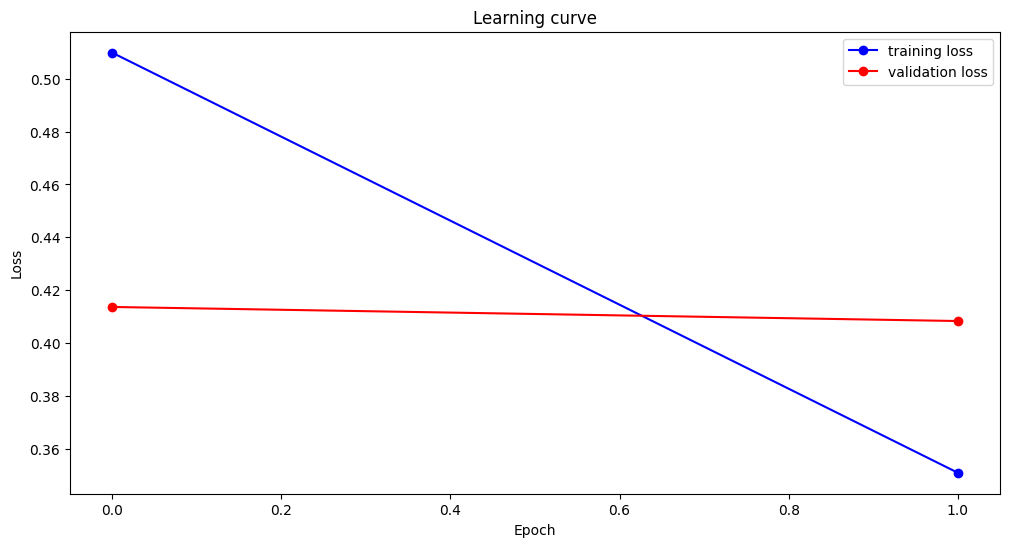

100%|██████████| 112/112 [00:25<00:00,  4.32it/s]


              precision    recall  f1-score   support

           0       0.85      0.90      0.87      2532
           1       0.71      0.62      0.66      1052

    accuracy                           0.82      3584
   macro avg       0.78      0.76      0.77      3584
weighted avg       0.81      0.82      0.81      3584



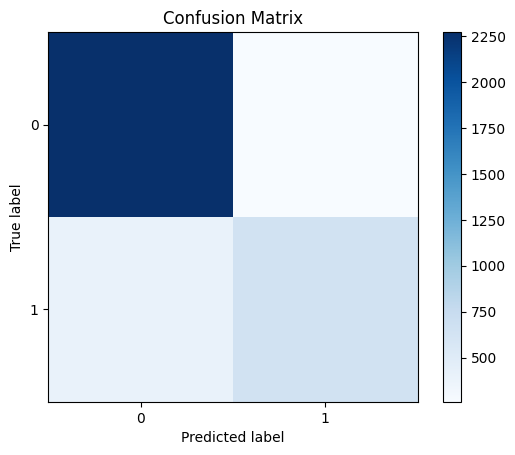

Cross Entropy for this fold: 0.4168207049369812
Epoch 1/2
----------


100%|██████████| 56/56 [00:13<00:00,  4.30it/s]


Training loss: 0.5150556823327428, Validation loss: 0.40920498222112656
Epoch 2/2
----------


100%|██████████| 56/56 [00:13<00:00,  4.29it/s]


Training loss: 0.35165770325277534, Validation loss: 0.39328179508447647


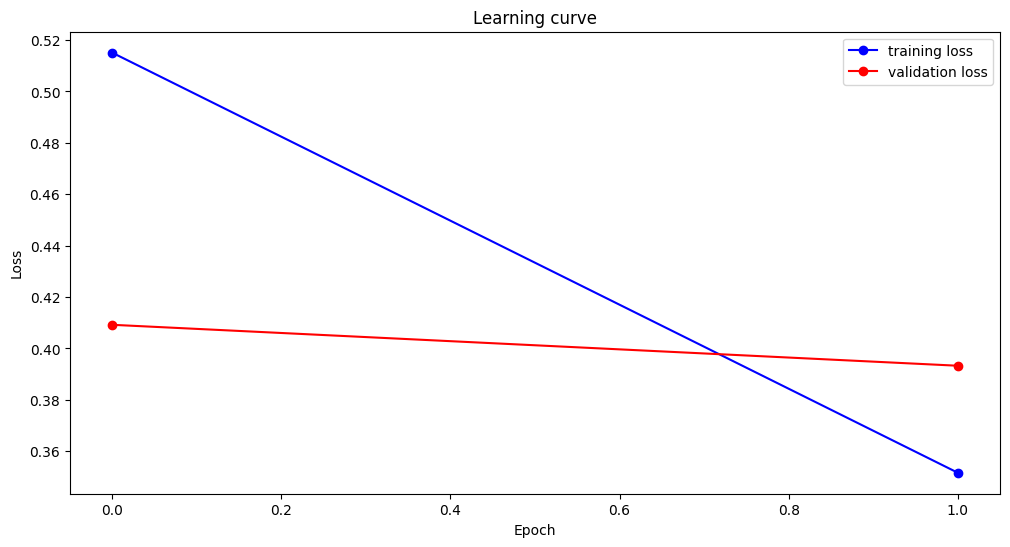

100%|██████████| 112/112 [00:26<00:00,  4.30it/s]


              precision    recall  f1-score   support

           0       0.85      0.87      0.86      2531
           1       0.67      0.63      0.65      1053

    accuracy                           0.80      3584
   macro avg       0.76      0.75      0.75      3584
weighted avg       0.80      0.80      0.80      3584



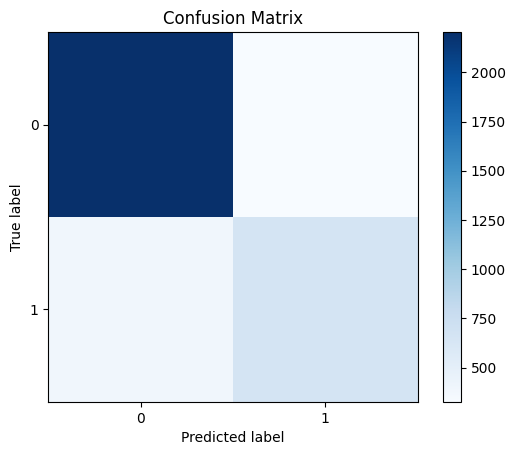

Cross Entropy for this fold: 0.43686458468437195
Epoch 1/2
----------


100%|██████████| 56/56 [00:13<00:00,  4.30it/s]


Training loss: 0.5151407109307391, Validation loss: 0.45504466391035486
Epoch 2/2
----------


100%|██████████| 56/56 [00:13<00:00,  4.30it/s]


Training loss: 0.3637505708528416, Validation loss: 0.43848192957895143


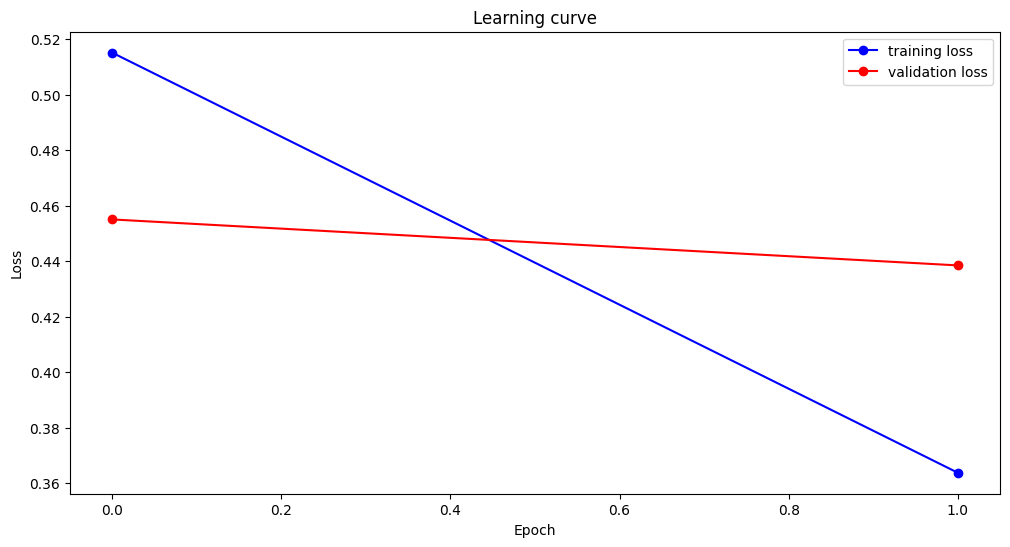

100%|██████████| 112/112 [00:25<00:00,  4.32it/s]


              precision    recall  f1-score   support

           0       0.86      0.90      0.88      2531
           1       0.74      0.66      0.70      1052

    accuracy                           0.83      3583
   macro avg       0.80      0.78      0.79      3583
weighted avg       0.83      0.83      0.83      3583



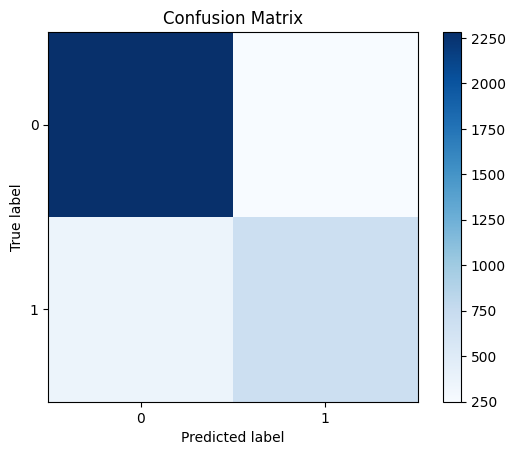

Cross Entropy for this fold: 0.3882081210613251
majority_combined_community - Average Cross Entropy: 0.4139644702275594
majority_combined_community - Average F1 Macro Score: 0.7706297148027845
Fine-tuning and running experiment for community_0
Epoch 1/2
----------


100%|██████████| 64/64 [00:13<00:00,  4.68it/s]


Training loss: 0.5142400027277635, Validation loss: 0.4484174042008817
Epoch 2/2
----------


100%|██████████| 64/64 [00:13<00:00,  4.69it/s]


Training loss: 0.4111245484913097, Validation loss: 0.44380165461916476


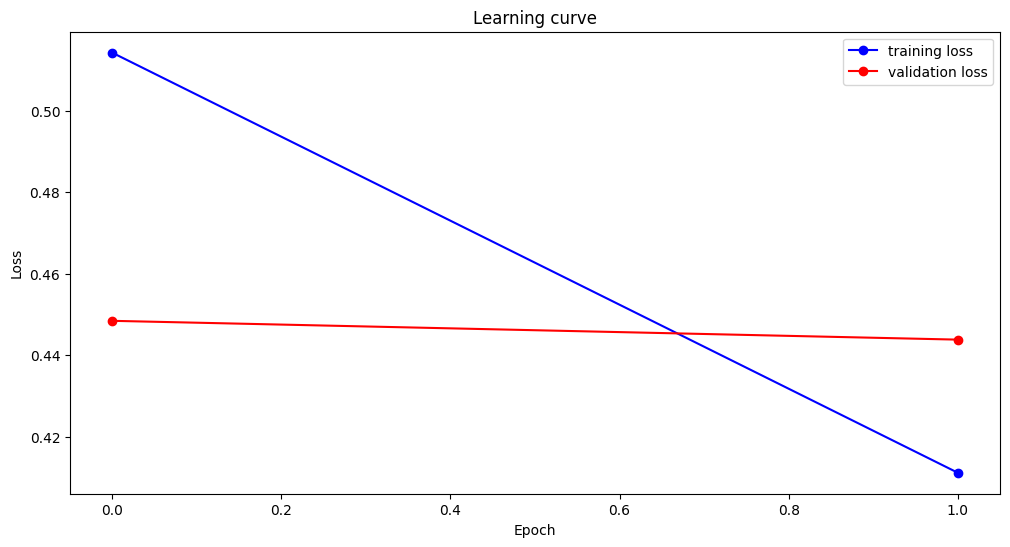

100%|██████████| 124/124 [00:28<00:00,  4.28it/s]


              precision    recall  f1-score   support

           0       0.83      0.93      0.88      2933
           1       0.69      0.44      0.53      1014

    accuracy                           0.80      3947
   macro avg       0.76      0.68      0.71      3947
weighted avg       0.79      0.80      0.79      3947



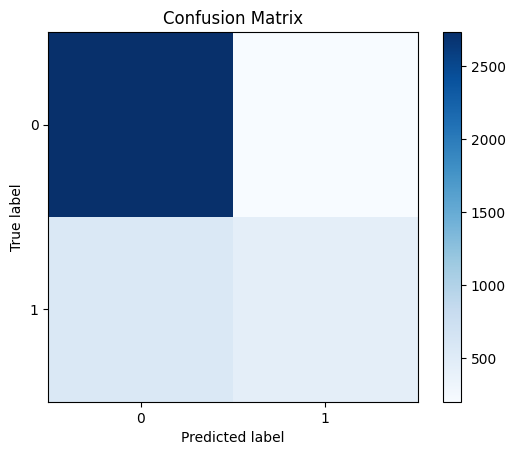

Cross Entropy for this fold: 0.44545778632164
Epoch 1/2
----------


100%|██████████| 64/64 [00:14<00:00,  4.37it/s]


Training loss: 0.5119074066692495, Validation loss: 0.4670674721710384
Epoch 2/2
----------


100%|██████████| 64/64 [00:14<00:00,  4.38it/s]


Training loss: 0.4087851022016556, Validation loss: 0.464173199608922


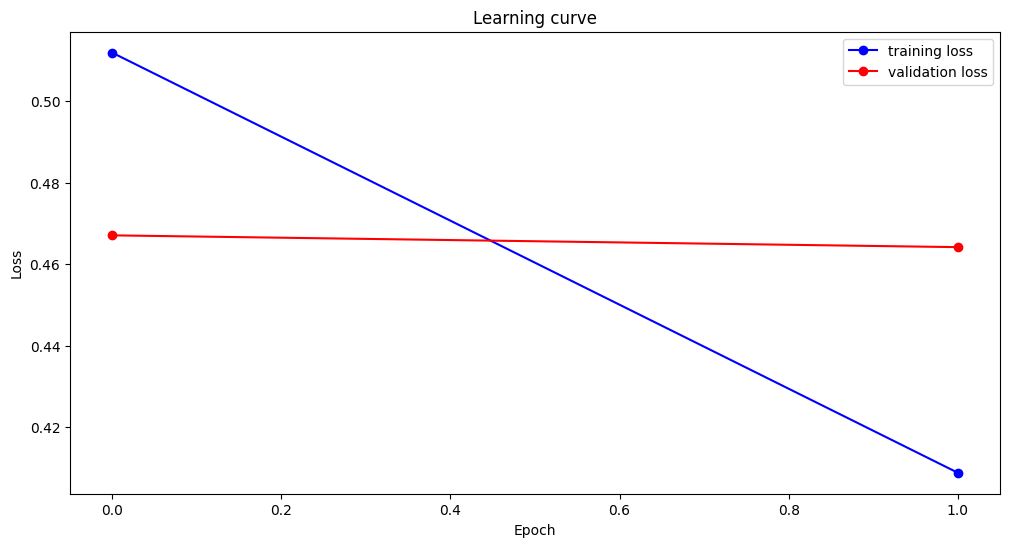

100%|██████████| 125/125 [00:28<00:00,  4.33it/s]


              precision    recall  f1-score   support

           0       0.82      0.92      0.87      2957
           1       0.66      0.42      0.52      1022

    accuracy                           0.80      3979
   macro avg       0.74      0.67      0.69      3979
weighted avg       0.78      0.80      0.78      3979



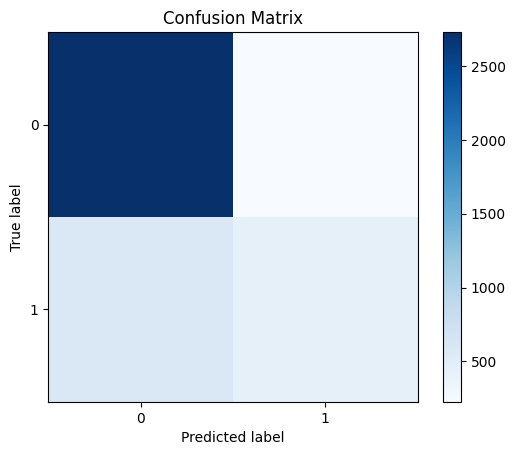

Cross Entropy for this fold: 0.46074149012565613
Epoch 1/2
----------


100%|██████████| 63/63 [00:14<00:00,  4.34it/s]


Training loss: 0.5168225257306971, Validation loss: 0.4566848911936321
Epoch 2/2
----------


100%|██████████| 63/63 [00:14<00:00,  4.36it/s]


Training loss: 0.42176337259751495, Validation loss: 0.44652223486512427


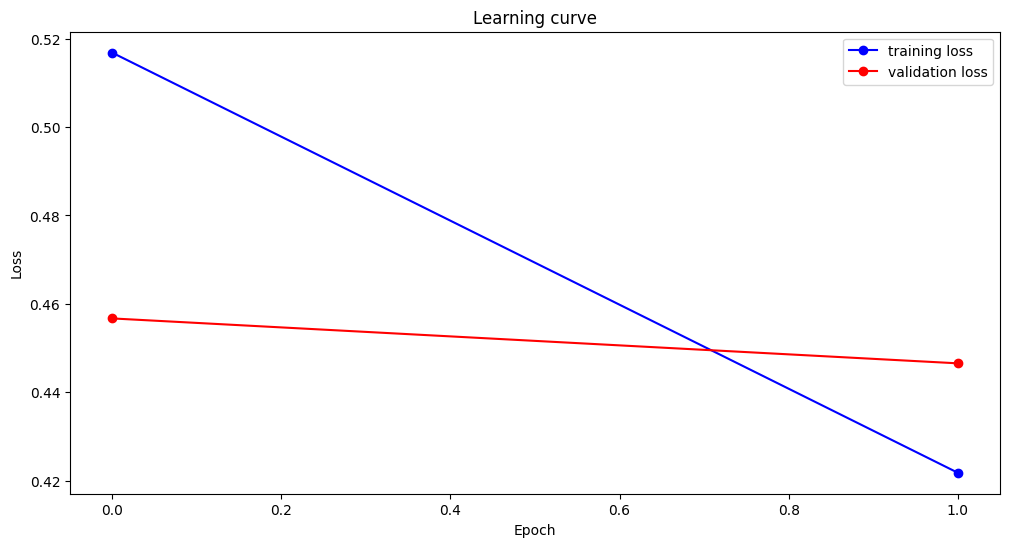

100%|██████████| 126/126 [00:29<00:00,  4.29it/s]


              precision    recall  f1-score   support

           0       0.82      0.93      0.87      3053
           1       0.63      0.36      0.46       976

    accuracy                           0.79      4029
   macro avg       0.72      0.65      0.66      4029
weighted avg       0.77      0.79      0.77      4029



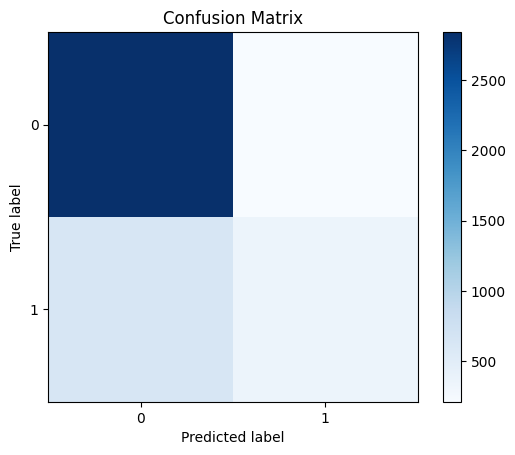

Cross Entropy for this fold: 0.46113350987434387
community_0 - Average Cross Entropy: 0.4557775954405467
community_0 - Average F1 Macro Score: 0.6876279232373026
Fine-tuning and running experiment for community_1
Epoch 1/2
----------


100%|██████████| 76/76 [00:17<00:00,  4.38it/s]


Training loss: 0.5566266824173022, Validation loss: 0.5418437437007302
Epoch 2/2
----------


100%|██████████| 76/76 [00:17<00:00,  4.38it/s]


Training loss: 0.45189088079999773, Validation loss: 0.5095028028284249


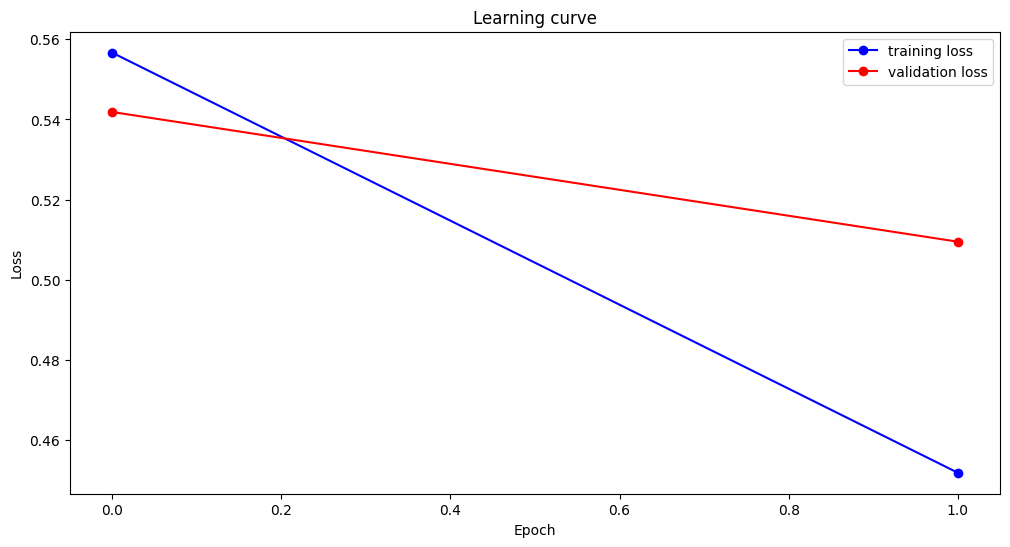

100%|██████████| 160/160 [00:37<00:00,  4.27it/s]


              precision    recall  f1-score   support

           0       0.79      0.85      0.82      3361
           1       0.67      0.58      0.62      1753

    accuracy                           0.76      5114
   macro avg       0.73      0.72      0.72      5114
weighted avg       0.75      0.76      0.75      5114



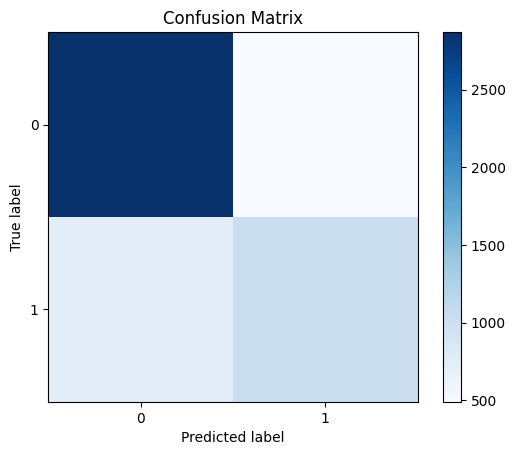

Cross Entropy for this fold: 0.5012673139572144
Epoch 1/2
----------


100%|██████████| 79/79 [00:18<00:00,  4.36it/s]


Training loss: 0.5513172745704651, Validation loss: 0.5079599358612978
Epoch 2/2
----------


100%|██████████| 79/79 [00:18<00:00,  4.37it/s]


Training loss: 0.45064948223719076, Validation loss: 0.49705057185661944


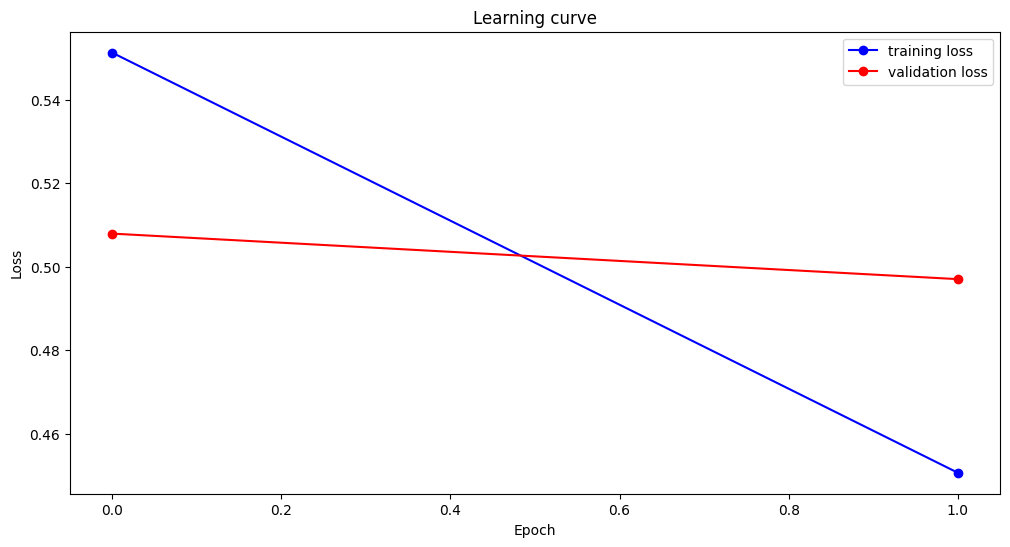

100%|██████████| 156/156 [00:36<00:00,  4.28it/s]


              precision    recall  f1-score   support

           0       0.79      0.83      0.81      3231
           1       0.66      0.60      0.62      1740

    accuracy                           0.75      4971
   macro avg       0.72      0.71      0.72      4971
weighted avg       0.75      0.75      0.75      4971



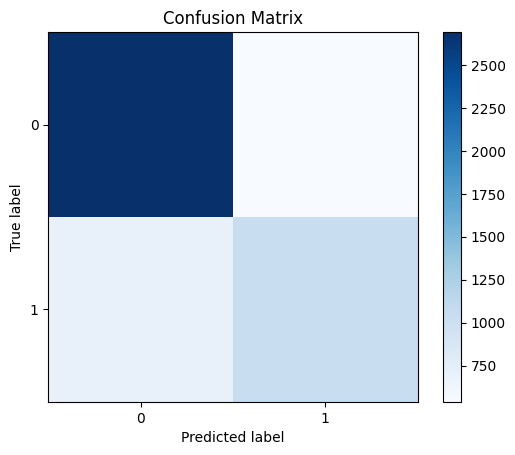

Cross Entropy for this fold: 0.5058354139328003
Epoch 1/2
----------


100%|██████████| 77/77 [00:17<00:00,  4.36it/s]


Training loss: 0.5637704001809762, Validation loss: 0.5068677539949293
Epoch 2/2
----------


100%|██████████| 77/77 [00:17<00:00,  4.37it/s]


Training loss: 0.4590507107299741, Validation loss: 0.5036800557916815


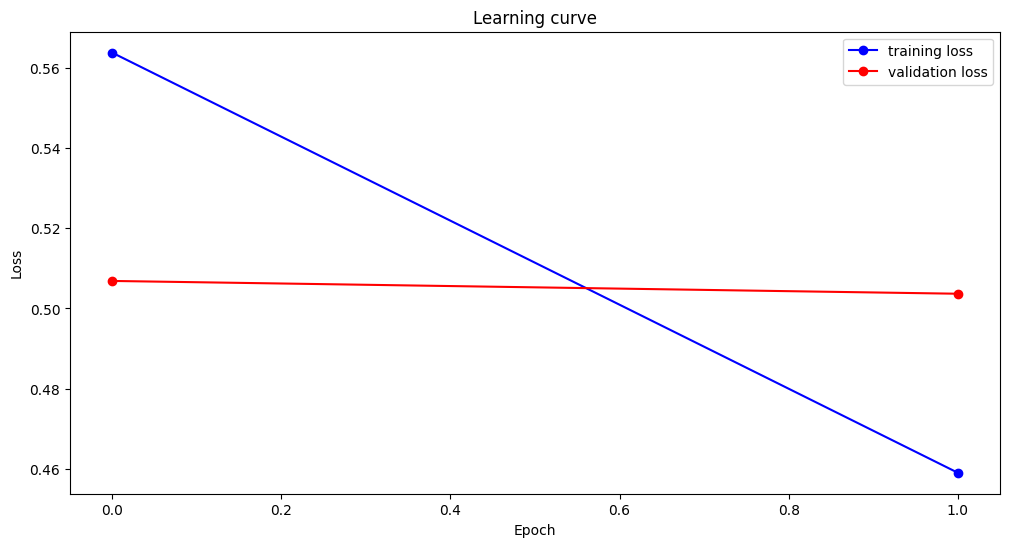

100%|██████████| 157/157 [00:36<00:00,  4.28it/s]


              precision    recall  f1-score   support

           0       0.82      0.82      0.82      3285
           1       0.65      0.64      0.65      1713

    accuracy                           0.76      4998
   macro avg       0.73      0.73      0.73      4998
weighted avg       0.76      0.76      0.76      4998



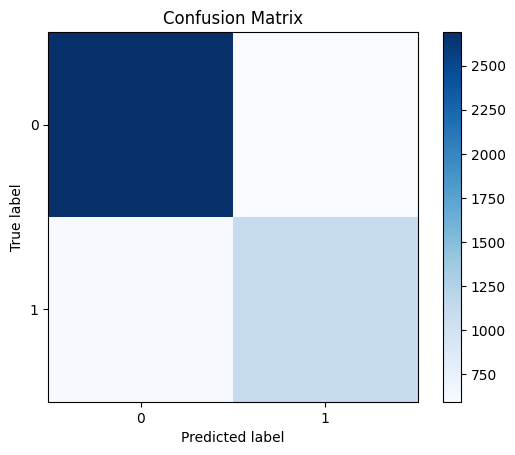

Cross Entropy for this fold: 0.48760661482810974
community_1 - Average Cross Entropy: 0.49823644757270813
community_1 - Average F1 Macro Score: 0.7243530011153254
Fine-tuning and running experiment for community_2
Epoch 1/2
----------


100%|██████████| 63/63 [00:14<00:00,  4.30it/s]


Training loss: 0.6115730653752337, Validation loss: 0.5456068288712275
Epoch 2/2
----------


100%|██████████| 63/63 [00:14<00:00,  4.31it/s]


Training loss: 0.4966079944765175, Validation loss: 0.5425973695421976


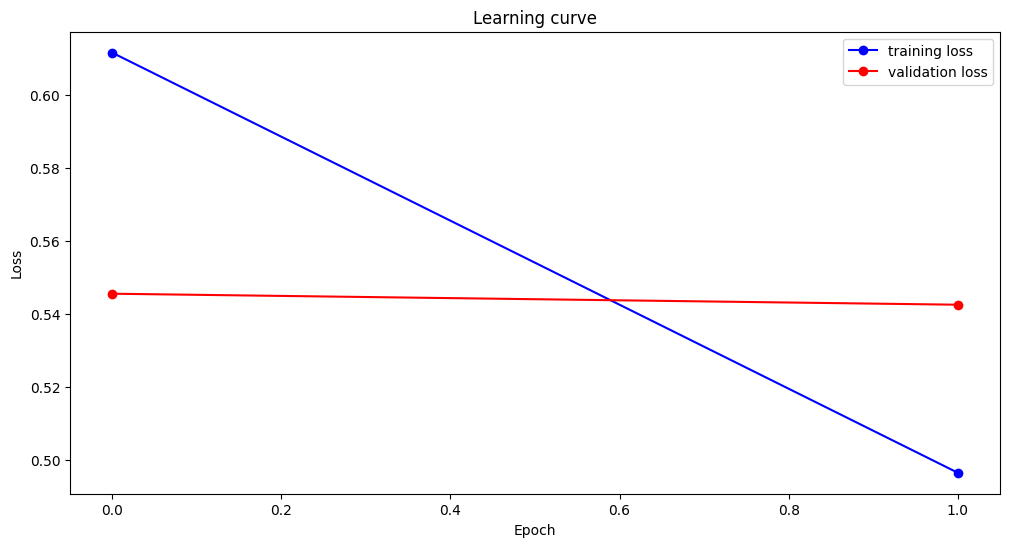

100%|██████████| 119/119 [00:27<00:00,  4.31it/s]


              precision    recall  f1-score   support

           0       0.76      0.80      0.78      2304
           1       0.65      0.60      0.62      1477

    accuracy                           0.72      3781
   macro avg       0.70      0.70      0.70      3781
weighted avg       0.72      0.72      0.72      3781



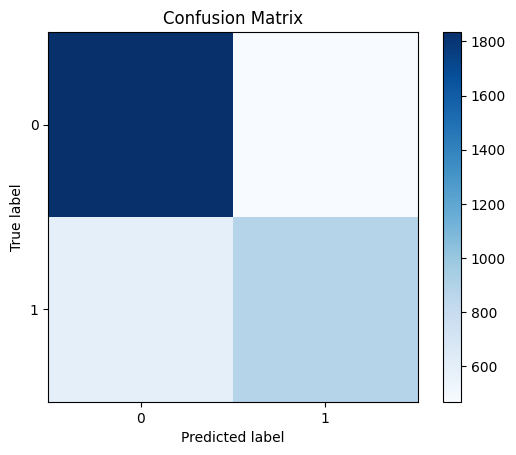

Cross Entropy for this fold: 0.5407832264900208
Epoch 1/2
----------


100%|██████████| 61/61 [00:15<00:00,  4.00it/s]


Training loss: 0.6026129459341367, Validation loss: 0.5564677466134555
Epoch 2/2
----------


100%|██████████| 61/61 [00:15<00:00,  4.00it/s]


Training loss: 0.4948953260978063, Validation loss: 0.545473429511805


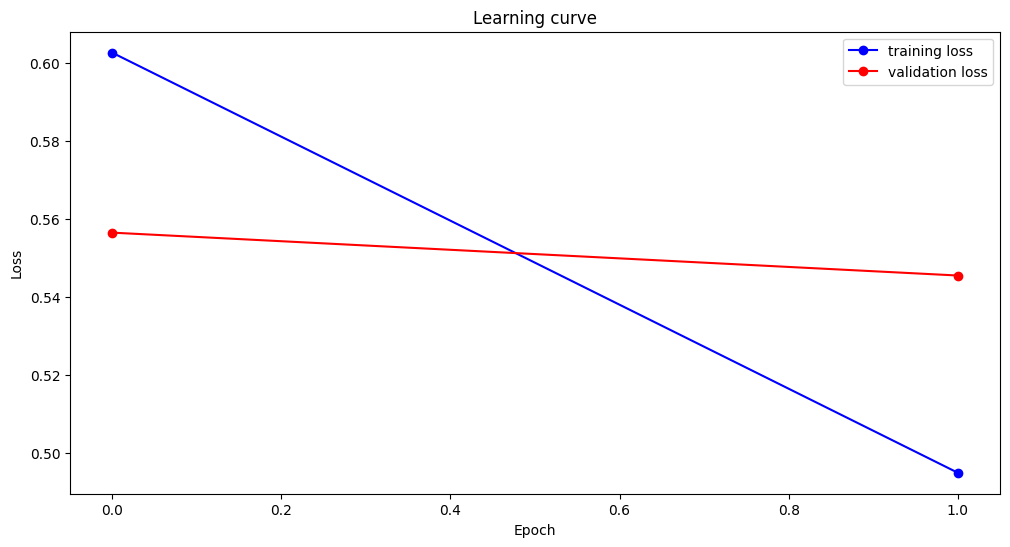

100%|██████████| 122/122 [00:28<00:00,  4.29it/s]


              precision    recall  f1-score   support

           0       0.77      0.75      0.76      2376
           1       0.63      0.64      0.63      1528

    accuracy                           0.71      3904
   macro avg       0.70      0.70      0.70      3904
weighted avg       0.71      0.71      0.71      3904



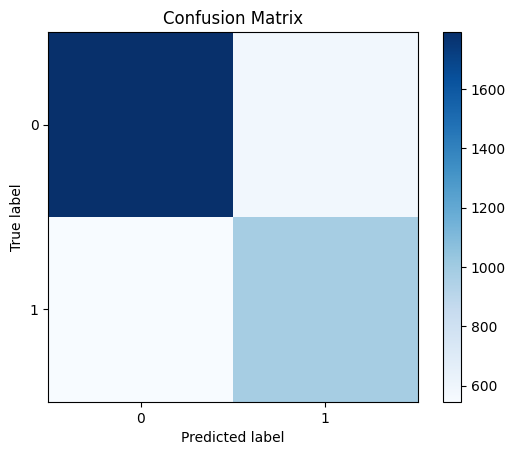

Cross Entropy for this fold: 0.5582603812217712
Epoch 1/2
----------


100%|██████████| 60/60 [00:13<00:00,  4.34it/s]


Training loss: 0.6031074089239974, Validation loss: 0.561518273750941
Epoch 2/2
----------


100%|██████████| 60/60 [00:13<00:00,  4.33it/s]


Training loss: 0.4951808179281035, Validation loss: 0.5539898465077082


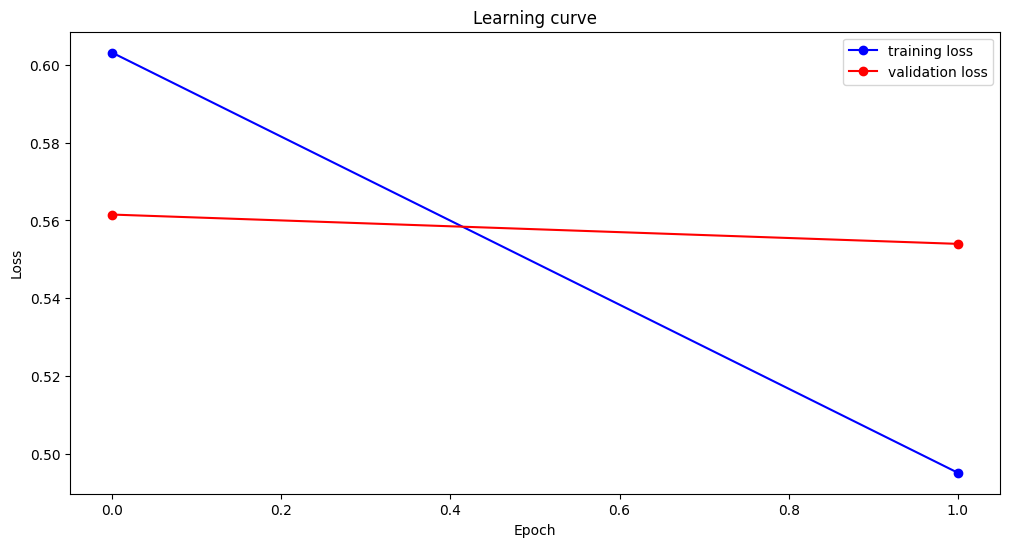

100%|██████████| 123/123 [00:28<00:00,  4.30it/s]


              precision    recall  f1-score   support

           0       0.78      0.78      0.78      2426
           1       0.64      0.64      0.64      1481

    accuracy                           0.73      3907
   macro avg       0.71      0.71      0.71      3907
weighted avg       0.73      0.73      0.73      3907



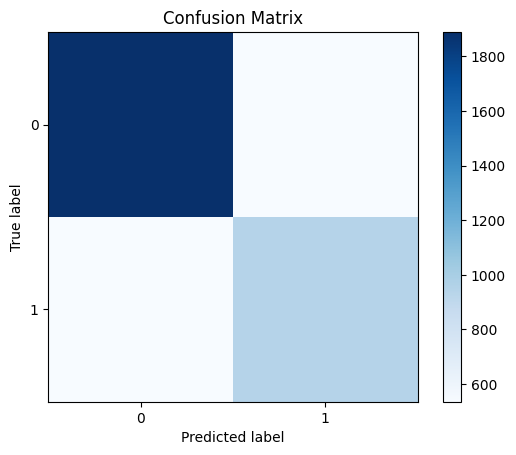

Cross Entropy for this fold: 0.5333808064460754
community_2 - Average Cross Entropy: 0.5441414713859558
community_2 - Average F1 Macro Score: 0.7019228909094856
Fine-tuning and running experiment for community_3
Epoch 1/2
----------


100%|██████████| 55/55 [00:12<00:00,  4.29it/s]


Training loss: 0.6208112331820123, Validation loss: 0.5783784031867981
Epoch 2/2
----------


100%|██████████| 55/55 [00:12<00:00,  4.32it/s]


Training loss: 0.5226721682666261, Validation loss: 0.5793259517713026


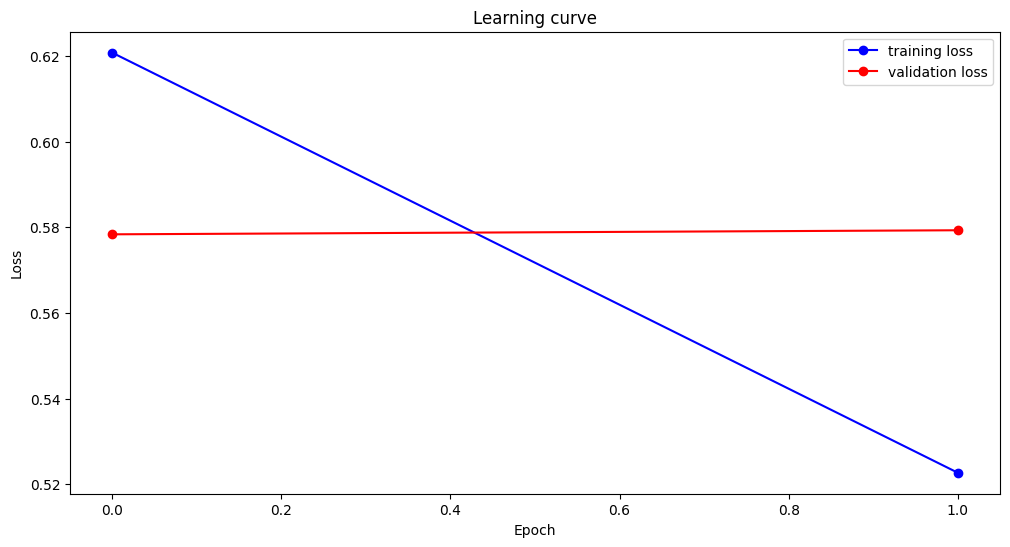

100%|██████████| 111/111 [00:25<00:00,  4.32it/s]


              precision    recall  f1-score   support

           0       0.72      0.86      0.78      2153
           1       0.69      0.48      0.57      1396

    accuracy                           0.71      3549
   macro avg       0.70      0.67      0.68      3549
weighted avg       0.71      0.71      0.70      3549



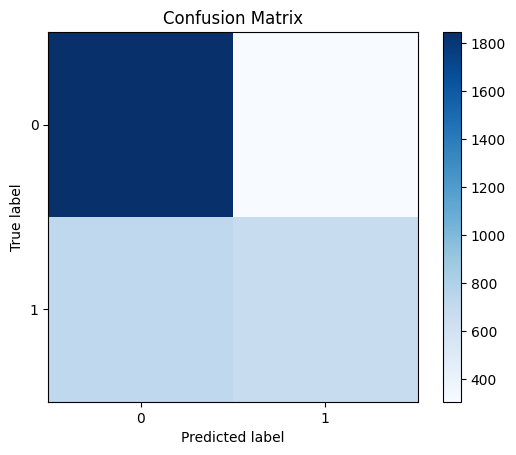

Cross Entropy for this fold: 0.5668225884437561
Epoch 1/2
----------


100%|██████████| 56/56 [00:12<00:00,  4.35it/s]


Training loss: 0.6224804833167936, Validation loss: 0.5806614091353757
Epoch 2/2
----------


100%|██████████| 56/56 [00:12<00:00,  4.35it/s]


Training loss: 0.5222617398674895, Validation loss: 0.5713716883744512


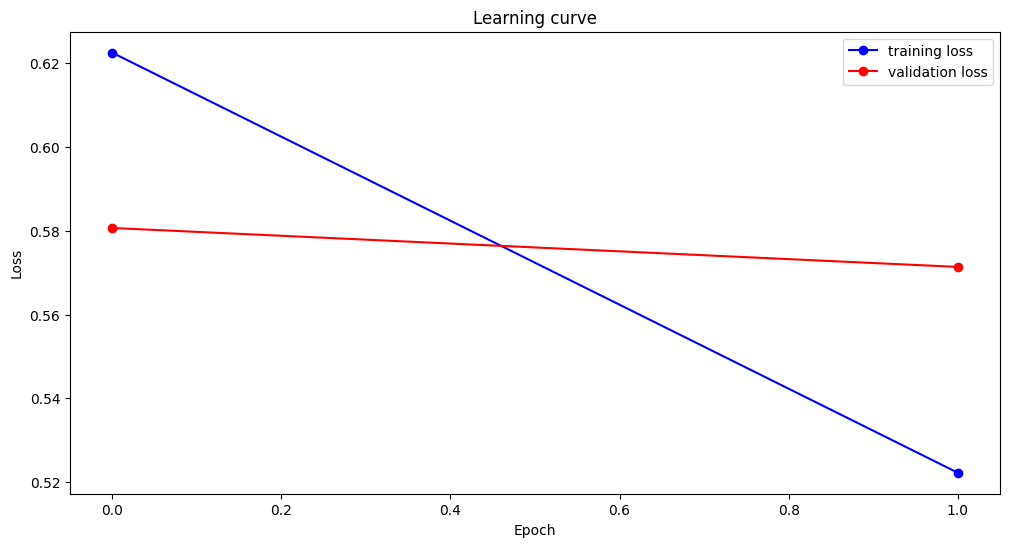

100%|██████████| 109/109 [00:25<00:00,  4.31it/s]


              precision    recall  f1-score   support

           0       0.75      0.79      0.77      2148
           1       0.63      0.56      0.59      1328

    accuracy                           0.71      3476
   macro avg       0.69      0.68      0.68      3476
weighted avg       0.70      0.71      0.70      3476



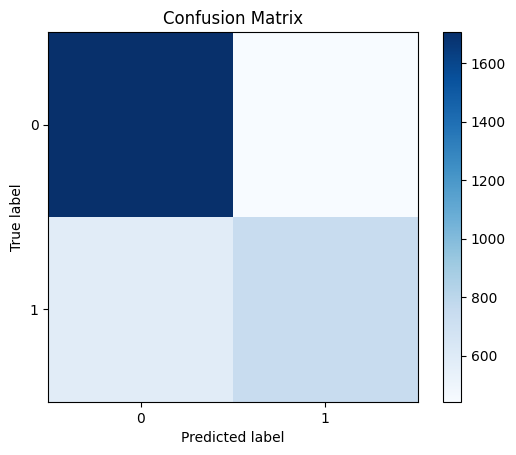

Cross Entropy for this fold: 0.5610512495040894
Epoch 1/2
----------


100%|██████████| 55/55 [00:12<00:00,  4.36it/s]


Training loss: 0.6305032751287323, Validation loss: 0.5774737818674608
Epoch 2/2
----------


100%|██████████| 55/55 [00:12<00:00,  4.35it/s]


Training loss: 0.5355037334094565, Validation loss: 0.553769958561117


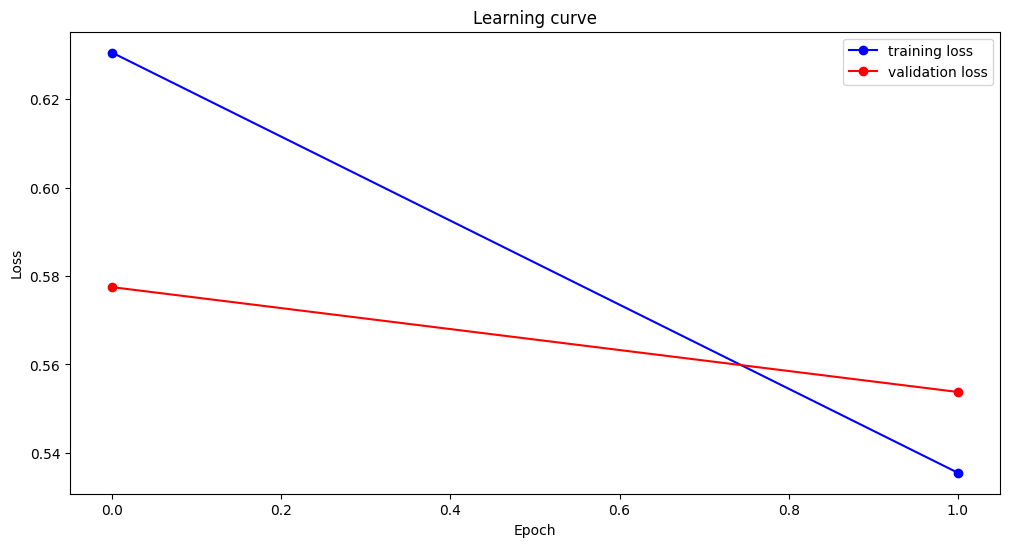

100%|██████████| 108/108 [00:25<00:00,  4.30it/s]


              precision    recall  f1-score   support

           0       0.75      0.79      0.77      2134
           1       0.63      0.57      0.60      1322

    accuracy                           0.71      3456
   macro avg       0.69      0.68      0.68      3456
weighted avg       0.70      0.71      0.71      3456



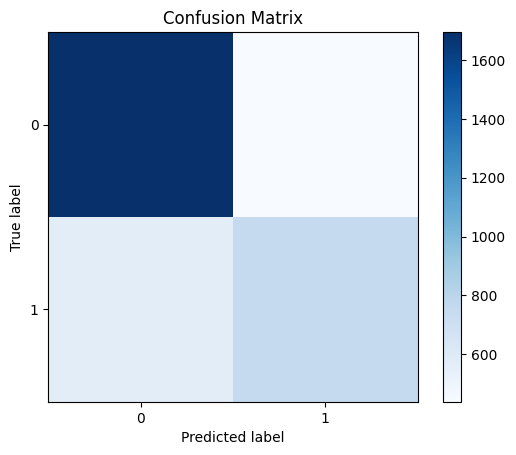

Cross Entropy for this fold: 0.5535469055175781
community_3 - Average Cross Entropy: 0.5604735811551412
community_3 - Average F1 Macro Score: 0.6805706695393386


In [ ]:
# Load the data
community_files = [
    "community_0_data_final_md_leiden.csv",
    "community_1_data_final_md_leiden.csv",
    "community_2_data_final_md_leiden.csv",
    "community_3_data_final_md_leiden.csv",
]

community_dfs = {f"community_{i}": pd.read_csv(f"community_{i}_data_final_md_leiden.csv") for i in range(4)}
combined_df = pd.read_csv("majority_combined_communities_data_final_md_leiden.csv")

f1_scores_dict = {}
cross_entropy_scores_dict = {}

# Pretrain the model on the combined dataset
print("Pretraining model on combined community")
pretrained_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
combined_community_name = "majority_combined_community"
cross_entropy, f1_macro = run_transfer_learning_individual(pretrained_model, combined_df, combined_community_name)
f1_scores_dict[combined_community_name] = f1_macro
cross_entropy_scores_dict[combined_community_name] = cross_entropy

# Fine-tune the pre-trained model on each community
for community_name, community_df in community_dfs.items():
    print(f"Fine-tuning and running experiment for {community_name}")
    cross_entropy, f1_macro = run_transfer_learning_individual(pretrained_model, community_df, community_name)
    f1_scores_dict[community_name] = f1_macro
    cross_entropy_scores_dict[community_name] = cross_entropy


In [ ]:
f1_scores_df = pd.DataFrame(list(f1_scores_dict.items()), columns=['Community', 'F1 Macro Score']).set_index('Community')
cross_entropy_scores_df = pd.DataFrame(list(cross_entropy_scores_dict.items()), columns=['Community', 'Cross Entropy']).set_index('Community')

In [ ]:
f1_scores_df

F1 Macro Score
Community                                  
majority_combined_community        0.770630
community_0                        0.687628
community_1                        0.724353
community_2                        0.701923
community_3                        0.680571

In [ ]:
cross_entropy_scores_df

Cross Entropy
Community                                 
majority_combined_community       0.413964
community_0                       0.455778
community_1                       0.498236
community_2                       0.544141
community_3                       0.560474

In [ ]:
# List of community names
community_names = [
    "majority_combined_community",
    "community_0",
    "community_1",
    "community_2",
    "community_3"
]

# Load and display incorrectly classified instances for each community
for community_name in community_names:
    # Load the incorrectly classified instances from the CSV file
    filename = f"{community_name}_incorrectly_classified_instances.csv"
    incorrectly_classified_df = pd.read_csv(filename)

    # Display the DataFrame (You can also perform any further analysis you need on this DataFrame)
    print(f"Incorrectly Classified Instances for {community_name}:")
    display(incorrectly_classified_df)


Incorrectly Classified Instances for majority_combined_community:


instance_id  offensiveness  \
0               5              1   
1               7              1   
2              14              1   
3              15              1   
4              28              1   
...           ...            ...   
1980        10645              1   
1981        10652              0   
1982        10690              1   
1983        10717              1   
1984        10731              0   

                                           cleaned_text cleaned_domain  \
0     no super-spreader accusations as people party ...       covid-19   
1     trump is in favor of what happened in texas ag...  elections2020   
2                                    gee. thanks, dick.       covid-19   
3     come on man. listen jack , okay here is the de...  elections2020   
4     reality. super! #blacklivesmatter is a racist ...            blm   
...                                                 ...            ...   
1980  just stated he would rejoin the paris accord! ...  elections2020   
1981  the whole us senate now gets the perfect excus...       covid-19   
1982  if trump intervenes, it will be a mess. it is ...  elections2020   
1983  last night i heard call #potus a "clown" as a ...  elections2020   
1984  good. put that damaged brain on display. make ...       covid-19   

                                       text_with_domain  predicted_label  \
0     covid-19 no super-spreader accusations as peop...                0   
1     elections2020 trump is in favor of what happen...                0   
2                           covid-19 gee. thanks, dick.                0   
3     elections2020 come on man. listen jack , okay ...                0   
4     blm reality. super! #blacklivesmatter is a rac...                0   
...                                                 ...              ...   
1980  elections2020 just stated he would rejoin the ...                0   
1981  covid-19 the whole us senate now gets the perf...                1   
1982  elections2020 if trump intervenes, it will be ...                0   
1983  elections2020 last night i heard call #potus a...                0   
1984  covid-19 good. put that damaged brain on displ...                1   

      true_label  cross_entropy  
0              1       0.829659  
1              1       1.144231  
2              1       2.449605  
3              1       1.376518  
4              1       1.301749  
...          ...            ...  
1980           1       3.420424  
1981           0       1.264214  
1982           1       1.981488  
1983           1       2.089633  
1984           0       1.259675  

[1985 rows x 8 columns]

Incorrectly Classified Instances for community_0:


instance_id                                               text  \
0               7  <user> <user> <user> <user> <user> <user> <use...   
1             169  😍THIS IS SO FUNNY!  😂🤣WATCH <user> MAKE A ASS/...   
2             174  <user> <user> WE ARE NO LONGER MAILING OUR BAL...   
3             533  <user> <user> You hair is on fire because the ...   
4             564  <user> The DNC got over a billion in donations...   
...           ...                                                ...   
2417        10701  There is no justification for it, only contemp...   
2418        10708  Phew! I was going to say something that would ...   
2419        10723  All the usual suspects showing their non suppo...   
2420        10723  All the usual suspects showing their non suppo...   
2421        10738  <user> You are as crooked as they come. You ar...   

              annotation task  number of annotations lang  hard_label  split  \
0     offensiveness detection                      5   en           1   test   
1     offensiveness detection                      5   en           1   test   
2     offensiveness detection                      5   en           1   test   
3     offensiveness detection                      5   en           0   test   
4     offensiveness detection                      5   en           1   test   
...                       ...                    ...  ...         ...    ...   
2417  offensiveness detection                      5   en           0  train   
2418  offensiveness detection                      5   en           0  train   
2419  offensiveness detection                      5   en           0  train   
2420  offensiveness detection                      5   en           0  train   
2421  offensiveness detection                      5   en           1  train   

      soft_label.0  soft_label.1 other_info.domain  offensiveness  user_id  \
0              0.2           0.8     Elections2020              1      631   
1              0.4           0.6     Elections2020              1      569   
2              0.2           0.8     Elections2020              1      683   
3              0.8           0.2          Covid-19              0       30   
4              0.2           0.8     Elections2020              1      683   
...            ...           ...               ...            ...      ...   
2417           0.8           0.2               BLM              1      493   
2418           0.8           0.2               BLM              1      708   
2419           0.6           0.4               BLM              0      775   
2420           0.6           0.4               BLM              0      451   
2421           0.2           0.8     Elections2020              1      513   

                                           cleaned_text cleaned_domain  \
0     trump is in favor of what happened in texas ag...  elections2020   
1     :smiling_face_with_heart-eyes:this is so funny...  elections2020   
2     we are no longer mailing our ballots. hand del...  elections2020   
3     you hair is on fire because the president is k...       covid-19   
4     the dnc got over a billion in donations, and y...  elections2020   
...                                                 ...            ...   
2417  there is no justification for it, only contemp...            blm   
2418  phew! i was going to say something that would ...            blm   
2419  all the usual suspects showing their non suppo...            blm   
2420  all the usual suspects showing their non suppo...            blm   
2421  you are as crooked as they come. you are racis...  elections2020   

      community                                   text_with_domain  \
0             0  elections2020 trump is in favor of what happen...   
1             0  elections2020 :smiling_face_with_heart-eyes:th...   
2             0  elections2020 we are no longer mailing our bal...   
3             0  covid-19 you hair is on fire because the presi...   
4   

Incorrectly Classified Instances for community_1:


instance_id                                               text  \
0               6  Trayvon Martin #georgezimmerman deserved the d...   
1               6  Trayvon Martin #georgezimmerman deserved the d...   
2              12  Watch for free, "America Street," on racism an...   
3              14                           Gee. Thanks, Dick. <url>   
4              24  <user> <user> Where do people get these ridicu...   
...           ...                                                ...   
3675        10392  It’s crazy how there is still COVID-19 and off...   
3676        10401  Jesus <user> this is amateur even for you. Usi...   
3677        10429  <user> <user> Can I ask Republicans to start t...   
3678        10429  <user> <user> Can I ask Republicans to start t...   
3679        10496  Driving while black in the US is deemed illega...   

              annotation task  number of annotations lang  hard_label  split  \
0     offensiveness detection                      5   en           0   test   
1     offensiveness detection                      5   en           0   test   
2     offensiveness detection                      5   en           0   test   
3     offensiveness detection                      5   en           1   test   
4     offensiveness detection                      5   en           0   test   
...                       ...                    ...  ...         ...    ...   
3675  offensiveness detection                      5   en           1  train   
3676  offensiveness detection                      5   en           0  train   
3677  offensiveness detection                      5   en           0  train   
3678  offensiveness detection                      5   en           0  train   
3679  offensiveness detection                      5   en           0  train   

      soft_label.0  soft_label.1 other_info.domain  offensiveness  user_id  \
0              0.6           0.4               BLM              1      448   
1              0.6           0.4               BLM              1      432   
2              0.8           0.2               BLM              1      398   
3              0.2           0.8          Covid-19              0      594   
4              0.8           0.2               BLM              1      688   
...            ...           ...               ...            ...      ...   
3675           0.4           0.6          Covid-19              0       36   
3676           0.8           0.2               BLM              1      229   
3677           0.6           0.4          Covid-19              1      283   
3678           0.6           0.4          Covid-19              1      448   
3679           0.6           0.4               BLM              1      229   

                                           cleaned_text cleaned_domain  \
0     trayvon martin #georgezimmerman deserved the d...            blm   
1     trayvon martin #georgezimmerman deserved the d...            blm   
2     watch for free, "america street," on racism an...            blm   
3                                    gee. thanks, dick.       covid-19   
4     where do people get these ridiculous takes. ge...            blm   
...                                                 ...            ...   
3675  it is crazy how there is still covid-19 and of...       covid-19   
3676  jesus this is amateur even for you. using an a...            blm   
3677  can i ask republicans to start telling the tru...       covid-19   
3678  can i ask republicans to start telling the tru...       covid-19   
3679  driving while black in the us is deemed illega...            blm   

      community                                   text_with_domain  \
0             1  blm trayvon martin #georgezimmerman deserved t...   
1             1  blm trayvon martin #georgezimmerman deserved t...   
2             1  blm watch for free, "america street," on racis...   
3             1                        covid-19 gee. thanks, dick.   
4   

Incorrectly Classified Instances for community_2:


instance_id                                               text  \
0             200  <user> <user> How about those incompetent demo...   
1             409  Everything is upside down in the sh*t stained ...   
2             464  If you take any advise from this fool then I q...   
3             906  <user>  the only THUGS in this scenario are th...   
4            1270  <user> Just like your lies Joe we, the America...   
...           ...                                                ...   
3261        10704  <user> This ones for you ASSHOLE : Covid-19 is...   
3262        10709  <user> <user> <user> Covid is a farce.  Hyster...   
3263        10709  <user> <user> <user> Covid is a farce.  Hyster...   
3264        10709  <user> <user> <user> Covid is a farce.  Hyster...   
3265        10739  breaking news from Congressman Tweets Antisemi...   

              annotation task  number of annotations lang  hard_label  split  \
0     offensiveness detection                      5   en           0   test   
1     offensiveness detection                      5   en           1   test   
2     offensiveness detection                      5   en           0   test   
3     offensiveness detection                      5   en           0   test   
4     offensiveness detection                      5   en           1   test   
...                       ...                    ...  ...         ...    ...   
3261  offensiveness detection                      5   en           1  train   
3262  offensiveness detection                      5   en           1  train   
3263  offensiveness detection                      5   en           1  train   
3264  offensiveness detection                      5   en           1  train   
3265  offensiveness detection                      5   en           0  train   

      soft_label.0  soft_label.1 other_info.domain  offensiveness  user_id  \
0              0.6           0.4          Covid-19              1      152   
1              0.0           1.0          Covid-19              1      152   
2              0.8           0.2          Covid-19              0      162   
3              0.6           0.4               BLM              0      511   
4              0.4           0.6          Covid-19              1      152   
...            ...           ...               ...            ...      ...   
3261           0.2           0.8          Covid-19              0      390   
3262           0.4           0.6          Covid-19              1      663   
3263           0.4           0.6          Covid-19              1      681   
3264           0.4           0.6          Covid-19              1      669   
3265           0.8           0.2          Covid-19              1      240   

                                           cleaned_text cleaned_domain  \
0     how about those incompetent democrat governors...       covid-19   
1     everything is upside down in the sh*t stained ...       covid-19   
2     if you take any advise from this fool then i q...       covid-19   
3     the only thugs in this scenario are the four s...            blm   
4     just like your lies joe we, the american peopl...       covid-19   
...                                                 ...            ...   
3261  this ones for you asshole : covid-19 is on tra...       covid-19   
3262  covid is a farce. hysteria pushed by media, fl...       covid-19   
3263  covid is a farce. hysteria pushed by media, fl...       covid-19   
3264  covid is a farce. hysteria pushed by media, fl...       covid-19   
3265  breaking news from congressman tweets antisemi...       covid-19   

      community                                   text_with_domain  \
0             2  covid-19 how about those incompetent democrat ...   
1             2  covid-19 everything is upside down in the sh*t...   
2             2  covid-19 if you take any advise from this fool...   
3             2  blm the only thugs in this scenario are the fo...   
4   

Incorrectly Classified Instances for community_3:


instance_id                                               text  \
0               4                    <user> Stay away from children.   
1              30  <user> <user> Hey bruh,  that's  not cool. Dem...   
2              81  <user> <user> No he doesn’t. It’s GOP propagan...   
3             127  Need I say more? Trolling the Democrats is by ...   
4             161  Crap! Stop the BS. He was paid large sums of m...   
...           ...                                                ...   
3053        10717  Last night I heard <user> call #POTUS <user> a...   
3054        10736  <user> He charged at police with a knife. Play...   
3055        10736  <user> He charged at police with a knife. Play...   
3056        10736  <user> He charged at police with a knife. Play...   
3057        10736  <user> He charged at police with a knife. Play...   

              annotation task  number of annotations lang  hard_label  split  \
0     offensiveness detection                      5   en           0   test   
1     offensiveness detection                      5   en           0   test   
2     offensiveness detection                      5   en           0   test   
3     offensiveness detection                      5   en           1   test   
4     offensiveness detection                      5   en           1   test   
...                       ...                    ...  ...         ...    ...   
3053  offensiveness detection                      5   en           1  train   
3054  offensiveness detection                      5   en           0  train   
3055  offensiveness detection                      5   en           0  train   
3056  offensiveness detection                      5   en           0  train   
3057  offensiveness detection                      5   en           0  train   

      soft_label.0  soft_label.1 other_info.domain  offensiveness  user_id  \
0              0.6           0.4     Elections2020              1      272   
1              0.6           0.4     Elections2020              1      272   
2              0.6           0.4     Elections2020              1       60   
3              0.4           0.6     Elections2020              0       21   
4              0.4           0.6               BLM              1      546   
...            ...           ...               ...            ...      ...   
3053           0.4           0.6     Elections2020              1      573   
3054           0.8           0.2     Elections2020              0      238   
3055           0.8           0.2     Elections2020              0      104   
3056           0.8           0.2     Elections2020              0      774   
3057           0.8           0.2     Elections2020              0      713   

                                           cleaned_text cleaned_domain  \
0                              stay away from children.  elections2020   
1     hey bruh, that is not cool. democrats play dir...  elections2020   
2     no he does not. it is gop propaganda. another ...  elections2020   
3     need i say more? trolling the democrats is by ...  elections2020   
4     crap! stop the bs. he was paid large sums of m...            blm   
...                                                 ...            ...   
3053  last night i heard call #potus a "clown" as a ...  elections2020   
3054  he charged at police with a knife. play stupid...  elections2020   
3055  he charged at police with a knife. play stupid...  elections2020   
3056  he charged at police with a knife. play stupid...  elections2020   
3057  he charged at police with a knife. play stupid...  elections2020   

      community                                   text_with_domain  \
0             3             elections2020 stay away from children.   
1             3  elections2020 hey bruh, that is not cool. demo...   
2             3  elections2020 no he does not. it is gop propag...   
3             3  elections2020 need i say more? trolling the de...   
4   